In [1]:
!pip install rdkit

In [2]:
!pip install rdkit-pypi
!pip install matplotlib

In [3]:
!pip install torch

In [4]:
!pip install torch_geometric

In [5]:
!pip install torchvision

In [6]:
!pip install pytorch-lightning

In [7]:
!pip install deepchem

In [8]:
!pip install pytorch-lightning

In [9]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdchem
import torch
from torch_geometric.data import Data


In [10]:
import os
import csv
import glob
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data

In [11]:
from typing import List, Tuple
import numpy as np

from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol
from deepchem.feat.graph_data import GraphData
from deepchem.feat.base_classes import MolecularFeaturizer
from deepchem.utils.molecule_feature_utils import one_hot_encode
from deepchem.utils.molecule_feature_utils import get_atom_type_one_hot
from deepchem.utils.molecule_feature_utils import construct_hydrogen_bonding_info
from deepchem.utils.molecule_feature_utils import get_atom_hydrogen_bonding_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_hybridization_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_total_num_Hs_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_is_in_aromatic_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_chirality_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge
from deepchem.utils.molecule_feature_utils import get_atom_partial_charge
from deepchem.utils.molecule_feature_utils import get_atom_total_degree_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_type_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_in_same_ring_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_conjugated_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_stereo_one_hot

In [12]:
# from deepchem.utils.molecule_feature_utils import get_atom_formal_charge_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_implicit_valence_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_explicit_valence_one_hot
# from deepchem.utils.rdkit_utils import compute_all_pairs_shortest_path
# from deepchem.utils.rdkit_utils import compute_pairwise_ring_info

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
DEFAULT_ATOM_TYPE_SET = [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
]
DEFAULT_HYBRIDIZATION_SET = ["SP", "SP2", "SP3"]
DEFAULT_TOTAL_NUM_Hs_SET = [0, 1, 2, 3, 4]
DEFAULT_FORMAL_CHARGE_SET = [-2, -1, 0, 1, 2]
DEFAULT_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5]
DEFAULT_RING_SIZE_SET = [3, 4, 5, 6, 7, 8]
DEFAULT_BOND_TYPE_SET = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]
DEFAULT_BOND_STEREO_SET = ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]
DEFAULT_GRAPH_DISTANCE_SET = [1, 2, 3, 4, 5, 6, 7]
DEFAULT_ATOM_IMPLICIT_VALENCE_SET = [0, 1, 2, 3, 4, 5, 6]
DEFAULT_ATOM_EXPLICIT_VALENCE_SET = [1, 2, 3, 4, 5, 6]

USER_ATOM_TYPE_SET  = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
       'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag',
       'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
       'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb']
USER_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
USER_HYBRIDIZATION_SET = ["SP", "SP2", "SP3", 'SP3D','SP3D2']

In [15]:
def one_hot_encode(value, allowed_values, include_unknown_set=False):
    """Create a one-hot encoded vector based on allowed values."""
    if include_unknown_set and value not in allowed_values:
        value = allowed_values[-1]

    return [1.0 if v == value else 0.0 for v in allowed_values]


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
from torch_geometric.data import Data

class MolGraphConvFeaturizer:
    def __init__(self, use_edges=True, use_chirality=True, use_partial_charge=True):
        self.use_edges = use_edges
        self.use_chirality = use_chirality
        self.use_partial_charge = use_partial_charge

    def featurize(self, smiles):
        # Convert SMILES to RDKit Mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Compute Gasteiger charges if necessary
        if self.use_partial_charge:
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                return None  # Unable to compute charges for this molecule

        # Get atom features
        atom_features = np.array([self._get_atom_features(atom) for atom in mol.GetAtoms()])

        # Get bond features and indices
        if self.use_edges:
            edge_indices, edge_features = self._get_bond_features(mol)
        else:
            edge_indices, edge_features = None, None

        # Create a graph data object
        graph = Data(x=torch.tensor(atom_features, dtype=torch.float),
                     edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices is not None else None,
                     edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)

        return graph

    def _get_atom_features(self, atom):
        # One-hot encoding of atom type
        atom_type = one_hot_encode(atom.GetSymbol(), USER_ATOM_TYPE_SET, include_unknown_set=True)

        # Formal charge of the atom
        formal_charge = get_atom_formal_charge(atom)

        # One-hot encoding of the atom's hybridization
        hybridization = get_atom_hybridization_one_hot(atom, USER_HYBRIDIZATION_SET, include_unknown_set=True)

        # Aromaticity of the atom
        aromatic = get_atom_is_in_aromatic_one_hot(atom)

        # One-hot encoding of the atom's degree
        degree = get_atom_total_degree_one_hot(atom, USER_TOTAL_DEGREE_SET, include_unknown_set=True)

        # One-hot encoding of the total number of hydrogens connected to the atom
        total_num_Hs = get_atom_total_num_Hs_one_hot(atom, DEFAULT_TOTAL_NUM_Hs_SET, include_unknown_set=True)

        # Concatenating all the features
        atom_feat = np.concatenate([
            atom_type, formal_charge, hybridization, aromatic, degree, total_num_Hs
        ])

        if self.use_chirality:
            chirality = get_atom_chirality_one_hot(atom)
            atom_feat = np.concatenate([atom_feat, chirality])

        if self.use_partial_charge:
            partial_charge = get_atom_partial_charge(atom)
            atom_feat = np.concatenate([atom_feat, partial_charge])

        return atom_feat

    def _get_bond_features(self, mol):
        # Initialize lists for source and destination atoms of each bond
        src, dest, bond_features = [], [], []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            src += [start, end]
            dest += [end, start]

            # Extract bond features and duplicate for both bond directions
            bond_feat = self._extract_bond_features(bond)
            bond_features += [bond_feat, bond_feat]

        edge_indices = [src, dest]
        #print("edge_indices : ",edge_indices)
        #print("bond_features : ",bond_features)
        return edge_indices, bond_features
        
    def _extract_bond_features(self, bond):
        """
        Extract bond features from a RDKit bond object.
        """

        # One-hot encoding of bond type
        bond_type = one_hot_encode(bond.GetBondTypeAsDouble(), [1.0, 1.5, 2.0, 3.0], include_unknown_set=True)

        # Whether the bond is in the same ring
        same_ring = [1.0] if bond.IsInRing() else [0.0]

        # Whether the bond is conjugated
        conjugated = [1.0] if bond.GetIsConjugated() else [0.0]

        # One-hot encoding of bond stereo configuration
        stereo = one_hot_encode(bond.GetStereo(), [Chem.rdchem.BondStereo.STEREONONE, 
                                                   Chem.rdchem.BondStereo.STEREOANY, 
                                                   Chem.rdchem.BondStereo.STEREOZ, 
                                                   Chem.rdchem.BondStereo.STEREOE], 
                                include_unknown_set=True)

        # Concatenate all bond features
        bond_feat = np.concatenate([bond_type, same_ring, conjugated, stereo])

        return bond_feat        


In [17]:
# Example usage
#featurizer = MolGraphConvFeaturizer()
#graph = featurizer.featurize('CCO')  # Example SMILES string
#print(type(graph))
#print((graph))

In [18]:
## Assuming graphs[0] is a torch_geometric.data.Data object from your graphs list

## Print node features
#print("Len of graph:", len(graph))
#print("Node Features:")
#for i, node_feature in enumerate(graph.x):
#    print(f"Node {i}: {node_feature}")

## Print edge pairs and edge features
#print("\nEdge Pairs and Features:")
#for i, edge in enumerate(graph.edge_index.t()):
#    src, dest = edge[0].item(), edge[1].item()
#    edge_feature = graph.edge_attr[i]
#    print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


In [19]:
#graph.is_directed()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def visualize_graph(data):
    # Create a networkx graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(data.num_nodes):
        G.add_node(i)

    # Add edges to the graph
    edge_index = data.edge_index.t().cpu().numpy()
    for edge in edge_index:
        src, dest = edge[0], edge[1]
        G.add_edge(src, dest)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()
#visualize_graph(graph)

In [21]:
# Load the data 
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-41-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test.txt", header=None, names=['SMILES'])
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test1k.txt", header=None, names=['SMILES'])


In [22]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [23]:
# Define a function to convert a SMILES string to a graph data object
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())

    # Get bond features and adjacency information
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [(start, end), (end, start)]
        edge_feature = [bond.GetBondTypeAsDouble()]
        edge_features += [edge_feature, edge_feature]  # add twice for both directions

    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create a graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [24]:
def read_smiles_df_check(smiles_df):
    graphs = []
    invalid_indices = []
    for idx, smiles in enumerate(smiles_df['SMILES']):
        graph = smiles_to_graph(smiles)
        if graph:
            graphs.append(graph)
        else:
            print("Invalid graph :", idx,smiles)
            invalid_indices.append(idx)
    return graphs, invalid_indices

graphs, invalid_indices = read_smiles_df_check(smiles_df)
print(f"Number of valid graphs: {len(graphs)}")
print(f"Indices of invalid SMILES: {invalid_indices}")

Number of valid graphs: 10000
Indices of invalid SMILES: []


In [25]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 10000


In [26]:
# Initialize the featurizer
featurizer = MolGraphConvFeaturizer(use_edges=True, use_chirality=True, use_partial_charge=True)

# Featurize SMILES strings and track invalid entries
graphs = []
invalid_indices = []
for idx, smiles in enumerate(smiles_df['SMILES']):
    print(idx)
    graph = featurizer.featurize(smiles)
    graphs.append(graph)    
    
#    try:
#        graph = featurizer.featurize(smiles)
#        graphs.append(graph)
#    except Exception as e:
#        print(f"Invalid SMILES at index {idx}: {smiles} (Error: {e})")
#        invalid_indices.append(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


C:\Users\Malli\AppData\Local\Temp\ipykernel_18928\3029635957.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)


85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338

1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130


3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826


5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468


6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109


8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801


In [27]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))

Length of smiles_df: 10000


In [28]:
print(len(graphs))
print(type(graphs[1]))
print((graphs[1]))

10000
<class 'torch_geometric.data.data.Data'>
Data(x=[17, 72], edge_index=[36, 2], edge_attr=[36, 10])


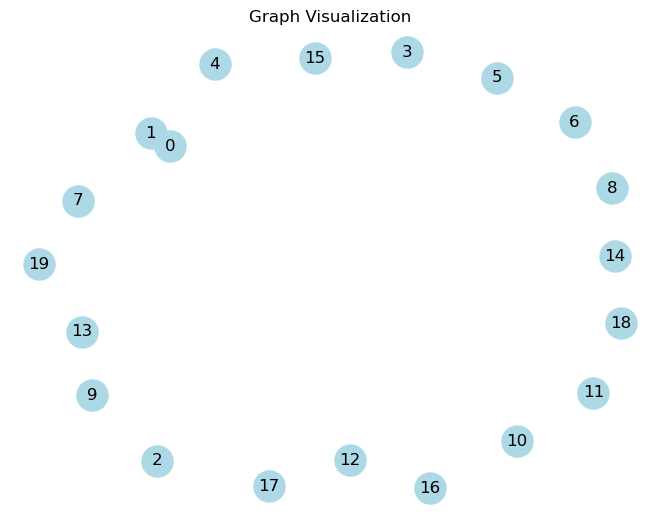

In [29]:
visualize_graph(graphs[3])

In [30]:
!pip install torch_geometric

In [31]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

In [32]:
import torch

# Example graph object from the user's data
graph = graphs[3]

# Extracting edge indices
edge_indices = graph.edge_index.t().tolist()

# Extracting node features (assuming each node has a feature vector)
node_features = graph.x.tolist()

# The nodes can be represented as a list of indices from 0 to the number of nodes - 1
node_indices = list(range(len(node_features)))

# Displaying the node indices and edge indices
#node_indices, edge_indices
#print(node_features)

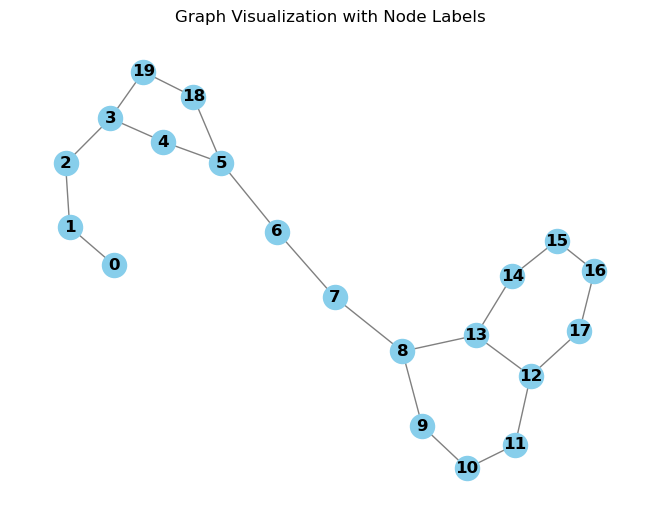

In [33]:
import networkx as nx
import torch_geometric

edge_index = torch.tensor(edge_indices, dtype=torch.long)
x = torch.tensor(node_indices, dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Draw the graph with node labels
pos = nx.spring_layout(g)  # Compute layout
nx.draw(g, pos, with_labels=True, font_weight='bold', node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization with Node Labels")
plt.show()

In [34]:
# Print the edge indices
print(graphs[3].edge_index.t().tolist())

[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 5, 18, 18, 19, 19, 3, 13, 8, 17, 12], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 5, 19, 18, 3, 19, 8, 13, 12, 17]]


In [35]:
# graphs[0] is a torch_geometric.data.Data object from your graphs list
graph = graphs[3]

# Print node features
print("Len of graph:", len(graph))
print("Node Features:")
print(len(graph.x))
#for i, node_feature in enumerate(graph.x):
    #print(f"Node {i}: {node_feature}")

# Print edge pairs and edge features
print("\nEdge Pairs and Features:")
print(graph.edge_index.t())
for i, edge in enumerate(graph.edge_index.t()):
    src, dest = edge[0].item(), edge[1].item()
    edge_feature = graph.edge_attr[i]
    #print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


Len of graph: 3
Node Features:
20

Edge Pairs and Features:
tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,  5, 18,
         18, 19, 19,  3, 13,  8, 17, 12],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18,  5,
         19, 18,  3, 19,  8, 13, 12, 17]])


In [36]:
# Extracting edge list and edge features from the provided graph
graph = graphs[5]  

# Extracting edge index
edge_index = graph.edge_index.t()

# Preparing the edge list
edge_list = []
for i in range(edge_index.shape[1]):
    edge = edge_index[:, i]
    edge_list.append((edge[0].item(), edge[1].item()))

edge_list


[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (7, 9),
 (9, 7),
 (9, 10),
 (10, 9),
 (1, 11),
 (11, 1),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (18, 17),
 (18, 19),
 (19, 18),
 (19, 20),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 21),
 (22, 23),
 (23, 22),
 (14, 24),
 (24, 14),
 (24, 25),
 (25, 24),
 (10, 4),
 (4, 10),
 (25, 11),
 (11, 25),
 (23, 15),
 (15, 23),
 (23, 18),
 (18, 23)]

In [37]:
import torch
from torch_geometric.data import Data

# Assuming graph_data is your list of graph objects
# graph_data[0] is the first graph object

# Select the first graph object
first_graph = graphs[3]

# Convert node features to a floating-point type if they aren't already
node_features_float = first_graph.x.float()

# Inspect node features
print("Node features (x) of the first graph:")
print(node_features_float)
print("Shape of node features:", node_features_float.shape)

# Inspect edge features
print("\nEdge features (edge_attr) of the first graph:")
print(first_graph.edge_attr)
print("Shape of edge features:", first_graph.edge_attr.shape)

# Inspect edge index (connectivity)
print("\nEdge index (edge_index) of the first graph:")
print(first_graph.edge_index)
print("Shape of edge index:", first_graph.edge_index.shape)

# Calculate min and max for each node feature of the first graph
min_values, max_values = node_features_float.min(dim=0)[0], node_features_float.max(dim=0)[0]

print("\nMinimum values of node features:", min_values)
print("Maximum values of node features:", max_values)

# Calculate the standard deviation for each node feature
std_deviation = node_features_float.std(dim=0)
print("\nStandard deviation of node features:", std_deviation)


Node features (x) of the first graph:
tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000, -0.3944],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0628],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0658],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0275],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1335],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0670]])
Shape of node features: torch.Size([20, 72])

Edge features (edge_attr) of the first graph:
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1.,

In [38]:
smiles_df['SMILES'][3]

'OCCn1cc(CNc2cccc3c2CCCC3)nn1'

In [39]:
mol = Chem.MolFromSmiles(smiles_df['SMILES'][3])
AllChem.ComputeGasteigerCharges(mol)

In [40]:
edge_indices = []
for bond in mol.GetBonds():
    start_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    edge_indices.append((start_idx, end_idx))
    edge_indices.append((end_idx, start_idx))  # Add the reverse direction


In [41]:
edge_indices

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (5, 18),
 (18, 5),
 (18, 19),
 (19, 18),
 (19, 3),
 (3, 19),
 (13, 8),
 (8, 13),
 (17, 12),
 (12, 17)]

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear

In [43]:
print((graphs[0]))
print((smiles_df.head(1)))

Data(x=[25, 72], edge_index=[54, 2], edge_attr=[54, 10])
                                   SMILES
0  CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1


In [44]:
print(len(graphs))
print(len(smiles_df))

10000
10000


In [45]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 10000


In [46]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [47]:
print(type(graphs[3]))

<class 'torch_geometric.data.data.Data'>


In [48]:
# Unsupervised Graph Generative Adversarial Netwrok

In [49]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [50]:
def generate_random_edge_index(num_nodes):
    # Example implementation to generate a random edge_index
    # Here we create a fully connected graph for simplicity
    edge_index = torch.combinations(torch.arange(num_nodes), r=2)
    return torch.cat([edge_index, edge_index.flip([1])], dim=0).t()  # Making it undirected

In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Data, Batch
from torch_geometric.utils import erdos_renyi_graph

def generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes):
    """
    Generate random noise for a batch of graphs with variable number of nodes and edges,
    but fixed node feature and edge feature dimensions.

    Args:
    - batch_size (int): Number of random graphs to generate.
    - node_feature_dim (int): Number of features for each node.
    - edge_feature_dim (int): Number of features for each edge.
    - max_num_nodes (int): Maximum number of nodes a graph can have.

    Returns:
    - A list of Data objects containing random noise for node and edge features.
    """
    random_graphs = []

    for _ in range(batch_size):
        # Randomly determine the number of nodes for this graph
        num_nodes = torch.randint(low=1, high=max_num_nodes, size=(1,)).item()

        # Generate random node features
        x = torch.randn(num_nodes, node_feature_dim)

        # Generate a random graph structure (edge_index)
        edge_index = erdos_renyi_graph(num_nodes, edge_prob=0.5)  # p is the probability of an edge

        # Generate random edge features (if needed)
        num_edges = edge_index.size(1)
        edge_attr = torch.randn(num_edges, edge_feature_dim) if edge_feature_dim > 0 else None

        # Create a Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        random_graphs.append(data)

    #return random_graphs
    return Batch.from_data_list(random_graphs)





In [52]:
# Example usage
batch_size = 32
node_feature_dim = 72  # Number of node features
edge_feature_dim = 10  # Number of edge features, adjust as needed
max_num_nodes = 50    # Maximum number of nodes in a graph

random_noise_graphs = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)

In [53]:
random_noise_graphs 

DataBatch(x=[772, 72], edge_index=[2, 12390], edge_attr=[12390, 10], batch=[772], ptr=[33])

In [54]:
# Generator Model
class Generator_v1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index gen",type(x), type(edge_index))
        #print("x, edge_index gen",x.size(), edge_index.size())
        #print("x, edge_index gen",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("Generator x layer 1:",x)
        x = torch.sigmoid(self.layer2(x, edge_index))
        #print("Generator x  layer 2:",x)
        return x

In [55]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)    

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.layer1(x, edge_index))
        x = torch.sigmoid(self.layer2(x, edge_index))

        # Generate fake edge_index (simple example, should be improved)
        fake_edge_index = self.generate_fake_edge_index(x.size(0))
        return x, fake_edge_index

    def generate_fake_edge_index(self, num_nodes):
        # Implement logic to generate a plausible edge_index for fake graphs
        # Placeholder logic: create a simple linear chain graph
        edge_index = torch.tensor([[i, i+1] for i in range(num_nodes - 1)], dtype=torch.long).t()
        return edge_index


In [56]:
# Discriminator Model  
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        #print("In discriminator")
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("self.layer1",input_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        #print("self.layer2",hidden_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index1",type(x), type(edge_index))
        #print("x, edge_index2",x.size(), edge_index.size())
        #print("x, edge_index3",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("x 2",x)
        x = torch.sigmoid(self.layer2(x))
        #print("x 3",x)
        return x

In [57]:
# Model Initialization
generator_input_dim = 72
generator_hidden_dim = 256
#generator_hidden_dim = 128
generator_output_dim = 72

discriminator_input_dim = 72
discriminator_hidden_dim = 256
#discriminator_hidden_dim = 128

In [58]:
generator = Generator(generator_input_dim, generator_hidden_dim, generator_output_dim)
discriminator = Discriminator(discriminator_input_dim, discriminator_hidden_dim)

In [59]:
import torch.optim as optim
from torch_geometric.data import DataLoader
#from torch_geometric.loader import DataLoader

from torch.utils.data import Dataset

# Sample data loader (replace with your dataset)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=['x', 'edge_index'])
data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=[])



# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Loss function
adversarial_loss = torch.nn.BCELoss()

C:\Users\Malli\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [60]:
# Function to calculate discriminator accuracy
def calculate_discriminator_accuracy(discriminator, real_data, fake_data):
    real_predictions = discriminator(real_data).round()
    fake_predictions = discriminator(fake_data).round()
    correct_predictions = (real_predictions == 1).sum() + (fake_predictions == 0).sum()
    total_predictions = real_predictions.numel() + fake_predictions.numel()
    accuracy = 100 * correct_predictions.float() / total_predictions
    return accuracy

In [61]:
print((data_loader))

In [62]:
print((graphs[3].x).shape)
print((graphs[3].edge_index).shape)

torch.Size([20, 72])
torch.Size([44, 2])


In [63]:
print((graphs[0].x).shape)
print((graphs[0].edge_index).shape)

torch.Size([25, 72])
torch.Size([54, 2])


In [64]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch

def custom_graph_data_loader(graph_dataset, batch_size):
    """
    Custom data loader for graph data.
    
    Args:
    - graph_dataset (list of Data): The dataset containing graph Data objects.
    - batch_size (int): The size of each batch.

    Yields:
    - Batched Data object containing a batch of graphs.
    """

    def batch_graphs(graphs):
        """
        Manually batches a list of graphs into a single Batch object.
        """
        batched_edge_index = []
        batched_x = []
        batched_batch = []

        current_node_idx = 0
        for i, graph in enumerate(graphs):
            # Offset the node indices by the current_node_idx and add them to the batched edge index.
            #edge_index_offset = graph.edge_index + current_node_idx
            #batched_edge_index.append(edge_index_offset)
            
            # Offset only the node indices in the edge_index tensor.
            edge_index_offset = graph.edge_index.clone()  # Make a copy to avoid modifying the original graph
            edge_index_offset[0, :] += current_node_idx  # Offset source node indices
            edge_index_offset[1, :] += current_node_idx  # Offset target node indices
            #batched_edge_index.append(edge_index_offset)            
            
            #Tring edge_index
            #batched_edge_index.append(graph.edge_index)
            batched_edge_index.append(graph.edge_index + current_node_idx)

            # Add the current graph's node features to the batched node features.
            batched_x.append(graph.x)

            # Add the graph index to the batch vector for all nodes of this graph.
            batched_batch.append(torch.full((graph.x.size(0),), i, dtype=torch.long))

            # Update the current_node_idx for the next graph.
            current_node_idx += graph.x.size(0)

        # Concatenate all the lists to create tensors.       
        
        batched_edge_index = torch.cat(batched_edge_index, dim=0)
        batched_x = torch.cat(batched_x, dim=0)
        batched_batch = torch.cat(batched_batch, dim=0)
        

        # Create a new Data object to hold the batched graph.
        batched_data = Data(x=batched_x, edge_index=batched_edge_index)
        batched_data.batch = batched_batch

        return batched_data

    # Shuffle dataset at the beginning of each epoch
    indices = torch.randperm(len(graph_dataset))
    
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        batch_graphs_list = [graph_dataset[i] for i in batch_indices]
        batch = batch_graphs(batch_graphs_list)
        yield batch


In [65]:
import matplotlib.pyplot as plt
import torch

def calculate_accuracy(preds, labels):
    predicted_labels = preds.round()  # Convert probabilities to 0/1
    correct = (predicted_labels == labels).float()  # Convert into float for division 
    accuracy = correct.sum() / len(correct)
    return accuracy

In [66]:
num_epochs = 100
batch_size = 32

# Lists to store metrics
epochs = []
d_losses = []
g_losses = []
real_accuracy_list =[]
fake_accuracy_list=[]
d_accuracies = []


for epoch in range(num_epochs):
    print("epoch", epoch)
    for batch in custom_graph_data_loader(graphs, batch_size):
        # Generate fake data
        random_noise_graphs_batch = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)

        # Ensure the real edge_index is correctly shaped [2, num_edges]
        if batch.edge_index.size(0) != 2:
            batch.edge_index = batch.edge_index.t()  # Transpose if necessary        
        
        # Create fake data batch with both x and edge_index
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)

        # Labels for real and fake data (for each node)
        real_labels = torch.ones(batch.x.size(0), 1)
        fake_labels = torch.zeros(fake_data.x.size(0), 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(batch), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        # Recompute fake data and perform forward pass through discriminator
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)
        updated_real_labels = torch.ones(fake_data.x.size(0), 1)
        g_loss = adversarial_loss(discriminator(fake_data), updated_real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        
        # Calculate discriminator accuracy
        real_accuracy = calculate_accuracy(discriminator(batch).detach(), real_labels)
        print("real_accuracy",real_accuracy)
        fake_accuracy = calculate_accuracy(discriminator(fake_data).detach(), fake_labels)
        print("fake_accuracy",fake_accuracy)
        d_accuracy = (real_accuracy + fake_accuracy) / 2

        # Store metrics
        d_losses.append(d_loss.item())
        print("d_loss.item()",d_loss.item())
        g_losses.append(g_loss.item())
        print("g_loss.item()",g_loss.item())
        d_accuracies.append(d_accuracy.item())
        real_accuracy_list.append(real_accuracy.item())
        fake_accuracy_list.append(fake_accuracy.item())
        
        epochs.append(epoch)


epoch 0
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4146424531936646
g_loss.item() 0.7106198072433472
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.330883264541626
g_loss.item() 0.7896189093589783
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2608747482299805
g_loss.item() 0.8724803924560547
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1965522766113281
g_loss.item() 0.9563408493995667
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1372965574264526
g_loss.item() 1.041967749595642
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0753231048583984
g_loss.item() 1.1265122890472412
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0326259136199951
g_loss.item() 1.2098525762557983
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.9882590770721436
g_loss.item() 1.2987470626831055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.8418)
d_loss.item() 0.6048541069030762
g_loss.item() 1.4197207689285278
real_accuracy tensor(1.)
fake_accuracy tensor(0.8745)
d_loss.item() 0.576749324798584
g_loss.item() 1.499984860420227
real_accuracy tensor(1.)
fake_accuracy tensor(0.8532)
d_loss.item() 0.6204521656036377
g_loss.item() 1.3885825872421265
real_accuracy tensor(1.)
fake_accuracy tensor(0.8869)
d_loss.item() 0.6170112490653992
g_loss.item() 1.4532140493392944
real_accuracy tensor(1.)
fake_accuracy tensor(0.8815)
d_loss.item() 0.6460763216018677
g_loss.item() 1.4032002687454224
real_accuracy tensor(1.)
fake_accuracy tensor(0.8573)
d_loss.item() 0.6631408333778381
g_loss.item() 1.429628610610962
real_accuracy tensor(1.)
fake_accuracy tensor(0.8502)
d_loss.item() 0.7326847314834595
g_loss.item() 1.3735110759735107
real_accuracy tensor(0.9989)
fake_accuracy tensor(0.8637)
d_loss.item() 0.7380648255348206
g_loss.item() 1.3821690082550049
real_accuracy tensor(0.9975)
fake_accur

real_accuracy tensor(0.4811)
fake_accuracy tensor(1.)
d_loss.item() 1.2248568534851074
g_loss.item() 1.0398088693618774
real_accuracy tensor(0.5346)
fake_accuracy tensor(1.)
d_loss.item() 1.169711709022522
g_loss.item() 1.056583285331726
real_accuracy tensor(0.5323)
fake_accuracy tensor(1.)
d_loss.item() 1.1590161323547363
g_loss.item() 1.0827075242996216
real_accuracy tensor(0.5266)
fake_accuracy tensor(1.)
d_loss.item() 1.1728798151016235
g_loss.item() 1.0620728731155396
real_accuracy tensor(0.5771)
fake_accuracy tensor(1.)
d_loss.item() 1.124984622001648
g_loss.item() 1.0764514207839966
real_accuracy tensor(0.4951)
fake_accuracy tensor(1.)
d_loss.item() 1.1758019924163818
g_loss.item() 1.0793663263320923
real_accuracy tensor(0.5366)
fake_accuracy tensor(1.)
d_loss.item() 1.1700413227081299
g_loss.item() 1.0563279390335083
real_accuracy tensor(0.5397)
fake_accuracy tensor(1.)
d_loss.item() 1.1544671058654785
g_loss.item() 1.0693548917770386
real_accuracy tensor(0.6123)
fake_accuracy 

real_accuracy tensor(0.9905)
fake_accuracy tensor(1.)
d_loss.item() 0.3636457324028015
g_loss.item() 1.909448504447937
real_accuracy tensor(0.9947)
fake_accuracy tensor(1.)
d_loss.item() 0.36049991846084595
g_loss.item() 1.8780925273895264
real_accuracy tensor(0.9894)
fake_accuracy tensor(1.)
d_loss.item() 0.34416890144348145
g_loss.item() 1.9140437841415405
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.32709431648254395
g_loss.item() 1.9277316331863403
real_accuracy tensor(0.9916)
fake_accuracy tensor(1.)
d_loss.item() 0.35508662462234497
g_loss.item() 1.8744574785232544
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.32737886905670166
g_loss.item() 1.8904576301574707
real_accuracy tensor(0.9953)
fake_accuracy tensor(1.)
d_loss.item() 0.31221967935562134
g_loss.item() 1.9248642921447754
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.310967355966568
g_loss.item() 1.9388031959533691
real_accuracy tensor(0.9978)
fake_accura

real_accuracy tensor(0.3125)
fake_accuracy tensor(0.4063)
d_loss.item() 2.535919427871704
g_loss.item() 0.6464483141899109
real_accuracy tensor(0.2911)
fake_accuracy tensor(0.5231)
d_loss.item() 2.4556169509887695
g_loss.item() 0.7068424820899963
real_accuracy tensor(0.3065)
fake_accuracy tensor(0.7645)
d_loss.item() 2.289132833480835
g_loss.item() 0.7807326912879944
real_accuracy tensor(0.2832)
fake_accuracy tensor(0.9049)
d_loss.item() 2.2473130226135254
g_loss.item() 0.8602464199066162
real_accuracy tensor(0.3532)
fake_accuracy tensor(0.9923)
d_loss.item() 2.172663927078247
g_loss.item() 0.9821925163269043
real_accuracy tensor(0.3142)
fake_accuracy tensor(1.)
d_loss.item() 2.0371577739715576
g_loss.item() 1.1214592456817627
real_accuracy tensor(0.3427)
fake_accuracy tensor(1.)
d_loss.item() 1.853176474571228
g_loss.item() 1.160404920578003
real_accuracy tensor(0.3212)
fake_accuracy tensor(1.)
d_loss.item() 1.8656648397445679
g_loss.item() 1.2684389352798462
real_accuracy tensor(0.28

real_accuracy tensor(0.9854)
fake_accuracy tensor(1.)
d_loss.item() 0.1736324578523636
g_loss.item() 2.6223957538604736
real_accuracy tensor(0.9850)
fake_accuracy tensor(1.)
d_loss.item() 0.18957647681236267
g_loss.item() 2.566204309463501
real_accuracy tensor(0.9882)
fake_accuracy tensor(1.)
d_loss.item() 0.2057153284549713
g_loss.item() 2.4746875762939453
real_accuracy tensor(0.9792)
fake_accuracy tensor(1.)
d_loss.item() 0.2379980981349945
g_loss.item() 2.3800551891326904
real_accuracy tensor(0.9736)
fake_accuracy tensor(1.)
d_loss.item() 0.23134541511535645
g_loss.item() 2.3329334259033203
real_accuracy tensor(0.9847)
fake_accuracy tensor(1.)
d_loss.item() 0.22386431694030762
g_loss.item() 2.301337957382202
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.21909385919570923
g_loss.item() 2.243654251098633
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.21259364485740662
g_loss.item() 2.2802734375
real_accuracy tensor(0.9727)
fake_accuracy t

real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.24468858540058136
g_loss.item() 2.311931610107422
real_accuracy tensor(0.9545)
fake_accuracy tensor(1.)
d_loss.item() 0.2594119906425476
g_loss.item() 2.3081111907958984
real_accuracy tensor(0.9787)
fake_accuracy tensor(1.)
d_loss.item() 0.23163145780563354
g_loss.item() 2.243462324142456
real_accuracy tensor(0.9718)
fake_accuracy tensor(1.)
d_loss.item() 0.2517295479774475
g_loss.item() 2.16646409034729
real_accuracy tensor(0.9780)
fake_accuracy tensor(1.)
d_loss.item() 0.27909165620803833
g_loss.item() 2.0506904125213623
real_accuracy tensor(0.9911)
fake_accuracy tensor(1.)
d_loss.item() 0.2650628089904785
g_loss.item() 2.0689384937286377
real_accuracy tensor(0.9812)
fake_accuracy tensor(1.)
d_loss.item() 0.31783196330070496
g_loss.item() 1.8650275468826294
real_accuracy tensor(0.9746)
fake_accuracy tensor(1.)
d_loss.item() 0.32633131742477417
g_loss.item() 1.936181664466858
real_accuracy tensor(0.9831)
fake_accura

real_accuracy tensor(0.9636)
fake_accuracy tensor(0.9985)
d_loss.item() 0.5900022983551025
g_loss.item() 1.3454848527908325
real_accuracy tensor(0.9451)
fake_accuracy tensor(1.)
d_loss.item() 0.5761240124702454
g_loss.item() 1.4262455701828003
real_accuracy tensor(0.9241)
fake_accuracy tensor(1.)
d_loss.item() 0.5613971948623657
g_loss.item() 1.5406975746154785
real_accuracy tensor(0.9220)
fake_accuracy tensor(1.)
d_loss.item() 0.5133944749832153
g_loss.item() 1.6183589696884155
real_accuracy tensor(0.9251)
fake_accuracy tensor(1.)
d_loss.item() 0.4584132432937622
g_loss.item() 1.8406652212142944
real_accuracy tensor(0.9077)
fake_accuracy tensor(1.)
d_loss.item() 0.47254830598831177
g_loss.item() 2.0276668071746826
real_accuracy tensor(0.8841)
fake_accuracy tensor(1.)
d_loss.item() 0.45593419671058655
g_loss.item() 2.1767795085906982
real_accuracy tensor(0.9142)
fake_accuracy tensor(1.)
d_loss.item() 0.4156440496444702
g_loss.item() 2.318258762359619
real_accuracy tensor(0.8864)
fake_a

real_accuracy tensor(0.9685)
fake_accuracy tensor(1.)
d_loss.item() 0.22948580980300903
g_loss.item() 2.2638988494873047
real_accuracy tensor(0.9767)
fake_accuracy tensor(1.)
d_loss.item() 0.22251111268997192
g_loss.item() 2.2491965293884277
real_accuracy tensor(0.9715)
fake_accuracy tensor(1.)
d_loss.item() 0.25149402022361755
g_loss.item() 2.154729127883911
real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.2532826066017151
g_loss.item() 2.103599786758423
real_accuracy tensor(0.9881)
fake_accuracy tensor(1.)
d_loss.item() 0.24344336986541748
g_loss.item() 2.046412706375122
real_accuracy tensor(0.9871)
fake_accuracy tensor(1.)
d_loss.item() 0.22707891464233398
g_loss.item() 2.164461135864258
real_accuracy tensor(0.9901)
fake_accuracy tensor(1.)
d_loss.item() 0.23766487836837769
g_loss.item() 2.0800437927246094
real_accuracy tensor(0.9769)
fake_accuracy tensor(1.)
d_loss.item() 0.2416726052761078
g_loss.item() 2.1991653442382812
real_accuracy tensor(0.9899)
fake_accu

real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.15477848052978516
g_loss.item() 3.0785467624664307
real_accuracy tensor(0.9849)
fake_accuracy tensor(1.)
d_loss.item() 0.13186798989772797
g_loss.item() 3.0821568965911865
real_accuracy tensor(0.9776)
fake_accuracy tensor(1.)
d_loss.item() 0.14082099497318268
g_loss.item() 3.1267452239990234
real_accuracy tensor(0.9890)
fake_accuracy tensor(1.)
d_loss.item() 0.12746408581733704
g_loss.item() 3.1365230083465576
real_accuracy tensor(0.9823)
fake_accuracy tensor(1.)
d_loss.item() 0.12867145240306854
g_loss.item() 3.1643948554992676
real_accuracy tensor(0.9920)
fake_accuracy tensor(1.)
d_loss.item() 0.12310556322336197
g_loss.item() 3.124664306640625
real_accuracy tensor(0.9847)
fake_accuracy tensor(1.)
d_loss.item() 0.12519390881061554
g_loss.item() 3.142853260040283
real_accuracy tensor(0.9821)
fake_accuracy tensor(1.)
d_loss.item() 0.1526135951280594
g_loss.item() 3.120205879211426
real_accuracy tensor(0.9884)
fake_ac

real_accuracy tensor(0.9337)
fake_accuracy tensor(1.)
d_loss.item() 0.3474367558956146
g_loss.item() 1.9200656414031982
real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.3430134057998657
g_loss.item() 1.9617125988006592
real_accuracy tensor(0.9309)
fake_accuracy tensor(1.)
d_loss.item() 0.35847681760787964
g_loss.item() 2.024249315261841
real_accuracy tensor(0.9443)
fake_accuracy tensor(1.)
d_loss.item() 0.3197217583656311
g_loss.item() 2.143432378768921
real_accuracy tensor(0.9372)
fake_accuracy tensor(1.)
d_loss.item() 0.31864768266677856
g_loss.item() 2.186305522918701
real_accuracy tensor(0.9223)
fake_accuracy tensor(1.)
d_loss.item() 0.3269832134246826
g_loss.item() 2.3411829471588135
real_accuracy tensor(0.9344)
fake_accuracy tensor(1.)
d_loss.item() 0.3156430125236511
g_loss.item() 2.4063432216644287
real_accuracy tensor(0.9329)
fake_accuracy tensor(1.)
d_loss.item() 0.3058655261993408
g_loss.item() 2.5722603797912598
real_accuracy tensor(0.9386)
fake_accurac

real_accuracy tensor(0.8711)
fake_accuracy tensor(1.)
d_loss.item() 0.5121428966522217
g_loss.item() 1.879086971282959
real_accuracy tensor(0.8652)
fake_accuracy tensor(1.)
d_loss.item() 0.5541247129440308
g_loss.item() 1.9810220003128052
real_accuracy tensor(0.8287)
fake_accuracy tensor(1.)
d_loss.item() 0.5719438791275024
g_loss.item() 1.9637459516525269
real_accuracy tensor(0.8675)
fake_accuracy tensor(1.)
d_loss.item() 0.5033717155456543
g_loss.item() 1.9841278791427612
real_accuracy tensor(0.8692)
fake_accuracy tensor(1.)
d_loss.item() 0.5289102792739868
g_loss.item() 1.8396717309951782
real_accuracy tensor(0.8675)
fake_accuracy tensor(1.)
d_loss.item() 0.5595177412033081
g_loss.item() 1.918444275856018
real_accuracy tensor(0.8829)
fake_accuracy tensor(1.)
d_loss.item() 0.5207794308662415
g_loss.item() 2.010929822921753
real_accuracy tensor(0.8573)
fake_accuracy tensor(1.)
d_loss.item() 0.48199036717414856
g_loss.item() 2.0913116931915283
real_accuracy tensor(0.8631)
fake_accuracy

real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.0979001596570015
g_loss.item() 3.276336669921875
real_accuracy tensor(0.9901)
fake_accuracy tensor(1.)
d_loss.item() 0.10325351357460022
g_loss.item() 3.2700459957122803
real_accuracy tensor(0.9891)
fake_accuracy tensor(1.)
d_loss.item() 0.10746659338474274
g_loss.item() 3.094597101211548
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.10597512125968933
g_loss.item() 3.1467859745025635
real_accuracy tensor(0.9874)
fake_accuracy tensor(1.)
d_loss.item() 0.09950551390647888
g_loss.item() 3.2536044120788574
real_accuracy tensor(0.9874)
fake_accuracy tensor(1.)
d_loss.item() 0.10048903524875641
g_loss.item() 3.3786799907684326
real_accuracy tensor(0.9841)
fake_accuracy tensor(1.)
d_loss.item() 0.09793069958686829
g_loss.item() 3.5374183654785156
real_accuracy tensor(0.9921)
fake_accuracy tensor(1.)
d_loss.item() 0.07254739850759506
g_loss.item() 3.700638771057129
real_accuracy tensor(0.9803)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.026568803936243057
g_loss.item() 4.575398921966553
real_accuracy tensor(0.9970)
fake_accuracy tensor(1.)
d_loss.item() 0.035972997546195984
g_loss.item() 4.6280646324157715
real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.025022808462381363
g_loss.item() 4.752900123596191
real_accuracy tensor(0.9964)
fake_accuracy tensor(1.)
d_loss.item() 0.025804854929447174
g_loss.item() 4.84512996673584
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.027956217527389526
g_loss.item() 4.865937232971191
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.025962907820940018
g_loss.item() 4.908423900604248
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.025411980226635933
g_loss.item() 4.998698711395264
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.02169603295624256
g_loss.item() 4.987423896789551
real_accuracy tensor(0.9963)
fake_acc

real_accuracy tensor(0.9380)
fake_accuracy tensor(1.)
d_loss.item() 0.19471614062786102
g_loss.item() 2.7712504863739014
real_accuracy tensor(0.9448)
fake_accuracy tensor(1.)
d_loss.item() 0.19809216260910034
g_loss.item() 2.6218059062957764
real_accuracy tensor(0.9562)
fake_accuracy tensor(1.)
d_loss.item() 0.1786651313304901
g_loss.item() 2.671093225479126
real_accuracy tensor(0.9369)
fake_accuracy tensor(1.)
d_loss.item() 0.19313783943653107
g_loss.item() 2.6549952030181885
real_accuracy tensor(0.9602)
fake_accuracy tensor(1.)
d_loss.item() 0.16536517441272736
g_loss.item() 2.6038193702697754
real_accuracy tensor(0.9360)
fake_accuracy tensor(1.)
d_loss.item() 0.19412602484226227
g_loss.item() 2.623582363128662
real_accuracy tensor(0.9498)
fake_accuracy tensor(1.)
d_loss.item() 0.17904719710350037
g_loss.item() 2.585210084915161
real_accuracy tensor(0.9704)
fake_accuracy tensor(1.)
d_loss.item() 0.1658746749162674
g_loss.item() 2.523712635040283
real_accuracy tensor(0.9693)
fake_accu

real_accuracy tensor(0.9465)
fake_accuracy tensor(1.)
d_loss.item() 0.17800407111644745
g_loss.item() 3.0614447593688965
real_accuracy tensor(0.9432)
fake_accuracy tensor(1.)
d_loss.item() 0.1830827295780182
g_loss.item() 3.172344207763672
real_accuracy tensor(0.9425)
fake_accuracy tensor(1.)
d_loss.item() 0.18690797686576843
g_loss.item() 3.1155850887298584
real_accuracy tensor(0.9619)
fake_accuracy tensor(1.)
d_loss.item() 0.16432996094226837
g_loss.item() 3.118128776550293
real_accuracy tensor(0.9524)
fake_accuracy tensor(1.)
d_loss.item() 0.18248602747917175
g_loss.item() 3.017062187194824
real_accuracy tensor(0.9715)
fake_accuracy tensor(1.)
d_loss.item() 0.14144080877304077
g_loss.item() 3.04669451713562
real_accuracy tensor(0.9653)
fake_accuracy tensor(1.)
d_loss.item() 0.16432006657123566
g_loss.item() 3.0515127182006836
real_accuracy tensor(0.9622)
fake_accuracy tensor(1.)
d_loss.item() 0.198512002825737
g_loss.item() 2.907534122467041
real_accuracy tensor(0.9507)
fake_accurac

real_accuracy tensor(0.9786)
fake_accuracy tensor(1.)
d_loss.item() 0.18531522154808044
g_loss.item() 2.73699951171875
real_accuracy tensor(0.9734)
fake_accuracy tensor(1.)
d_loss.item() 0.17644232511520386
g_loss.item() 2.76703143119812
real_accuracy tensor(0.9706)
fake_accuracy tensor(1.)
d_loss.item() 0.16806316375732422
g_loss.item() 2.8305604457855225
real_accuracy tensor(0.9806)
fake_accuracy tensor(1.)
d_loss.item() 0.16862282156944275
g_loss.item() 2.814723253250122
real_accuracy tensor(0.9709)
fake_accuracy tensor(1.)
d_loss.item() 0.16381390392780304
g_loss.item() 2.837200164794922
real_accuracy tensor(0.9808)
fake_accuracy tensor(1.)
d_loss.item() 0.14507505297660828
g_loss.item() 2.881033182144165
real_accuracy tensor(0.9707)
fake_accuracy tensor(1.)
d_loss.item() 0.16936489939689636
g_loss.item() 2.841003179550171
real_accuracy tensor(0.9779)
fake_accuracy tensor(1.)
d_loss.item() 0.1535433828830719
g_loss.item() 2.8708181381225586
real_accuracy tensor(0.9857)
fake_accurac

real_accuracy tensor(0.8972)
fake_accuracy tensor(1.)
d_loss.item() 0.42313680052757263
g_loss.item() 1.9610686302185059
real_accuracy tensor(0.8930)
fake_accuracy tensor(1.)
d_loss.item() 0.452167809009552
g_loss.item() 1.948218822479248
real_accuracy tensor(0.9060)
fake_accuracy tensor(1.)
d_loss.item() 0.42939305305480957
g_loss.item() 1.894907832145691
real_accuracy tensor(0.8633)
fake_accuracy tensor(1.)
d_loss.item() 0.546741247177124
g_loss.item() 1.8111666440963745
real_accuracy tensor(0.9062)
fake_accuracy tensor(1.)
d_loss.item() 0.43407490849494934
g_loss.item() 1.971671223640442
real_accuracy tensor(0.8307)
fake_accuracy tensor(1.)
d_loss.item() 0.6566251516342163
g_loss.item() 1.7756953239440918
real_accuracy tensor(0.8686)
fake_accuracy tensor(1.)
d_loss.item() 0.5633952021598816
g_loss.item() 1.8679040670394897
real_accuracy tensor(0.8589)
fake_accuracy tensor(1.)
d_loss.item() 0.6350788474082947
g_loss.item() 1.7000929117202759
real_accuracy tensor(0.8137)
fake_accuracy

real_accuracy tensor(0.9711)
fake_accuracy tensor(1.)
d_loss.item() 0.149504154920578
g_loss.item() 2.907677412033081
real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.1753338873386383
g_loss.item() 2.9419071674346924
real_accuracy tensor(0.9510)
fake_accuracy tensor(1.)
d_loss.item() 0.16097187995910645
g_loss.item() 3.0157687664031982
real_accuracy tensor(0.9715)
fake_accuracy tensor(1.)
d_loss.item() 0.13306337594985962
g_loss.item() 2.909640312194824
real_accuracy tensor(0.9634)
fake_accuracy tensor(1.)
d_loss.item() 0.16225452721118927
g_loss.item() 2.850942611694336
real_accuracy tensor(0.9724)
fake_accuracy tensor(1.)
d_loss.item() 0.14347635209560394
g_loss.item() 2.7628087997436523
real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.12562382221221924
g_loss.item() 2.9168143272399902
real_accuracy tensor(0.9441)
fake_accuracy tensor(1.)
d_loss.item() 0.20033320784568787
g_loss.item() 2.8971149921417236
real_accuracy tensor(0.9710)
fake_accu

real_accuracy tensor(0.9791)
fake_accuracy tensor(1.)
d_loss.item() 0.21987803280353546
g_loss.item() 2.518766164779663
real_accuracy tensor(0.9849)
fake_accuracy tensor(1.)
d_loss.item() 0.20005297660827637
g_loss.item() 2.6405246257781982
real_accuracy tensor(0.9714)
fake_accuracy tensor(1.)
d_loss.item() 0.24638661742210388
g_loss.item() 2.550442695617676
real_accuracy tensor(0.9719)
fake_accuracy tensor(1.)
d_loss.item() 0.22454172372817993
g_loss.item() 2.6886019706726074
real_accuracy tensor(0.9759)
fake_accuracy tensor(1.)
d_loss.item() 0.22549456357955933
g_loss.item() 2.6918678283691406
real_accuracy tensor(0.9763)
fake_accuracy tensor(1.)
d_loss.item() 0.205646812915802
g_loss.item() 2.6744327545166016
real_accuracy tensor(0.9661)
fake_accuracy tensor(1.)
d_loss.item() 0.21652495861053467
g_loss.item() 2.792449474334717
real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.2064875066280365
g_loss.item() 2.6662580966949463
real_accuracy tensor(0.9731)
fake_accu

real_accuracy tensor(0.9605)
fake_accuracy tensor(1.)
d_loss.item() 0.14541089534759521
g_loss.item() 3.5967063903808594
real_accuracy tensor(0.9560)
fake_accuracy tensor(1.)
d_loss.item() 0.1558208465576172
g_loss.item() 3.4565885066986084
real_accuracy tensor(0.9515)
fake_accuracy tensor(1.)
d_loss.item() 0.17407101392745972
g_loss.item() 3.437283515930176
real_accuracy tensor(0.9527)
fake_accuracy tensor(1.)
d_loss.item() 0.17985500395298004
g_loss.item() 3.317575693130493
real_accuracy tensor(0.9507)
fake_accuracy tensor(1.)
d_loss.item() 0.19536852836608887
g_loss.item() 3.4496235847473145
real_accuracy tensor(0.9814)
fake_accuracy tensor(1.)
d_loss.item() 0.10652537643909454
g_loss.item() 3.278775215148926
real_accuracy tensor(0.9569)
fake_accuracy tensor(1.)
d_loss.item() 0.17436575889587402
g_loss.item() 3.192413806915283
real_accuracy tensor(0.9481)
fake_accuracy tensor(1.)
d_loss.item() 0.19195491075515747
g_loss.item() 3.1670687198638916
real_accuracy tensor(0.9661)
fake_acc

real_accuracy tensor(0.7197)
fake_accuracy tensor(0.9474)
d_loss.item() 1.3381717205047607
g_loss.item() 1.4061752557754517
real_accuracy tensor(0.6109)
fake_accuracy tensor(0.9773)
d_loss.item() 1.5755332708358765
g_loss.item() 1.4535373449325562
real_accuracy tensor(0.6082)
fake_accuracy tensor(0.9703)
d_loss.item() 1.6873849630355835
g_loss.item() 1.4333856105804443
real_accuracy tensor(0.6454)
fake_accuracy tensor(0.9908)
d_loss.item() 1.5723944902420044
g_loss.item() 1.3559236526489258
real_accuracy tensor(0.6508)
fake_accuracy tensor(0.9724)
d_loss.item() 1.4715816974639893
g_loss.item() 1.4069668054580688
real_accuracy tensor(0.7307)
fake_accuracy tensor(0.9837)
d_loss.item() 1.2844488620758057
g_loss.item() 1.4272887706756592
real_accuracy tensor(0.7145)
fake_accuracy tensor(0.9975)
d_loss.item() 1.2656484842300415
g_loss.item() 1.4495569467544556
real_accuracy tensor(0.7314)
fake_accuracy tensor(0.9908)
d_loss.item() 1.3152128458023071
g_loss.item() 1.288460373878479
real_accu

real_accuracy tensor(0.9803)
fake_accuracy tensor(1.)
d_loss.item() 0.10931171476840973
g_loss.item() 3.255185604095459
real_accuracy tensor(0.9886)
fake_accuracy tensor(1.)
d_loss.item() 0.08776985108852386
g_loss.item() 3.3259949684143066
real_accuracy tensor(0.9857)
fake_accuracy tensor(1.)
d_loss.item() 0.0888647586107254
g_loss.item() 3.3215229511260986
real_accuracy tensor(0.9666)
fake_accuracy tensor(1.)
d_loss.item() 0.11668616533279419
g_loss.item() 3.296377182006836
real_accuracy tensor(0.9839)
fake_accuracy tensor(1.)
d_loss.item() 0.09258206188678741
g_loss.item() 3.3577096462249756
real_accuracy tensor(0.9881)
fake_accuracy tensor(1.)
d_loss.item() 0.07779084891080856
g_loss.item() 3.3375885486602783
real_accuracy tensor(0.9857)
fake_accuracy tensor(1.)
d_loss.item() 0.0821174830198288
g_loss.item() 3.324049949645996
real_accuracy tensor(0.9850)
fake_accuracy tensor(1.)
d_loss.item() 0.09302845597267151
g_loss.item() 3.252720832824707
real_accuracy tensor(0.9792)
fake_accu

real_accuracy tensor(0.9119)
fake_accuracy tensor(1.)
d_loss.item() 0.37043431401252747
g_loss.item() 2.0939488410949707
real_accuracy tensor(0.9057)
fake_accuracy tensor(1.)
d_loss.item() 0.35702311992645264
g_loss.item() 2.0928382873535156
real_accuracy tensor(0.8814)
fake_accuracy tensor(1.)
d_loss.item() 0.3879656493663788
g_loss.item() 2.1685540676116943
real_accuracy tensor(0.8690)
fake_accuracy tensor(1.)
d_loss.item() 0.3983859419822693
g_loss.item() 2.2301149368286133
real_accuracy tensor(0.8913)
fake_accuracy tensor(1.)
d_loss.item() 0.3920516073703766
g_loss.item() 2.208035945892334
real_accuracy tensor(0.9066)
fake_accuracy tensor(1.)
d_loss.item() 0.34139758348464966
g_loss.item() 2.2062935829162598
real_accuracy tensor(0.8900)
fake_accuracy tensor(1.)
d_loss.item() 0.3802116811275482
g_loss.item() 2.265091896057129
real_accuracy tensor(0.9184)
fake_accuracy tensor(1.)
d_loss.item() 0.30738192796707153
g_loss.item() 2.2069380283355713
real_accuracy tensor(0.9154)
fake_accu

real_accuracy tensor(0.8980)
fake_accuracy tensor(1.)
d_loss.item() 0.4752765893936157
g_loss.item() 1.9903206825256348
real_accuracy tensor(0.8601)
fake_accuracy tensor(1.)
d_loss.item() 0.5383129119873047
g_loss.item() 1.979912281036377
real_accuracy tensor(0.8614)
fake_accuracy tensor(1.)
d_loss.item() 0.5319565534591675
g_loss.item() 2.209778070449829
real_accuracy tensor(0.8640)
fake_accuracy tensor(1.)
d_loss.item() 0.5393055081367493
g_loss.item() 2.264157772064209
real_accuracy tensor(0.8689)
fake_accuracy tensor(1.)
d_loss.item() 0.5122942328453064
g_loss.item() 2.3954720497131348
real_accuracy tensor(0.8860)
fake_accuracy tensor(1.)
d_loss.item() 0.3810061812400818
g_loss.item() 2.5958986282348633
real_accuracy tensor(0.8503)
fake_accuracy tensor(1.)
d_loss.item() 0.5106097459793091
g_loss.item() 2.574385643005371
real_accuracy tensor(0.8524)
fake_accuracy tensor(1.)
d_loss.item() 0.5539339184761047
g_loss.item() 2.7340292930603027
real_accuracy tensor(0.8403)
fake_accuracy t

real_accuracy tensor(0.8095)
fake_accuracy tensor(0.9771)
d_loss.item() 0.6998441219329834
g_loss.item() 2.541543483734131
real_accuracy tensor(0.8363)
fake_accuracy tensor(0.9635)
d_loss.item() 0.5288877487182617
g_loss.item() 2.975492477416992
real_accuracy tensor(0.8737)
fake_accuracy tensor(0.9886)
d_loss.item() 0.47576242685317993
g_loss.item() 2.9421498775482178
real_accuracy tensor(0.8068)
fake_accuracy tensor(0.9971)
d_loss.item() 0.63759845495224
g_loss.item() 2.469571113586426
real_accuracy tensor(0.8045)
fake_accuracy tensor(1.)
d_loss.item() 0.5878388285636902
g_loss.item() 2.73333477973938
real_accuracy tensor(0.7882)
fake_accuracy tensor(1.)
d_loss.item() 0.6185860633850098
g_loss.item() 2.7504303455352783
real_accuracy tensor(0.7860)
fake_accuracy tensor(1.)
d_loss.item() 0.5647004246711731
g_loss.item() 2.7552905082702637
real_accuracy tensor(0.8297)
fake_accuracy tensor(1.)
d_loss.item() 0.5201055407524109
g_loss.item() 2.7258312702178955
real_accuracy tensor(0.7964)
f

real_accuracy tensor(0.9324)
fake_accuracy tensor(1.)
d_loss.item() 0.3094314932823181
g_loss.item() 2.1749887466430664
real_accuracy tensor(0.9290)
fake_accuracy tensor(1.)
d_loss.item() 0.2992877960205078
g_loss.item() 2.233635902404785
real_accuracy tensor(0.9253)
fake_accuracy tensor(1.)
d_loss.item() 0.3377475142478943
g_loss.item() 2.245051860809326
real_accuracy tensor(0.9005)
fake_accuracy tensor(1.)
d_loss.item() 0.37033718824386597
g_loss.item() 2.2184953689575195
real_accuracy tensor(0.9307)
fake_accuracy tensor(1.)
d_loss.item() 0.30491939187049866
g_loss.item() 2.2601497173309326
real_accuracy tensor(0.9151)
fake_accuracy tensor(1.)
d_loss.item() 0.33054378628730774
g_loss.item() 2.2940964698791504
real_accuracy tensor(0.9283)
fake_accuracy tensor(1.)
d_loss.item() 0.3279516100883484
g_loss.item() 2.289726734161377
real_accuracy tensor(0.9196)
fake_accuracy tensor(1.)
d_loss.item() 0.3131455183029175
g_loss.item() 2.3180389404296875
real_accuracy tensor(0.9557)
fake_accura

real_accuracy tensor(0.7219)
fake_accuracy tensor(0.9910)
d_loss.item() 0.7584272623062134
g_loss.item() 1.6266279220581055
real_accuracy tensor(0.6642)
fake_accuracy tensor(0.9666)
d_loss.item() 0.8622235059738159
g_loss.item() 1.5707595348358154
real_accuracy tensor(0.6258)
fake_accuracy tensor(0.9247)
d_loss.item() 0.9541624784469604
g_loss.item() 1.4194022417068481
real_accuracy tensor(0.6754)
fake_accuracy tensor(0.8710)
d_loss.item() 0.8910512328147888
g_loss.item() 1.4273873567581177
real_accuracy tensor(0.6703)
fake_accuracy tensor(0.9555)
d_loss.item() 0.8656851053237915
g_loss.item() 1.5927327871322632
real_accuracy tensor(0.6509)
fake_accuracy tensor(0.9101)
d_loss.item() 1.063551425933838
g_loss.item() 1.279954195022583
real_accuracy tensor(0.6427)
fake_accuracy tensor(0.9164)
d_loss.item() 1.16396963596344
g_loss.item() 1.1962682008743286
real_accuracy tensor(0.6416)
fake_accuracy tensor(0.9695)
d_loss.item() 1.1542961597442627
g_loss.item() 1.3363720178604126
real_accurac

real_accuracy tensor(0.9091)
fake_accuracy tensor(1.)
d_loss.item() 0.2742496132850647
g_loss.item() 2.4666643142700195
real_accuracy tensor(0.9307)
fake_accuracy tensor(0.9718)
d_loss.item() 0.3326612114906311
g_loss.item() 2.2168965339660645
real_accuracy tensor(0.9355)
fake_accuracy tensor(0.9979)
d_loss.item() 0.33794188499450684
g_loss.item() 2.177877902984619
real_accuracy tensor(0.9441)
fake_accuracy tensor(0.9964)
d_loss.item() 0.2684219777584076
g_loss.item() 2.4989302158355713
real_accuracy tensor(0.9414)
fake_accuracy tensor(1.)
d_loss.item() 0.2770462930202484
g_loss.item() 2.485044240951538
real_accuracy tensor(0.9388)
fake_accuracy tensor(0.9950)
d_loss.item() 0.2933056950569153
g_loss.item() 2.381695032119751
real_accuracy tensor(0.9297)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2711421847343445
g_loss.item() 2.5753607749938965
real_accuracy tensor(0.9436)
fake_accuracy tensor(0.9550)
d_loss.item() 0.30115771293640137
g_loss.item() 2.350888967514038
real_accuracy tens

real_accuracy tensor(0.7234)
fake_accuracy tensor(0.9919)
d_loss.item() 0.8300989866256714
g_loss.item() 1.4907974004745483
real_accuracy tensor(0.6794)
fake_accuracy tensor(0.9967)
d_loss.item() 0.8864045143127441
g_loss.item() 1.5214769840240479
real_accuracy tensor(0.7310)
fake_accuracy tensor(0.9172)
d_loss.item() 0.8192899227142334
g_loss.item() 1.5275415182113647
real_accuracy tensor(0.7226)
fake_accuracy tensor(0.9057)
d_loss.item() 0.8905563354492188
g_loss.item() 1.4309251308441162
real_accuracy tensor(0.7496)
fake_accuracy tensor(0.9749)
d_loss.item() 0.7671254873275757
g_loss.item() 1.57470703125
real_accuracy tensor(0.8083)
fake_accuracy tensor(0.9942)
d_loss.item() 0.6548498868942261
g_loss.item() 1.5450501441955566
real_accuracy tensor(0.7512)
fake_accuracy tensor(0.9492)
d_loss.item() 0.7840111255645752
g_loss.item() 1.473881721496582
real_accuracy tensor(0.6977)
fake_accuracy tensor(0.9926)
d_loss.item() 0.8331966996192932
g_loss.item() 1.5245037078857422
real_accuracy 

real_accuracy tensor(0.7072)
fake_accuracy tensor(0.9876)
d_loss.item() 0.8802180290222168
g_loss.item() 1.539900541305542
real_accuracy tensor(0.6735)
fake_accuracy tensor(0.9691)
d_loss.item() 0.9793282151222229
g_loss.item() 1.4013903141021729
real_accuracy tensor(0.7109)
fake_accuracy tensor(0.9402)
d_loss.item() 0.9097309112548828
g_loss.item() 1.4615670442581177
real_accuracy tensor(0.6941)
fake_accuracy tensor(1.)
d_loss.item() 0.879142701625824
g_loss.item() 1.5538240671157837
real_accuracy tensor(0.7178)
fake_accuracy tensor(0.9843)
d_loss.item() 0.8539519906044006
g_loss.item() 1.4866509437561035
real_accuracy tensor(0.7316)
fake_accuracy tensor(0.9796)
d_loss.item() 0.9341609477996826
g_loss.item() 1.4039764404296875
real_accuracy tensor(0.7129)
fake_accuracy tensor(1.)
d_loss.item() 0.8762758374214172
g_loss.item() 1.5757688283920288
real_accuracy tensor(0.6654)
fake_accuracy tensor(0.9836)
d_loss.item() 0.9828022718429565
g_loss.item() 1.5171046257019043
real_accuracy tens

real_accuracy tensor(0.7235)
fake_accuracy tensor(0.9253)
d_loss.item() 0.9461464285850525
g_loss.item() 1.4399738311767578
real_accuracy tensor(0.6821)
fake_accuracy tensor(0.9957)
d_loss.item() 0.8941562175750732
g_loss.item() 1.6048531532287598
real_accuracy tensor(0.6891)
fake_accuracy tensor(0.9427)
d_loss.item() 1.021012783050537
g_loss.item() 1.3724499940872192
real_accuracy tensor(0.6696)
fake_accuracy tensor(0.9632)
d_loss.item() 1.0106468200683594
g_loss.item() 1.4412968158721924
real_accuracy tensor(0.7403)
fake_accuracy tensor(0.9975)
d_loss.item() 0.8302866220474243
g_loss.item() 1.4808790683746338
real_accuracy tensor(0.7014)
fake_accuracy tensor(0.9533)
d_loss.item() 0.930831789970398
g_loss.item() 1.476157784461975
real_accuracy tensor(0.7021)
fake_accuracy tensor(0.9952)
d_loss.item() 0.9279776811599731
g_loss.item() 1.4599337577819824
real_accuracy tensor(0.7035)
fake_accuracy tensor(0.9287)
d_loss.item() 1.0341455936431885
g_loss.item() 1.3178259134292603
real_accura

real_accuracy tensor(0.8099)
fake_accuracy tensor(0.9985)
d_loss.item() 0.6396535038948059
g_loss.item() 1.552130937576294
real_accuracy tensor(0.8155)
fake_accuracy tensor(0.9806)
d_loss.item() 0.5981346368789673
g_loss.item() 1.5882062911987305
real_accuracy tensor(0.8261)
fake_accuracy tensor(0.9639)
d_loss.item() 0.6149160265922546
g_loss.item() 1.6336125135421753
real_accuracy tensor(0.7902)
fake_accuracy tensor(0.9585)
d_loss.item() 0.6845810413360596
g_loss.item() 1.6376142501831055
real_accuracy tensor(0.7993)
fake_accuracy tensor(1.)
d_loss.item() 0.6346392631530762
g_loss.item() 1.6562777757644653
real_accuracy tensor(0.8071)
fake_accuracy tensor(0.9724)
d_loss.item() 0.6555267572402954
g_loss.item() 1.5757590532302856
real_accuracy tensor(0.8154)
fake_accuracy tensor(1.)
d_loss.item() 0.5991153717041016
g_loss.item() 1.6665966510772705
real_accuracy tensor(0.8363)
fake_accuracy tensor(0.9986)
d_loss.item() 0.6451591849327087
g_loss.item() 1.449967622756958
real_accuracy tens

real_accuracy tensor(0.8494)
fake_accuracy tensor(0.9580)
d_loss.item() 0.6543936729431152
g_loss.item() 1.4373952150344849
real_accuracy tensor(0.8313)
fake_accuracy tensor(0.8398)
d_loss.item() 0.8240677714347839
g_loss.item() 1.3005342483520508
real_accuracy tensor(0.8160)
fake_accuracy tensor(0.9881)
d_loss.item() 0.6954149007797241
g_loss.item() 1.4061741828918457
real_accuracy tensor(0.8176)
fake_accuracy tensor(0.8840)
d_loss.item() 0.8080414533615112
g_loss.item() 1.2758450508117676
real_accuracy tensor(0.7673)
fake_accuracy tensor(0.9584)
d_loss.item() 0.8343861699104309
g_loss.item() 1.3528876304626465
real_accuracy tensor(0.8015)
fake_accuracy tensor(0.8083)
d_loss.item() 1.1150095462799072
g_loss.item() 1.1786705255508423
real_accuracy tensor(0.7676)
fake_accuracy tensor(0.9901)
d_loss.item() 0.755220353603363
g_loss.item() 1.3722620010375977
real_accuracy tensor(0.7552)
fake_accuracy tensor(0.8685)
d_loss.item() 1.0269558429718018
g_loss.item() 1.2023413181304932
real_accu

real_accuracy tensor(0.7690)
fake_accuracy tensor(1.)
d_loss.item() 0.7371881008148193
g_loss.item() 1.4957488775253296
real_accuracy tensor(0.7741)
fake_accuracy tensor(0.9954)
d_loss.item() 0.8050247430801392
g_loss.item() 1.355403184890747
real_accuracy tensor(0.7855)
fake_accuracy tensor(1.)
d_loss.item() 0.6878353357315063
g_loss.item() 1.5149286985397339
real_accuracy tensor(0.7592)
fake_accuracy tensor(1.)
d_loss.item() 0.7685927748680115
g_loss.item() 1.4795935153961182
real_accuracy tensor(0.7834)
fake_accuracy tensor(1.)
d_loss.item() 0.7141188383102417
g_loss.item() 1.509475588798523
real_accuracy tensor(0.7440)
fake_accuracy tensor(1.)
d_loss.item() 0.7763515114784241
g_loss.item() 1.4691039323806763
real_accuracy tensor(0.7977)
fake_accuracy tensor(1.)
d_loss.item() 0.7105185985565186
g_loss.item() 1.424153447151184
real_accuracy tensor(0.7884)
fake_accuracy tensor(1.)
d_loss.item() 0.704822301864624
g_loss.item() 1.50737464427948
real_accuracy tensor(0.8002)
fake_accuracy

real_accuracy tensor(0.7893)
fake_accuracy tensor(0.9855)
d_loss.item() 0.7644450664520264
g_loss.item() 1.5799131393432617
real_accuracy tensor(0.8000)
fake_accuracy tensor(0.9929)
d_loss.item() 0.7420845031738281
g_loss.item() 1.4866056442260742
real_accuracy tensor(0.8347)
fake_accuracy tensor(0.9725)
d_loss.item() 0.6680598855018616
g_loss.item() 1.5417420864105225
real_accuracy tensor(0.8193)
fake_accuracy tensor(1.)
d_loss.item() 0.6635756492614746
g_loss.item() 1.5587868690490723
real_accuracy tensor(0.8212)
fake_accuracy tensor(0.9199)
d_loss.item() 0.6274713277816772
g_loss.item() 1.5804309844970703
real_accuracy tensor(0.8299)
fake_accuracy tensor(0.9545)
d_loss.item() 0.689488410949707
g_loss.item() 1.399685025215149
real_accuracy tensor(0.7945)
fake_accuracy tensor(1.)
d_loss.item() 0.6590702533721924
g_loss.item() 1.736151933670044
real_accuracy tensor(0.8264)
fake_accuracy tensor(0.9933)
d_loss.item() 0.638243556022644
g_loss.item() 1.6348742246627808
real_accuracy tensor

real_accuracy tensor(0.7745)
fake_accuracy tensor(0.9989)
d_loss.item() 0.6879370212554932
g_loss.item() 1.713029146194458
real_accuracy tensor(0.7852)
fake_accuracy tensor(1.)
d_loss.item() 0.6584925055503845
g_loss.item() 1.625670075416565
real_accuracy tensor(0.7885)
fake_accuracy tensor(0.9953)
d_loss.item() 0.6595227718353271
g_loss.item() 1.6032792329788208
real_accuracy tensor(0.7985)
fake_accuracy tensor(0.9240)
d_loss.item() 0.7511135339736938
g_loss.item() 1.5455824136734009
real_accuracy tensor(0.8031)
fake_accuracy tensor(0.9969)
d_loss.item() 0.6136907935142517
g_loss.item() 1.6778305768966675
real_accuracy tensor(0.7818)
fake_accuracy tensor(0.9912)
d_loss.item() 0.625299334526062
g_loss.item() 1.6582543849945068
real_accuracy tensor(0.8124)
fake_accuracy tensor(1.)
d_loss.item() 0.5895096659660339
g_loss.item() 1.6838637590408325
real_accuracy tensor(0.7815)
fake_accuracy tensor(0.9948)
d_loss.item() 0.6854079961776733
g_loss.item() 1.5594689846038818
real_accuracy tenso

real_accuracy tensor(0.7560)
fake_accuracy tensor(0.9807)
d_loss.item() 0.8012429475784302
g_loss.item() 1.3061721324920654
real_accuracy tensor(0.7827)
fake_accuracy tensor(0.9973)
d_loss.item() 0.7177667617797852
g_loss.item() 1.4603288173675537
real_accuracy tensor(0.7420)
fake_accuracy tensor(0.9692)
d_loss.item() 0.8203754425048828
g_loss.item() 1.3689708709716797
real_accuracy tensor(0.7022)
fake_accuracy tensor(0.9974)
d_loss.item() 0.8307090997695923
g_loss.item() 1.4563077688217163
real_accuracy tensor(0.7586)
fake_accuracy tensor(0.9828)
d_loss.item() 0.8275964260101318
g_loss.item() 1.3547329902648926
real_accuracy tensor(0.7387)
fake_accuracy tensor(0.9841)
d_loss.item() 0.8326047658920288
g_loss.item() 1.3215008974075317
real_accuracy tensor(0.7355)
fake_accuracy tensor(0.9953)
d_loss.item() 0.7787244915962219
g_loss.item() 1.4236646890640259
real_accuracy tensor(0.7665)
fake_accuracy tensor(0.9962)
d_loss.item() 0.78367680311203
g_loss.item() 1.305126667022705
real_accura

real_accuracy tensor(0.7761)
fake_accuracy tensor(1.)
d_loss.item() 0.7116131782531738
g_loss.item() 1.6322941780090332
real_accuracy tensor(0.8175)
fake_accuracy tensor(1.)
d_loss.item() 0.6094427108764648
g_loss.item() 1.6820355653762817
real_accuracy tensor(0.7779)
fake_accuracy tensor(1.)
d_loss.item() 0.7535851001739502
g_loss.item() 1.5205113887786865
real_accuracy tensor(0.7782)
fake_accuracy tensor(1.)
d_loss.item() 0.7085140943527222
g_loss.item() 1.5983706712722778
real_accuracy tensor(0.7783)
fake_accuracy tensor(1.)
d_loss.item() 0.6964281797409058
g_loss.item() 1.6006965637207031
real_accuracy tensor(0.7678)
fake_accuracy tensor(1.)
d_loss.item() 0.6800088286399841
g_loss.item() 1.6876471042633057
real_accuracy tensor(0.7655)
fake_accuracy tensor(1.)
d_loss.item() 0.7881172895431519
g_loss.item() 1.528490424156189
real_accuracy tensor(0.7527)
fake_accuracy tensor(1.)
d_loss.item() 0.7425475120544434
g_loss.item() 1.476502537727356
real_accuracy tensor(0.8392)
fake_accuracy

real_accuracy tensor(0.8700)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5749841928482056
g_loss.item() 1.4272897243499756
real_accuracy tensor(0.8121)
fake_accuracy tensor(0.9973)
d_loss.item() 0.6163320541381836
g_loss.item() 1.5567971467971802
real_accuracy tensor(0.7533)
fake_accuracy tensor(1.)
d_loss.item() 0.7194585800170898
g_loss.item() 1.6290689706802368
real_accuracy tensor(0.7878)
fake_accuracy tensor(0.9948)
d_loss.item() 0.7137153148651123
g_loss.item() 1.5392118692398071
real_accuracy tensor(0.7854)
fake_accuracy tensor(0.9926)
d_loss.item() 0.6507436037063599
g_loss.item() 1.56806480884552
real_accuracy tensor(0.8096)
fake_accuracy tensor(0.9940)
d_loss.item() 0.6028153300285339
g_loss.item() 1.6071405410766602
real_accuracy tensor(0.7764)
fake_accuracy tensor(0.9957)
d_loss.item() 0.6837086081504822
g_loss.item() 1.6235673427581787
real_accuracy tensor(0.8027)
fake_accuracy tensor(0.9888)
d_loss.item() 0.6458382606506348
g_loss.item() 1.5613734722137451
real_accuracy 

real_accuracy tensor(0.7799)
fake_accuracy tensor(1.)
d_loss.item() 0.7067133188247681
g_loss.item() 1.623438835144043
real_accuracy tensor(0.8201)
fake_accuracy tensor(1.)
d_loss.item() 0.5858155488967896
g_loss.item() 1.6780095100402832
real_accuracy tensor(0.7728)
fake_accuracy tensor(1.)
d_loss.item() 0.7321900725364685
g_loss.item() 1.6784402132034302
real_accuracy tensor(0.8346)
fake_accuracy tensor(1.)
d_loss.item() 0.5745375752449036
g_loss.item() 1.6879280805587769
real_accuracy tensor(0.8031)
fake_accuracy tensor(1.)
d_loss.item() 0.6129716634750366
g_loss.item() 1.702329158782959
real_accuracy tensor(0.8331)
fake_accuracy tensor(1.)
d_loss.item() 0.6109921932220459
g_loss.item() 1.6960062980651855
real_accuracy tensor(0.7870)
fake_accuracy tensor(1.)
d_loss.item() 0.6587256789207458
g_loss.item() 1.6398217678070068
real_accuracy tensor(0.8179)
fake_accuracy tensor(1.)
d_loss.item() 0.6577988266944885
g_loss.item() 1.687031626701355
real_accuracy tensor(0.8010)
fake_accuracy 

real_accuracy tensor(0.8186)
fake_accuracy tensor(1.)
d_loss.item() 0.5685238242149353
g_loss.item() 1.709116816520691
real_accuracy tensor(0.8369)
fake_accuracy tensor(1.)
d_loss.item() 0.543485164642334
g_loss.item() 1.776191234588623
real_accuracy tensor(0.8651)
fake_accuracy tensor(1.)
d_loss.item() 0.49878138303756714
g_loss.item() 1.9190565347671509
real_accuracy tensor(0.8464)
fake_accuracy tensor(1.)
d_loss.item() 0.5065277814865112
g_loss.item() 1.7580146789550781
real_accuracy tensor(0.8306)
fake_accuracy tensor(1.)
d_loss.item() 0.5580369234085083
g_loss.item() 1.8048436641693115
real_accuracy tensor(0.8479)
fake_accuracy tensor(1.)
d_loss.item() 0.53399258852005
g_loss.item() 1.7033498287200928
real_accuracy tensor(0.8519)
fake_accuracy tensor(1.)
d_loss.item() 0.4945848882198334
g_loss.item() 1.8916659355163574
real_accuracy tensor(0.8425)
fake_accuracy tensor(1.)
d_loss.item() 0.571250319480896
g_loss.item() 1.7893444299697876
real_accuracy tensor(0.8288)
fake_accuracy te

real_accuracy tensor(0.8403)
fake_accuracy tensor(0.9975)
d_loss.item() 0.6104602813720703
g_loss.item() 1.5218448638916016
real_accuracy tensor(0.8253)
fake_accuracy tensor(1.)
d_loss.item() 0.6170013546943665
g_loss.item() 1.5393743515014648
real_accuracy tensor(0.8293)
fake_accuracy tensor(0.9796)
d_loss.item() 0.6393013000488281
g_loss.item() 1.4739952087402344
real_accuracy tensor(0.8510)
fake_accuracy tensor(1.)
d_loss.item() 0.5354752540588379
g_loss.item() 1.6664336919784546
real_accuracy tensor(0.7823)
fake_accuracy tensor(1.)
d_loss.item() 0.7031004428863525
g_loss.item() 1.6377595663070679
real_accuracy tensor(0.7917)
fake_accuracy tensor(0.9988)
d_loss.item() 0.6374274492263794
g_loss.item() 1.7291433811187744
real_accuracy tensor(0.8333)
fake_accuracy tensor(0.9881)
d_loss.item() 0.5757885575294495
g_loss.item() 1.7267215251922607
real_accuracy tensor(0.8327)
fake_accuracy tensor(1.)
d_loss.item() 0.558819055557251
g_loss.item() 1.7581168413162231
real_accuracy tensor(0.77

real_accuracy tensor(0.8265)
fake_accuracy tensor(1.)
d_loss.item() 0.5757075548171997
g_loss.item() 1.7077133655548096
real_accuracy tensor(0.7759)
fake_accuracy tensor(0.8894)
d_loss.item() 0.8389194011688232
g_loss.item() 1.4184147119522095
real_accuracy tensor(0.7892)
fake_accuracy tensor(0.9986)
d_loss.item() 0.6898627877235413
g_loss.item() 1.5670208930969238
real_accuracy tensor(0.8596)
fake_accuracy tensor(0.9891)
d_loss.item() 0.6155263781547546
g_loss.item() 1.4958083629608154
real_accuracy tensor(0.8150)
fake_accuracy tensor(0.9345)
d_loss.item() 0.7910768985748291
g_loss.item() 1.300701379776001
real_accuracy tensor(0.8338)
fake_accuracy tensor(0.9812)
d_loss.item() 0.6500648856163025
g_loss.item() 1.6126682758331299
real_accuracy tensor(0.8139)
fake_accuracy tensor(0.9583)
d_loss.item() 0.6944553852081299
g_loss.item() 1.5547882318496704
real_accuracy tensor(0.8029)
fake_accuracy tensor(0.9727)
d_loss.item() 0.6888226866722107
g_loss.item() 1.5290896892547607
real_accuracy

real_accuracy tensor(0.8219)
fake_accuracy tensor(0.9537)
d_loss.item() 0.6803088188171387
g_loss.item() 1.602708339691162
real_accuracy tensor(0.7436)
fake_accuracy tensor(0.9339)
d_loss.item() 1.0058010816574097
g_loss.item() 1.5195164680480957
real_accuracy tensor(0.8197)
fake_accuracy tensor(0.9534)
d_loss.item() 0.7006902694702148
g_loss.item() 1.5577542781829834
real_accuracy tensor(0.7726)
fake_accuracy tensor(0.9919)
d_loss.item() 0.764986515045166
g_loss.item() 1.541623592376709
real_accuracy tensor(0.7888)
fake_accuracy tensor(0.8799)
d_loss.item() 1.1953659057617188
g_loss.item() 1.4384268522262573
real_accuracy tensor(0.8178)
fake_accuracy tensor(0.9837)
d_loss.item() 0.6644354462623596
g_loss.item() 1.5783228874206543
real_accuracy tensor(0.7607)
fake_accuracy tensor(0.9022)
d_loss.item() 1.1396749019622803
g_loss.item() 1.5148059129714966
real_accuracy tensor(0.8083)
fake_accuracy tensor(1.)
d_loss.item() 0.6277428865432739
g_loss.item() 1.676639199256897
real_accuracy te

real_accuracy tensor(0.7525)
fake_accuracy tensor(0.9588)
d_loss.item() 0.7817028760910034
g_loss.item() 1.5034312009811401
real_accuracy tensor(0.7851)
fake_accuracy tensor(0.9597)
d_loss.item() 0.7219625115394592
g_loss.item() 1.5881751775741577
real_accuracy tensor(0.8073)
fake_accuracy tensor(0.9430)
d_loss.item() 0.6843045949935913
g_loss.item() 1.5806933641433716
epoch 10
real_accuracy tensor(0.7852)
fake_accuracy tensor(0.9675)
d_loss.item() 0.7081217169761658
g_loss.item() 1.594235897064209
real_accuracy tensor(0.7894)
fake_accuracy tensor(0.9586)
d_loss.item() 0.7289998531341553
g_loss.item() 1.5975236892700195
real_accuracy tensor(0.7943)
fake_accuracy tensor(0.9423)
d_loss.item() 0.7237110137939453
g_loss.item() 1.6100103855133057
real_accuracy tensor(0.7465)
fake_accuracy tensor(0.9926)
d_loss.item() 0.7001105546951294
g_loss.item() 1.669026494026184
real_accuracy tensor(0.7715)
fake_accuracy tensor(0.9391)
d_loss.item() 0.8076748251914978
g_loss.item() 1.6280773878097534
r

real_accuracy tensor(0.7950)
fake_accuracy tensor(0.9664)
d_loss.item() 0.7889412641525269
g_loss.item() 1.609802007675171
real_accuracy tensor(0.8030)
fake_accuracy tensor(0.9719)
d_loss.item() 0.7386636734008789
g_loss.item() 1.7520323991775513
real_accuracy tensor(0.7919)
fake_accuracy tensor(0.9885)
d_loss.item() 0.7383225560188293
g_loss.item() 1.6737505197525024
real_accuracy tensor(0.7796)
fake_accuracy tensor(0.9854)
d_loss.item() 0.7808452844619751
g_loss.item() 1.6514713764190674
real_accuracy tensor(0.7800)
fake_accuracy tensor(0.9314)
d_loss.item() 0.8112468719482422
g_loss.item() 1.5983444452285767
real_accuracy tensor(0.8142)
fake_accuracy tensor(0.9218)
d_loss.item() 0.7659939527511597
g_loss.item() 1.7173007726669312
real_accuracy tensor(0.7715)
fake_accuracy tensor(0.9848)
d_loss.item() 0.7922261953353882
g_loss.item() 1.63755464553833
real_accuracy tensor(0.8062)
fake_accuracy tensor(0.9279)
d_loss.item() 0.754088282585144
g_loss.item() 1.662868857383728
real_accuracy

real_accuracy tensor(0.7081)
fake_accuracy tensor(0.9128)
d_loss.item() 0.8311463594436646
g_loss.item() 1.5702991485595703
real_accuracy tensor(0.7262)
fake_accuracy tensor(0.9599)
d_loss.item() 0.8087800741195679
g_loss.item() 1.477903127670288
real_accuracy tensor(0.7436)
fake_accuracy tensor(0.8450)
d_loss.item() 0.922527551651001
g_loss.item() 1.276583194732666
real_accuracy tensor(0.7213)
fake_accuracy tensor(0.8188)
d_loss.item() 0.9147976636886597
g_loss.item() 1.349797248840332
real_accuracy tensor(0.7074)
fake_accuracy tensor(0.8923)
d_loss.item() 0.8905835151672363
g_loss.item() 1.3855010271072388
real_accuracy tensor(0.6951)
fake_accuracy tensor(0.8935)
d_loss.item() 0.8957149982452393
g_loss.item() 1.4022886753082275
real_accuracy tensor(0.6597)
fake_accuracy tensor(0.8656)
d_loss.item() 1.0489803552627563
g_loss.item() 1.3011891841888428
real_accuracy tensor(0.6608)
fake_accuracy tensor(0.7610)
d_loss.item() 1.1837563514709473
g_loss.item() 1.1098363399505615
real_accurac

real_accuracy tensor(0.7481)
fake_accuracy tensor(0.8989)
d_loss.item() 0.9416866302490234
g_loss.item() 1.695365071296692
real_accuracy tensor(0.7557)
fake_accuracy tensor(0.8300)
d_loss.item() 0.9864698648452759
g_loss.item() 1.466623306274414
real_accuracy tensor(0.7921)
fake_accuracy tensor(0.9711)
d_loss.item() 0.7378803491592407
g_loss.item() 1.7022804021835327
real_accuracy tensor(0.7897)
fake_accuracy tensor(0.9320)
d_loss.item() 0.7786906957626343
g_loss.item() 1.8124788999557495
real_accuracy tensor(0.7987)
fake_accuracy tensor(0.9599)
d_loss.item() 0.7250328660011292
g_loss.item() 1.7528067827224731
real_accuracy tensor(0.7950)
fake_accuracy tensor(0.9317)
d_loss.item() 0.8416336178779602
g_loss.item() 1.5663576126098633
real_accuracy tensor(0.8212)
fake_accuracy tensor(0.8911)
d_loss.item() 0.7523338794708252
g_loss.item() 1.7032471895217896
real_accuracy tensor(0.8170)
fake_accuracy tensor(0.9197)
d_loss.item() 0.6911184787750244
g_loss.item() 1.7493075132369995
real_accur

fake_accuracy tensor(0.8862)
d_loss.item() 0.7196474671363831
g_loss.item() 1.5220062732696533
real_accuracy tensor(0.8318)
fake_accuracy tensor(0.9634)
d_loss.item() 0.6204683184623718
g_loss.item() 1.707815170288086
real_accuracy tensor(0.8440)
fake_accuracy tensor(0.9528)
d_loss.item() 0.5811728239059448
g_loss.item() 1.700884461402893
real_accuracy tensor(0.8268)
fake_accuracy tensor(0.9771)
d_loss.item() 0.5526081323623657
g_loss.item() 1.9289425611495972
real_accuracy tensor(0.8575)
fake_accuracy tensor(0.9813)
d_loss.item() 0.5269373655319214
g_loss.item() 1.8264553546905518
real_accuracy tensor(0.8385)
fake_accuracy tensor(0.9944)
d_loss.item() 0.5162083506584167
g_loss.item() 1.9141786098480225
real_accuracy tensor(0.8620)
fake_accuracy tensor(0.9754)
d_loss.item() 0.5147435665130615
g_loss.item() 1.8965874910354614
real_accuracy tensor(0.8883)
fake_accuracy tensor(0.9920)
d_loss.item() 0.4673590362071991
g_loss.item() 1.9161839485168457
real_accuracy tensor(0.8643)
fake_accur

real_accuracy tensor(0.7164)
fake_accuracy tensor(0.9266)
d_loss.item() 0.9168086051940918
g_loss.item() 1.324954867362976
real_accuracy tensor(0.7503)
fake_accuracy tensor(0.8480)
d_loss.item() 0.918014645576477
g_loss.item() 1.2899136543273926
real_accuracy tensor(0.7302)
fake_accuracy tensor(0.7959)
d_loss.item() 0.9797635078430176
g_loss.item() 1.302635908126831
real_accuracy tensor(0.7372)
fake_accuracy tensor(0.9413)
d_loss.item() 0.9093203544616699
g_loss.item() 1.3044883012771606
real_accuracy tensor(0.7276)
fake_accuracy tensor(0.8648)
d_loss.item() 0.8587315082550049
g_loss.item() 1.436354160308838
real_accuracy tensor(0.7090)
fake_accuracy tensor(0.9303)
d_loss.item() 0.9028481245040894
g_loss.item() 1.3707975149154663
real_accuracy tensor(0.7208)
fake_accuracy tensor(0.9405)
d_loss.item() 0.8515571355819702
g_loss.item() 1.3908969163894653
real_accuracy tensor(0.7370)
fake_accuracy tensor(0.8168)
d_loss.item() 0.9123792052268982
g_loss.item() 1.3189045190811157
real_accurac

real_accuracy tensor(0.6761)
fake_accuracy tensor(0.9324)
d_loss.item() 1.060293197631836
g_loss.item() 1.2453364133834839
real_accuracy tensor(0.6963)
fake_accuracy tensor(0.9884)
d_loss.item() 0.9737149477005005
g_loss.item() 1.3903321027755737
real_accuracy tensor(0.6640)
fake_accuracy tensor(0.9436)
d_loss.item() 1.061010479927063
g_loss.item() 1.2334104776382446
real_accuracy tensor(0.6598)
fake_accuracy tensor(0.9305)
d_loss.item() 1.0480155944824219
g_loss.item() 1.2386101484298706
real_accuracy tensor(0.7308)
fake_accuracy tensor(0.9241)
d_loss.item() 0.9399123191833496
g_loss.item() 1.302829623222351
real_accuracy tensor(0.6465)
fake_accuracy tensor(0.9471)
d_loss.item() 1.0640212297439575
g_loss.item() 1.371457576751709
real_accuracy tensor(0.7061)
fake_accuracy tensor(0.9631)
d_loss.item() 0.8985298871994019
g_loss.item() 1.3346223831176758
real_accuracy tensor(0.7164)
fake_accuracy tensor(0.9662)
d_loss.item() 0.9195284843444824
g_loss.item() 1.2017334699630737
real_accurac

real_accuracy tensor(0.7105)
fake_accuracy tensor(0.8759)
d_loss.item() 0.9727630019187927
g_loss.item() 1.31343412399292
real_accuracy tensor(0.7310)
fake_accuracy tensor(0.8011)
d_loss.item() 1.0033986568450928
g_loss.item() 1.1329580545425415
real_accuracy tensor(0.6930)
fake_accuracy tensor(0.8806)
d_loss.item() 1.0016875267028809
g_loss.item() 1.1720701456069946
real_accuracy tensor(0.6954)
fake_accuracy tensor(0.8944)
d_loss.item() 0.9794572591781616
g_loss.item() 1.1520459651947021
real_accuracy tensor(0.6966)
fake_accuracy tensor(0.8861)
d_loss.item() 0.9924120903015137
g_loss.item() 1.2512073516845703
real_accuracy tensor(0.7351)
fake_accuracy tensor(0.9435)
d_loss.item() 0.8772537112236023
g_loss.item() 1.2754790782928467
real_accuracy tensor(0.7245)
fake_accuracy tensor(0.8956)
d_loss.item() 0.931035578250885
g_loss.item() 1.2401528358459473
real_accuracy tensor(0.7195)
fake_accuracy tensor(0.9455)
d_loss.item() 0.9903944730758667
g_loss.item() 1.1800192594528198
real_accura

real_accuracy tensor(0.6855)
fake_accuracy tensor(0.9241)
d_loss.item() 0.9897765517234802
g_loss.item() 1.387937307357788
real_accuracy tensor(0.6961)
fake_accuracy tensor(0.8342)
d_loss.item() 1.1106674671173096
g_loss.item() 1.141276240348816
real_accuracy tensor(0.7091)
fake_accuracy tensor(0.8890)
d_loss.item() 1.0512348413467407
g_loss.item() 1.220452904701233
real_accuracy tensor(0.7141)
fake_accuracy tensor(0.9656)
d_loss.item() 0.8428201675415039
g_loss.item() 1.3620024919509888
real_accuracy tensor(0.7329)
fake_accuracy tensor(0.8941)
d_loss.item() 0.9321004152297974
g_loss.item() 1.1924149990081787
real_accuracy tensor(0.6945)
fake_accuracy tensor(0.9760)
d_loss.item() 0.908727765083313
g_loss.item() 1.2850033044815063
real_accuracy tensor(0.7125)
fake_accuracy tensor(0.9926)
d_loss.item() 0.8379852771759033
g_loss.item() 1.3831249475479126
real_accuracy tensor(0.6935)
fake_accuracy tensor(0.9541)
d_loss.item() 0.8800245523452759
g_loss.item() 1.3498514890670776
real_accurac

real_accuracy tensor(0.7518)
fake_accuracy tensor(0.8618)
d_loss.item() 0.8866111040115356
g_loss.item() 1.2141211032867432
real_accuracy tensor(0.7251)
fake_accuracy tensor(0.8524)
d_loss.item() 0.9323824644088745
g_loss.item() 1.1518440246582031
real_accuracy tensor(0.7740)
fake_accuracy tensor(0.9295)
d_loss.item() 0.8729763031005859
g_loss.item() 1.1519466638565063
real_accuracy tensor(0.7187)
fake_accuracy tensor(0.8828)
d_loss.item() 0.9941381812095642
g_loss.item() 1.1664834022521973
real_accuracy tensor(0.7480)
fake_accuracy tensor(0.8053)
d_loss.item() 0.9618946313858032
g_loss.item() 1.177790641784668
real_accuracy tensor(0.7288)
fake_accuracy tensor(0.9378)
d_loss.item() 0.9412815570831299
g_loss.item() 1.2475193738937378
real_accuracy tensor(0.7109)
fake_accuracy tensor(0.9629)
d_loss.item() 0.8821794390678406
g_loss.item() 1.3563714027404785
real_accuracy tensor(0.6831)
fake_accuracy tensor(0.9239)
d_loss.item() 1.0205296277999878
g_loss.item() 1.2751504182815552
real_accu

real_accuracy tensor(0.7000)
fake_accuracy tensor(0.9170)
d_loss.item() 0.9160723686218262
g_loss.item() 1.3443926572799683
real_accuracy tensor(0.7219)
fake_accuracy tensor(0.8947)
d_loss.item() 1.0019701719284058
g_loss.item() 1.2436840534210205
real_accuracy tensor(0.7535)
fake_accuracy tensor(0.9895)
d_loss.item() 0.8479053974151611
g_loss.item() 1.2604540586471558
real_accuracy tensor(0.7360)
fake_accuracy tensor(0.9702)
d_loss.item() 0.8429030179977417
g_loss.item() 1.289746642112732
real_accuracy tensor(0.7621)
fake_accuracy tensor(0.9408)
d_loss.item() 0.8259460926055908
g_loss.item() 1.2471038103103638
real_accuracy tensor(0.7467)
fake_accuracy tensor(0.9827)
d_loss.item() 0.8305847644805908
g_loss.item() 1.244277000427246
real_accuracy tensor(0.7509)
fake_accuracy tensor(0.9398)
d_loss.item() 0.860429584980011
g_loss.item() 1.3155090808868408
real_accuracy tensor(0.7283)
fake_accuracy tensor(0.9572)
d_loss.item() 0.8969290256500244
g_loss.item() 1.2284919023513794
real_accura

real_accuracy tensor(0.6970)
fake_accuracy tensor(0.9834)
d_loss.item() 0.8465407490730286
g_loss.item() 1.2855666875839233
real_accuracy tensor(0.7246)
fake_accuracy tensor(0.9260)
d_loss.item() 0.8706755638122559
g_loss.item() 1.2307217121124268
real_accuracy tensor(0.7085)
fake_accuracy tensor(0.9772)
d_loss.item() 0.8219811916351318
g_loss.item() 1.273176670074463
real_accuracy tensor(0.7396)
fake_accuracy tensor(0.9832)
d_loss.item() 0.7849292159080505
g_loss.item() 1.2750319242477417
real_accuracy tensor(0.7475)
fake_accuracy tensor(0.9928)
d_loss.item() 0.8331587314605713
g_loss.item() 1.2446174621582031
real_accuracy tensor(0.7444)
fake_accuracy tensor(0.9859)
d_loss.item() 0.8085594177246094
g_loss.item() 1.2104886770248413
real_accuracy tensor(0.7315)
fake_accuracy tensor(0.9374)
d_loss.item() 0.8337868452072144
g_loss.item() 1.2231234312057495
real_accuracy tensor(0.7687)
fake_accuracy tensor(0.9223)
d_loss.item() 0.807232141494751
g_loss.item() 1.225699782371521
real_accura

real_accuracy tensor(0.7500)
fake_accuracy tensor(1.)
d_loss.item() 0.7505999207496643
g_loss.item() 1.2820521593093872
real_accuracy tensor(0.7421)
fake_accuracy tensor(1.)
d_loss.item() 0.7575280666351318
g_loss.item() 1.3525458574295044
real_accuracy tensor(0.7051)
fake_accuracy tensor(0.9847)
d_loss.item() 0.8381222486495972
g_loss.item() 1.318976879119873
real_accuracy tensor(0.7063)
fake_accuracy tensor(0.9902)
d_loss.item() 0.8323504328727722
g_loss.item() 1.2917901277542114
real_accuracy tensor(0.7044)
fake_accuracy tensor(0.9825)
d_loss.item() 0.8240803480148315
g_loss.item() 1.2701807022094727
real_accuracy tensor(0.6890)
fake_accuracy tensor(1.)
d_loss.item() 0.8396288156509399
g_loss.item() 1.307955265045166
real_accuracy tensor(0.7364)
fake_accuracy tensor(1.)
d_loss.item() 0.7762280702590942
g_loss.item() 1.2838088274002075
real_accuracy tensor(0.7206)
fake_accuracy tensor(0.9677)
d_loss.item() 0.8182622790336609
g_loss.item() 1.2836209535598755
real_accuracy tensor(0.725

real_accuracy tensor(0.7429)
fake_accuracy tensor(0.9768)
d_loss.item() 0.7833514213562012
g_loss.item() 1.3104456663131714
real_accuracy tensor(0.7531)
fake_accuracy tensor(1.)
d_loss.item() 0.7501574754714966
g_loss.item() 1.3514766693115234
real_accuracy tensor(0.7389)
fake_accuracy tensor(0.9958)
d_loss.item() 0.7737829685211182
g_loss.item() 1.3760936260223389
real_accuracy tensor(0.7665)
fake_accuracy tensor(1.)
d_loss.item() 0.7633999586105347
g_loss.item() 1.3692352771759033
real_accuracy tensor(0.7708)
fake_accuracy tensor(1.)
d_loss.item() 0.7494809031486511
g_loss.item() 1.3594486713409424
real_accuracy tensor(0.6927)
fake_accuracy tensor(1.)
d_loss.item() 0.8496384620666504
g_loss.item() 1.3084523677825928
real_accuracy tensor(0.7550)
fake_accuracy tensor(1.)
d_loss.item() 0.7524014115333557
g_loss.item() 1.3345682621002197
real_accuracy tensor(0.7655)
fake_accuracy tensor(0.9988)
d_loss.item() 0.7830362319946289
g_loss.item() 1.2916395664215088
real_accuracy tensor(0.7434)

real_accuracy tensor(0.7981)
fake_accuracy tensor(0.9615)
d_loss.item() 0.6827231645584106
g_loss.item() 1.539862036705017
real_accuracy tensor(0.8046)
fake_accuracy tensor(0.9419)
d_loss.item() 0.697516679763794
g_loss.item() 1.4681179523468018
real_accuracy tensor(0.7794)
fake_accuracy tensor(0.9987)
d_loss.item() 0.6930379867553711
g_loss.item() 1.4248769283294678
real_accuracy tensor(0.7948)
fake_accuracy tensor(0.9806)
d_loss.item() 0.678021252155304
g_loss.item() 1.475382924079895
real_accuracy tensor(0.8147)
fake_accuracy tensor(0.9939)
d_loss.item() 0.6806331276893616
g_loss.item() 1.3750123977661133
real_accuracy tensor(0.7797)
fake_accuracy tensor(0.9631)
d_loss.item() 0.7618486881256104
g_loss.item() 1.305724859237671
real_accuracy tensor(0.7913)
fake_accuracy tensor(1.)
d_loss.item() 0.6259427070617676
g_loss.item() 1.6045211553573608
real_accuracy tensor(0.7971)
fake_accuracy tensor(0.9814)
d_loss.item() 0.7119169235229492
g_loss.item() 1.4832054376602173
real_accuracy ten

real_accuracy tensor(0.7633)
fake_accuracy tensor(0.9987)
d_loss.item() 0.6808958053588867
g_loss.item() 1.499936819076538
real_accuracy tensor(0.7775)
fake_accuracy tensor(1.)
d_loss.item() 0.7003425359725952
g_loss.item() 1.4168226718902588
real_accuracy tensor(0.7503)
fake_accuracy tensor(1.)
d_loss.item() 0.7234471440315247
g_loss.item() 1.445357322692871
real_accuracy tensor(0.7526)
fake_accuracy tensor(0.9988)
d_loss.item() 0.7418047785758972
g_loss.item() 1.3834432363510132
real_accuracy tensor(0.7503)
fake_accuracy tensor(0.9987)
d_loss.item() 0.7158216238021851
g_loss.item() 1.4475066661834717
real_accuracy tensor(0.7537)
fake_accuracy tensor(0.9986)
d_loss.item() 0.7392605543136597
g_loss.item() 1.4469422101974487
real_accuracy tensor(0.7714)
fake_accuracy tensor(0.9924)
d_loss.item() 0.6871581077575684
g_loss.item() 1.4177788496017456
real_accuracy tensor(0.7765)
fake_accuracy tensor(1.)
d_loss.item() 0.7192509770393372
g_loss.item() 1.4259662628173828
real_accuracy tensor(0

real_accuracy tensor(0.7356)
fake_accuracy tensor(0.9810)
d_loss.item() 0.7356655597686768
g_loss.item() 1.7253824472427368
real_accuracy tensor(0.7258)
fake_accuracy tensor(0.9877)
d_loss.item() 0.725124180316925
g_loss.item() 1.6968480348587036
real_accuracy tensor(0.7373)
fake_accuracy tensor(0.9106)
d_loss.item() 0.7558408975601196
g_loss.item() 1.5536631345748901
real_accuracy tensor(0.6830)
fake_accuracy tensor(0.9016)
d_loss.item() 0.8078633546829224
g_loss.item() 1.5891257524490356
real_accuracy tensor(0.7364)
fake_accuracy tensor(0.9827)
d_loss.item() 0.7135496139526367
g_loss.item() 1.536820650100708
real_accuracy tensor(0.7270)
fake_accuracy tensor(0.9331)
d_loss.item() 0.7768968343734741
g_loss.item() 1.442765712738037
real_accuracy tensor(0.7868)
fake_accuracy tensor(0.9463)
d_loss.item() 0.7046176791191101
g_loss.item() 1.4120374917984009
real_accuracy tensor(0.7405)
fake_accuracy tensor(0.9381)
d_loss.item() 0.7672693729400635
g_loss.item() 1.3463506698608398
real_accura

real_accuracy tensor(0.7705)
fake_accuracy tensor(0.9989)
d_loss.item() 0.7351399660110474
g_loss.item() 1.3338451385498047
real_accuracy tensor(0.7658)
fake_accuracy tensor(0.9973)
d_loss.item() 0.731865406036377
g_loss.item() 1.3343472480773926
real_accuracy tensor(0.7437)
fake_accuracy tensor(0.9943)
d_loss.item() 0.7771859169006348
g_loss.item() 1.3691121339797974
real_accuracy tensor(0.7714)
fake_accuracy tensor(0.9973)
d_loss.item() 0.7075501680374146
g_loss.item() 1.3919626474380493
real_accuracy tensor(0.7810)
fake_accuracy tensor(0.9922)
d_loss.item() 0.7117312550544739
g_loss.item() 1.3688139915466309
real_accuracy tensor(0.7525)
fake_accuracy tensor(0.9764)
d_loss.item() 0.7959302067756653
g_loss.item() 1.3848527669906616
real_accuracy tensor(0.7817)
fake_accuracy tensor(0.9926)
d_loss.item() 0.6991019248962402
g_loss.item() 1.4199867248535156
real_accuracy tensor(0.7553)
fake_accuracy tensor(0.9899)
d_loss.item() 0.7219953536987305
g_loss.item() 1.451968789100647
real_accur

real_accuracy tensor(0.7576)
fake_accuracy tensor(1.)
d_loss.item() 0.6618731617927551
g_loss.item() 1.5177122354507446
real_accuracy tensor(0.7600)
fake_accuracy tensor(0.9977)
d_loss.item() 0.6775764226913452
g_loss.item() 1.5441093444824219
real_accuracy tensor(0.8098)
fake_accuracy tensor(0.9987)
d_loss.item() 0.6152467131614685
g_loss.item() 1.4928364753723145
real_accuracy tensor(0.7544)
fake_accuracy tensor(0.9969)
d_loss.item() 0.701824426651001
g_loss.item() 1.5104001760482788
real_accuracy tensor(0.7952)
fake_accuracy tensor(0.9743)
d_loss.item() 0.6407538652420044
g_loss.item() 1.4395720958709717
real_accuracy tensor(0.8170)
fake_accuracy tensor(0.9920)
d_loss.item() 0.6460838317871094
g_loss.item() 1.4572694301605225
real_accuracy tensor(0.7976)
fake_accuracy tensor(0.9839)
d_loss.item() 0.6260812878608704
g_loss.item() 1.480407953262329
real_accuracy tensor(0.7705)
fake_accuracy tensor(0.9987)
d_loss.item() 0.6750718355178833
g_loss.item() 1.4117612838745117
real_accuracy 

real_accuracy tensor(0.7719)
fake_accuracy tensor(1.)
d_loss.item() 0.6373072862625122
g_loss.item() 1.5544193983078003
real_accuracy tensor(0.7792)
fake_accuracy tensor(1.)
d_loss.item() 0.5803673267364502
g_loss.item() 1.6796340942382812
real_accuracy tensor(0.7683)
fake_accuracy tensor(0.9948)
d_loss.item() 0.6273969411849976
g_loss.item() 1.630941390991211
real_accuracy tensor(0.7796)
fake_accuracy tensor(0.9972)
d_loss.item() 0.589300274848938
g_loss.item() 1.669487714767456
real_accuracy tensor(0.7902)
fake_accuracy tensor(0.9966)
d_loss.item() 0.5966216921806335
g_loss.item() 1.5509262084960938
real_accuracy tensor(0.7857)
fake_accuracy tensor(0.9959)
d_loss.item() 0.63615882396698
g_loss.item() 1.5337729454040527
real_accuracy tensor(0.7921)
fake_accuracy tensor(0.9386)
d_loss.item() 0.6379092931747437
g_loss.item() 1.5625500679016113
real_accuracy tensor(0.7893)
fake_accuracy tensor(0.9956)
d_loss.item() 0.5676510334014893
g_loss.item() 1.660028338432312
real_accuracy tensor(0

real_accuracy tensor(0.7864)
fake_accuracy tensor(0.9976)
d_loss.item() 0.6094309091567993
g_loss.item() 1.641966700553894
real_accuracy tensor(0.7540)
fake_accuracy tensor(0.9818)
d_loss.item() 0.6790550947189331
g_loss.item() 1.5047811269760132
real_accuracy tensor(0.7642)
fake_accuracy tensor(0.9843)
d_loss.item() 0.6632221937179565
g_loss.item() 1.5092355012893677
real_accuracy tensor(0.8041)
fake_accuracy tensor(0.9988)
d_loss.item() 0.6232483983039856
g_loss.item() 1.517083764076233
real_accuracy tensor(0.7689)
fake_accuracy tensor(0.9988)
d_loss.item() 0.6876404881477356
g_loss.item() 1.4569164514541626
real_accuracy tensor(0.7328)
fake_accuracy tensor(0.9977)
d_loss.item() 0.6869968175888062
g_loss.item() 1.560019612312317
real_accuracy tensor(0.7581)
fake_accuracy tensor(0.9562)
d_loss.item() 0.6743879318237305
g_loss.item() 1.5258421897888184
real_accuracy tensor(0.7776)
fake_accuracy tensor(1.)
d_loss.item() 0.6262957453727722
g_loss.item() 1.5683039426803589
real_accuracy t

real_accuracy tensor(0.7339)
fake_accuracy tensor(1.)
d_loss.item() 0.7017978429794312
g_loss.item() 1.4423506259918213
real_accuracy tensor(0.7392)
fake_accuracy tensor(1.)
d_loss.item() 0.6766341924667358
g_loss.item() 1.4882898330688477
real_accuracy tensor(0.7448)
fake_accuracy tensor(1.)
d_loss.item() 0.6653734445571899
g_loss.item() 1.4592311382293701
real_accuracy tensor(0.7553)
fake_accuracy tensor(1.)
d_loss.item() 0.6738541126251221
g_loss.item() 1.4237581491470337
real_accuracy tensor(0.7573)
fake_accuracy tensor(1.)
d_loss.item() 0.6961123943328857
g_loss.item() 1.4018679857254028
real_accuracy tensor(0.7814)
fake_accuracy tensor(0.9988)
d_loss.item() 0.651201605796814
g_loss.item() 1.383314609527588
real_accuracy tensor(0.7969)
fake_accuracy tensor(1.)
d_loss.item() 0.6207746267318726
g_loss.item() 1.4452297687530518
real_accuracy tensor(0.7760)
fake_accuracy tensor(1.)
d_loss.item() 0.6626441478729248
g_loss.item() 1.4204243421554565
real_accuracy tensor(0.7574)
fake_accu

real_accuracy tensor(0.7887)
fake_accuracy tensor(1.)
d_loss.item() 0.6225204467773438
g_loss.item() 1.5450688600540161
real_accuracy tensor(0.8196)
fake_accuracy tensor(0.9825)
d_loss.item() 0.5651702284812927
g_loss.item() 1.633844017982483
real_accuracy tensor(0.7866)
fake_accuracy tensor(0.9935)
d_loss.item() 0.6406320929527283
g_loss.item() 1.4914770126342773
real_accuracy tensor(0.7972)
fake_accuracy tensor(0.9942)
d_loss.item() 0.6057441234588623
g_loss.item() 1.5601083040237427
real_accuracy tensor(0.8166)
fake_accuracy tensor(0.9961)
d_loss.item() 0.5385633707046509
g_loss.item() 1.7204147577285767
real_accuracy tensor(0.7917)
fake_accuracy tensor(0.9874)
d_loss.item() 0.6030779480934143
g_loss.item() 1.596625566482544
real_accuracy tensor(0.7820)
fake_accuracy tensor(0.9880)
d_loss.item() 0.5890915989875793
g_loss.item() 1.6076023578643799
real_accuracy tensor(0.7995)
fake_accuracy tensor(0.9973)
d_loss.item() 0.5990302562713623
g_loss.item() 1.6177988052368164
real_accuracy 

real_accuracy tensor(0.7862)
fake_accuracy tensor(0.9941)
d_loss.item() 0.6487626433372498
g_loss.item() 1.527572751045227
real_accuracy tensor(0.7748)
fake_accuracy tensor(0.9943)
d_loss.item() 0.7061833739280701
g_loss.item() 1.4390960931777954
real_accuracy tensor(0.7097)
fake_accuracy tensor(0.9921)
d_loss.item() 0.7750284671783447
g_loss.item() 1.3990856409072876
real_accuracy tensor(0.7828)
fake_accuracy tensor(1.)
d_loss.item() 0.6485320329666138
g_loss.item() 1.4552701711654663
real_accuracy tensor(0.7836)
fake_accuracy tensor(0.9959)
d_loss.item() 0.6466824412345886
g_loss.item() 1.5007967948913574
real_accuracy tensor(0.7704)
fake_accuracy tensor(1.)
d_loss.item() 0.6667943596839905
g_loss.item() 1.5439105033874512
real_accuracy tensor(0.7634)
fake_accuracy tensor(1.)
d_loss.item() 0.6429150104522705
g_loss.item() 1.553748607635498
real_accuracy tensor(0.7481)
fake_accuracy tensor(0.9989)
d_loss.item() 0.6406264305114746
g_loss.item() 1.6146481037139893
real_accuracy tensor(0

real_accuracy tensor(0.8428)
fake_accuracy tensor(0.9501)
d_loss.item() 0.5070262551307678
g_loss.item() 2.1353557109832764
real_accuracy tensor(0.8353)
fake_accuracy tensor(0.8651)
d_loss.item() 0.6384667754173279
g_loss.item() 1.7696552276611328
real_accuracy tensor(0.8322)
fake_accuracy tensor(0.9022)
d_loss.item() 0.5827708840370178
g_loss.item() 2.076263666152954
real_accuracy tensor(0.8061)
fake_accuracy tensor(0.9710)
d_loss.item() 0.5383665561676025
g_loss.item() 2.132317304611206
real_accuracy tensor(0.8094)
fake_accuracy tensor(0.8692)
d_loss.item() 0.612889289855957
g_loss.item() 2.0767159461975098
real_accuracy tensor(0.8275)
fake_accuracy tensor(0.8706)
d_loss.item() 0.5963089466094971
g_loss.item() 2.050077438354492
real_accuracy tensor(0.8074)
fake_accuracy tensor(0.7424)
d_loss.item() 0.7855902910232544
g_loss.item() 1.7709485292434692
real_accuracy tensor(0.7885)
fake_accuracy tensor(0.9359)
d_loss.item() 0.6108540892601013
g_loss.item() 2.144157648086548
real_accuracy

real_accuracy tensor(0.8409)
fake_accuracy tensor(0.9402)
d_loss.item() 0.6384297609329224
g_loss.item() 1.743007779121399
real_accuracy tensor(0.8501)
fake_accuracy tensor(0.9496)
d_loss.item() 0.5739558935165405
g_loss.item() 1.9817454814910889
real_accuracy tensor(0.8026)
fake_accuracy tensor(0.9281)
d_loss.item() 0.6989082098007202
g_loss.item() 1.9527268409729004
real_accuracy tensor(0.8169)
fake_accuracy tensor(0.9926)
d_loss.item() 0.5577654242515564
g_loss.item() 1.895225167274475
real_accuracy tensor(0.8196)
fake_accuracy tensor(0.8713)
d_loss.item() 0.7621064782142639
g_loss.item() 1.8382346630096436
real_accuracy tensor(0.8260)
fake_accuracy tensor(0.8230)
d_loss.item() 0.7858995795249939
g_loss.item() 1.5279364585876465
real_accuracy tensor(0.8296)
fake_accuracy tensor(0.8515)
d_loss.item() 0.7196253538131714
g_loss.item() 1.54732084274292
real_accuracy tensor(0.8182)
fake_accuracy tensor(0.9062)
d_loss.item() 0.7213702201843262
g_loss.item() 1.5767900943756104
real_accurac

fake_accuracy tensor(0.9674)
d_loss.item() 0.5764264464378357
g_loss.item() 1.707139492034912
real_accuracy tensor(0.8349)
fake_accuracy tensor(0.9946)
d_loss.item() 0.47835421562194824
g_loss.item() 1.7802752256393433
real_accuracy tensor(0.7720)
fake_accuracy tensor(0.9654)
d_loss.item() 0.613165020942688
g_loss.item() 1.6937756538391113
real_accuracy tensor(0.7927)
fake_accuracy tensor(0.9956)
d_loss.item() 0.5321549773216248
g_loss.item() 1.8761781454086304
real_accuracy tensor(0.7703)
fake_accuracy tensor(0.9662)
d_loss.item() 0.6247718334197998
g_loss.item() 1.719921588897705
real_accuracy tensor(0.7617)
fake_accuracy tensor(1.)
d_loss.item() 0.5758180618286133
g_loss.item() 1.7748719453811646
real_accuracy tensor(0.7762)
fake_accuracy tensor(1.)
d_loss.item() 0.5667086839675903
g_loss.item() 1.775062084197998
real_accuracy tensor(0.7995)
fake_accuracy tensor(0.9964)
d_loss.item() 0.5708744525909424
g_loss.item() 1.6185163259506226
real_accuracy tensor(0.7909)
fake_accuracy tenso

real_accuracy tensor(0.8318)
fake_accuracy tensor(0.9976)
d_loss.item() 0.5361008048057556
g_loss.item() 1.6638356447219849
real_accuracy tensor(0.8200)
fake_accuracy tensor(0.9975)
d_loss.item() 0.5285855531692505
g_loss.item() 1.7934775352478027
real_accuracy tensor(0.7831)
fake_accuracy tensor(0.9852)
d_loss.item() 0.6137434840202332
g_loss.item() 1.6664581298828125
real_accuracy tensor(0.8039)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5263664722442627
g_loss.item() 1.7638746500015259
real_accuracy tensor(0.7718)
fake_accuracy tensor(1.)
d_loss.item() 0.5680637955665588
g_loss.item() 1.745265245437622
real_accuracy tensor(0.7850)
fake_accuracy tensor(0.9977)
d_loss.item() 0.5775445103645325
g_loss.item() 1.711978554725647
real_accuracy tensor(0.8089)
fake_accuracy tensor(1.)
d_loss.item() 0.5808188915252686
g_loss.item() 1.7059266567230225
real_accuracy tensor(0.8114)
fake_accuracy tensor(0.9960)
d_loss.item() 0.5645670890808105
g_loss.item() 1.5995906591415405
real_accuracy tens

real_accuracy tensor(0.8138)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5328842997550964
g_loss.item() 1.729642391204834
real_accuracy tensor(0.8030)
fake_accuracy tensor(1.)
d_loss.item() 0.518844485282898
g_loss.item() 1.8546148538589478
real_accuracy tensor(0.7779)
fake_accuracy tensor(1.)
d_loss.item() 0.5495688319206238
g_loss.item() 1.8164541721343994
real_accuracy tensor(0.8503)
fake_accuracy tensor(0.9983)
d_loss.item() 0.4718584418296814
g_loss.item() 1.76192307472229
real_accuracy tensor(0.8090)
fake_accuracy tensor(1.)
d_loss.item() 0.5071412920951843
g_loss.item() 1.8053711652755737
real_accuracy tensor(0.7976)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5093099474906921
g_loss.item() 1.8968074321746826
real_accuracy tensor(0.8099)
fake_accuracy tensor(1.)
d_loss.item() 0.5456379055976868
g_loss.item() 1.7263541221618652
real_accuracy tensor(0.8461)
fake_accuracy tensor(0.9729)
d_loss.item() 0.5247010588645935
g_loss.item() 1.627808928489685
real_accuracy tensor(0.8301)


real_accuracy tensor(0.7143)
fake_accuracy tensor(0.9819)
d_loss.item() 0.7370054125785828
g_loss.item() 1.6727527379989624
real_accuracy tensor(0.7884)
fake_accuracy tensor(0.9883)
d_loss.item() 0.6504759788513184
g_loss.item() 1.6956267356872559
real_accuracy tensor(0.7664)
fake_accuracy tensor(0.9786)
d_loss.item() 0.7149585485458374
g_loss.item() 1.5612119436264038
real_accuracy tensor(0.7750)
fake_accuracy tensor(0.9584)
d_loss.item() 0.6628973484039307
g_loss.item() 1.5957149267196655
real_accuracy tensor(0.7904)
fake_accuracy tensor(0.9908)
d_loss.item() 0.6698191165924072
g_loss.item() 1.5801970958709717
real_accuracy tensor(0.7831)
fake_accuracy tensor(0.9766)
d_loss.item() 0.8090609908103943
g_loss.item() 1.265770673751831
real_accuracy tensor(0.7853)
fake_accuracy tensor(0.9815)
d_loss.item() 0.7044569253921509
g_loss.item() 1.4765205383300781
real_accuracy tensor(0.7664)
fake_accuracy tensor(0.9932)
d_loss.item() 0.6699709892272949
g_loss.item() 1.6065237522125244
real_accu

real_accuracy tensor(0.7573)
fake_accuracy tensor(0.9785)
d_loss.item() 0.6227961778640747
g_loss.item() 1.7632806301116943
real_accuracy tensor(0.7672)
fake_accuracy tensor(0.8989)
d_loss.item() 0.6843186616897583
g_loss.item() 1.6186307668685913
real_accuracy tensor(0.7569)
fake_accuracy tensor(0.9956)
d_loss.item() 0.6080697774887085
g_loss.item() 1.744199275970459
real_accuracy tensor(0.7449)
fake_accuracy tensor(0.9320)
d_loss.item() 0.673243522644043
g_loss.item() 1.7259819507598877
real_accuracy tensor(0.7651)
fake_accuracy tensor(0.9884)
d_loss.item() 0.5881154537200928
g_loss.item() 1.793062448501587
real_accuracy tensor(0.7325)
fake_accuracy tensor(0.9821)
d_loss.item() 0.629632294178009
g_loss.item() 1.7530826330184937
real_accuracy tensor(0.7965)
fake_accuracy tensor(0.9870)
d_loss.item() 0.5704389810562134
g_loss.item() 1.661458134651184
real_accuracy tensor(0.7591)
fake_accuracy tensor(0.9408)
d_loss.item() 0.6718225479125977
g_loss.item() 1.5856190919876099
real_accuracy

real_accuracy tensor(0.7986)
fake_accuracy tensor(0.9965)
d_loss.item() 0.5512601137161255
g_loss.item() 1.7784725427627563
real_accuracy tensor(0.8164)
fake_accuracy tensor(0.9945)
d_loss.item() 0.5363805890083313
g_loss.item() 1.7228939533233643
real_accuracy tensor(0.7867)
fake_accuracy tensor(0.9870)
d_loss.item() 0.5697168707847595
g_loss.item() 1.776875376701355
real_accuracy tensor(0.8261)
fake_accuracy tensor(0.9988)
d_loss.item() 0.5260716676712036
g_loss.item() 1.6752290725708008
real_accuracy tensor(0.8287)
fake_accuracy tensor(0.9902)
d_loss.item() 0.5446109175682068
g_loss.item() 1.6571487188339233
real_accuracy tensor(0.8152)
fake_accuracy tensor(0.9836)
d_loss.item() 0.5676777362823486
g_loss.item() 1.6237848997116089
real_accuracy tensor(0.8073)
fake_accuracy tensor(0.9904)
d_loss.item() 0.5545114278793335
g_loss.item() 1.6885747909545898
real_accuracy tensor(0.8276)
fake_accuracy tensor(0.9903)
d_loss.item() 0.5226058959960938
g_loss.item() 1.7273937463760376
real_accu

real_accuracy tensor(0.8149)
fake_accuracy tensor(1.)
d_loss.item() 0.5898049473762512
g_loss.item() 1.5208227634429932
real_accuracy tensor(0.7878)
fake_accuracy tensor(1.)
d_loss.item() 0.5809738039970398
g_loss.item() 1.6160539388656616
real_accuracy tensor(0.8108)
fake_accuracy tensor(0.9877)
d_loss.item() 0.585921049118042
g_loss.item() 1.579200267791748
real_accuracy tensor(0.7522)
fake_accuracy tensor(1.)
d_loss.item() 0.6296710968017578
g_loss.item() 1.6736185550689697
real_accuracy tensor(0.7714)
fake_accuracy tensor(0.9916)
d_loss.item() 0.6014979481697083
g_loss.item() 1.6546013355255127
real_accuracy tensor(0.7461)
fake_accuracy tensor(1.)
d_loss.item() 0.591559886932373
g_loss.item() 1.80351722240448
real_accuracy tensor(0.7716)
fake_accuracy tensor(1.)
d_loss.item() 0.6209177374839783
g_loss.item() 1.6134685277938843
real_accuracy tensor(0.7935)
fake_accuracy tensor(0.9914)
d_loss.item() 0.6115095019340515
g_loss.item() 1.5493557453155518
epoch 17
real_accuracy tensor(0.7

real_accuracy tensor(0.7821)
fake_accuracy tensor(1.)
d_loss.item() 0.5292445421218872
g_loss.item() 1.808161973953247
real_accuracy tensor(0.8024)
fake_accuracy tensor(1.)
d_loss.item() 0.5296235084533691
g_loss.item() 1.76857590675354
real_accuracy tensor(0.7986)
fake_accuracy tensor(1.)
d_loss.item() 0.5097817182540894
g_loss.item() 1.8531525135040283
real_accuracy tensor(0.7811)
fake_accuracy tensor(0.9977)
d_loss.item() 0.5424932837486267
g_loss.item() 1.7815825939178467
real_accuracy tensor(0.7978)
fake_accuracy tensor(1.)
d_loss.item() 0.5684162378311157
g_loss.item() 1.6175702810287476
real_accuracy tensor(0.8362)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5170623064041138
g_loss.item() 1.656353235244751
real_accuracy tensor(0.8054)
fake_accuracy tensor(1.)
d_loss.item() 0.513123631477356
g_loss.item() 1.6974670886993408
real_accuracy tensor(0.8514)
fake_accuracy tensor(0.9953)
d_loss.item() 0.49706733226776123
g_loss.item() 1.6366037130355835
real_accuracy tensor(0.8316)
fak

real_accuracy tensor(0.8645)
fake_accuracy tensor(1.)
d_loss.item() 0.4642658829689026
g_loss.item() 1.73808753490448
real_accuracy tensor(0.8239)
fake_accuracy tensor(0.9933)
d_loss.item() 0.5061137676239014
g_loss.item() 1.6863925457000732
real_accuracy tensor(0.8479)
fake_accuracy tensor(0.9787)
d_loss.item() 0.5091748237609863
g_loss.item() 1.6715511083602905
real_accuracy tensor(0.8503)
fake_accuracy tensor(0.9940)
d_loss.item() 0.5381932258605957
g_loss.item() 1.5812466144561768
real_accuracy tensor(0.8555)
fake_accuracy tensor(0.9944)
d_loss.item() 0.4382224977016449
g_loss.item() 1.8327445983886719
real_accuracy tensor(0.8270)
fake_accuracy tensor(0.9946)
d_loss.item() 0.5122136473655701
g_loss.item() 1.741632342338562
real_accuracy tensor(0.8713)
fake_accuracy tensor(1.)
d_loss.item() 0.4245161712169647
g_loss.item() 1.9279216527938843
real_accuracy tensor(0.8542)
fake_accuracy tensor(0.9974)
d_loss.item() 0.45282065868377686
g_loss.item() 1.9895029067993164
real_accuracy tens

real_accuracy tensor(0.8202)
fake_accuracy tensor(1.)
d_loss.item() 0.5096563696861267
g_loss.item() 1.7698386907577515
real_accuracy tensor(0.8201)
fake_accuracy tensor(1.)
d_loss.item() 0.4974793791770935
g_loss.item() 1.7943018674850464
real_accuracy tensor(0.8119)
fake_accuracy tensor(1.)
d_loss.item() 0.5306777358055115
g_loss.item() 1.8056492805480957
real_accuracy tensor(0.8047)
fake_accuracy tensor(1.)
d_loss.item() 0.5260062217712402
g_loss.item() 1.7885034084320068
real_accuracy tensor(0.8284)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5053697228431702
g_loss.item() 1.7802505493164062
real_accuracy tensor(0.8303)
fake_accuracy tensor(0.9976)
d_loss.item() 0.5073316693305969
g_loss.item() 1.7410377264022827
real_accuracy tensor(0.8533)
fake_accuracy tensor(1.)
d_loss.item() 0.4427183270454407
g_loss.item() 1.776361107826233
real_accuracy tensor(0.8587)
fake_accuracy tensor(1.)
d_loss.item() 0.47092676162719727
g_loss.item() 1.754886269569397
real_accuracy tensor(0.8092)
fake

real_accuracy tensor(0.8206)
fake_accuracy tensor(0.9931)
d_loss.item() 0.49778157472610474
g_loss.item() 1.8384610414505005
real_accuracy tensor(0.8153)
fake_accuracy tensor(1.)
d_loss.item() 0.4920460283756256
g_loss.item() 1.804814338684082
real_accuracy tensor(0.8226)
fake_accuracy tensor(0.9910)
d_loss.item() 0.5338438749313354
g_loss.item() 1.6558502912521362
real_accuracy tensor(0.8429)
fake_accuracy tensor(0.9625)
d_loss.item() 0.5160022974014282
g_loss.item() 1.7018409967422485
real_accuracy tensor(0.8194)
fake_accuracy tensor(0.9572)
d_loss.item() 0.5442605018615723
g_loss.item() 1.7338614463806152
real_accuracy tensor(0.7888)
fake_accuracy tensor(1.)
d_loss.item() 0.5231624841690063
g_loss.item() 1.8866376876831055
real_accuracy tensor(0.7991)
fake_accuracy tensor(0.9688)
d_loss.item() 0.5986261367797852
g_loss.item() 1.6437491178512573
real_accuracy tensor(0.8207)
fake_accuracy tensor(0.8966)
d_loss.item() 0.6087038516998291
g_loss.item() 1.7231069803237915
real_accuracy te

real_accuracy tensor(0.8634)
fake_accuracy tensor(1.)
d_loss.item() 0.43290629982948303
g_loss.item() 1.908055067062378
real_accuracy tensor(0.8451)
fake_accuracy tensor(1.)
d_loss.item() 0.456526517868042
g_loss.item() 1.9471603631973267
real_accuracy tensor(0.8320)
fake_accuracy tensor(1.)
d_loss.item() 0.49717915058135986
g_loss.item() 1.7215944528579712
real_accuracy tensor(0.8376)
fake_accuracy tensor(1.)
d_loss.item() 0.4564431309700012
g_loss.item() 1.8615604639053345
real_accuracy tensor(0.8535)
fake_accuracy tensor(1.)
d_loss.item() 0.5132308602333069
g_loss.item() 1.5984166860580444
real_accuracy tensor(0.8563)
fake_accuracy tensor(0.9964)
d_loss.item() 0.4762532114982605
g_loss.item() 1.8501272201538086
real_accuracy tensor(0.8530)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4477080702781677
g_loss.item() 1.8573020696640015
real_accuracy tensor(0.8215)
fake_accuracy tensor(0.9927)
d_loss.item() 0.4758926033973694
g_loss.item() 1.847794771194458
real_accuracy tensor(0.8357)


real_accuracy tensor(0.8498)
fake_accuracy tensor(0.9515)
d_loss.item() 0.5317666530609131
g_loss.item() 1.6777254343032837
real_accuracy tensor(0.8349)
fake_accuracy tensor(0.9943)
d_loss.item() 0.5005433559417725
g_loss.item() 1.8038291931152344
real_accuracy tensor(0.8126)
fake_accuracy tensor(0.9702)
d_loss.item() 0.5401616096496582
g_loss.item() 1.7820086479187012
real_accuracy tensor(0.8433)
fake_accuracy tensor(0.9825)
d_loss.item() 0.4291619062423706
g_loss.item() 2.0585427284240723
real_accuracy tensor(0.7944)
fake_accuracy tensor(0.9881)
d_loss.item() 0.5108151435852051
g_loss.item() 2.0633106231689453
real_accuracy tensor(0.8484)
fake_accuracy tensor(0.9932)
d_loss.item() 0.4373210370540619
g_loss.item() 2.024993419647217
real_accuracy tensor(0.8698)
fake_accuracy tensor(0.9915)
d_loss.item() 0.4081234037876129
g_loss.item() 2.0707101821899414
real_accuracy tensor(0.8807)
fake_accuracy tensor(0.9920)
d_loss.item() 0.42923876643180847
g_loss.item() 1.9583836793899536
real_acc

real_accuracy tensor(0.8403)
fake_accuracy tensor(0.9925)
d_loss.item() 0.4663153290748596
g_loss.item() 1.9252593517303467
real_accuracy tensor(0.8618)
fake_accuracy tensor(0.9892)
d_loss.item() 0.4573708772659302
g_loss.item() 1.8293668031692505
real_accuracy tensor(0.8744)
fake_accuracy tensor(0.9794)
d_loss.item() 0.46085527539253235
g_loss.item() 1.8072729110717773
real_accuracy tensor(0.8504)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4285600185394287
g_loss.item() 1.9575787782669067
real_accuracy tensor(0.8291)
fake_accuracy tensor(0.9667)
d_loss.item() 0.48415493965148926
g_loss.item() 2.0057315826416016
real_accuracy tensor(0.8446)
fake_accuracy tensor(0.9908)
d_loss.item() 0.4528113007545471
g_loss.item() 1.8911577463150024
real_accuracy tensor(0.8556)
fake_accuracy tensor(0.9971)
d_loss.item() 0.4611250162124634
g_loss.item() 1.821521282196045
real_accuracy tensor(0.8543)
fake_accuracy tensor(0.9815)
d_loss.item() 0.4429314136505127
g_loss.item() 1.8959476947784424
real_ac

real_accuracy tensor(0.8600)
fake_accuracy tensor(1.)
d_loss.item() 0.4207226037979126
g_loss.item() 1.9556729793548584
real_accuracy tensor(0.8573)
fake_accuracy tensor(0.9941)
d_loss.item() 0.4832742214202881
g_loss.item() 1.7557322978973389
real_accuracy tensor(0.8541)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4456619620323181
g_loss.item() 1.84596848487854
real_accuracy tensor(0.8528)
fake_accuracy tensor(0.9958)
d_loss.item() 0.44068366289138794
g_loss.item() 1.8843737840652466
real_accuracy tensor(0.8353)
fake_accuracy tensor(0.9964)
d_loss.item() 0.4693980813026428
g_loss.item() 1.9053863286972046
real_accuracy tensor(0.8516)
fake_accuracy tensor(0.9934)
d_loss.item() 0.45748743414878845
g_loss.item() 1.9193722009658813
real_accuracy tensor(0.8395)
fake_accuracy tensor(0.9938)
d_loss.item() 0.46978798508644104
g_loss.item() 1.8495553731918335
real_accuracy tensor(0.8479)
fake_accuracy tensor(0.9920)
d_loss.item() 0.48779764771461487
g_loss.item() 1.8636679649353027
real_accur

real_accuracy tensor(0.8478)
fake_accuracy tensor(1.)
d_loss.item() 0.42362165451049805
g_loss.item() 1.9757765531539917
real_accuracy tensor(0.8447)
fake_accuracy tensor(1.)
d_loss.item() 0.428104043006897
g_loss.item() 2.0489282608032227
real_accuracy tensor(0.8519)
fake_accuracy tensor(1.)
d_loss.item() 0.4147319197654724
g_loss.item() 1.981534481048584
real_accuracy tensor(0.8534)
fake_accuracy tensor(1.)
d_loss.item() 0.39237529039382935
g_loss.item() 2.044577121734619
real_accuracy tensor(0.8482)
fake_accuracy tensor(0.9721)
d_loss.item() 0.4636622667312622
g_loss.item() 1.8604644536972046
real_accuracy tensor(0.8516)
fake_accuracy tensor(1.)
d_loss.item() 0.42462605237960815
g_loss.item() 1.9347083568572998
real_accuracy tensor(0.8508)
fake_accuracy tensor(0.9837)
d_loss.item() 0.4458780884742737
g_loss.item() 1.9044864177703857
real_accuracy tensor(0.8524)
fake_accuracy tensor(1.)
d_loss.item() 0.4030327796936035
g_loss.item() 2.015873908996582
real_accuracy tensor(0.8573)
fake

real_accuracy tensor(0.8739)
fake_accuracy tensor(0.9940)
d_loss.item() 0.43295615911483765
g_loss.item() 1.8850144147872925
real_accuracy tensor(0.8676)
fake_accuracy tensor(0.9816)
d_loss.item() 0.4481911063194275
g_loss.item() 1.86012864112854
real_accuracy tensor(0.8347)
fake_accuracy tensor(0.9929)
d_loss.item() 0.4804619252681732
g_loss.item() 1.8016202449798584
real_accuracy tensor(0.8647)
fake_accuracy tensor(0.9769)
d_loss.item() 0.4737936854362488
g_loss.item() 1.7461382150650024
real_accuracy tensor(0.8820)
fake_accuracy tensor(0.9574)
d_loss.item() 0.47345054149627686
g_loss.item() 1.8208845853805542
real_accuracy tensor(0.8481)
fake_accuracy tensor(0.9820)
d_loss.item() 0.43886125087738037
g_loss.item() 1.9568597078323364
real_accuracy tensor(0.8515)
fake_accuracy tensor(0.9943)
d_loss.item() 0.4878925085067749
g_loss.item() 1.8232253789901733
real_accuracy tensor(0.8249)
fake_accuracy tensor(0.9786)
d_loss.item() 0.4950719475746155
g_loss.item() 1.9202123880386353
real_ac

real_accuracy tensor(0.8444)
fake_accuracy tensor(0.9414)
d_loss.item() 0.5133779048919678
g_loss.item() 1.981213927268982
real_accuracy tensor(0.8399)
fake_accuracy tensor(0.9834)
d_loss.item() 0.4873933792114258
g_loss.item() 2.0266430377960205
real_accuracy tensor(0.8911)
fake_accuracy tensor(0.9895)
d_loss.item() 0.4166135787963867
g_loss.item() 1.9704843759536743
real_accuracy tensor(0.8793)
fake_accuracy tensor(0.9344)
d_loss.item() 0.5070934295654297
g_loss.item() 1.7543076276779175
real_accuracy tensor(0.8843)
fake_accuracy tensor(0.9718)
d_loss.item() 0.47225576639175415
g_loss.item() 1.789868712425232
real_accuracy tensor(0.8686)
fake_accuracy tensor(0.9267)
d_loss.item() 0.495996356010437
g_loss.item() 1.9828784465789795
real_accuracy tensor(0.8729)
fake_accuracy tensor(0.9528)
d_loss.item() 0.5020313858985901
g_loss.item() 2.0126428604125977
real_accuracy tensor(0.8610)
fake_accuracy tensor(0.9943)
d_loss.item() 0.44070175290107727
g_loss.item() 2.034726619720459
real_accur

real_accuracy tensor(0.8501)
fake_accuracy tensor(0.9958)
d_loss.item() 0.4894227981567383
g_loss.item() 1.7529476881027222
real_accuracy tensor(0.8654)
fake_accuracy tensor(0.9747)
d_loss.item() 0.47598427534103394
g_loss.item() 1.781241536140442
real_accuracy tensor(0.8299)
fake_accuracy tensor(0.9971)
d_loss.item() 0.47070956230163574
g_loss.item() 1.9623693227767944
real_accuracy tensor(0.8541)
fake_accuracy tensor(1.)
d_loss.item() 0.44480839371681213
g_loss.item() 2.000020742416382
real_accuracy tensor(0.8748)
fake_accuracy tensor(0.9970)
d_loss.item() 0.4299064874649048
g_loss.item() 1.9945164918899536
real_accuracy tensor(0.8257)
fake_accuracy tensor(0.9561)
d_loss.item() 0.5073678493499756
g_loss.item() 2.004535436630249
real_accuracy tensor(0.8484)
fake_accuracy tensor(0.9866)
d_loss.item() 0.4643222689628601
g_loss.item() 1.9018478393554688
real_accuracy tensor(0.8571)
fake_accuracy tensor(1.)
d_loss.item() 0.4337529242038727
g_loss.item() 1.9132939577102661
real_accuracy te

real_accuracy tensor(0.8526)
fake_accuracy tensor(0.9644)
d_loss.item() 0.4858012795448303
g_loss.item() 1.9064278602600098
real_accuracy tensor(0.8679)
fake_accuracy tensor(1.)
d_loss.item() 0.4362756013870239
g_loss.item() 1.9365721940994263
real_accuracy tensor(0.8596)
fake_accuracy tensor(1.)
d_loss.item() 0.45223426818847656
g_loss.item() 1.8506755828857422
real_accuracy tensor(0.8315)
fake_accuracy tensor(0.9896)
d_loss.item() 0.47963643074035645
g_loss.item() 1.9347277879714966
real_accuracy tensor(0.8309)
fake_accuracy tensor(0.9430)
d_loss.item() 0.5670247077941895
g_loss.item() 1.8132964372634888
real_accuracy tensor(0.8344)
fake_accuracy tensor(0.9956)
d_loss.item() 0.4639175236225128
g_loss.item() 2.049931526184082
real_accuracy tensor(0.8483)
fake_accuracy tensor(0.9987)
d_loss.item() 0.4305596947669983
g_loss.item() 2.0957329273223877
real_accuracy tensor(0.8372)
fake_accuracy tensor(0.9441)
d_loss.item() 0.5310723781585693
g_loss.item() 2.001913547515869
real_accuracy te

real_accuracy tensor(0.8545)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4515574872493744
g_loss.item() 2.0442535877227783
real_accuracy tensor(0.8472)
fake_accuracy tensor(0.9972)
d_loss.item() 0.4460645318031311
g_loss.item() 2.0245676040649414
real_accuracy tensor(0.8468)
fake_accuracy tensor(0.9849)
d_loss.item() 0.45534563064575195
g_loss.item() 1.9500396251678467
real_accuracy tensor(0.8717)
fake_accuracy tensor(0.9838)
d_loss.item() 0.44715893268585205
g_loss.item() 1.9237040281295776
real_accuracy tensor(0.8778)
fake_accuracy tensor(0.9632)
d_loss.item() 0.45691415667533875
g_loss.item() 1.8261500597000122
real_accuracy tensor(0.8770)
fake_accuracy tensor(0.9740)
d_loss.item() 0.46594780683517456
g_loss.item() 1.8775056600570679
real_accuracy tensor(0.8583)
fake_accuracy tensor(0.9803)
d_loss.item() 0.4362986385822296
g_loss.item() 2.0197317600250244
real_accuracy tensor(0.8629)
fake_accuracy tensor(0.9423)
d_loss.item() 0.5050400495529175
g_loss.item() 1.873295783996582
real_

real_accuracy tensor(0.8765)
fake_accuracy tensor(0.9777)
d_loss.item() 0.4531012177467346
g_loss.item() 1.9035117626190186
real_accuracy tensor(0.8699)
fake_accuracy tensor(0.9903)
d_loss.item() 0.43725869059562683
g_loss.item() 2.0230493545532227
real_accuracy tensor(0.8537)
fake_accuracy tensor(0.9963)
d_loss.item() 0.4201774597167969
g_loss.item() 2.2770681381225586
real_accuracy tensor(0.8669)
fake_accuracy tensor(0.9968)
d_loss.item() 0.4556118845939636
g_loss.item() 1.875991702079773
real_accuracy tensor(0.8369)
fake_accuracy tensor(0.9590)
d_loss.item() 0.5228835940361023
g_loss.item() 1.997023105621338
real_accuracy tensor(0.8567)
fake_accuracy tensor(0.9831)
d_loss.item() 0.5061131119728088
g_loss.item() 1.8580718040466309
real_accuracy tensor(0.8670)
fake_accuracy tensor(0.9869)
d_loss.item() 0.4575541615486145
g_loss.item() 1.926552653312683
real_accuracy tensor(0.8886)
fake_accuracy tensor(0.9779)
d_loss.item() 0.4374840557575226
g_loss.item() 1.9335803985595703
real_accur

real_accuracy tensor(0.8830)
fake_accuracy tensor(0.9928)
d_loss.item() 0.4216196537017822
g_loss.item() 2.0557546615600586
real_accuracy tensor(0.8683)
fake_accuracy tensor(0.9939)
d_loss.item() 0.47342467308044434
g_loss.item() 1.7455432415008545
real_accuracy tensor(0.8731)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4186708629131317
g_loss.item() 1.998439073562622
real_accuracy tensor(0.8721)
fake_accuracy tensor(0.9886)
d_loss.item() 0.4431570768356323
g_loss.item() 1.8209172487258911
real_accuracy tensor(0.8763)
fake_accuracy tensor(0.9848)
d_loss.item() 0.4733104109764099
g_loss.item() 1.7542091608047485
real_accuracy tensor(0.8752)
fake_accuracy tensor(0.9871)
d_loss.item() 0.4541635811328888
g_loss.item() 1.8468608856201172
real_accuracy tensor(0.8926)
fake_accuracy tensor(0.9935)
d_loss.item() 0.420335590839386
g_loss.item() 1.9826860427856445
real_accuracy tensor(0.9057)
fake_accuracy tensor(0.9887)
d_loss.item() 0.39785975217819214
g_loss.item() 2.027312994003296
real_accu

real_accuracy tensor(0.8531)
fake_accuracy tensor(0.9954)
d_loss.item() 0.43433040380477905
g_loss.item() 2.085059881210327
real_accuracy tensor(0.8999)
fake_accuracy tensor(0.9868)
d_loss.item() 0.3937579393386841
g_loss.item() 1.9640774726867676
real_accuracy tensor(0.8857)
fake_accuracy tensor(0.9745)
d_loss.item() 0.4031696319580078
g_loss.item() 2.0375897884368896
real_accuracy tensor(0.8918)
fake_accuracy tensor(0.9749)
d_loss.item() 0.432508647441864
g_loss.item() 1.9330792427062988
real_accuracy tensor(0.9048)
fake_accuracy tensor(0.9806)
d_loss.item() 0.3618578314781189
g_loss.item() 2.064844846725464
real_accuracy tensor(0.8779)
fake_accuracy tensor(0.9955)
d_loss.item() 0.3788975179195404
g_loss.item() 2.067211151123047
real_accuracy tensor(0.8893)
fake_accuracy tensor(0.9714)
d_loss.item() 0.4189939498901367
g_loss.item() 1.9814331531524658
real_accuracy tensor(0.9009)
fake_accuracy tensor(0.9512)
d_loss.item() 0.4220287799835205
g_loss.item() 1.9008290767669678
real_accura

real_accuracy tensor(0.8616)
fake_accuracy tensor(0.9895)
d_loss.item() 0.4589366316795349
g_loss.item() 2.036978244781494
real_accuracy tensor(0.8897)
fake_accuracy tensor(0.9650)
d_loss.item() 0.42489778995513916
g_loss.item() 2.0328497886657715
real_accuracy tensor(0.8559)
fake_accuracy tensor(0.9770)
d_loss.item() 0.4559193551540375
g_loss.item() 2.048926830291748
real_accuracy tensor(0.8991)
fake_accuracy tensor(0.9813)
d_loss.item() 0.4066513180732727
g_loss.item() 2.065460443496704
real_accuracy tensor(0.8592)
fake_accuracy tensor(0.9929)
d_loss.item() 0.42179930210113525
g_loss.item() 2.0933990478515625
real_accuracy tensor(0.8594)
fake_accuracy tensor(0.9701)
d_loss.item() 0.4436792731285095
g_loss.item() 2.06555438041687
real_accuracy tensor(0.8746)
fake_accuracy tensor(0.9973)
d_loss.item() 0.39809858798980713
g_loss.item() 2.263240098953247
real_accuracy tensor(0.8777)
fake_accuracy tensor(0.9921)
d_loss.item() 0.3885623514652252
g_loss.item() 2.2351293563842773
real_accura

real_accuracy tensor(0.8920)
fake_accuracy tensor(0.9895)
d_loss.item() 0.36505788564682007
g_loss.item() 2.1673943996429443
real_accuracy tensor(0.8720)
fake_accuracy tensor(0.9986)
d_loss.item() 0.39692968130111694
g_loss.item() 2.0874507427215576
real_accuracy tensor(0.8759)
fake_accuracy tensor(0.9955)
d_loss.item() 0.35393816232681274
g_loss.item() 2.3794867992401123
real_accuracy tensor(0.8895)
fake_accuracy tensor(0.9713)
d_loss.item() 0.40260207653045654
g_loss.item() 2.029736280441284
real_accuracy tensor(0.8770)
fake_accuracy tensor(0.9860)
d_loss.item() 0.39258521795272827
g_loss.item() 2.173125743865967
real_accuracy tensor(0.8836)
fake_accuracy tensor(0.9831)
d_loss.item() 0.4102919101715088
g_loss.item() 2.070690393447876
real_accuracy tensor(0.8840)
fake_accuracy tensor(0.9841)
d_loss.item() 0.4086840748786926
g_loss.item() 1.9850341081619263
real_accuracy tensor(0.8977)
fake_accuracy tensor(0.9862)
d_loss.item() 0.37390372157096863
g_loss.item() 2.151899814605713
real_a

real_accuracy tensor(0.8695)
fake_accuracy tensor(0.9795)
d_loss.item() 0.43638432025909424
g_loss.item() 2.071290969848633
real_accuracy tensor(0.8641)
fake_accuracy tensor(0.9950)
d_loss.item() 0.405626505613327
g_loss.item() 2.2117362022399902
real_accuracy tensor(0.8631)
fake_accuracy tensor(0.9959)
d_loss.item() 0.4157037138938904
g_loss.item() 2.1272804737091064
real_accuracy tensor(0.8603)
fake_accuracy tensor(0.9912)
d_loss.item() 0.45431530475616455
g_loss.item() 1.9963603019714355
real_accuracy tensor(0.8573)
fake_accuracy tensor(0.9985)
d_loss.item() 0.39886197447776794
g_loss.item() 2.2067980766296387
real_accuracy tensor(0.8530)
fake_accuracy tensor(1.)
d_loss.item() 0.3916250169277191
g_loss.item() 2.2363317012786865
real_accuracy tensor(0.8309)
fake_accuracy tensor(0.9987)
d_loss.item() 0.46430355310440063
g_loss.item() 2.03603458404541
real_accuracy tensor(0.8804)
fake_accuracy tensor(0.9936)
d_loss.item() 0.4266451299190521
g_loss.item() 1.8476933240890503
real_accurac

real_accuracy tensor(0.8921)
fake_accuracy tensor(0.9814)
d_loss.item() 0.38729584217071533
g_loss.item() 2.024136543273926
real_accuracy tensor(0.9079)
fake_accuracy tensor(0.9770)
d_loss.item() 0.3826189637184143
g_loss.item() 2.003702402114868
real_accuracy tensor(0.8842)
fake_accuracy tensor(0.9725)
d_loss.item() 0.4156249165534973
g_loss.item() 2.0302159786224365
real_accuracy tensor(0.8705)
fake_accuracy tensor(0.9928)
d_loss.item() 0.3856748640537262
g_loss.item() 2.098168134689331
real_accuracy tensor(0.8890)
fake_accuracy tensor(0.9733)
d_loss.item() 0.41211166977882385
g_loss.item() 2.0512218475341797
real_accuracy tensor(0.8842)
fake_accuracy tensor(0.9578)
d_loss.item() 0.4062863886356354
g_loss.item() 2.033005952835083
real_accuracy tensor(0.8833)
fake_accuracy tensor(0.9761)
d_loss.item() 0.4223809838294983
g_loss.item() 2.049359083175659
real_accuracy tensor(0.8629)
fake_accuracy tensor(0.9519)
d_loss.item() 0.46066999435424805
g_loss.item() 2.0094637870788574
real_accur

real_accuracy tensor(0.8774)
fake_accuracy tensor(1.)
d_loss.item() 0.371126651763916
g_loss.item() 2.2045185565948486
real_accuracy tensor(0.8455)
fake_accuracy tensor(0.9896)
d_loss.item() 0.38633233308792114
g_loss.item() 2.3144421577453613
real_accuracy tensor(0.8625)
fake_accuracy tensor(0.9986)
d_loss.item() 0.3926663100719452
g_loss.item() 2.1035244464874268
real_accuracy tensor(0.8716)
fake_accuracy tensor(0.9885)
d_loss.item() 0.40438663959503174
g_loss.item() 2.0190322399139404
real_accuracy tensor(0.8895)
fake_accuracy tensor(0.9933)
d_loss.item() 0.36374160647392273
g_loss.item() 2.1641435623168945
real_accuracy tensor(0.8676)
fake_accuracy tensor(0.9789)
d_loss.item() 0.4139779210090637
g_loss.item() 1.995002269744873
real_accuracy tensor(0.8875)
fake_accuracy tensor(0.9990)
d_loss.item() 0.3553914427757263
g_loss.item() 2.160701036453247
real_accuracy tensor(0.8955)
fake_accuracy tensor(0.9783)
d_loss.item() 0.37156784534454346
g_loss.item() 2.0586352348327637
real_accura

real_accuracy tensor(0.8805)
fake_accuracy tensor(0.9966)
d_loss.item() 0.36803025007247925
g_loss.item() 2.2939515113830566
real_accuracy tensor(0.8832)
fake_accuracy tensor(0.9949)
d_loss.item() 0.3966657221317291
g_loss.item() 2.1695356369018555
real_accuracy tensor(0.8703)
fake_accuracy tensor(0.9928)
d_loss.item() 0.38343900442123413
g_loss.item() 2.154820680618286
real_accuracy tensor(0.9029)
fake_accuracy tensor(0.9882)
d_loss.item() 0.35749199986457825
g_loss.item() 2.054733991622925
real_accuracy tensor(0.8801)
fake_accuracy tensor(0.9719)
d_loss.item() 0.4165218472480774
g_loss.item() 1.9699153900146484
real_accuracy tensor(0.8754)
fake_accuracy tensor(0.9409)
d_loss.item() 0.47698450088500977
g_loss.item() 2.04162859916687
real_accuracy tensor(0.8970)
fake_accuracy tensor(0.9957)
d_loss.item() 0.34042131900787354
g_loss.item() 2.161935806274414
real_accuracy tensor(0.8739)
fake_accuracy tensor(0.9631)
d_loss.item() 0.4249059557914734
g_loss.item() 2.0922393798828125
real_acc

real_accuracy tensor(0.8840)
fake_accuracy tensor(0.9685)
d_loss.item() 0.40427130460739136
g_loss.item() 2.1209592819213867
real_accuracy tensor(0.8636)
fake_accuracy tensor(0.9986)
d_loss.item() 0.4138798713684082
g_loss.item() 2.0910112857818604
real_accuracy tensor(0.8581)
fake_accuracy tensor(0.9990)
d_loss.item() 0.3787122070789337
g_loss.item() 2.25217604637146
real_accuracy tensor(0.8660)
fake_accuracy tensor(0.9830)
d_loss.item() 0.38290247321128845
g_loss.item() 2.2364838123321533
real_accuracy tensor(0.8640)
fake_accuracy tensor(0.9944)
d_loss.item() 0.41270095109939575
g_loss.item() 2.0359463691711426
real_accuracy tensor(0.9100)
fake_accuracy tensor(0.9905)
d_loss.item() 0.37054938077926636
g_loss.item() 1.9558831453323364
real_accuracy tensor(0.8975)
fake_accuracy tensor(0.9966)
d_loss.item() 0.3406829833984375
g_loss.item() 2.0592353343963623
real_accuracy tensor(0.8899)
fake_accuracy tensor(0.9639)
d_loss.item() 0.379993200302124
g_loss.item() 2.015796661376953
real_acc

real_accuracy tensor(0.9016)
fake_accuracy tensor(1.)
d_loss.item() 0.31742793321609497
g_loss.item() 2.284607172012329
real_accuracy tensor(0.8829)
fake_accuracy tensor(0.9899)
d_loss.item() 0.3563784062862396
g_loss.item() 2.291775941848755
real_accuracy tensor(0.8896)
fake_accuracy tensor(0.9987)
d_loss.item() 0.36750131845474243
g_loss.item() 2.1425957679748535
real_accuracy tensor(0.8870)
fake_accuracy tensor(0.9961)
d_loss.item() 0.34497588872909546
g_loss.item() 2.216170310974121
real_accuracy tensor(0.8835)
fake_accuracy tensor(0.9808)
d_loss.item() 0.3749206066131592
g_loss.item() 2.147991418838501
real_accuracy tensor(0.8911)
fake_accuracy tensor(0.9876)
d_loss.item() 0.3559802174568176
g_loss.item() 2.166994333267212
real_accuracy tensor(0.9029)
fake_accuracy tensor(0.9971)
d_loss.item() 0.34077543020248413
g_loss.item() 2.044938802719116
real_accuracy tensor(0.8957)
fake_accuracy tensor(0.9786)
d_loss.item() 0.35971084237098694
g_loss.item() 2.05916166305542
real_accuracy t

real_accuracy tensor(0.9176)
fake_accuracy tensor(0.9975)
d_loss.item() 0.30892470479011536
g_loss.item() 2.3006742000579834
real_accuracy tensor(0.8643)
fake_accuracy tensor(0.9961)
d_loss.item() 0.3841727375984192
g_loss.item() 2.0248868465423584
real_accuracy tensor(0.9226)
fake_accuracy tensor(0.9788)
d_loss.item() 0.3560015559196472
g_loss.item() 2.019195556640625
real_accuracy tensor(0.9093)
fake_accuracy tensor(0.9943)
d_loss.item() 0.3888733983039856
g_loss.item() 1.9368644952774048
real_accuracy tensor(0.9026)
fake_accuracy tensor(0.9591)
d_loss.item() 0.39429938793182373
g_loss.item() 1.9635775089263916
real_accuracy tensor(0.8927)
fake_accuracy tensor(0.9863)
d_loss.item() 0.3825739026069641
g_loss.item() 2.01019024848938
real_accuracy tensor(0.8831)
fake_accuracy tensor(0.9833)
d_loss.item() 0.36125922203063965
g_loss.item() 2.136247396469116
real_accuracy tensor(0.9070)
fake_accuracy tensor(0.9962)
d_loss.item() 0.3611353635787964
g_loss.item() 2.0713350772857666
real_accu

real_accuracy tensor(0.9002)
fake_accuracy tensor(1.)
d_loss.item() 0.3504039943218231
g_loss.item() 2.1565053462982178
real_accuracy tensor(0.8940)
fake_accuracy tensor(0.9839)
d_loss.item() 0.3416668176651001
g_loss.item() 2.3911993503570557
real_accuracy tensor(0.8807)
fake_accuracy tensor(0.9927)
d_loss.item() 0.33685916662216187
g_loss.item() 2.235382318496704
real_accuracy tensor(0.8898)
fake_accuracy tensor(1.)
d_loss.item() 0.3354675769805908
g_loss.item() 2.26413893699646
real_accuracy tensor(0.9052)
fake_accuracy tensor(1.)
d_loss.item() 0.30351048707962036
g_loss.item() 2.3160603046417236
real_accuracy tensor(0.8994)
fake_accuracy tensor(0.9973)
d_loss.item() 0.35772258043289185
g_loss.item() 2.090743064880371
real_accuracy tensor(0.8906)
fake_accuracy tensor(1.)
d_loss.item() 0.34063753485679626
g_loss.item() 2.176316261291504
real_accuracy tensor(0.8894)
fake_accuracy tensor(0.9740)
d_loss.item() 0.37432771921157837
g_loss.item() 2.137606382369995
real_accuracy tensor(0.89

real_accuracy tensor(0.9058)
fake_accuracy tensor(0.9723)
d_loss.item() 0.34605151414871216
g_loss.item() 2.132312536239624
real_accuracy tensor(0.8848)
fake_accuracy tensor(0.9939)
d_loss.item() 0.33942288160324097
g_loss.item() 2.2800936698913574
real_accuracy tensor(0.9116)
fake_accuracy tensor(0.9951)
d_loss.item() 0.32380905747413635
g_loss.item() 2.126711845397949
real_accuracy tensor(0.9048)
fake_accuracy tensor(1.)
d_loss.item() 0.3187240958213806
g_loss.item() 2.242542266845703
real_accuracy tensor(0.9026)
fake_accuracy tensor(0.9988)
d_loss.item() 0.33741992712020874
g_loss.item() 2.1777994632720947
real_accuracy tensor(0.9057)
fake_accuracy tensor(0.9916)
d_loss.item() 0.3386077880859375
g_loss.item() 2.1685361862182617
real_accuracy tensor(0.9168)
fake_accuracy tensor(0.9871)
d_loss.item() 0.3406466245651245
g_loss.item() 2.090524435043335
real_accuracy tensor(0.9068)
fake_accuracy tensor(0.9986)
d_loss.item() 0.3257763981819153
g_loss.item() 2.2128069400787354
real_accurac

real_accuracy tensor(0.9080)
fake_accuracy tensor(1.)
d_loss.item() 0.3066423833370209
g_loss.item() 2.338346004486084
real_accuracy tensor(0.9166)
fake_accuracy tensor(0.9940)
d_loss.item() 0.3135097026824951
g_loss.item() 2.2414135932922363
real_accuracy tensor(0.9271)
fake_accuracy tensor(0.9914)
d_loss.item() 0.33033692836761475
g_loss.item() 2.0352065563201904
real_accuracy tensor(0.9065)
fake_accuracy tensor(0.9802)
d_loss.item() 0.31956398487091064
g_loss.item() 2.2863597869873047
real_accuracy tensor(0.9122)
fake_accuracy tensor(0.9963)
d_loss.item() 0.29034677147865295
g_loss.item() 2.3206143379211426
real_accuracy tensor(0.8997)
fake_accuracy tensor(0.9955)
d_loss.item() 0.32103651762008667
g_loss.item() 2.276601791381836
real_accuracy tensor(0.8831)
fake_accuracy tensor(0.9961)
d_loss.item() 0.35478174686431885
g_loss.item() 2.3557732105255127
real_accuracy tensor(0.8923)
fake_accuracy tensor(0.9989)
d_loss.item() 0.3330068588256836
g_loss.item() 2.3609251976013184
real_accu

real_accuracy tensor(0.8779)
fake_accuracy tensor(1.)
d_loss.item() 0.35255372524261475
g_loss.item() 2.4398109912872314
real_accuracy tensor(0.8773)
fake_accuracy tensor(0.9963)
d_loss.item() 0.3305356204509735
g_loss.item() 2.4550020694732666
real_accuracy tensor(0.8755)
fake_accuracy tensor(0.9948)
d_loss.item() 0.35911649465560913
g_loss.item() 2.178419828414917
real_accuracy tensor(0.8702)
fake_accuracy tensor(1.)
d_loss.item() 0.35259026288986206
g_loss.item() 2.4010019302368164
real_accuracy tensor(0.8846)
fake_accuracy tensor(1.)
d_loss.item() 0.33882054686546326
g_loss.item() 2.367849111557007
real_accuracy tensor(0.8928)
fake_accuracy tensor(0.9955)
d_loss.item() 0.3354770541191101
g_loss.item() 2.2780957221984863
real_accuracy tensor(0.9080)
fake_accuracy tensor(1.)
d_loss.item() 0.321241557598114
g_loss.item() 2.1314890384674072
real_accuracy tensor(0.9126)
fake_accuracy tensor(0.9926)
d_loss.item() 0.31737688183784485
g_loss.item() 2.19185471534729
real_accuracy tensor(0.9

real_accuracy tensor(0.8726)
fake_accuracy tensor(0.9941)
d_loss.item() 0.3489096760749817
g_loss.item() 2.409947633743286
real_accuracy tensor(0.8745)
fake_accuracy tensor(1.)
d_loss.item() 0.33211302757263184
g_loss.item() 2.5520167350769043
real_accuracy tensor(0.8740)
fake_accuracy tensor(0.9882)
d_loss.item() 0.35952821373939514
g_loss.item() 2.360727071762085
real_accuracy tensor(0.9114)
fake_accuracy tensor(1.)
d_loss.item() 0.2840152382850647
g_loss.item() 2.334545850753784
real_accuracy tensor(0.9304)
fake_accuracy tensor(0.9927)
d_loss.item() 0.2799815535545349
g_loss.item() 2.328254461288452
real_accuracy tensor(0.8984)
fake_accuracy tensor(1.)
d_loss.item() 0.3324206471443176
g_loss.item() 2.200847864151001
real_accuracy tensor(0.9347)
fake_accuracy tensor(0.9924)
d_loss.item() 0.28437429666519165
g_loss.item() 2.1176180839538574
real_accuracy tensor(0.9261)
fake_accuracy tensor(0.9934)
d_loss.item() 0.30495530366897583
g_loss.item() 2.1508991718292236
real_accuracy tensor(

real_accuracy tensor(0.9100)
fake_accuracy tensor(0.9864)
d_loss.item() 0.31007128953933716
g_loss.item() 2.240216016769409
real_accuracy tensor(0.9030)
fake_accuracy tensor(0.9971)
d_loss.item() 0.2932837903499603
g_loss.item() 2.2641923427581787
real_accuracy tensor(0.9205)
fake_accuracy tensor(1.)
d_loss.item() 0.2724074721336365
g_loss.item() 2.3515465259552
epoch 24
real_accuracy tensor(0.8976)
fake_accuracy tensor(1.)
d_loss.item() 0.314048707485199
g_loss.item() 2.2735724449157715
real_accuracy tensor(0.9100)
fake_accuracy tensor(0.9965)
d_loss.item() 0.2818899154663086
g_loss.item() 2.5362648963928223
real_accuracy tensor(0.9236)
fake_accuracy tensor(1.)
d_loss.item() 0.27277839183807373
g_loss.item() 2.4066402912139893
real_accuracy tensor(0.8911)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2971532940864563
g_loss.item() 2.565328359603882
real_accuracy tensor(0.8956)
fake_accuracy tensor(1.)
d_loss.item() 0.3140051066875458
g_loss.item() 2.381298303604126
real_accuracy tensor

real_accuracy tensor(0.9234)
fake_accuracy tensor(0.9985)
d_loss.item() 0.28211891651153564
g_loss.item() 2.2612760066986084
real_accuracy tensor(0.9160)
fake_accuracy tensor(0.9887)
d_loss.item() 0.31376129388809204
g_loss.item() 2.1689705848693848
real_accuracy tensor(0.9048)
fake_accuracy tensor(0.9975)
d_loss.item() 0.30492648482322693
g_loss.item() 2.19754695892334
real_accuracy tensor(0.9133)
fake_accuracy tensor(0.9925)
d_loss.item() 0.28535035252571106
g_loss.item() 2.463834047317505
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.2820998430252075
g_loss.item() 2.3602206707000732
real_accuracy tensor(0.9037)
fake_accuracy tensor(1.)
d_loss.item() 0.3055579662322998
g_loss.item() 2.3549108505249023
real_accuracy tensor(0.9076)
fake_accuracy tensor(0.9811)
d_loss.item() 0.30766528844833374
g_loss.item() 2.3352110385894775
real_accuracy tensor(0.9075)
fake_accuracy tensor(0.9901)
d_loss.item() 0.28985798358917236
g_loss.item() 2.4231746196746826
real_accuracy

real_accuracy tensor(0.9016)
fake_accuracy tensor(0.9844)
d_loss.item() 0.29928597807884216
g_loss.item() 2.328824520111084
real_accuracy tensor(0.8518)
fake_accuracy tensor(0.9897)
d_loss.item() 0.3898712992668152
g_loss.item() 2.318903923034668
real_accuracy tensor(0.9086)
fake_accuracy tensor(0.9774)
d_loss.item() 0.2980496883392334
g_loss.item() 2.3866710662841797
real_accuracy tensor(0.9116)
fake_accuracy tensor(0.9960)
d_loss.item() 0.28397780656814575
g_loss.item() 2.4263181686401367
real_accuracy tensor(0.9028)
fake_accuracy tensor(0.9950)
d_loss.item() 0.29015737771987915
g_loss.item() 2.406484842300415
real_accuracy tensor(0.9128)
fake_accuracy tensor(1.)
d_loss.item() 0.26611271500587463
g_loss.item() 2.487337589263916
real_accuracy tensor(0.8820)
fake_accuracy tensor(1.)
d_loss.item() 0.32659679651260376
g_loss.item() 2.319000482559204
real_accuracy tensor(0.9308)
fake_accuracy tensor(0.9977)
d_loss.item() 0.29551082849502563
g_loss.item() 2.189873456954956
real_accuracy te

real_accuracy tensor(0.9185)
fake_accuracy tensor(0.9897)
d_loss.item() 0.28338879346847534
g_loss.item() 2.363584041595459
real_accuracy tensor(0.9059)
fake_accuracy tensor(0.9706)
d_loss.item() 0.3281838595867157
g_loss.item() 2.40592622756958
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.25576794147491455
g_loss.item() 2.3675649166107178
real_accuracy tensor(0.8988)
fake_accuracy tensor(0.9945)
d_loss.item() 0.28314754366874695
g_loss.item() 2.522826910018921
real_accuracy tensor(0.9037)
fake_accuracy tensor(0.9779)
d_loss.item() 0.2776024043560028
g_loss.item() 2.5372350215911865
real_accuracy tensor(0.8921)
fake_accuracy tensor(0.9946)
d_loss.item() 0.293578565120697
g_loss.item() 2.50566029548645
real_accuracy tensor(0.9129)
fake_accuracy tensor(0.9809)
d_loss.item() 0.34926721453666687
g_loss.item() 2.1478757858276367
real_accuracy tensor(0.8978)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2869552969932556
g_loss.item() 2.404597282409668
real_accuracy te

real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9975)
d_loss.item() 0.25383976101875305
g_loss.item() 2.4713551998138428
real_accuracy tensor(0.9090)
fake_accuracy tensor(0.9815)
d_loss.item() 0.28843674063682556
g_loss.item() 2.4106650352478027
real_accuracy tensor(0.9045)
fake_accuracy tensor(1.)
d_loss.item() 0.2822055220603943
g_loss.item() 2.394895315170288
real_accuracy tensor(0.9216)
fake_accuracy tensor(1.)
d_loss.item() 0.26915326714515686
g_loss.item() 2.3778014183044434
real_accuracy tensor(0.9220)
fake_accuracy tensor(0.9954)
d_loss.item() 0.2634204030036926
g_loss.item() 2.3619003295898438
real_accuracy tensor(0.9266)
fake_accuracy tensor(1.)
d_loss.item() 0.278340607881546
g_loss.item() 2.316446304321289
real_accuracy tensor(0.9192)
fake_accuracy tensor(0.9729)
d_loss.item() 0.3314055800437927
g_loss.item() 2.3639862537384033
real_accuracy tensor(0.8908)
fake_accuracy tensor(0.9925)
d_loss.item() 0.3269071877002716
g_loss.item() 2.390852212905884
real_accuracy tensor(

real_accuracy tensor(0.9152)
fake_accuracy tensor(0.9968)
d_loss.item() 0.2574545741081238
g_loss.item() 2.502708673477173
real_accuracy tensor(0.9125)
fake_accuracy tensor(0.9988)
d_loss.item() 0.29260027408599854
g_loss.item() 2.3991470336914062
real_accuracy tensor(0.9051)
fake_accuracy tensor(0.9974)
d_loss.item() 0.29280611872673035
g_loss.item() 2.4172768592834473
real_accuracy tensor(0.8993)
fake_accuracy tensor(0.9945)
d_loss.item() 0.32468730211257935
g_loss.item() 2.360539197921753
real_accuracy tensor(0.8958)
fake_accuracy tensor(1.)
d_loss.item() 0.2814009189605713
g_loss.item() 2.607008695602417
real_accuracy tensor(0.9211)
fake_accuracy tensor(1.)
d_loss.item() 0.2627495229244232
g_loss.item() 2.501009464263916
real_accuracy tensor(0.9273)
fake_accuracy tensor(0.9886)
d_loss.item() 0.2692719101905823
g_loss.item() 2.3495335578918457
real_accuracy tensor(0.8982)
fake_accuracy tensor(0.9973)
d_loss.item() 0.25215399265289307
g_loss.item() 2.6473259925842285
real_accuracy te

real_accuracy tensor(0.9290)
fake_accuracy tensor(0.9961)
d_loss.item() 0.24660930037498474
g_loss.item() 2.453974723815918
real_accuracy tensor(0.9198)
fake_accuracy tensor(1.)
d_loss.item() 0.24365386366844177
g_loss.item() 2.5966928005218506
real_accuracy tensor(0.8973)
fake_accuracy tensor(1.)
d_loss.item() 0.294278085231781
g_loss.item() 2.458700180053711
real_accuracy tensor(0.9238)
fake_accuracy tensor(0.9808)
d_loss.item() 0.2743511199951172
g_loss.item() 2.3610291481018066
real_accuracy tensor(0.9197)
fake_accuracy tensor(1.)
d_loss.item() 0.24875351786613464
g_loss.item() 2.5618951320648193
real_accuracy tensor(0.9368)
fake_accuracy tensor(0.9943)
d_loss.item() 0.23755013942718506
g_loss.item() 2.4045917987823486
real_accuracy tensor(0.9079)
fake_accuracy tensor(0.9909)
d_loss.item() 0.2960328161716461
g_loss.item() 2.5084304809570312
real_accuracy tensor(0.9124)
fake_accuracy tensor(0.9900)
d_loss.item() 0.26477494835853577
g_loss.item() 2.6388182640075684
real_accuracy tens

real_accuracy tensor(0.9242)
fake_accuracy tensor(1.)
d_loss.item() 0.2617875933647156
g_loss.item() 2.4693164825439453
real_accuracy tensor(0.9030)
fake_accuracy tensor(1.)
d_loss.item() 0.3055509924888611
g_loss.item() 2.4273552894592285
real_accuracy tensor(0.9055)
fake_accuracy tensor(0.9917)
d_loss.item() 0.2940532863140106
g_loss.item() 2.464332342147827
real_accuracy tensor(0.9087)
fake_accuracy tensor(0.9975)
d_loss.item() 0.28384947776794434
g_loss.item() 2.5419390201568604
real_accuracy tensor(0.9128)
fake_accuracy tensor(0.9955)
d_loss.item() 0.2718852758407593
g_loss.item() 2.451483726501465
real_accuracy tensor(0.9024)
fake_accuracy tensor(0.9957)
d_loss.item() 0.2602238953113556
g_loss.item() 2.690938711166382
real_accuracy tensor(0.9275)
fake_accuracy tensor(1.)
d_loss.item() 0.2743208408355713
g_loss.item() 2.3982017040252686
real_accuracy tensor(0.9322)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24071264266967773
g_loss.item() 2.420039653778076
real_accuracy tensor(0

real_accuracy tensor(0.9185)
fake_accuracy tensor(1.)
d_loss.item() 0.2628649175167084
g_loss.item() 2.4034595489501953
real_accuracy tensor(0.9008)
fake_accuracy tensor(0.9947)
d_loss.item() 0.296847403049469
g_loss.item() 2.3219404220581055
real_accuracy tensor(0.9331)
fake_accuracy tensor(1.)
d_loss.item() 0.2569875121116638
g_loss.item() 2.331234931945801
real_accuracy tensor(0.9343)
fake_accuracy tensor(0.9987)
d_loss.item() 0.25270992517471313
g_loss.item() 2.421308994293213
real_accuracy tensor(0.9178)
fake_accuracy tensor(0.9964)
d_loss.item() 0.26089808344841003
g_loss.item() 2.3553881645202637
real_accuracy tensor(0.9078)
fake_accuracy tensor(0.9989)
d_loss.item() 0.27814221382141113
g_loss.item() 2.4233884811401367
real_accuracy tensor(0.9319)
fake_accuracy tensor(1.)
d_loss.item() 0.22745347023010254
g_loss.item() 2.427682876586914
real_accuracy tensor(0.9191)
fake_accuracy tensor(0.9937)
d_loss.item() 0.2502339780330658
g_loss.item() 2.5243330001831055
real_accuracy tensor

real_accuracy tensor(0.9214)
fake_accuracy tensor(0.9876)
d_loss.item() 0.2942536473274231
g_loss.item() 2.5444376468658447
real_accuracy tensor(0.9086)
fake_accuracy tensor(1.)
d_loss.item() 0.29227423667907715
g_loss.item() 2.3414156436920166
real_accuracy tensor(0.9044)
fake_accuracy tensor(1.)
d_loss.item() 0.2693963646888733
g_loss.item() 2.4956648349761963
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.23946495354175568
g_loss.item() 2.425936222076416
real_accuracy tensor(0.9306)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2580485939979553
g_loss.item() 2.367791175842285
real_accuracy tensor(0.9322)
fake_accuracy tensor(1.)
d_loss.item() 0.27466750144958496
g_loss.item() 2.2670421600341797
real_accuracy tensor(0.9252)
fake_accuracy tensor(1.)
d_loss.item() 0.23725740611553192
g_loss.item() 2.5122780799865723
real_accuracy tensor(0.9399)
fake_accuracy tensor(0.9849)
d_loss.item() 0.24046748876571655
g_loss.item() 2.4707460403442383
real_accuracy tensor(0.91

real_accuracy tensor(0.9145)
fake_accuracy tensor(0.9832)
d_loss.item() 0.25487762689590454
g_loss.item() 2.727527618408203
real_accuracy tensor(0.9433)
fake_accuracy tensor(1.)
d_loss.item() 0.23108604550361633
g_loss.item() 2.412125825881958
real_accuracy tensor(0.9358)
fake_accuracy tensor(0.9868)
d_loss.item() 0.26035767793655396
g_loss.item() 2.432797908782959
real_accuracy tensor(0.9255)
fake_accuracy tensor(0.9948)
d_loss.item() 0.252565860748291
g_loss.item() 2.699655294418335
real_accuracy tensor(0.9302)
fake_accuracy tensor(1.)
d_loss.item() 0.24070854485034943
g_loss.item() 2.5316624641418457
real_accuracy tensor(0.8680)
fake_accuracy tensor(1.)
d_loss.item() 0.3283536434173584
g_loss.item() 2.4918341636657715
real_accuracy tensor(0.9317)
fake_accuracy tensor(0.9852)
d_loss.item() 0.2554491460323334
g_loss.item() 2.4868369102478027
real_accuracy tensor(0.9404)
fake_accuracy tensor(0.9979)
d_loss.item() 0.24918293952941895
g_loss.item() 2.3420519828796387
real_accuracy tensor

real_accuracy tensor(0.9054)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2551076412200928
g_loss.item() 2.613398313522339
real_accuracy tensor(0.9239)
fake_accuracy tensor(0.9929)
d_loss.item() 0.24890145659446716
g_loss.item() 2.568293571472168
real_accuracy tensor(0.9229)
fake_accuracy tensor(1.)
d_loss.item() 0.2550008296966553
g_loss.item() 2.472144603729248
real_accuracy tensor(0.9276)
fake_accuracy tensor(0.9951)
d_loss.item() 0.24036869406700134
g_loss.item() 2.5356202125549316
real_accuracy tensor(0.9111)
fake_accuracy tensor(0.9988)
d_loss.item() 0.25696608424186707
g_loss.item() 2.5164239406585693
real_accuracy tensor(0.9141)
fake_accuracy tensor(0.9922)
d_loss.item() 0.25760552287101746
g_loss.item() 2.518554210662842
real_accuracy tensor(0.9257)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2536443769931793
g_loss.item() 2.4469387531280518
real_accuracy tensor(0.9072)
fake_accuracy tensor(1.)
d_loss.item() 0.2480560839176178
g_loss.item() 2.6423537731170654
real_accuracy te

real_accuracy tensor(0.9374)
fake_accuracy tensor(0.9863)
d_loss.item() 0.226273775100708
g_loss.item() 2.628671169281006
real_accuracy tensor(0.9224)
fake_accuracy tensor(0.9986)
d_loss.item() 0.23685923218727112
g_loss.item() 2.6493289470672607
real_accuracy tensor(0.9275)
fake_accuracy tensor(0.9964)
d_loss.item() 0.25464195013046265
g_loss.item() 2.518650531768799
real_accuracy tensor(0.9133)
fake_accuracy tensor(1.)
d_loss.item() 0.24419602751731873
g_loss.item() 2.6880502700805664
real_accuracy tensor(0.9266)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2549881935119629
g_loss.item() 2.4816184043884277
real_accuracy tensor(0.9267)
fake_accuracy tensor(0.9943)
d_loss.item() 0.24111711978912354
g_loss.item() 2.519660711288452
real_accuracy tensor(0.9268)
fake_accuracy tensor(0.9985)
d_loss.item() 0.25439101457595825
g_loss.item() 2.41959547996521
real_accuracy tensor(0.9414)
fake_accuracy tensor(0.9890)
d_loss.item() 0.23837941884994507
g_loss.item() 2.385040283203125
real_accuracy

real_accuracy tensor(0.9193)
fake_accuracy tensor(0.9961)
d_loss.item() 0.25184348225593567
g_loss.item() 2.5020487308502197
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.2387356460094452
g_loss.item() 2.6491262912750244
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.2335606813430786
g_loss.item() 2.692352294921875
real_accuracy tensor(0.9230)
fake_accuracy tensor(1.)
d_loss.item() 0.26265642046928406
g_loss.item() 2.5201711654663086
real_accuracy tensor(0.9431)
fake_accuracy tensor(1.)
d_loss.item() 0.19987179338932037
g_loss.item() 2.6633975505828857
real_accuracy tensor(0.9543)
fake_accuracy tensor(1.)
d_loss.item() 0.18756338953971863
g_loss.item() 2.723337173461914
real_accuracy tensor(0.9223)
fake_accuracy tensor(0.9922)
d_loss.item() 0.243681401014328
g_loss.item() 2.75384259223938
real_accuracy tensor(0.9296)
fake_accuracy tensor(1.)
d_loss.item() 0.23885533213615417
g_loss.item() 2.6632566452026367
real_accuracy tensor(0.9204)
fak

real_accuracy tensor(0.9104)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2407095730304718
g_loss.item() 2.7061805725097656
real_accuracy tensor(0.9302)
fake_accuracy tensor(0.9979)
d_loss.item() 0.23279403150081635
g_loss.item() 2.721705436706543
real_accuracy tensor(0.9056)
fake_accuracy tensor(1.)
d_loss.item() 0.24733006954193115
g_loss.item() 2.6521079540252686
real_accuracy tensor(0.9421)
fake_accuracy tensor(1.)
d_loss.item() 0.20943611860275269
g_loss.item() 2.5732312202453613
real_accuracy tensor(0.9260)
fake_accuracy tensor(0.9922)
d_loss.item() 0.2470904290676117
g_loss.item() 2.525428056716919
real_accuracy tensor(0.9529)
fake_accuracy tensor(0.9975)
d_loss.item() 0.20926141738891602
g_loss.item() 2.593829393386841
real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.2364288717508316
g_loss.item() 2.4770925045013428
real_accuracy tensor(0.9158)
fake_accuracy tensor(0.9957)
d_loss.item() 0.25524428486824036
g_loss.item() 2.6537744998931885
real_accuracy tens

real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.22028794884681702
g_loss.item() 2.6414101123809814
real_accuracy tensor(0.9392)
fake_accuracy tensor(1.)
d_loss.item() 0.20590926706790924
g_loss.item() 2.7051329612731934
real_accuracy tensor(0.9284)
fake_accuracy tensor(0.9987)
d_loss.item() 0.21550944447517395
g_loss.item() 3.0187692642211914
real_accuracy tensor(0.9257)
fake_accuracy tensor(0.9975)
d_loss.item() 0.25047600269317627
g_loss.item() 2.7282450199127197
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.23555174469947815
g_loss.item() 2.7053658962249756
real_accuracy tensor(0.9349)
fake_accuracy tensor(0.9985)
d_loss.item() 0.2284848392009735
g_loss.item() 2.676525354385376
real_accuracy tensor(0.9368)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2200136035680771
g_loss.item() 2.50032901763916
real_accuracy tensor(0.9329)
fake_accuracy tensor(1.)
d_loss.item() 0.21972250938415527
g_loss.item() 2.59896183013916
real_accuracy tensor(0.

real_accuracy tensor(0.9417)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2113603949546814
g_loss.item() 2.6548080444335938
real_accuracy tensor(0.9391)
fake_accuracy tensor(0.9974)
d_loss.item() 0.21855702996253967
g_loss.item() 2.639664649963379
real_accuracy tensor(0.9508)
fake_accuracy tensor(0.9951)
d_loss.item() 0.2170940637588501
g_loss.item() 2.694154739379883
real_accuracy tensor(0.9303)
fake_accuracy tensor(0.9962)
d_loss.item() 0.2159162163734436
g_loss.item() 2.7816390991210938
real_accuracy tensor(0.9470)
fake_accuracy tensor(1.)
d_loss.item() 0.21053637564182281
g_loss.item() 2.6265087127685547
real_accuracy tensor(0.9386)
fake_accuracy tensor(0.9987)
d_loss.item() 0.19085007905960083
g_loss.item() 2.9320690631866455
real_accuracy tensor(0.9320)
fake_accuracy tensor(1.)
d_loss.item() 0.20961499214172363
g_loss.item() 2.769421339035034
real_accuracy tensor(0.9257)
fake_accuracy tensor(0.9961)
d_loss.item() 0.2283053696155548
g_loss.item() 2.686676263809204
real_accuracy te

real_accuracy tensor(0.9154)
fake_accuracy tensor(1.)
d_loss.item() 0.22858938574790955
g_loss.item() 2.8110504150390625
real_accuracy tensor(0.9381)
fake_accuracy tensor(0.9715)
d_loss.item() 0.23880797624588013
g_loss.item() 2.7160181999206543
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.21551495790481567
g_loss.item() 2.7038750648498535
real_accuracy tensor(0.9309)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20373603701591492
g_loss.item() 2.806445360183716
real_accuracy tensor(0.9374)
fake_accuracy tensor(1.)
d_loss.item() 0.1956881880760193
g_loss.item() 2.8962440490722656
real_accuracy tensor(0.9276)
fake_accuracy tensor(1.)
d_loss.item() 0.24188673496246338
g_loss.item() 2.6280272006988525
real_accuracy tensor(0.9213)
fake_accuracy tensor(1.)
d_loss.item() 0.2104240506887436
g_loss.item() 2.712477207183838
real_accuracy tensor(0.9321)
fake_accuracy tensor(0.9976)
d_loss.item() 0.21522217988967896
g_loss.item() 2.628441333770752
real_accuracy tensor(0.93

real_accuracy tensor(0.9098)
fake_accuracy tensor(0.9989)
d_loss.item() 0.22490033507347107
g_loss.item() 3.0459275245666504
real_accuracy tensor(0.9240)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22401602566242218
g_loss.item() 3.0393970012664795
real_accuracy tensor(0.9288)
fake_accuracy tensor(0.9921)
d_loss.item() 0.2157658338546753
g_loss.item() 2.837484359741211
real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9945)
d_loss.item() 0.20375004410743713
g_loss.item() 2.846416473388672
real_accuracy tensor(0.9401)
fake_accuracy tensor(0.9582)
d_loss.item() 0.24403661489486694
g_loss.item() 2.7623283863067627
real_accuracy tensor(0.9227)
fake_accuracy tensor(1.)
d_loss.item() 0.21683862805366516
g_loss.item() 2.734485626220703
real_accuracy tensor(0.9188)
fake_accuracy tensor(0.9903)
d_loss.item() 0.23536992073059082
g_loss.item() 2.6698436737060547
real_accuracy tensor(0.9392)
fake_accuracy tensor(1.)
d_loss.item() 0.20050476491451263
g_loss.item() 2.5955536365509033
real_accurac

real_accuracy tensor(0.9288)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20254836976528168
g_loss.item() 2.7967770099639893
real_accuracy tensor(0.9508)
fake_accuracy tensor(1.)
d_loss.item() 0.16802063584327698
g_loss.item() 2.90779447555542
real_accuracy tensor(0.9391)
fake_accuracy tensor(0.9976)
d_loss.item() 0.18028146028518677
g_loss.item() 2.9915435314178467
real_accuracy tensor(0.9449)
fake_accuracy tensor(0.9975)
d_loss.item() 0.19390958547592163
g_loss.item() 2.9317829608917236
real_accuracy tensor(0.9344)
fake_accuracy tensor(1.)
d_loss.item() 0.18434378504753113
g_loss.item() 2.994300603866577
real_accuracy tensor(0.9276)
fake_accuracy tensor(0.9974)
d_loss.item() 0.198464497923851
g_loss.item() 2.807238817214966
real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.21733078360557556
g_loss.item() 2.795664072036743
real_accuracy tensor(0.9338)
fake_accuracy tensor(0.9986)
d_loss.item() 0.20948362350463867
g_loss.item() 2.670443534851074
real_accuracy tensor

real_accuracy tensor(0.9496)
fake_accuracy tensor(1.)
d_loss.item() 0.1960877627134323
g_loss.item() 2.6168811321258545
real_accuracy tensor(0.9361)
fake_accuracy tensor(0.9987)
d_loss.item() 0.21719104051589966
g_loss.item() 2.687157154083252
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.20206493139266968
g_loss.item() 2.728278160095215
real_accuracy tensor(0.9332)
fake_accuracy tensor(1.)
d_loss.item() 0.19945554435253143
g_loss.item() 2.9553158283233643
real_accuracy tensor(0.9332)
fake_accuracy tensor(1.)
d_loss.item() 0.2099093794822693
g_loss.item() 2.7983319759368896
real_accuracy tensor(0.9285)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20106390118598938
g_loss.item() 2.7652571201324463
real_accuracy tensor(0.9198)
fake_accuracy tensor(1.)
d_loss.item() 0.21990010142326355
g_loss.item() 2.750006914138794
real_accuracy tensor(0.9309)
fake_accuracy tensor(0.9897)
d_loss.item() 0.23998695611953735
g_loss.item() 2.6638710498809814
real_accuracy tensor(0.94

real_accuracy tensor(0.9376)
fake_accuracy tensor(0.9919)
d_loss.item() 0.20321211218833923
g_loss.item() 2.788623809814453
real_accuracy tensor(0.9564)
fake_accuracy tensor(1.)
d_loss.item() 0.18247497081756592
g_loss.item() 2.5676283836364746
real_accuracy tensor(0.9060)
fake_accuracy tensor(0.9989)
d_loss.item() 0.25963515043258667
g_loss.item() 2.7001442909240723
real_accuracy tensor(0.9495)
fake_accuracy tensor(0.9977)
d_loss.item() 0.18246224522590637
g_loss.item() 2.7247467041015625
real_accuracy tensor(0.9381)
fake_accuracy tensor(1.)
d_loss.item() 0.21267439424991608
g_loss.item() 2.582244396209717
real_accuracy tensor(0.9314)
fake_accuracy tensor(0.9977)
d_loss.item() 0.19389298558235168
g_loss.item() 2.7140865325927734
real_accuracy tensor(0.9523)
fake_accuracy tensor(0.9814)
d_loss.item() 0.1964314579963684
g_loss.item() 2.746020793914795
real_accuracy tensor(0.9123)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2163521647453308
g_loss.item() 2.7314772605895996
real_accuracy

real_accuracy tensor(0.7936)
fake_accuracy tensor(0.4063)
d_loss.item() 48.79819869995117
g_loss.item() 1.9887940883636475
real_accuracy tensor(0.8224)
fake_accuracy tensor(0.2835)
d_loss.item() 61.66642379760742
g_loss.item() 1.2220040559768677
real_accuracy tensor(0.8421)
fake_accuracy tensor(0.2934)
d_loss.item() 65.86491394042969
g_loss.item() 1.2460654973983765
real_accuracy tensor(0.8770)
fake_accuracy tensor(0.1735)
d_loss.item() 70.58751678466797
g_loss.item() 0.5889441967010498
real_accuracy tensor(0.8789)
fake_accuracy tensor(0.1910)
d_loss.item() 62.59169006347656
g_loss.item() 0.647544264793396
real_accuracy tensor(0.8896)
fake_accuracy tensor(0.1595)
d_loss.item() 60.91019058227539
g_loss.item() 0.45322519540786743
real_accuracy tensor(0.8850)
fake_accuracy tensor(0.2239)
d_loss.item() 71.45584106445312
g_loss.item() 0.7356993556022644
real_accuracy tensor(0.9137)
fake_accuracy tensor(0.0840)
d_loss.item() 79.63078308105469
g_loss.item() 0.2119421660900116
real_accuracy te

real_accuracy tensor(0.9832)
fake_accuracy tensor(0.)
d_loss.item() 95.68263244628906
g_loss.item() 0.0004887895775027573
real_accuracy tensor(0.9845)
fake_accuracy tensor(0.0013)
d_loss.item() 95.15996551513672
g_loss.item() 0.0061454009264707565
real_accuracy tensor(0.9841)
fake_accuracy tensor(0.0095)
d_loss.item() 94.01374053955078
g_loss.item() 0.02317693829536438
real_accuracy tensor(0.9731)
fake_accuracy tensor(0.0086)
d_loss.item() 98.20654296875
g_loss.item() 0.024259768426418304
real_accuracy tensor(0.9798)
fake_accuracy tensor(0.)
d_loss.item() 95.85328674316406
g_loss.item() 2.80864151136484e-05
real_accuracy tensor(0.9776)
fake_accuracy tensor(0.0116)
d_loss.item() 98.18614959716797
g_loss.item() 0.03046700358390808
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.0101)
d_loss.item() 93.9561538696289
g_loss.item() 0.06139339879155159
real_accuracy tensor(0.9799)
fake_accuracy tensor(0.0047)
d_loss.item() 89.58245849609375
g_loss.item() 0.011236490681767464
real_accuracy

real_accuracy tensor(0.9243)
fake_accuracy tensor(0.8941)
d_loss.item() 1.267134189605713
g_loss.item() 6.686436653137207
real_accuracy tensor(0.8567)
fake_accuracy tensor(0.7083)
d_loss.item() 2.996206283569336
g_loss.item() 6.191500663757324
real_accuracy tensor(0.8770)
fake_accuracy tensor(0.8981)
d_loss.item() 1.707669734954834
g_loss.item() 8.188949584960938
real_accuracy tensor(0.8909)
fake_accuracy tensor(0.7971)
d_loss.item() 2.3060505390167236
g_loss.item() 6.408814430236816
real_accuracy tensor(0.9065)
fake_accuracy tensor(0.7348)
d_loss.item() 2.327054023742676
g_loss.item() 4.57118558883667
real_accuracy tensor(0.9090)
fake_accuracy tensor(0.7102)
d_loss.item() 2.123324394226074
g_loss.item() 4.947764873504639
real_accuracy tensor(0.9141)
fake_accuracy tensor(0.5593)
d_loss.item() 3.0155723094940186
g_loss.item() 3.4659981727600098
real_accuracy tensor(0.8926)
fake_accuracy tensor(0.4274)
d_loss.item() 3.8772358894348145
g_loss.item() 3.0067355632781982
real_accuracy tensor

fake_accuracy tensor(1.)
d_loss.item() 0.03482656180858612
g_loss.item() 5.602964401245117
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.0426534079015255
g_loss.item() 5.554965496063232
real_accuracy tensor(0.9936)
fake_accuracy tensor(1.)
d_loss.item() 0.042545136064291
g_loss.item() 5.590883731842041
real_accuracy tensor(0.9978)
fake_accuracy tensor(1.)
d_loss.item() 0.011385650373995304
g_loss.item() 5.636866092681885
real_accuracy tensor(0.9948)
fake_accuracy tensor(1.)
d_loss.item() 0.05281183123588562
g_loss.item() 5.599308490753174
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.008436503820121288
g_loss.item() 5.60721492767334
real_accuracy tensor(0.9964)
fake_accuracy tensor(1.)
d_loss.item() 0.02254294976592064
g_loss.item() 5.602051734924316
real_accuracy tensor(0.9968)
fake_accuracy tensor(1.)
d_loss.item() 0.013648558408021927
g_loss.item() 5.590757846832275
real_accuracy tensor(0.9906)
fake_accuracy tensor(1.)
d_loss.item() 0.

real_accuracy tensor(0.9971)
fake_accuracy tensor(1.)
d_loss.item() 0.043718624860048294
g_loss.item() 5.98374080657959
real_accuracy tensor(0.9963)
fake_accuracy tensor(1.)
d_loss.item() 0.017020417377352715
g_loss.item() 5.965551853179932
real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.010569966398179531
g_loss.item() 5.968582630157471
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.002822199370712042
g_loss.item() 5.977237224578857
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0025707946624606848
g_loss.item() 5.995302200317383
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.022761167958378792
g_loss.item() 6.0172576904296875
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.030070345848798752
g_loss.item() 5.988070011138916
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.003393774386495352
g_loss.item() 6.028952598571777
real_accuracy tensor(0.9975)
fake_accur

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0045631504617631435
g_loss.item() 6.062161922454834
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.00857378076761961
g_loss.item() 6.468271255493164
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.014188718050718307
g_loss.item() 6.404294967651367
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.021354801952838898
g_loss.item() 6.229621887207031
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.009468402713537216
g_loss.item() 6.314842224121094
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.004910307936370373
g_loss.item() 6.573868274688721
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.003492818446829915
g_loss.item() 6.660432815551758
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.001520295743830502
g_loss.item() 6.696544647216797
real_accuracy tensor(0.9987)
fake_accura

real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.0021840608678758144
g_loss.item() 7.761707305908203
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.00344602158293128
g_loss.item() 7.565932273864746
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0006586983217857778
g_loss.item() 7.473008632659912
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005796030745841563
g_loss.item() 7.679126262664795
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007011227426119149
g_loss.item() 7.418972015380859
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.011512413620948792
g_loss.item() 7.1666154861450195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0011788143310695887
g_loss.item() 7.702037334442139
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0006697235512547195
g_loss.item() 7.498388290405273
real_accuracy tensor(0.9987)
fake_accuracy ten

real_accuracy tensor(0.9978)
fake_accuracy tensor(1.)
d_loss.item() 0.010968664661049843
g_loss.item() 7.252723217010498
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0008791168802417815
g_loss.item() 7.2383527755737305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007178973755799234
g_loss.item() 7.257381916046143
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.019229372963309288
g_loss.item() 7.237733840942383
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007191124022938311
g_loss.item() 7.251988887786865
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007176012732088566
g_loss.item() 7.250772953033447
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.017976317554712296
g_loss.item() 7.249545097351074
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007175533683039248
g_loss.item() 7.252204895019531
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005446834838949144
g_loss.item() 7.527699947357178
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005487008602358401
g_loss.item() 7.524101257324219
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005408659926615655
g_loss.item() 7.535242080688477
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0013935007154941559
g_loss.item() 7.53721284866333
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005369229475036263
g_loss.item() 7.539593696594238
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.004426416475325823
g_loss.item() 7.566473960876465
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.002543515292927623
g_loss.item() 7.5527753829956055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005279509350657463
g_loss.item() 7.557974338531494
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.011153805069625378
g_loss.item() 7.847778797149658
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.0027903662994503975
g_loss.item() 7.846194267272949
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0004907093825750053
g_loss.item() 7.852807521820068
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00039162166649475694
g_loss.item() 7.85572624206543
real_accuracy tensor(0.9953)
fake_accuracy tensor(1.)
d_loss.item() 0.030019747093319893
g_loss.item() 7.8532633781433105
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00038990165921859443
g_loss.item() 7.859003067016602
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0004940981161780655
g_loss.item() 7.858390808105469
real_accuracy tensor(0.9990)
fake_accuracy tensor(1.)
d_loss.item() 0.005421862471848726
g_loss.item() 7.870781898498535
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.02148434892296791
g_loss.item() 8.137487411499023
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002942279970739037
g_loss.item() 8.139664649963379
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002919510006904602
g_loss.item() 8.148517608642578
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00029433920281007886
g_loss.item() 8.150542259216309
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003022962191607803
g_loss.item() 8.152841567993164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002901055559050292
g_loss.item() 8.15365982055664
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005292623536661267
g_loss.item() 8.157695770263672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005672558327205479
g_loss.item() 8.16519546508789
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00026681768940761685
g_loss.item() 8.383577346801758
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002529722114559263
g_loss.item() 8.389845848083496
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.001690584933385253
g_loss.item() 8.389899253845215
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00024970254162326455
g_loss.item() 8.394292831420898
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00033238987089134753
g_loss.item() 8.39938735961914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00023728731321170926
g_loss.item() 8.400201797485352
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00036497192922979593
g_loss.item() 8.40676212310791
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000321407918818295
g_loss.item() 8.416258811950684
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000187355384696275
g_loss.item() 8.590522766113281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0001935194304678589
g_loss.item() 8.587992668151855
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018565834034234285
g_loss.item() 8.600014686584473
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00019309962226543576
g_loss.item() 8.597579956054688
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018503078899811953
g_loss.item() 8.602827072143555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018789128807839006
g_loss.item() 8.602631568908691
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.007259276229888201
g_loss.item() 8.600260734558105
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018831681518349797
g_loss.item() 8.591934204101562
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.0010358805302530527
g_loss.item() 12.463861465454102
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.803979092888767e-06
g_loss.item() 12.448692321777344
real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.02242109924554825
g_loss.item() 12.426360130310059
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.935297627322143e-06
g_loss.item() 12.447590827941895
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.636597340228036e-05
g_loss.item() 12.26931095123291
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.253055067238165e-06
g_loss.item() 12.375459671020508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000497705303132534
g_loss.item() 12.411079406738281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.990874913346488e-06
g_loss.item() 12.221274375915527
real_accuracy tensor(1.)
fake_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.288921890198253e-06
g_loss.item() 11.73340892791748
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.525822861178312e-06
g_loss.item() 11.663763999938965
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0025452866102569e-05
g_loss.item() 11.634946823120117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.65179697232088e-06
g_loss.item() 11.696191787719727
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.006338801234960556
g_loss.item() 11.660294532775879
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.582162419974338e-06
g_loss.item() 11.611045837402344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0993962860084139e-05
g_loss.item() 11.59343147277832
real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.0657939612865448
g_loss.item() 11.572270393371582
real_accuracy tensor(1.)
fake_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.916388469515368e-05
g_loss.item() 9.369851112365723
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.581284055253491e-05
g_loss.item() 9.523869514465332
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.19403464649804e-05
g_loss.item() 9.561287879943848
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0036870120093226433
g_loss.item() 9.440567970275879
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.209256677422673e-05
g_loss.item() 9.347085952758789
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.424327436136082e-05
g_loss.item() 9.295554161071777
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.502407920081168e-05
g_loss.item() 9.366371154785156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.56308251968585e-05
g_loss.item() 9.43709945678711
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d

real_accuracy tensor(0.9966)
fake_accuracy tensor(1.)
d_loss.item() 0.061920564621686935
g_loss.item() 9.40742301940918
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.262491610366851e-05
g_loss.item() 9.40291976928711
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.003904768731445074
g_loss.item() 9.389913558959961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.655267058406025e-05
g_loss.item() 9.397347450256348
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.348318806383759e-05
g_loss.item() 9.393704414367676
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.38662963360548e-05
g_loss.item() 9.390969276428223
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.589005301473662e-05
g_loss.item() 9.388110160827637
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00027991074603050947
g_loss.item() 9.393099784851074
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00015646612155251205
g_loss.item() 9.429020881652832
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.014649721793830395
g_loss.item() 9.430547714233398
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.035119390115142e-05
g_loss.item() 9.433103561401367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.322376379510388e-05
g_loss.item() 9.429647445678711
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.018565451726317406
g_loss.item() 9.434179306030273
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.029279706533998e-05
g_loss.item() 9.443904876708984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.002413960639387e-05
g_loss.item() 9.437609672546387
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.024338603718206e-05
g_loss.item() 9.435282707214355
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.688677578698844e-05
g_loss.item() 9.477925300598145
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.662053344072774e-05
g_loss.item() 9.48177433013916
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.693667430430651e-05
g_loss.item() 9.478935241699219
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.638947863597423e-05
g_loss.item() 9.48486614227295
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.639661635039374e-05
g_loss.item() 9.485452651977539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0006122001213952899
g_loss.item() 9.48298168182373
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.625344733241946e-05
g_loss.item() 9.48590087890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.688524783588946e-05
g_loss.item() 9.480459213256836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.237349200295284e-05
g_loss.item() 9.542217254638672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.245774370152503e-05
g_loss.item() 9.49971866607666
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002050583134405315
g_loss.item() 9.304811477661133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0001791399990906939
g_loss.item() 9.368936538696289
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.382358307950199e-05
g_loss.item() 9.543699264526367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.782003376632929e-05
g_loss.item() 9.525945663452148
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.836036093067378e-05
g_loss.item() 9.538772583007812
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00014543304860126227
g_loss.item() 9.393550872802734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00038822868373245
g_loss.item() 8.133284568786621
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003979893808718771
g_loss.item() 8.118746757507324
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003257429343648255
g_loss.item() 8.32850170135498
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003347804886288941
g_loss.item() 8.278716087341309
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003268255677539855
g_loss.item() 8.290261268615723
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003474619588814676
g_loss.item() 8.150638580322266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00033604400232434273
g_loss.item() 8.193689346313477
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00027621659683063626
g_loss.item() 8.457594871520996
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.74490215210244e-05
g_loss.item() 9.357349395751953
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.844616240821779e-05
g_loss.item() 9.365108489990234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.578772394685075e-05
g_loss.item() 9.378219604492188
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.434233313892037e-05
g_loss.item() 9.395750999450684
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.491802145726979e-05
g_loss.item() 9.389135360717773
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.315857849083841e-05
g_loss.item() 9.410326957702637
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.347330731339753e-05
g_loss.item() 9.407002449035645
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.264672214863822e-05
g_loss.item() 9.419403076171875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.3771015296224505e-05
g_loss.item() 10.322582244873047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.2882024243008345e-05
g_loss.item() 10.34835433959961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.2229141652351245e-05
g_loss.item() 10.370283126831055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1503757782047614e-05
g_loss.item() 10.389791488647461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0569848604500294e-05
g_loss.item() 10.419194221496582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.99576495308429e-05
g_loss.item() 10.438658714294434
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9243667086120695e-05
g_loss.item() 10.462093353271484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.88352275674697e-05
g_loss.item() 10.478083610534668
real_accuracy tensor(1.)
fake_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3042421162244864e-05
g_loss.item() 10.701346397399902
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.254940955026541e-05
g_loss.item() 10.710071563720703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2670305042993277e-05
g_loss.item() 10.70417594909668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.148444218619261e-05
g_loss.item() 10.76027774810791
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.18182394746691e-05
g_loss.item() 10.744453430175781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1719639335060492e-05
g_loss.item() 10.75610065460205
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.0033285499084740877
g_loss.item() 10.743402481079102
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.192823012592271e-05
g_loss.item() 10.746789932250977
real_accuracy tensor(1.)
fake_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0536905140033923e-05
g_loss.item() 10.795002937316895
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0414388927747495e-05
g_loss.item() 10.801650047302246
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0584266167134047e-05
g_loss.item() 10.795504570007324
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0644396499847062e-05
g_loss.item() 10.791287422180176
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.04373736778507e-05
g_loss.item() 10.802305221557617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.043140739260707e-05
g_loss.item() 10.803199768066406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.548213034169748e-05
g_loss.item() 10.812554359436035
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0240704543539323e-05
g_loss.item() 10.813158988952637
real_accuracy tensor(1.)
fake_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6281344617018476e-05
g_loss.item() 10.554855346679688
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6064282792503946e-05
g_loss.item() 10.563468933105469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.986501931445673e-05
g_loss.item() 10.567008972167969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5877714506350458e-05
g_loss.item() 10.571895599365234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.563504494901281e-05
g_loss.item() 10.580659866333008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.539051820349414e-05
g_loss.item() 10.590705871582031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5233664928236976e-05
g_loss.item() 10.597065925598145
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.859893331537023e-05
g_loss.item() 10.61168098449707
real_accuracy tensor(1.)
fake_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.642156894376967e-05
g_loss.item() 11.0240478515625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.638465437281411e-05
g_loss.item() 11.028156280517578
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.002656300086528063
g_loss.item() 11.035636901855469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.615500332263764e-05
g_loss.item() 11.039741516113281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.602684278623201e-05
g_loss.item() 11.047834396362305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5952035028021783e-05
g_loss.item() 11.052459716796875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.095869422191754e-05
g_loss.item() 11.059907913208008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5723191609140486e-05
g_loss.item() 11.06718921661377
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1075771908508614e-05
g_loss.item() 11.421070098876953
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00022835982963442802
g_loss.item() 11.419207572937012
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1004569387296215e-05
g_loss.item() 11.417848587036133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0998059224220924e-05
g_loss.item() 11.418423652648926
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0993161595251877e-05
g_loss.item() 11.419086456298828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0987314453814179e-05
g_loss.item() 11.420124053955078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0989991096721496e-05
g_loss.item() 11.420523643493652
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0971282790706027e-05
g_loss.item() 11.422411918640137
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.506021342531312e-06
g_loss.item() 11.56923770904541
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.443137059861328e-06
g_loss.item() 11.574970245361328
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.400881026522256e-06
g_loss.item() 11.579392433166504
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.393298569193576e-06
g_loss.item() 11.58046817779541
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.331043656857219e-06
g_loss.item() 11.586908340454102
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.299513294536155e-06
g_loss.item() 11.590585708618164
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.011449412442743778
g_loss.item() 11.57052993774414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.391012099513318e-06
g_loss.item() 11.562114715576172
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.787944352661725e-06
g_loss.item() 11.646794319152832
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.007290030363947153
g_loss.item() 11.64838981628418
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.761321623751428e-06
g_loss.item() 11.6506986618042
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.722038728592452e-06
g_loss.item() 11.653146743774414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.746254934521858e-06
g_loss.item() 11.650793075561523
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.689559763297439e-06
g_loss.item() 11.657061576843262
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.658180377096869e-06
g_loss.item() 11.660755157470703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.70135954755824e-06
g_loss.item() 11.658620834350586
real_accuracy tensor(0.9987)
fake_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.231388063795748e-06
g_loss.item() 12.657449722290039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1814677186048357e-06
g_loss.item() 12.67015266418457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.174342509737471e-06
g_loss.item() 12.683178901672363
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.124656814179616e-06
g_loss.item() 12.686163902282715
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1042297905514715e-06
g_loss.item() 12.691951751708984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003021475567948073
g_loss.item() 12.69292163848877
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0549610983143793e-06
g_loss.item() 12.705687522888184
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0672636057715863e-06
g_loss.item() 12.701516151428223
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.8345575628918596e-06
g_loss.item() 12.775886535644531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0279995826276718e-06
g_loss.item() 12.736358642578125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9742807328148047e-06
g_loss.item() 12.766549110412598
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.850797500286717e-06
g_loss.item() 12.773526191711426
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9845516564819263e-06
g_loss.item() 12.748281478881836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.407020358281443e-06
g_loss.item() 12.742683410644531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.8531314910651417e-06
g_loss.item() 12.771951675415039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9446630378515692e-06
g_loss.item() 12.7504301071167
real_accuracy tensor(1.)
fake_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00011801631626440212
g_loss.item() 9.975828170776367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00014249625382944942
g_loss.item() 9.473444938659668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.372734348289669e-05
g_loss.item() 10.496441841125488
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00012229139974806458
g_loss.item() 9.62526798248291
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00011440905655035749
g_loss.item() 9.63359260559082
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.928754687076434e-05
g_loss.item() 10.40078353881836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0001030900893965736
g_loss.item() 9.648933410644531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.507877985015512e-05
g_loss.item() 9.833701133728027
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.7411013434175402e-05
g_loss.item() 10.529616355895996
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6585470550344326e-05
g_loss.item() 10.57100772857666
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6534304197411984e-05
g_loss.item() 10.565422058105469
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.006806478835642338
g_loss.item() 10.536355018615723
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.611611307656858e-05
g_loss.item() 10.594277381896973
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5993562303483486e-05
g_loss.item() 10.580642700195312
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.582584238552954e-05
g_loss.item() 10.578755378723145
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5609542717575096e-05
g_loss.item() 10.586616516113281
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5187354620138649e-05
g_loss.item() 11.127549171447754
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4946627743483987e-05
g_loss.item() 11.13897705078125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5211900063150097e-05
g_loss.item() 11.101580619812012
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5192883438430727e-05
g_loss.item() 11.102806091308594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4926038602425251e-05
g_loss.item() 11.12258529663086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4813633242738433e-05
g_loss.item() 11.134720802307129
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4831077351118438e-05
g_loss.item() 11.127347946166992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4736639059265144e-05
g_loss.item() 11.133776664733887
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0758259122667369e-05
g_loss.item() 11.448735237121582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0804719750012737e-05
g_loss.item() 11.44786548614502
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.074487045116257e-05
g_loss.item() 11.453800201416016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0759738870547153e-05
g_loss.item() 11.445579528808594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0705050954129547e-05
g_loss.item() 11.451102256774902
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0619433851388749e-05
g_loss.item() 11.45936107635498
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0618055966915563e-05
g_loss.item() 11.458666801452637
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2319262168603018e-05
g_loss.item() 11.481728553771973
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.60367526911432e-06
g_loss.item() 11.677785873413086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.462874575343449e-06
g_loss.item() 11.693573951721191
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.379383871215396e-06
g_loss.item() 11.708393096923828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00022247487504500896
g_loss.item() 11.686701774597168
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.671677248144988e-05
g_loss.item() 11.694665908813477
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.399796570301987e-06
g_loss.item() 11.696742057800293
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.3497861851356e-06
g_loss.item() 11.698495864868164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.353171324415598e-06
g_loss.item() 11.69815731048584
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.12493010723847e-06
g_loss.item() 11.858128547668457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.515573421784211e-05
g_loss.item() 11.872008323669434
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.089052360242931e-06
g_loss.item() 11.863112449645996
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.087792710080976e-06
g_loss.item() 11.864130973815918
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.9487286964431405e-06
g_loss.item() 11.882941246032715
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.096740773704369e-06
g_loss.item() 11.8643217086792
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.10966378392186e-06
g_loss.item() 11.861711502075195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.041536264296155e-06
g_loss.item() 11.87077522277832
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1919037206098437e-05
g_loss.item() 11.363672256469727
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0031546198297291994
g_loss.item() 11.377495765686035
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1547153007995803e-05
g_loss.item() 11.398713111877441
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.240864639839856e-05
g_loss.item() 11.31515121459961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1390726285753772e-05
g_loss.item() 11.408012390136719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.189014164992841e-05
g_loss.item() 11.367593765258789
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2646447430597618e-05
g_loss.item() 11.293172836303711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2840787348977756e-05
g_loss.item() 11.275495529174805
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3907505490351468e-05
g_loss.item() 11.18598461151123
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3890012269257568e-05
g_loss.item() 11.187342643737793
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3765416042588186e-05
g_loss.item() 11.196798324584961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.958200098481029e-05
g_loss.item() 11.186713218688965
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4066936273593456e-05
g_loss.item() 11.190506935119629
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3704810953640845e-05
g_loss.item() 11.201562881469727
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3856988516636193e-05
g_loss.item() 11.189719200134277
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.369065012113424e-05
g_loss.item() 11.201849937438965
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4448773981712293e-05
g_loss.item() 11.146517753601074
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4376555554918014e-05
g_loss.item() 11.151531219482422
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4463421393884346e-05
g_loss.item() 11.145912170410156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4477055628958624e-05
g_loss.item() 11.145517349243164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4473613191512413e-05
g_loss.item() 11.145746231079102
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4453054063778836e-05
g_loss.item() 11.147005081176758
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4480964637186844e-05
g_loss.item() 11.144997596740723
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4482923688774463e-05
g_loss.item() 11.144935607910156
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4492903574137017e-05
g_loss.item() 11.141822814941406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4529088730341755e-05
g_loss.item() 11.139254570007324
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4570293387805577e-05
g_loss.item() 11.13729190826416
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.460700423194794e-05
g_loss.item() 11.134777069091797
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4595550965168513e-05
g_loss.item() 11.135730743408203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4642842870671302e-05
g_loss.item() 11.132728576660156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4663419278804213e-05
g_loss.item() 11.131414413452148
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.318196417647414e-05
g_loss.item() 11.13143539428711
real_accuracy tensor(1.)
fake_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.422709920007037e-05
g_loss.item() 11.163476943969727
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4213394933904056e-05
g_loss.item() 11.164444923400879
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4221850506146438e-05
g_loss.item() 11.163743019104004
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4239793927117717e-05
g_loss.item() 11.1631498336792
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4214363545761444e-05
g_loss.item() 11.164468765258789
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4175789146975148e-05
g_loss.item() 11.167131423950195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.418968713551294e-05
g_loss.item() 11.165996551513672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4171792827255558e-05
g_loss.item() 11.1673002243042
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3824644156557042e-05
g_loss.item() 11.192307472229004
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3822414075548295e-05
g_loss.item() 11.192412376403809
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3808275070914533e-05
g_loss.item() 11.19327163696289
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3828806004312355e-05
g_loss.item() 11.193737983703613
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3760222827841062e-05
g_loss.item() 11.196857452392578
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3780574590782635e-05
g_loss.item() 11.19556999206543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3737806511926465e-05
g_loss.item() 11.198629379272461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3758803106611595e-05
g_loss.item() 11.19687271118164
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.319298826274462e-05
g_loss.item() 11.238876342773438
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3201964065956417e-05
g_loss.item() 11.238226890563965
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0027195136062800884
g_loss.item() 11.238340377807617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.318806880590273e-05
g_loss.item() 11.238054275512695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3205716641095933e-05
g_loss.item() 11.23678207397461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.325230005022604e-05
g_loss.item() 11.235188484191895
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3198696251492947e-05
g_loss.item() 11.237404823303223
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.0012581524206325412
g_loss.item() 11.235738754272461
real_accuracy tensor(1.)
fake_accuracy

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2960599633515812e-05
g_loss.item() 11.263970375061035
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2859361959272064e-05
g_loss.item() 11.264803886413574
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2898205568490084e-05
g_loss.item() 11.265894889831543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2830570085498039e-05
g_loss.item() 11.26681137084961
epoch 39
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2809698091587052e-05
g_loss.item() 11.268287658691406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.280620926991105e-05
g_loss.item() 11.268465995788574
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.280587002838729e-05
g_loss.item() 11.268817901611328
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.278042600461049e-05
g_loss.item() 11.270393371582031
real_accuracy tensor(1.)
fake_accur

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2426589819369838e-05
g_loss.item() 11.299263954162598
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2408168913680129e-05
g_loss.item() 11.300233840942383
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2380672160361428e-05
g_loss.item() 11.302308082580566
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2384248293528799e-05
g_loss.item() 11.302202224731445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2386029993649572e-05
g_loss.item() 11.302306175231934
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2364325812086463e-05
g_loss.item() 11.303947448730469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2345161849225406e-05
g_loss.item() 11.305042266845703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2345883988018613e-05
g_loss.item() 11.305540084838867
real_accuracy tensor(1.)
fake_accuracy t

fake_accuracy tensor(1.)
d_loss.item() 1.198620975628728e-05
g_loss.item() 11.33497142791748
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4361039575305767e-05
g_loss.item() 11.336054801940918
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1939430805796292e-05
g_loss.item() 11.339798927307129
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1952623026445508e-05
g_loss.item() 11.338179588317871
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2767565749527421e-05
g_loss.item() 11.3397855758667
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1932797860936262e-05
g_loss.item() 11.339317321777344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.191211867990205e-05
g_loss.item() 11.340775489807129
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1918988093384542e-05
g_loss.item() 11.340686798095703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1895

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2122083717258647e-05
g_loss.item() 11.323995590209961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2144521861046087e-05
g_loss.item() 11.322442054748535
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2123773558414541e-05
g_loss.item() 11.321247100830078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2153091120126192e-05
g_loss.item() 11.319273948669434
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2164886356913485e-05
g_loss.item() 11.318366050720215
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.217106000694912e-05
g_loss.item() 11.317720413208008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2182378668512683e-05
g_loss.item() 11.317094802856445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2199822776892688e-05
g_loss.item() 11.315921783447266
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1817290214821696e-05
g_loss.item() 11.348642349243164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1813062883447856e-05
g_loss.item() 11.34929084777832
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1806781913037412e-05
g_loss.item() 11.350069999694824
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1800769243563991e-05
g_loss.item() 11.350520133972168
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1798088962677866e-05
g_loss.item() 11.351057052612305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1781195098592434e-05
g_loss.item() 11.352229118347168
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1759002518374473e-05
g_loss.item() 11.353422164916992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1760341294575483e-05
g_loss.item() 11.35377025604248
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1281776096438989e-05
g_loss.item() 11.3948392868042
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1281067600066308e-05
g_loss.item() 11.395094871520996
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.127971427195007e-05
g_loss.item() 11.395337104797363
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1270421055087354e-05
g_loss.item() 11.396333694458008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1254972378083039e-05
g_loss.item() 11.397317886352539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1252473086642567e-05
g_loss.item() 11.397951126098633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1246690519328695e-05
g_loss.item() 11.398181915283203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1248682312725578e-05
g_loss.item() 11.398250579833984
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1178600288985763e-05
g_loss.item() 11.404595375061035
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1164679563080426e-05
g_loss.item() 11.405669212341309
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1147951227030717e-05
g_loss.item() 11.406763076782227
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1145824828417972e-05
g_loss.item() 11.40716552734375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1147931218147278e-05
g_loss.item() 11.40722370147705
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1140836249978747e-05
g_loss.item() 11.407926559448242
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1146466022182722e-05
g_loss.item() 11.40790843963623
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1119449482066557e-05
g_loss.item() 11.409483909606934
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1430299309722614e-05
g_loss.item() 11.382186889648438
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1423087926232256e-05
g_loss.item() 11.38261604309082
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1460916539363097e-05
g_loss.item() 11.382349967956543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1406071280362085e-05
g_loss.item() 11.384406089782715
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1403841199353337e-05
g_loss.item() 11.38481330871582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.139240794145735e-05
g_loss.item() 11.385577201843262
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1370115316822194e-05
g_loss.item() 11.387374877929688
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1380426258256193e-05
g_loss.item() 11.387274742126465
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0841617040568963e-05
g_loss.item() 11.434981346130371
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.084308314602822e-05
g_loss.item() 11.435006141662598
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0827512596733868e-05
g_loss.item() 11.436201095581055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0822882359207142e-05
g_loss.item() 11.436660766601562
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0819805538631044e-05
g_loss.item() 11.43715763092041
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0808810657181311e-05
g_loss.item() 11.438060760498047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0790325177367777e-05
g_loss.item() 11.439455032348633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0803829354699701e-05
g_loss.item() 11.439184188842773
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.029647137329448e-05
g_loss.item() 11.486437797546387
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.028843780659372e-05
g_loss.item() 11.487092018127441
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0286456927133258e-05
g_loss.item() 11.487409591674805
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0270050552207977e-05
g_loss.item() 11.489543914794922
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.027063171932241e-05
g_loss.item() 11.488969802856445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0264474440191407e-05
g_loss.item() 11.489527702331543
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.014970707707107067
g_loss.item() 11.483563423156738
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0323765309294686e-05
g_loss.item() 11.477012634277344
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0535657565924339e-05
g_loss.item() 11.463761329650879
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0532374290050939e-05
g_loss.item() 11.464383125305176
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0682579159038141e-05
g_loss.item() 11.46560287475586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.050484752340708e-05
g_loss.item() 11.466745376586914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0487278814252932e-05
g_loss.item() 11.468160629272461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0481262506800704e-05
g_loss.item() 11.468819618225098
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.046576289809309e-05
g_loss.item() 11.470138549804688
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0466983439982869e-05
g_loss.item() 11.470501899719238
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3745870091952384e-05
g_loss.item() 11.518736839294434
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.973855412681587e-06
g_loss.item() 11.518387794494629
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.958327609638218e-06
g_loss.item() 11.519410133361816
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.95782556856284e-06
g_loss.item() 11.519734382629395
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.95115715340944e-06
g_loss.item() 11.52042007446289
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0069177733385004e-05
g_loss.item() 11.520928382873535
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.941012649505865e-06
g_loss.item() 11.521454811096191
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.938725270330906e-06
g_loss.item() 11.521958351135254
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.632742148824036e-06
g_loss.item() 11.553244590759277
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.619609954825137e-06
g_loss.item() 11.554267883300781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.612382200430147e-06
g_loss.item() 11.554744720458984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.621639946999494e-06
g_loss.item() 11.554557800292969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.612276699044742e-06
g_loss.item() 11.555328369140625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.60258512350265e-06
g_loss.item() 11.556073188781738
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.59820954449242e-06
g_loss.item() 11.556690216064453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.58664713834878e-06
g_loss.item() 11.557575225830078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

fake_accuracy tensor(1.)
d_loss.item() 9.051535016624257e-06
g_loss.item() 11.615401268005371
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.041169505508151e-06
g_loss.item() 11.616469383239746
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.03604450286366e-06
g_loss.item() 11.617142677307129
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.033052265294828e-06
g_loss.item() 11.617671012878418
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.025054168887436e-06
g_loss.item() 11.618494033813477
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.018871423904784e-06
g_loss.item() 11.619329452514648
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.006473192130215e-06
g_loss.item() 11.620481491088867
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.001435500977095e-06
g_loss.item() 11.62109088897705
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.992006769

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.539620466763154e-06
g_loss.item() 11.673530578613281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.533618711226154e-06
g_loss.item() 11.674235343933105
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.52740413392894e-06
g_loss.item() 11.674993515014648
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.519646144122817e-06
g_loss.item() 11.675893783569336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.518872164131608e-06
g_loss.item() 11.676233291625977
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.50874130264856e-06
g_loss.item() 11.677860260009766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.499096111336257e-06
g_loss.item() 11.678274154663086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.493139830534346e-06
g_loss.item() 11.679137229919434
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.8039369074977e-06
g_loss.item() 11.643113136291504
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.796660040388815e-06
g_loss.item() 11.644031524658203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.789338608039543e-06
g_loss.item() 11.644981384277344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.795870598987676e-06
g_loss.item() 11.6449613571167
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.773874469625298e-06
g_loss.item() 11.646746635437012
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.763066034589428e-06
g_loss.item() 11.647958755493164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.759939191804733e-06
g_loss.item() 11.648640632629395
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.739147233427502e-06
g_loss.item() 11.650388717651367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.149829227477312e-06
g_loss.item() 11.720219612121582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.142362275975756e-06
g_loss.item() 11.721138000488281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.138830708048772e-06
g_loss.item() 11.721782684326172
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.13000133348396e-06
g_loss.item() 11.722870826721191
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.125683962134644e-06
g_loss.item() 11.723677635192871
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.120735401462298e-06
g_loss.item() 11.724303245544434
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.109862392302603e-06
g_loss.item() 11.72546672821045
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.104889275273308e-06
g_loss.item() 11.72623348236084
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.770684533170424e-06
g_loss.item() 11.767770767211914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.771473974571563e-06
g_loss.item() 11.768142700195312
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.760340849927161e-06
g_loss.item() 11.76935863494873
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.752539204375353e-06
g_loss.item() 11.770174980163574
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.747026756987907e-06
g_loss.item() 11.771021842956543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.740812179690693e-06
g_loss.item() 11.771851539611816
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.728724085609429e-06
g_loss.item() 11.773162841796875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.725770956312772e-06
g_loss.item() 11.773756980895996
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.311907666007755e-06
g_loss.item() 11.828660011291504
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.303022357518785e-06
g_loss.item() 11.829839706420898
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.300445304281311e-06
g_loss.item() 11.830347061157227
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.290927442227257e-06
g_loss.item() 11.831416130065918
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.2883758548414335e-06
g_loss.item() 11.831981658935547
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.278834345925134e-06
g_loss.item() 11.833033561706543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.273004030139418e-06
g_loss.item() 11.833907127380371
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.268704393936787e-06
g_loss.item() 11.834674835205078
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.878348358441144e-06
g_loss.item() 11.88950252532959
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.877178748254664e-06
g_loss.item() 11.89011001586914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.869249318697257e-06
g_loss.item() 11.891039848327637
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.86417752149282e-06
g_loss.item() 11.89189624786377
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.859147106297314e-06
g_loss.item() 11.892660140991211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.854919774923474e-06
g_loss.item() 11.893314361572266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.277059467014624e-06
g_loss.item() 11.894639015197754
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.8392714638321195e-06
g_loss.item() 11.895271301269531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.572292477358133e-06
g_loss.item() 11.935357093811035
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.565545845660381e-06
g_loss.item() 11.936380386352539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.558243512699846e-06
g_loss.item() 11.937410354614258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.548014880536357e-06
g_loss.item() 11.938675880432129
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.547249085997464e-06
g_loss.item() 11.939190864562988
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00030081794830039144
g_loss.item() 11.939391136169434
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.536986347782658e-06
g_loss.item() 11.94019603729248
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.541763923451072e-06
g_loss.item() 11.940046310424805
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.199741164891748e-06
g_loss.item() 11.993906021118164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.2120743677951396e-06
g_loss.item() 11.995121002197266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.186839527799748e-06
g_loss.item() 11.995804786682129
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.181035132613033e-06
g_loss.item() 11.996737480163574
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.177421710162889e-06
g_loss.item() 11.997454643249512
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.170534561533714e-06
g_loss.item() 11.998496055603027
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.16539227848989e-06
g_loss.item() 11.999285697937012
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.15824637861806e-06
g_loss.item() 12.000397682189941
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.04783554081223e-06
g_loss.item() 12.015023231506348
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.061817657609936e-06
g_loss.item() 12.012821197509766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.07644005867769e-06
g_loss.item() 12.010655403137207
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.086757366574602e-06
g_loss.item() 12.009008407592773
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.1016521613055374e-06
g_loss.item() 12.007036209106445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.110807589720935e-06
g_loss.item() 12.005802154541016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.121203114162199e-06
g_loss.item() 12.00446891784668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.124051651568152e-06
g_loss.item() 12.003961563110352
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.823420906381216e-06
g_loss.item() 12.056364059448242
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.8153518693870865e-06
g_loss.item() 12.057646751403809
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.812718882225454e-06
g_loss.item() 12.058366775512695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.807614797959104e-06
g_loss.item() 12.059300422668457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.797965968667995e-06
g_loss.item() 12.060705184936523
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.797426638309844e-06
g_loss.item() 12.061319351196289
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.0928364291612525e-06
g_loss.item() 12.062590599060059
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.778574177384144e-06
g_loss.item() 12.064061164855957
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.3820281209482346e-06
g_loss.item() 12.135074615478516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.373005933506647e-06
g_loss.item() 12.136517524719238
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.373354269977426e-06
g_loss.item() 12.136698722839355
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.366802270145854e-06
g_loss.item() 12.137832641601562
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.367155154090142e-06
g_loss.item() 12.138240814208984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.3566468523058575e-06
g_loss.item() 12.13968276977539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.3551925702777226e-06
g_loss.item() 12.140271186828613
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.3509834287979174e-06
g_loss.item() 12.141142845153809
real_accuracy tensor(1.)
fake_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.189040621189633e-06
g_loss.item() 12.165197372436523
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.2158079597575124e-06
g_loss.item() 12.16066837310791
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.245517968432978e-06
g_loss.item() 12.155914306640625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.265383606456453e-06
g_loss.item() 12.152586936950684
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.28522969034384e-06
g_loss.item() 12.149308204650879
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.300327302393271e-06
g_loss.item() 12.146795272827148
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.315533599059563e-06
g_loss.item() 12.144414901733398
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.326302925823256e-06
g_loss.item() 12.142561912536621
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.123238224769011e-06
g_loss.item() 12.184598922729492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.115834483149229e-06
g_loss.item() 12.185883522033691
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.120617970533203e-06
g_loss.item() 12.186657905578613
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.103371222503483e-06
g_loss.item() 12.18820571899414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.100077487441013e-06
g_loss.item() 12.189083099365234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.093600520922337e-06
g_loss.item() 12.190256118774414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.0866042329289485e-06
g_loss.item() 12.191547393798828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.083273663331056e-06
g_loss.item() 12.192437171936035
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.7598305172869004e-06
g_loss.item() 12.257863998413086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.757033366331598e-06
g_loss.item() 12.258609771728516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.7502294364676345e-06
g_loss.item() 12.259888648986816
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.7462722250202205e-06
g_loss.item() 12.260750770568848
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.744372745335568e-06
g_loss.item() 12.26147174835205
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.894221092399675e-06
g_loss.item() 12.2628173828125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.731817625724943e-06
g_loss.item() 12.263724327087402
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.728106432594359e-06
g_loss.item() 12.264652252197266
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.6846544137224555e-06
g_loss.item() 12.273641586303711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.679636731452774e-06
g_loss.item() 12.274626731872559
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.6748091335757636e-06
g_loss.item() 12.275594711303711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.672046998166479e-06
g_loss.item() 12.276383399963379
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.670982889365405e-06
g_loss.item() 12.276970863342285
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.664935204345966e-06
g_loss.item() 12.278097152709961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.660913418774726e-06
g_loss.item() 12.27904224395752
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.654820259020198e-06
g_loss.item() 12.280219078063965
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.352519226813456e-06
g_loss.item() 12.347472190856934
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.349723894847557e-06
g_loss.item() 12.348642349243164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.342402462498285e-06
g_loss.item() 12.34964656829834
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.339051884016953e-06
g_loss.item() 12.350531578063965
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.333184278948465e-06
g_loss.item() 12.351729393005371
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.328219802118838e-06
g_loss.item() 12.35281753540039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.3234986151219346e-06
g_loss.item() 12.35382080078125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.327443093643524e-06
g_loss.item() 12.354533195495605
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.090177753823809e-06
g_loss.item() 12.409591674804688
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.083139174326789e-06
g_loss.item() 12.410892486572266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.081292445334839e-06
g_loss.item() 12.41158390045166
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.076992809132207e-06
g_loss.item() 12.412554740905762
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.073662694281666e-06
g_loss.item() 12.41344928741455
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.0709437598707154e-06
g_loss.item() 12.414244651794434
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.068411271873629e-06
g_loss.item() 12.414941787719727
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.063135293108644e-06
g_loss.item() 12.416045188903809
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.829288289125543e-06
g_loss.item() 12.475237846374512
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8283055801002774e-06
g_loss.item() 12.475825309753418
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.821162863459904e-06
g_loss.item() 12.477179527282715
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.819397988991113e-06
g_loss.item() 12.477856636047363
epoch 46
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.813515832007397e-06
g_loss.item() 12.479169845581055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8127216157590738e-06
g_loss.item() 12.479594230651855
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.81021891371347e-06
g_loss.item() 12.480512619018555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8059147300373297e-06
g_loss.item() 12.481514930725098
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.715675802595797e-06
g_loss.item() 12.5054349899292
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7115091799932998e-06
g_loss.item() 12.50665283203125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7089498619025107e-06
g_loss.item() 12.507357597351074
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7042359508632217e-06
g_loss.item() 12.50850772857666
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.630036397022195e-05
g_loss.item() 12.509753227233887
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6965975596103817e-06
g_loss.item() 12.510747909545898
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6939477467967663e-06
g_loss.item() 12.511460304260254
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6892083699058276e-06
g_loss.item() 12.512567520141602
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.454040552242077e-06
g_loss.item() 12.57846450805664
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4438016882631928e-06
g_loss.item() 12.581428527832031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4443633012415376e-06
g_loss.item() 12.581124305725098
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.441674380155746e-06
g_loss.item() 12.582260131835938
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.445050424488727e-06
g_loss.item() 12.581161499023438
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.44007844432781e-06
g_loss.item() 12.582586288452148
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.436754923313856e-06
g_loss.item() 12.583345413208008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.42370890393795e-06
g_loss.item() 12.587174415588379
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.258364085922949e-05
g_loss.item() 10.472420692443848
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.8320253477431834e-05
g_loss.item() 10.602771759033203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4846853193594143e-05
g_loss.item() 10.724271774291992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2068357793614268e-05
g_loss.item() 10.834266662597656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9717208488145843e-05
g_loss.item() 10.938528060913086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7761989511200227e-05
g_loss.item() 11.035263061523438
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6134932593558915e-05
g_loss.item() 11.124031066894531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4780463061470073e-05
g_loss.item() 11.2052001953125
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.9694009501545224e-06
g_loss.item() 12.443443298339844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.945160187868169e-06
g_loss.item() 12.449543952941895
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.9203473534143995e-06
g_loss.item() 12.455820083618164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.895814643328777e-06
g_loss.item() 12.462030410766602
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.872241450153524e-06
g_loss.item() 12.468037605285645
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.849511813314166e-06
g_loss.item() 12.473913192749023
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0669433322618715e-05
g_loss.item() 12.480616569519043
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8026601032470353e-06
g_loss.item() 12.486008644104004
real_accuracy tensor(1.)
fake_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.094692824059166e-06
g_loss.item() 12.19437313079834
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.059008344687754e-06
g_loss.item() 12.201451301574707
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.0265766731172334e-06
g_loss.item() 12.207952499389648
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.991538389731431e-06
g_loss.item() 12.214966773986816
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.981095571565675e-06
g_loss.item() 12.218441009521484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.9323193707095925e-06
g_loss.item() 12.227285385131836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.907120910502272e-06
g_loss.item() 12.235819816589355
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.851627181778895e-06
g_loss.item() 12.24345874786377
real_accuracy tensor(1.)
fake_accuracy tensor(1.

fake_accuracy tensor(1.)
d_loss.item() 3.4029676498903427e-06
g_loss.item() 12.618241310119629
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.370950480530155e-06
g_loss.item() 12.612676620483398
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.276007873864728e-06
g_loss.item() 12.63705825805664
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.3756539323803736e-06
g_loss.item() 12.632781028747559
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.293669578852132e-06
g_loss.item() 12.633927345275879
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4485101423342712e-06
g_loss.item() 12.609670639038086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.221836095690378e-06
g_loss.item() 12.653275489807129
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.408388010939234e-06
g_loss.item() 12.611815452575684
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.32242

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.255821517697768e-06
g_loss.item() 12.016607284545898
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.034117177478038e-06
g_loss.item() 12.057188034057617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.962921932223253e-06
g_loss.item() 12.063536643981934
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.7312440731038805e-06
g_loss.item() 12.099102020263672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.091736395319458e-06
g_loss.item() 12.069644927978516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.670220616593724e-06
g_loss.item() 12.120909690856934
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.403939551091753e-06
g_loss.item() 12.037971496582031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.231252281286288e-05
g_loss.item() 11.86146354675293
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.298256375383062e-07
g_loss.item() 14.013287544250488
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.274633955807076e-07
g_loss.item() 14.012862205505371
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.18827572857117e-07
g_loss.item() 14.023200988769531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.131225968099898e-07
g_loss.item() 14.029891967773438
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.08260722351406e-07
g_loss.item() 14.035734176635742
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.028699767237413e-07
g_loss.item() 14.042890548706055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.980726763889834e-07
g_loss.item() 14.04777717590332
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.925546583464893e-07
g_loss.item() 14.05453109741211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.958135034234147e-07
g_loss.item() 14.337234497070312
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.933074476160982e-07
g_loss.item() 14.342256546020508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.902185762352019e-07
g_loss.item() 14.347460746765137
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.89635760661622e-07
g_loss.item() 14.34765338897705
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.870068662261474e-07
g_loss.item() 14.352086067199707
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.846309250046033e-07
g_loss.item() 14.357104301452637
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.814303563056455e-07
g_loss.item() 14.36396312713623
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.8126397561864e-07
g_loss.item() 14.361883163452148
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3025498901697574e-06
g_loss.item() 13.55359935760498
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.347554075437074e-06
g_loss.item() 13.555713653564453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2962493656232255e-06
g_loss.item() 13.560127258300781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2877324024884729e-06
g_loss.item() 13.568236351013184
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2860978131357115e-06
g_loss.item() 13.56824779510498
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2833166920245276e-06
g_loss.item() 13.573266983032227
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2755664329233696e-06
g_loss.item() 13.577183723449707
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2652533314394532e-06
g_loss.item() 13.58802318572998
real_accuracy tensor(1.)
fake_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5346753318444826e-05
g_loss.item() 12.131165504455566
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.319872146472335e-05
g_loss.item() 12.33087158203125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.432614175835624e-05
g_loss.item() 11.756516456604004
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.395414023543708e-05
g_loss.item() 11.559428215026855
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.254390528833028e-05
g_loss.item() 12.032685279846191
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.265098191855941e-05
g_loss.item() 12.151520729064941
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2677737433696166e-05
g_loss.item() 11.84217357635498
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5334164092782885e-05
g_loss.item() 11.553801536560059
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3170090571511537e-05
g_loss.item() 11.644536972045898
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.784228157310281e-06
g_loss.item() 11.903815269470215
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.527408797614044e-06
g_loss.item() 12.021557807922363
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.238969035621267e-06
g_loss.item() 12.190086364746094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.077349214843707e-06
g_loss.item() 12.380929946899414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.1926814446924254e-06
g_loss.item() 12.557999610900879
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5439504699752433e-06
g_loss.item() 12.711775779724121
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.964586883535958e-06
g_loss.item() 12.881763458251953
real_accuracy tensor(1.)
fake_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9395863546378678e-06
g_loss.item() 16.168001174926758
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2179139048384968e-06
g_loss.item() 16.611797332763672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.319663263340772e-07
g_loss.item() 16.03855323791504
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.696326184079226e-07
g_loss.item() 15.847647666931152
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4480575550333015e-07
g_loss.item() 16.588197708129883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0381949045477086e-07
g_loss.item() 15.87571907043457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8330243278796843e-07
g_loss.item() 16.475725173950195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3349956873298652e-07
g_loss.item() 16.59178924560547
real_accuracy tensor(1.)
fake_accuracy tensor

real_accuracy tensor(0.9990)
fake_accuracy tensor(1.)
d_loss.item() 0.004062682390213013
g_loss.item() 59.46316909790039
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.04101186618208885
g_loss.item() 60.34090042114258
real_accuracy tensor(0.9858)
fake_accuracy tensor(1.)
d_loss.item() 0.23440229892730713
g_loss.item() 61.029823303222656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002574135723989457
g_loss.item() 61.68826675415039
real_accuracy tensor(0.9913)
fake_accuracy tensor(1.)
d_loss.item() 0.03924250602722168
g_loss.item() 62.22315216064453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.588839071104303e-05
g_loss.item() 62.768314361572266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.8031612586687515e-08
g_loss.item() 63.202388763427734
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.017918871715664864
g_loss.item() 63.60041809082031
real_accuracy tensor(0.9956)
fake_accura

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4829304834383947e-08
g_loss.item() 65.13286590576172
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.880772799722763e-07
g_loss.item() 65.13033294677734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.336699750886794e-09
g_loss.item() 65.08956146240234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.297616319424378e-08
g_loss.item() 65.10713958740234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3695471895734954e-07
g_loss.item() 65.08692169189453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.561587345017227e-29
g_loss.item() 65.06725311279297
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00014344097871799022
g_loss.item() 65.07878112792969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4882560461781935e-10
g_loss.item() 65.09432983398438
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.669883451631108e-10
g_loss.item() 64.23806762695312
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.288617818336382e-28
g_loss.item() 64.23045349121094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.804940315101703e-07
g_loss.item() 64.23088836669922
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0001479287020629272
g_loss.item() 64.20909118652344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1039676792279352e-05
g_loss.item() 64.18016052246094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2818705026093085e-08
g_loss.item() 64.20564270019531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.159882852216583e-10
g_loss.item() 64.23930358886719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4506747649866156e-05
g_loss.item() 64.21991729736328
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4676109820145136e-28
g_loss.item() 63.567588806152344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.512569845045334e-10
g_loss.item() 63.554656982421875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4717124905723293e-28
g_loss.item() 63.571842193603516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3655132580225882e-10
g_loss.item() 63.53445053100586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5662963545886447e-28
g_loss.item() 63.533790588378906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.2879906937403947e-28
g_loss.item() 63.5139274597168
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.154335096653085e-06
g_loss.item() 63.52888488769531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2359020729491021e-05
g_loss.item() 63.50126266479492
real_accuracy tensor(0.9953)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3684176397864576e-08
g_loss.item() 62.09922409057617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2304067302120237e-27
g_loss.item() 62.0617561340332
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1662497623763386e-10
g_loss.item() 62.06011199951172
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1636250130938991e-27
g_loss.item() 62.05355453491211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.984279185407445e-09
g_loss.item() 62.03467559814453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1824398079066069e-27
g_loss.item() 62.013877868652344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1457645165686352e-27
g_loss.item() 62.042537689208984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1740860867728273e-27
g_loss.item() 62.014427185058594
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4317509849702496e-27
g_loss.item() 61.282711029052734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.727671061768632e-10
g_loss.item() 61.27375030517578
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5165822730978107e-07
g_loss.item() 61.28064727783203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.482214586559073e-27
g_loss.item() 61.26526641845703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.45473907737945e-27
g_loss.item() 61.28061294555664
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4765981896552508e-27
g_loss.item() 61.271766662597656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4771499685843177e-27
g_loss.item() 61.26968765258789
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.541159791029983e-27
g_loss.item() 61.246707916259766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6714782259029342e-27
g_loss.item() 61.20049285888672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.0216858653584495e-06
g_loss.item() 61.216915130615234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.376814714632474e-10
g_loss.item() 61.216529846191406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.7002260044038192e-27
g_loss.item() 61.1895751953125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.90418494492451e-09
g_loss.item() 61.15533447265625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.401180327320617e-07
g_loss.item() 61.19585037231445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.718421653393534e-09
g_loss.item() 61.21060562133789
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4002152681769076e-07
g_loss.item() 61.17156219482422
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.350299583007426e-27
g_loss.item() 60.990962982177734
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0016833771951496601
g_loss.item() 60.98530960083008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.327417224152172e-27
g_loss.item() 60.974021911621094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.276130480105118e-27
g_loss.item() 60.998207092285156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.225982731027174e-27
g_loss.item() 61.01318359375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.3947365646142725e-27
g_loss.item() 60.977909088134766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.314801997830447e-27
g_loss.item() 60.981529235839844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.354919888944011e-27
g_loss.item() 60.96974563598633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.023903738707304
g_loss.item() 60.63772201538086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.5997739826338554e-27
g_loss.item() 60.613685607910156
epoch 51
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.920445555420208e-27
g_loss.item() 60.5491943359375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.0111637891486464e-27
g_loss.item() 60.547401428222656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.317238353700499e-27
g_loss.item() 60.489654541015625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4462637188426015e-09
g_loss.item() 60.4636116027832
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.575636522479046e-27
g_loss.item() 60.4467658996582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.788924789728177e-27
g_loss.item() 60.41468048095703
real_accuracy tensor(1.)
fake_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0324579171909537e-26
g_loss.item() 59.847103118896484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.220440915669315e-06
g_loss.item() 59.844600677490234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0268173306070301e-26
g_loss.item() 59.85484313964844
real_accuracy tensor(0.9978)
fake_accuracy tensor(1.)
d_loss.item() 0.015330488793551922
g_loss.item() 59.80923843383789
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.050642547725858e-26
g_loss.item() 59.80300521850586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.309681062546588e-08
g_loss.item() 59.737701416015625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1372264261612794e-26
g_loss.item() 59.72684860229492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5302863143329404e-10
g_loss.item() 59.71372604370117
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.520526898834973e-10
g_loss.item() 58.86989212036133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9225450727179787e-26
g_loss.item() 58.7934455871582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9807799557068e-26
g_loss.item() 58.78022384643555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.014212558797407e-26
g_loss.item() 58.76511001586914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.611521393054318e-08
g_loss.item() 58.73865509033203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.44847273064741e-10
g_loss.item() 58.74883270263672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1733344962294723e-07
g_loss.item() 58.725746154785156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.078020930999628e-08
g_loss.item() 58.71351623535156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.311139735882209e-26
g_loss.item() 58.585018157958984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5738329501515214e-26
g_loss.item() 58.606475830078125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.55506884581495e-26
g_loss.item() 58.61265182495117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.591579507076446e-10
g_loss.item() 58.586997985839844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.60137682984417e-26
g_loss.item() 58.59901809692383
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.537500975085436e-26
g_loss.item() 58.615379333496094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.596640274776142e-26
g_loss.item() 58.59944152832031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5923200287248923e-26
g_loss.item() 58.60057830810547
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.05876966193318367
g_loss.item() 58.2624397277832
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.368570703768637e-26
g_loss.item() 58.16488265991211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.49939157524548e-26
g_loss.item() 58.146202087402344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.726944666332302e-26
g_loss.item() 58.11168670654297
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.745605540823855e-26
g_loss.item() 58.10817337036133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.95804208481438e-26
g_loss.item() 58.076480865478516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.123691781554313e-26
g_loss.item() 58.050052642822266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.276528651560226e-26
g_loss.item() 58.02815246582031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0245736725781795e-25
g_loss.item() 56.87327575683594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0518164909019214e-25
g_loss.item() 56.87080764770508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.088641873812319e-25
g_loss.item() 56.83633041381836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.156884012051693e-25
g_loss.item() 56.80286407470703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1227768712573637e-25
g_loss.item() 56.82603073120117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.143439603555431e-25
g_loss.item() 56.816585540771484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1565393784437244e-25
g_loss.item() 56.804901123046875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0036912458017468452
g_loss.item() 56.76521301269531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8109862935656094e-25
g_loss.item() 56.2477912902832
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.9584971198661166e-25
g_loss.item() 56.21728515625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6138196556880757e-08
g_loss.item() 56.28661346435547
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.005248221856941e-25
g_loss.item() 56.24176788330078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.825736513379045e-25
g_loss.item() 56.23344039916992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.924033613131542e-08
g_loss.item() 56.244483947753906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7744563637161203e-25
g_loss.item() 56.248741149902344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8450914622076754e-25
g_loss.item() 56.23905563354492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.9300591104261e-09
g_loss.item() 55.71564865112305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.786940952631994e-09
g_loss.item() 55.6790771484375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.8345681357677677e-09
g_loss.item() 55.656585693359375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.665033033139292e-25
g_loss.item() 55.662662506103516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.630278779883649e-25
g_loss.item() 55.67337417602539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.126519127883913e-25
g_loss.item() 55.64236831665039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.857174404709777e-25
g_loss.item() 55.63971710205078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.803508197327591e-25
g_loss.item() 55.652076721191406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.550753770652763e-25
g_loss.item() 55.336265563964844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.337915154119608e-25
g_loss.item() 55.341217041015625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.391886059026435e-25
g_loss.item() 55.33366394042969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.191997580328614e-25
g_loss.item() 55.361942291259766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.47071692928517e-25
g_loss.item() 55.35091781616211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.770102108259177e-24
g_loss.item() 55.29197311401367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.335411506821663e-25
g_loss.item() 55.34342956542969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.376718235971298e-25
g_loss.item() 55.3375244140625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1178360186512569e-24
g_loss.item() 55.19444274902344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.768246993272271e-09
g_loss.item() 55.21986770629883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.41139069507335e-09
g_loss.item() 55.20695495605469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1555022494391665e-09
g_loss.item() 55.21296310424805
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8561719606146733e-24
g_loss.item() 55.20399475097656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7009652575339373e-09
g_loss.item() 55.23833465576172
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1546560027948344e-24
g_loss.item() 55.21269607543945
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0490019882139344e-24
g_loss.item() 55.227394104003906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0619862442834197e-24
g_loss.item() 55.21751403808594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9840662446313218e-09
g_loss.item() 55.238399505615234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0765841153345345e-24
g_loss.item() 55.20649337768555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0313123740600322e-24
g_loss.item() 55.24532699584961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.912448865937222e-09
g_loss.item() 55.199302673339844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0527576563760785e-24
g_loss.item() 55.22481918334961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3064009907003088e-24
g_loss.item() 55.19673156738281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8897117204375036e-09
g_loss.item() 55.201568603515625
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.59833724033831e-09
g_loss.item() 55.20663070678711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.322259495812773e-09
g_loss.item() 55.2005500793457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0501840962804081e-24
g_loss.item() 55.22587203979492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0541765213217317e-24
g_loss.item() 55.2204704284668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5584870605731567e-09
g_loss.item() 55.19488525390625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0972602582679904e-24
g_loss.item() 55.190982818603516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0454290399589622e-24
g_loss.item() 55.231685638427734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1226197697881302e-24
g_loss.item() 55.190818786621094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2847812315334264e-24
g_loss.item() 53.83195495605469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.271840362813728e-24
g_loss.item() 53.82094955444336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.28531962910124e-24
g_loss.item() 53.81248092651367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.3379575562934696e-24
g_loss.item() 53.805030822753906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.555164884519739e-24
g_loss.item() 53.78810501098633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2211954926985394e-24
g_loss.item() 53.83828353881836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.4245859221698624e-24
g_loss.item() 53.79654312133789
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.01512826420366764
g_loss.item() 53.7592658996582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.989434784095962e-24
g_loss.item() 52.950984954833984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0263902369988604e-23
g_loss.item() 52.94645690917969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0504855989183836e-23
g_loss.item() 52.91056442260742
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.954252093483433e-09
g_loss.item() 52.89967727661133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0698836096916777e-23
g_loss.item() 52.8923454284668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.088198751100375e-23
g_loss.item() 52.8746452331543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0004920072387903929
g_loss.item() 52.83194351196289
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.110114411452682e-23
g_loss.item() 52.847190856933594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9719763470706652e-23
g_loss.item() 52.30433654785156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.285928068587964e-07
g_loss.item() 52.30229187011719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4699051698041643e-10
g_loss.item() 52.29940414428711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1170666424303536e-23
g_loss.item() 52.2938117980957
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.927473547963527e-23
g_loss.item() 52.31582260131836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.921373759899996e-23
g_loss.item() 52.31428146362305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0039157474012536e-23
g_loss.item() 52.277496337890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9922443925363276e-23
g_loss.item() 52.307037353515625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.2794153205899813e-23
g_loss.item() 51.309322357177734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.148484605162467e-23
g_loss.item() 51.33168029785156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.0734194413208944e-23
g_loss.item() 51.365814208984375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.037749991086059e-23
g_loss.item() 51.389007568359375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.317246249705122e-23
g_loss.item() 51.3278923034668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.142203379090735e-23
g_loss.item() 51.33168411254883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.2436079774689134e-23
g_loss.item() 51.32308578491211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.345269113413469e-23
g_loss.item() 51.3229866027832
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1294344350768035e-22
g_loss.item() 51.03261947631836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.015901068006251e-23
g_loss.item() 51.02114486694336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.208334850232696e-23
g_loss.item() 50.94301986694336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.186705231204705e-23
g_loss.item() 51.00341796875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.0349340728387e-23
g_loss.item() 51.01766586303711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.271695842955768e-23
g_loss.item() 50.98602294921875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.981346436002674e-23
g_loss.item() 51.025123596191406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.759239492333995e-23
g_loss.item() 50.9654541015625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.566350221280752e-23
g_loss.item() 50.726158142089844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.29712398501458e-23
g_loss.item() 50.74079895019531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.329937443228153e-23
g_loss.item() 50.74216079711914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8649410930538475e-21
g_loss.item() 50.667015075683594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.146380081859477e-22
g_loss.item() 50.683414459228516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0355692016109586e-22
g_loss.item() 50.7210693359375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.78412253168734e-23
g_loss.item() 50.697105407714844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.081157820242438e-22
g_loss.item() 50.66834259033203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.579767798645475e-23
g_loss.item() 50.712127685546875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.786863981105164e-23
g_loss.item() 50.703819274902344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.867046958955449e-23
g_loss.item() 50.69275665283203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.696099538616607e-23
g_loss.item() 50.698238372802734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5943732126471736e-22
g_loss.item() 50.66929244995117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.209007780499368e-22
g_loss.item() 50.70949172973633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.481723116634814e-23
g_loss.item() 50.72256088256836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1547518848935595e-22
g_loss.item() 50.68056869506836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.89667215693448e-23
g_loss.item() 50.70006561279297
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.192691914819193e-10
g_loss.item() 50.6981315612793
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.50694457749654e-23
g_loss.item() 50.73910903930664
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.713491081677471e-23
g_loss.item() 50.69559860229492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.828218594111746e-23
g_loss.item() 50.70746612548828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.848541544296412e-23
g_loss.item() 50.69394302368164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.193532665647459e-22
g_loss.item() 50.664398193359375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.103453395106493e-22
g_loss.item() 50.672245025634766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2828982368700057e-22
g_loss.item() 50.40992736816406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3394695349761943e-22
g_loss.item() 50.37120056152344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3716825753775857e-22
g_loss.item() 50.361351013183594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3213015003491026e-22
g_loss.item() 50.386451721191406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3515971669887e-22
g_loss.item() 50.3690185546875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.76718161843018e-22
g_loss.item() 50.3569450378418
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.344065754154374e-22
g_loss.item() 50.369991302490234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.420768656344058e-22
g_loss.item() 50.320838928222656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2856226151577996e-22
g_loss.item() 49.8392219543457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6925695579000285e-21
g_loss.item() 49.814212799072266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2782512464239248e-22
g_loss.item() 49.846046447753906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2617969963362076e-22
g_loss.item() 49.85147476196289
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.9560415141972993e-22
g_loss.item() 49.852535247802734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4315612573720955e-09
g_loss.item() 49.84671401977539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.314341948382148e-22
g_loss.item() 49.834190368652344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2871882200647374e-22
g_loss.item() 49.848785400390625
real_accuracy tensor(1.)
fake_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.7987285450432855e-22
g_loss.item() 49.74993133544922
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.421733559268847e-22
g_loss.item() 49.785972595214844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3717265936360558e-22
g_loss.item() 49.804298400878906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.433384719294599e-22
g_loss.item() 49.78364181518555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.428257502063897e-22
g_loss.item() 49.7856559753418
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.536968088384125e-22
g_loss.item() 49.775386810302734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.904908213144075e-22
g_loss.item() 49.77910614013672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4159010372800047e-22
g_loss.item() 49.788394927978516
epoch 56
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.603919406887664e-22
g_loss.item() 49.73176956176758
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.66411883478931e-22
g_loss.item() 49.713470458984375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.496884077680323e-22
g_loss.item() 49.73021697998047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4316434192868504e-22
g_loss.item() 49.783355712890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.651429407594542e-22
g_loss.item() 49.73506546020508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4736120816220566e-22
g_loss.item() 49.768775939941406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.447424171488126e-22
g_loss.item() 49.77315139770508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5107455945881097e-22
g_loss.item() 49.7503547668457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.229396617067003e-22
g_loss.item() 49.49528121948242
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1951918606521097e-22
g_loss.item() 49.50455856323242
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.2869700840671844e-22
g_loss.item() 49.47298812866211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8987161912834643e-22
g_loss.item() 49.411956787109375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.3217900257704054e-22
g_loss.item() 49.466270446777344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.335974628370493e-22
g_loss.item() 49.4618034362793
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.280087682876802e-22
g_loss.item() 49.4849967956543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.3037588111787153e-22
g_loss.item() 49.47041320800781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.550022757997969e-22
g_loss.item() 49.41302490234375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.482280432167382e-22
g_loss.item() 49.439720153808594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.665970669807057e-22
g_loss.item() 49.41648483276367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.947875415072986e-22
g_loss.item() 49.40719223022461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.254834791630799e-09
g_loss.item() 49.434139251708984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4828749177455567e-22
g_loss.item() 49.41996383666992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4976350732620935e-22
g_loss.item() 49.420204162597656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4109797756743965e-22
g_loss.item() 49.44173812866211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.576350769828667e-22
g_loss.item() 49.40733337402344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5360221808698515e-22
g_loss.item() 49.405921936035156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.032958765132026e-22
g_loss.item() 49.349449157714844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.592526078700298e-22
g_loss.item() 49.4057502746582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.536370224959228e-09
g_loss.item() 49.399593353271484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6997175082436877e-22
g_loss.item() 49.366878509521484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.624107020635554e-22
g_loss.item() 49.388790130615234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6176676437295434e-22
g_loss.item() 49.39613342285156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.8852194119237745e-22
g_loss.item() 48.89662551879883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.766690852103783e-22
g_loss.item() 48.915584564208984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.813769061185414e-22
g_loss.item() 48.90929412841797
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.54245736013564e-21
g_loss.item() 48.84016036987305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.794271953705206e-22
g_loss.item() 48.91587448120117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.899498677832489e-22
g_loss.item() 48.902626037597656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.945184957624076e-22
g_loss.item() 48.90570068359375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.741972368955226e-22
g_loss.item() 48.922794342041016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.929913115369976e-22
g_loss.item() 48.908206939697266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.835938450759276e-22
g_loss.item() 48.915443420410156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.86881716354693e-22
g_loss.item() 48.902915954589844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.718581191611357e-22
g_loss.item() 48.92475128173828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.833498409316119e-22
g_loss.item() 48.906211853027344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.896236706434964e-22
g_loss.item() 48.89521408081055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.917999674870456e-22
g_loss.item() 48.898014068603516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.862762750762667e-22
g_loss.item() 48.90012741088867
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.2138883999911395e-22
g_loss.item() 48.882503509521484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.6965253980078465e-22
g_loss.item() 48.938682556152344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.902251234411858e-22
g_loss.item() 48.89260482788086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.813911434801588e-22
g_loss.item() 48.90828323364258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.046223272106741e-22
g_loss.item() 48.881126403808594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.991017649999672e-22
g_loss.item() 48.88800811767578
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.997077111493728e-22
g_loss.item() 48.879859924316406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.918955395634349e-22
g_loss.item() 48.888362884521484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.861458164152049e-22
g_loss.item() 48.906803131103516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.055794616133097e-22
g_loss.item() 48.86787796020508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.02178199129699e-10
g_loss.item() 48.85417175292969
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.011972283013164997
g_loss.item() 48.83922576904297
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.128974654846681e-22
g_loss.item() 48.82307434082031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.440096852027034e-22
g_loss.item() 48.77872085571289
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.9160462973169065e-22
g_loss.item() 48.72037887573242
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9486787917390283e-21
g_loss.item() 48.71369552612305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.2206957715832285e-21
g_loss.item() 47.88384246826172
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.964533154129092e-21
g_loss.item() 47.891387939453125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2147560568302713e-20
g_loss.item() 47.8772087097168
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5541999724887014e-21
g_loss.item() 47.931209564208984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5757284788413877e-21
g_loss.item() 47.916969299316406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6271930069915375e-21
g_loss.item() 47.881038665771484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5320296741470763e-21
g_loss.item() 47.94150161743164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.610425209326195e-09
g_loss.item() 47.91545867919922
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.586396806531656e-21
g_loss.item() 47.906776428222656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5486963739429003e-21
g_loss.item() 47.92670822143555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6946693163031096e-21
g_loss.item() 47.89683151245117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6760337206620498e-21
g_loss.item() 47.913822174072266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.565324198673315e-21
g_loss.item() 47.917415618896484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5379117239789918e-21
g_loss.item() 47.93387222290039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6497139887154132e-21
g_loss.item() 47.90765380859375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6522426855025428e-21
g_loss.item() 47.86932373046875
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0747024641699313e-21
g_loss.item() 47.6254768371582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1727742577521827e-21
g_loss.item() 47.58087158203125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.446005561602021e-10
g_loss.item() 47.5911979675293
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.142895185401189e-21
g_loss.item() 47.602256774902344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1809398390236595e-21
g_loss.item() 47.57763671875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1351480411973902e-21
g_loss.item() 47.59946060180664
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.320030582141878e-21
g_loss.item() 47.53977966308594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.666951273499138e-21
g_loss.item() 47.52628707885742
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.420221622147013e-21
g_loss.item() 47.512142181396484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3154768478566098e-21
g_loss.item() 47.52760696411133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3899804563296355e-21
g_loss.item() 47.496177673339844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.281879703665354e-21
g_loss.item() 47.5433235168457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.352976644718175e-21
g_loss.item() 47.50923538208008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.404927262647235e-21
g_loss.item() 47.50510025024414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0251424795677717e-21
g_loss.item() 47.46994400024414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.403594807158557e-21
g_loss.item() 47.48885726928711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.144192608614664e-21
g_loss.item() 46.890628814697266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.545024251132522e-21
g_loss.item() 46.899757385253906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.229889036485775e-21
g_loss.item() 46.92440414428711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.06252713411157e-21
g_loss.item() 46.979774475097656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.322206916490668e-21
g_loss.item() 46.91101837158203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.295884559214939e-21
g_loss.item() 46.905113220214844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.1734311006670694e-21
g_loss.item() 46.881351470947266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.306553896647166e-21
g_loss.item() 46.90593719482422
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.500805227381097e-21
g_loss.item() 46.87543869018555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.4061281862639374e-21
g_loss.item() 46.88416290283203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2057951909459916e-08
g_loss.item() 46.89646530151367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.282268390850492e-21
g_loss.item() 46.91092300415039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.3585115827699364e-21
g_loss.item() 46.8925895690918
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2125436718091188e-20
g_loss.item() 46.88676834106445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0902779271758058e-20
g_loss.item() 46.872310638427734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0662829212562074e-20
g_loss.item() 46.891990661621094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1485796200765892e-20
g_loss.item() 45.92031478881836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1627793385137983e-20
g_loss.item() 45.923492431640625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1368096639093979e-20
g_loss.item() 45.93507385253906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1751335717679619e-20
g_loss.item() 45.91776657104492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1468645935546055e-20
g_loss.item() 45.925106048583984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1313778984065375e-20
g_loss.item() 45.93949508666992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.167044973223415e-20
g_loss.item() 45.92783737182617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1739687334444253e-20
g_loss.item() 45.90879821777344
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2197247460156789e-20
g_loss.item() 45.91851806640625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.02923673221696e-20
g_loss.item() 45.86542892456055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1567916494781655e-20
g_loss.item() 45.9150276184082
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2479362093270687e-20
g_loss.item() 45.92251205444336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.131776254467923e-09
g_loss.item() 45.887725830078125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1894072033165466e-20
g_loss.item() 45.89601516723633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1805678414308799e-20
g_loss.item() 45.91790771484375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5861829316451686e-20
g_loss.item() 45.90039825439453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.124129082054188e-20
g_loss.item() 45.94868850708008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1777812767423418e-20
g_loss.item() 45.899497985839844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.146966294764684e-20
g_loss.item() 45.92390823364258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.16574030583344e-20
g_loss.item() 45.919166564941406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.910805537487388e-20
g_loss.item() 45.873836517333984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3304358432018692e-20
g_loss.item() 45.89630126953125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1672532224049738e-20
g_loss.item() 45.92800521850586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1737933614610413e-20
g_loss.item() 45.90477752685547
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1959326405296957e-20
g_loss.item() 45.89864730834961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1832080339250872e-20
g_loss.item() 45.89461135864258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1831068173911488e-20
g_loss.item() 45.9053840637207
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2255777758637018e-20
g_loss.item() 45.89501953125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2452664515883112e-20
g_loss.item() 45.877681732177734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1528874216104005e-20
g_loss.item() 45.92183303833008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1621663847551995e-20
g_loss.item() 45.91493606567383
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1616220126704343e-20
g_loss.item() 45.91771697998047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1925988764789082e-20
g_loss.item() 45.886009216308594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.161549634366836e-20
g_loss.item() 45.918094635009766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1709951645451392e-20
g_loss.item() 45.9154167175293
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1733435820029656e-20
g_loss.item() 45.90668869018555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.381649632228839e-20
g_loss.item() 45.89365005493164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5886928711749135e-10
g_loss.item() 45.91694641113281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2718463334531828e-20
g_loss.item() 45.88978576660156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1626123675835105e-20
g_loss.item() 45.9138069152832
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


d_loss.item() 3.4543866942607114e-20
g_loss.item() 44.838584899902344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.3787610605231973e-20
g_loss.item() 44.842979431152344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.644893174797636e-20
g_loss.item() 44.83275604248047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8860612355246354e-19
g_loss.item() 44.892478942871094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4680571463528573e-20
g_loss.item() 44.84962844848633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.3522735094630276e-20
g_loss.item() 44.85153579711914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.420812208679008e-20
g_loss.item() 44.843475341796875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.334526284797217e-20
g_loss.item() 44.85734558105469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.377377148584305e-20
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2008635595969737e-20
g_loss.item() 44.81835174560547
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6114463205995104e-20
g_loss.item() 44.873802185058594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.399780495369994e-20
g_loss.item() 44.83638000488281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.379474503801524e-20
g_loss.item() 44.84773254394531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.265519711547261e-20
g_loss.item() 44.87907409667969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.502155728400795e-20
g_loss.item() 44.8297119140625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4418293817038176e-20
g_loss.item() 44.826473236083984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.417773289280156e-20
g_loss.item() 44.83435821533203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.48007097539791e-20
g_loss.item() 44.821510314941406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.1213255883215477e-20
g_loss.item() 44.79242706298828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.136212737648748e-06
g_loss.item() 44.81809997558594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.315275917862033e-20
g_loss.item() 44.86513137817383
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6132066643406e-20
g_loss.item() 44.84230422973633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.563640966180003e-10
g_loss.item() 44.82938003540039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5604196165626455e-20
g_loss.item() 44.83094787597656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.873467734970473e-20
g_loss.item() 44.818092346191406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.631965892787081e-20
g_loss.item() 44.815799713134766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.411069572026782e-20
g_loss.item() 44.839141845703125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5180925261243657e-20
g_loss.item() 44.835411071777344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.349652380897e-20
g_loss.item() 44.856021881103516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4502346353266074e-20
g_loss.item() 44.827022552490234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.434589289521991e-20
g_loss.item() 44.830562591552734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.2830772662835526e-20
g_loss.item() 44.88227081298828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8459539629628545e-20
g_loss.item() 44.80982971191406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

fake_accuracy tensor(1.)
d_loss.item() 4.9098956388135796e-20
g_loss.item() 44.47658157348633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.667100262367361e-20
g_loss.item() 44.43226623535156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.997386144462401e-20
g_loss.item() 44.45347213745117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.1794485972853226e-20
g_loss.item() 44.43999099731445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.0942535178363356e-20
g_loss.item() 44.43745040893555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.9963773718559986e-20
g_loss.item() 44.45371627807617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.407489561339577e-19
g_loss.item() 44.367374420166016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.935212180584626e-20
g_loss.item() 44.41741180419922
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.9106045584

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.018322215013089e-20
g_loss.item() 44.45014572143555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1736543886557838e-19
g_loss.item() 44.396751403808594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.373108025938275e-20
g_loss.item() 44.386714935302734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.787245906825774e-10
g_loss.item() 44.42363739013672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.9194576528242365e-20
g_loss.item() 44.46797180175781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.103722797145507e-20
g_loss.item() 44.440025329589844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.1375315428616247e-20
g_loss.item() 44.4539909362793
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.081351115867642e-20
g_loss.item() 44.435447692871094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1947497948719647e-18
g_loss.item() 43.90587615966797
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.222044717602199e-20
g_loss.item() 43.89381790161133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.612500494090701e-20
g_loss.item() 43.9074821472168
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.078015124615671e-20
g_loss.item() 43.86328887939453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.747916422714168e-20
g_loss.item() 43.894535064697266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.183903870767246e-19
g_loss.item() 43.88207244873047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1607728600728604e-19
g_loss.item() 43.86337661743164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.11903940558918e-20
g_loss.item() 43.87567138671875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.87454937344294e-20
g_loss.item() 43.87923812866211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.561612698812874e-20
g_loss.item() 43.84296798706055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.87867881415717e-20
g_loss.item() 43.88602828979492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.782013066057545e-20
g_loss.item() 43.89727783203125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.983605382389814e-20
g_loss.item() 43.8785400390625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.715908410417487e-20
g_loss.item() 43.89559555053711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.914038846639251e-20
g_loss.item() 43.886810302734375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.7595363398815e-20
g_loss.item() 43.87055206298828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.928593348011063e-20
g_loss.item() 43.87593078613281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.818297214380213e-20
g_loss.item() 43.8917121887207
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.187453492958241e-10
g_loss.item() 43.881839752197266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6335591201950403e-19
g_loss.item() 43.8112678527832
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.236131991174889e-20
g_loss.item() 43.87101364135742
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.613397919277306e-19
g_loss.item() 43.833248138427734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00012705328117590398
g_loss.item() 43.85892105102539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.631696222446283e-20
g_loss.item() 43.811222076416016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0077962101623202e-19
g_loss.item() 43.75474548339844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.890302608733623e-20
g_loss.item() 43.77248764038086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.163263485551068e-19
g_loss.item() 43.74761962890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0060705046093814e-19
g_loss.item() 43.75457000732422
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.035660697288555e-19
g_loss.item() 43.71156692504883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.527408060615244e-09
g_loss.item() 43.74824523925781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.000055092098531e-19
g_loss.item() 43.773963928222656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.8225382563900603e-19
g_loss.item() 43.755638122558594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.984152065341446e-20
g_loss.item() 43.76426696777344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.823758513393146e-20
g_loss.item() 43.78483963012695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0139147617557984e-19
g_loss.item() 43.779319763183594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0773211930117996e-19
g_loss.item() 43.726661682128906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0064170803613441e-19
g_loss.item() 43.762603759765625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0171668740328389e-19
g_loss.item() 43.7722282409668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0328228180890535e-19
g_loss.item() 43.75303649902344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.875068914530722e-20
g_loss.item() 43.80290222167969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3176087324827677e-06
g_loss.item() 43.49650573730469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.339688536899871e-19
g_loss.item() 43.49818420410156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2466258066027684e-19
g_loss.item() 43.538814544677734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3077463113112823e-19
g_loss.item() 43.51778030395508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2615503420517271e-19
g_loss.item() 43.530086517333984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2712920739751583e-19
g_loss.item() 43.52149200439453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.540593812688437e-19
g_loss.item() 43.5103874206543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.104337397071187e-19
g_loss.item() 43.48794937133789
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.311018973856666e-19
g_loss.item() 43.48905944824219
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.283073581590357e-19
g_loss.item() 43.52781677246094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.550458975468898e-19
g_loss.item() 43.476070404052734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.300160160365376e-19
g_loss.item() 43.50034713745117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2709332843844634e-19
g_loss.item() 43.51980972290039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.65973720614943e-10
g_loss.item() 43.49314498901367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5986473479418637e-19
g_loss.item() 43.47661590576172
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2734612258846079e-19
g_loss.item() 43.52016830444336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5113265753000636e-19
g_loss.item() 43.350730895996094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5609976078611365e-19
g_loss.item() 43.319053649902344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5026542328122987e-19
g_loss.item() 43.3511962890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5681805082584232e-19
g_loss.item() 43.31766128540039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6439751970336278e-19
g_loss.item() 43.35551452636719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5856209652392502e-19
g_loss.item() 43.31141662597656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5608868432072369e-19
g_loss.item() 43.323486328125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5554613138707133e-19
g_loss.item() 43.32957077026367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.849498818474026e-19
g_loss.item() 43.23497009277344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7076991234731817e-19
g_loss.item() 43.259803771972656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.257266129244601e-19
g_loss.item() 43.249534606933594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7474412110282784e-19
g_loss.item() 43.19999313354492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6436161489489915e-19
g_loss.item() 43.26411819458008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6704213244396845e-19
g_loss.item() 43.27179718017578
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7147436003648364e-19
g_loss.item() 43.239986419677734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.639945793474729e-19
g_loss.item() 43.26612091064453
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6727354914502723e-19
g_loss.item() 43.24851989746094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6124357050057759e-19
g_loss.item() 43.281646728515625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.008341049020146e-09
g_loss.item() 43.29331588745117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.261119469003974e-19
g_loss.item() 43.28669738769531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.682695521507235e-19
g_loss.item() 43.27043914794922
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.641799453528672e-19
g_loss.item() 43.278446197509766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6620525830861207e-19
g_loss.item() 43.262630462646484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.693769272710818e-19
g_loss.item() 43.23847961425781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6123096892093322e-19
g_loss.item() 43.292701721191406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.789545413911036e-19
g_loss.item() 43.237327575683594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8205334091148624e-19
g_loss.item() 43.2499885559082
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.680045570866739e-19
g_loss.item() 43.2416877746582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.615275519446247e-19
g_loss.item() 43.2813720703125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6663059716452625e-19
g_loss.item() 43.258949279785156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.669533010009985e-19
g_loss.item() 43.250770568847656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.717983175685718e-19
g_loss.item() 43.27091598510742
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.14951925650675e-10
g_loss.item() 43.273101806640625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6860214338045518e-19
g_loss.item() 43.248573303222656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7422401179018647e-19
g_loss.item() 43.251399993896484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6697718584118597e-19
g_loss.item() 43.24773025512695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5966268617832097e-19
g_loss.item() 43.30774688720703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2561653704146128e-18
g_loss.item() 43.2723388671875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6899643711400448e-19
g_loss.item() 43.25326156616211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6439163896619541e-19
g_loss.item() 43.26231002807617
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6455163379123907e-19
g_loss.item() 43.263160705566406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6407257989429722e-19
g_loss.item() 43.272789001464844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6351327655324067e-19
g_loss.item() 43.26573181152344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.648050224773188e-19
g_loss.item() 43.25969696044922
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0751816069241655e-19
g_loss.item() 43.26496124267578
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.673029011320758e-19
g_loss.item() 43.24654769897461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6615965997734508e-19
g_loss.item() 43.25508499145508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.543577582197031e-06
g_loss.item() 43.273494720458984
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7424602254929863e-19
g_loss.item() 43.200077056884766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9700040410743995e-19
g_loss.item() 43.171817779541016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8159402302697203e-19
g_loss.item() 43.18781661987305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.75645185630735e-19
g_loss.item() 43.19981002807617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8206577447006867e-19
g_loss.item() 43.15987777709961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.361068151319563e-19
g_loss.item() 43.129676818847656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0604493909676254e-19
g_loss.item() 43.11696243286133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8094552635142752e-19
g_loss.item() 43.16367721557617
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.191001885330192e-19
g_loss.item() 43.12141418457031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.666446693590842e-05
g_loss.item() 43.14093017578125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8499290816395242e-19
g_loss.item() 43.14073181152344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.340602864014222e-19
g_loss.item() 43.093971252441406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.861844876857292e-19
g_loss.item() 43.152164459228516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1209316741347663e-19
g_loss.item() 43.08193588256836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9225975446871612e-19
g_loss.item() 43.11148452758789
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8817680388985145e-19
g_loss.item() 43.12670135498047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.19629920167177e-19
g_loss.item() 42.970890045166016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.1275299270145704e-19
g_loss.item() 42.952362060546875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.32022662556264e-19
g_loss.item() 42.94655990600586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.189633676898241e-19
g_loss.item() 42.97612380981445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.274967955334684e-19
g_loss.item() 42.93889236450195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1772133590906874e-18
g_loss.item() 42.90950393676758
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.227337344700232e-19
g_loss.item() 42.95616912841797
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.1079335013153063e-19
g_loss.item() 42.94158172607422
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.352944462222468e-19
g_loss.item() 42.90898895263672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.238589327476426e-19
g_loss.item() 42.95368194580078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.833086974664136e-19
g_loss.item() 42.89752960205078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1908506663744595e-19
g_loss.item() 42.97833251953125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3829269159941596e-19
g_loss.item() 42.919010162353516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2369370342028515e-19
g_loss.item() 42.952903747558594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.326961943700353e-19
g_loss.item() 42.92863845825195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.33551292328262e-19
g_loss.item() 42.9410514831543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.259275563632729e-19
g_loss.item() 42.94684600830078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4162103373978206e-19
g_loss.item() 42.89601135253906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2514879166594835e-19
g_loss.item() 42.957393646240234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.263636356424532e-19
g_loss.item() 42.9439582824707
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.217405231988943e-19
g_loss.item() 42.964500427246094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.504527864986808e-19
g_loss.item() 42.90540313720703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.351194716732977e-19
g_loss.item() 42.90775680541992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2775885669128286e-19
g_loss.item() 42.93682861328125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4088006085669355e-19
g_loss.item() 42.90657043457031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2784426308952896e-19
g_loss.item() 42.94208908081055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3044148096597476e-19
g_loss.item() 42.95085525512695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6862152267124365e-18
g_loss.item() 42.95210266113281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3063765201812053e-19
g_loss.item() 42.93046188354492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.289524266164086e-19
g_loss.item() 42.95625305175781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2351945265437202e-19
g_loss.item() 42.9583625793457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.301676841832197e-19
g_loss.item() 42.94230651855469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.553125530881539e-19
g_loss.item() 42.9288215637207
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5125768787602484e-19
g_loss.item() 42.88284683227539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.211294693707649e-19
g_loss.item() 42.9675407409668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.7431501140881663e-19
g_loss.item() 42.92137908935547
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2082472267138655e-06
g_loss.item() 42.91563415527344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.667837442364544e-05
g_loss.item() 42.92537307739258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4239041510703295e-19
g_loss.item() 42.90513229370117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4338348103304632e-19
g_loss.item() 42.865943908691406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4677235270324433e-19
g_loss.item() 42.85630416870117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5026949138735953e-19
g_loss.item() 42.85270690917969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.699867113054505e-19
g_loss.item() 42.813690185546875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4866688064932633e-19
g_loss.item() 42.84783172607422
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8369290852832466e-18
g_loss.item() 42.8251838684082
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.45361389373382e-19
g_loss.item() 42.86678695678711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.62076770848518e-19
g_loss.item() 42.84774398803711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.8611264904596005e-19
g_loss.item() 42.79746627807617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5736879484399003e-19
g_loss.item() 42.816444396972656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.634650901091117e-19
g_loss.item() 42.834686279296875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5159466057806363e-19
g_loss.item() 42.84438705444336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5755545331909145e-19
g_loss.item() 42.81629180908203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9084913693222697e-19
g_loss.item() 42.831790924072266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.532138149283479e-19
g_loss.item() 42.83228302001953
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5713806315187602e-19
g_loss.item() 42.85080337524414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.996903374137786e-19
g_loss.item() 42.79703903198242
real_accuracy tensor(1.)
fake_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6463922128984244e-19
g_loss.item() 42.81123352050781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.415528160116239e-18
g_loss.item() 42.81391525268555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5277814923947387e-19
g_loss.item() 42.8313102722168
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4938714816770687e-19
g_loss.item() 42.84440994262695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5940296121722864e-19
g_loss.item() 42.82389450073242
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5554954033365036e-19
g_loss.item() 42.82562255859375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5805840498091784e-19
g_loss.item() 42.823997497558594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.584742183350906e-19
g_loss.item() 42.81124496459961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4926454449129003e-19
g_loss.item() 42.852962493896484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.550550414237085e-19
g_loss.item() 42.82403564453125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.551157358011546e-19
g_loss.item() 42.82927322387695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.726643983458612e-19
g_loss.item() 42.786659240722656
epoch 67
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.629339367582761e-19
g_loss.item() 42.797950744628906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6362651957553026e-19
g_loss.item() 42.81657791137695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6969404446497157e-19
g_loss.item() 42.79927062988281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5123855932435955e-19
g_loss.item() 42.85139846801758
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5759409816333417e-19
g_loss.item() 42.84110641479492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5697727992031103e-19
g_loss.item() 42.82792282104492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.7140152619504e-19
g_loss.item() 42.80958557128906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.629381502095213e-19
g_loss.item() 42.81462860107422
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.599564357508122e-19
g_loss.item() 42.763301849365234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5132727444505586e-19
g_loss.item() 42.83720779418945
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.5531526727453886e-19
g_loss.item() 42.82633590698242
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.52432801333733e-19
g_loss.item() 42.834136962890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.649070985613389e-19
g_loss.item() 42.79732894897461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.534805548265021e-19
g_loss.item() 42.82829284667969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.664049675543076e-19
g_loss.item() 42.844512939453125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.796274237965736e-19
g_loss.item() 42.83563232421875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.526711068983307e-19
g_loss.item() 42.839515686035156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6140321318535257e-19
g_loss.item() 42.83056640625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.62205940271047e-19
g_loss.item() 42.81496047973633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.566999417705585e-19
g_loss.item() 42.81752014160156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.7683294919342805e-19
g_loss.item() 42.764068603515625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6652116058097715e-19
g_loss.item() 42.779457092285156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.923083352315588e-19
g_loss.item() 42.762115478515625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.996020358833886e-19
g_loss.item() 42.74109649658203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.1001295692237513e-19
g_loss.item() 42.76592254638672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.644265583242339e-19
g_loss.item() 42.786746978759766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6440029533978533e-19
g_loss.item() 42.78560256958008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6619328686567645e-19
g_loss.item() 42.780452728271484
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.185085056523517e-19
g_loss.item() 42.73074722290039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9277551133189226e-19
g_loss.item() 42.77824401855469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.718329008844864e-19
g_loss.item() 42.781986236572266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.730074198061293e-19
g_loss.item() 42.776344299316406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.924795552714618e-19
g_loss.item() 42.754539489746094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.283453374968323e-19
g_loss.item() 42.7437858581543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.772320121401966e-19
g_loss.item() 42.799156188964844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0692900705951282e-18
g_loss.item() 42.76016616821289
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9150131714643675e-19
g_loss.item() 42.71189880371094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.13092954181967e-19
g_loss.item() 42.70217514038086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.104514562933555e-19
g_loss.item() 42.68363571166992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0038309142554245e-19
g_loss.item() 42.67527389526367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9702608230707256e-19
g_loss.item() 42.678794860839844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.917948628663165e-19
g_loss.item() 42.717010498046875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.880428491559584e-19
g_loss.item() 42.70070266723633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.823082644630697e-19
g_loss.item() 42.72297286987305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0817451241033256e-19
g_loss.item() 42.63920593261719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.990728114858643e-19
g_loss.item() 42.66992950439453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.04103387929288e-19
g_loss.item() 42.64797592163086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0303337810816235e-19
g_loss.item() 42.66490173339844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1931707470112226e-19
g_loss.item() 42.63689041137695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1132733716447257e-19
g_loss.item() 42.6259880065918
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.080785594592764e-19
g_loss.item() 42.63418197631836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.009724059131982e-19
g_loss.item() 42.6580810546875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.126498955663683e-19
g_loss.item() 42.63486862182617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5830085619982763e-19
g_loss.item() 42.60963439941406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.3783844994740296e-19
g_loss.item() 42.60009765625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.094472590297161e-19
g_loss.item() 42.62984085083008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0509008515309303e-19
g_loss.item() 42.643951416015625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0516181722183786e-19
g_loss.item() 42.642696380615234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.215842475131594e-19
g_loss.item() 42.597354888916016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1041291484668934e-19
g_loss.item() 42.629276275634766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0994682442090985e-19
g_loss.item() 42.62949752807617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0136229232504624e-19
g_loss.item() 42.6609001159668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.26694750283271e-19
g_loss.item() 42.611934661865234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.244413551983117e-19
g_loss.item() 42.63765335083008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.102464705978072e-19
g_loss.item() 42.63425827026367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.025263422420615e-19
g_loss.item() 42.653682708740234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0868382302311794e-19
g_loss.item() 42.63227081298828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.165047381666244e-19
g_loss.item() 42.628684997558594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9379088129218826e-18
g_loss.item() 42.53622817993164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.2696291189810303e-19
g_loss.item() 42.57633590698242
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.248105620948459e-19
g_loss.item() 42.58320617675781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.2427160222697933e-19
g_loss.item() 42.58847427368164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1889084404111017e-19
g_loss.item() 42.5968132019043
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.414378746841392e-19
g_loss.item() 42.56953430175781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4012141673926103e-19
g_loss.item() 42.559593200683594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.370894379027362e-19
g_loss.item() 42.59030532836914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.381481773880158e-19
g_loss.item() 42.5375862121582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.476217993954032e-19
g_loss.item() 42.51502990722656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5949142759523286e-19
g_loss.item() 42.51641845703125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4557129620506666e-19
g_loss.item() 42.559879302978516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5838396200199506e-19
g_loss.item() 42.518890380859375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.43301486754827e-19
g_loss.item() 42.52708053588867
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.84777362990897e-18
g_loss.item() 42.490936279296875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.386847849610154e-19
g_loss.item() 42.542259216308594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.429325900510225e-19
g_loss.item() 42.525413513183594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.037391538676784e-19
g_loss.item() 42.49814224243164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6254607635042048e-19
g_loss.item() 42.50897216796875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.167623405348554e-19
g_loss.item() 42.511962890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4126013425001685e-19
g_loss.item() 42.53011703491211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8333953579362535e-19
g_loss.item() 42.518768310546875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.426698309595662e-19
g_loss.item() 42.53090286254883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4100409600103754e-19
g_loss.item() 42.53276824951172
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.084185100115204e-18
g_loss.item() 42.529541015625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.172088400624167e-18
g_loss.item() 42.498191833496094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.504342910262659e-19
g_loss.item() 42.521400451660156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.587267249683217e-19
g_loss.item() 42.51807403564453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5884449480803396e-19
g_loss.item() 42.51527404785156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.534332860358652e-19
g_loss.item() 42.53144836425781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.315637163145171e-19
g_loss.item() 42.56169128417969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6649798342568085e-19
g_loss.item() 42.53244400024414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.593489457347206e-19
g_loss.item() 42.48299026489258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.4325793052569726e-19
g_loss.item() 42.528968811035156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.649739031470519e-19
g_loss.item() 42.49127197265625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0132715265864922e-18
g_loss.item() 42.474971771240234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6782186014667783e-19
g_loss.item() 42.46072006225586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.8740764446978794e-18
g_loss.item() 42.46552276611328
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5857237823589816e-19
g_loss.item() 42.483985900878906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6101961792753043e-19
g_loss.item() 42.48299789428711
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6271407156295117e-19
g_loss.item() 42.498836517333984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5740371279410576e-18
g_loss.item() 42.43659210205078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.712273368791645e-19
g_loss.item() 42.476295471191406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5496923118640545e-19
g_loss.item() 42.49177932739258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7075997983307204e-19
g_loss.item() 42.456939697265625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.662421519718547e-19
g_loss.item() 42.471595764160156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5454170805668625e-19
g_loss.item() 42.50405502319336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5107819943435015e-19
g_loss.item() 42.5028076171875
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7323151795519806e-19
g_loss.item() 42.46916580200195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.671623128551375e-19
g_loss.item() 42.485321044921875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6035862306991814e-19
g_loss.item() 42.482398986816406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.558554259657853e-19
g_loss.item() 42.49031066894531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.503274296308817e-19
g_loss.item() 42.50568389892578
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7287099645509565e-19
g_loss.item() 42.47700500488281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.663157193475836e-19
g_loss.item() 42.47106170654297
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.771502602577739e-19
g_loss.item() 42.45969009399414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.5157130247700833e-19
g_loss.item() 42.50977325439453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.0283662227120063e-19
g_loss.item() 42.48700714111328
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.628401390581831e-19
g_loss.item() 42.469913482666016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6503483016904526e-19
g_loss.item() 42.46818542480469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.489831835873006e-19
g_loss.item() 42.5200080871582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7203825822280203e-19
g_loss.item() 42.47597122192383
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.119766354021416e-19
g_loss.item() 42.45591735839844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7024717955207745e-19
g_loss.item() 42.45941925048828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6591719923809206e-19
g_loss.item() 42.4635009765625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.702664632001076e-19
g_loss.item() 42.47050857543945
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0627133643398722e-18
g_loss.item() 42.43564224243164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.913181322413997e-19
g_loss.item() 42.414459228515625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8051158622506554e-19
g_loss.item() 42.45071792602539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.8011939921713884e-19
g_loss.item() 42.425331115722656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.827181163584449e-19
g_loss.item() 42.43284225463867
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.7183632275576253e-19
g_loss.item() 42.45851516723633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.694389953016773e-19
g_loss.item() 42.345890045166016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2688795840633974e-19
g_loss.item() 42.39060592651367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.439497476123765e-19
g_loss.item() 42.35404968261719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.167185999556128e-19
g_loss.item() 42.360198974609375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8019935257023758e-18
g_loss.item() 42.376041412353516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2996088268318595e-19
g_loss.item() 42.339073181152344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.9340433344504674e-19
g_loss.item() 42.39396667480469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.0674789409886933e-19
g_loss.item() 42.38898849487305
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.535183144444485e-19
g_loss.item() 42.33791732788086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.120310708218514e-19
g_loss.item() 42.34370422363281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.189565888016633e-19
g_loss.item() 42.3438606262207
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2403250508241255e-19
g_loss.item() 42.314178466796875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.228704714181404e-19
g_loss.item() 42.32868194580078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.3036669232182564e-19
g_loss.item() 42.34572219848633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.3323150312643234e-19
g_loss.item() 42.336326599121094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.107847681326754e-19
g_loss.item() 42.343711853027344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.362560890362325e-19
g_loss.item() 42.31979751586914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.722889553984432e-19
g_loss.item() 42.32723617553711
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.119704281431936e-19
g_loss.item() 42.345977783203125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.359768638807076e-19
g_loss.item() 42.34286880493164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.451564490297265e-19
g_loss.item() 42.29371643066406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2672197944655215e-19
g_loss.item() 42.309326171875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.3221732799665404e-19
g_loss.item() 42.32171630859375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2719597978693917e-19
g_loss.item() 42.321380615234375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2655018437308254e-19
g_loss.item() 42.34148025512695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.33778838198001e-19
g_loss.item() 42.329444885253906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2286902385206843e-19
g_loss.item() 42.33643341064453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.205735976522338e-19
g_loss.item() 42.32624053955078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.233761114169576e-19
g_loss.item() 42.31854248046875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.0823924904451416e-19
g_loss.item() 42.366024017333984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.244063907192865e-19
g_loss.item() 42.32335662841797
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.694507907378267e-18
g_loss.item() 42.27246856689453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.1653302715506538e-19
g_loss.item() 42.33472442626953
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.8836283363616688e-18
g_loss.item() 42.22886276245117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.427190062584741e-19
g_loss.item() 42.28982162475586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.349935529275351e-19
g_loss.item() 42.29053497314453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.195473347572462e-19
g_loss.item() 42.26504135131836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.2087394176277295e-19
g_loss.item() 42.32499313354492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.461277336677273e-19
g_loss.item() 42.29642868041992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.397794131566138e-19
g_loss.item() 42.2883186340332
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.117439731198829e-06
g_loss.item() 42.27947235107422
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.462014883361107e-19
g_loss.item() 42.266056060791016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.3265007270399e-19
g_loss.item() 42.294708251953125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.634899767287752e-19
g_loss.item() 42.2511100769043
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.510271566321685e-19
g_loss.item() 42.2529182434082
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.596667479375551e-19
g_loss.item() 42.260498046875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.514909981606576e-19
g_loss.item() 42.26613998413086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.821896547489539e-19
g_loss.item() 42.24100112915039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.60065862583112e-19
g_loss.item() 42.234657287597656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.412496428003489e-19
g_loss.item() 42.22573471069336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.49261177723156e-19
g_loss.item() 42.257450103759766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.478767522466455e-10
g_loss.item() 42.263336181640625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.600843224548834e-19
g_loss.item() 42.21316909790039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.757981140508346e-19
g_loss.item() 42.237464904785156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.9627173835180866e-18
g_loss.item() 42.2485466003418
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.62012466718633e-18
g_loss.item() 42.2127685546875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.639831314702217e-19
g_loss.item() 42.22434997558594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.532736240794976e-19
g_loss.item() 42.24845886230469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.563060165063288e-19
g_loss.item() 42.24552536010742
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.835413000661552e-19
g_loss.item() 42.24494934082031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.776200310487709e-19
g_loss.item() 42.21640396118164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.42956251997912e-19
g_loss.item() 42.27042007446289
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.501762979745811e-19
g_loss.item() 42.254390716552734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.707832798884436e-19
g_loss.item() 42.23300552368164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.3931953751369447e-18
g_loss.item() 42.2014274597168
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.275115881956255e-19
g_loss.item() 42.20175552368164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.002478151991004e-19
g_loss.item() 42.174339294433594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.9626064955023e-19
g_loss.item() 42.17000198364258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.850976622452057e-18
g_loss.item() 42.16840362548828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.76397453522047e-18
g_loss.item() 42.174415588378906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.703039287234691e-19
g_loss.item() 42.21046447753906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.319735716142462e-19
g_loss.item() 42.152183532714844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss

fake_accuracy tensor(1.)
d_loss.item() 4.896745858142945e-19
g_loss.item() 42.17704391479492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.789978554553428e-19
g_loss.item() 42.19630813598633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.946896267718386e-19
g_loss.item() 42.17823791503906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6497352817168576e-08
g_loss.item() 42.20339584350586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1150602944480767e-18
g_loss.item() 42.181644439697266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.793925826392993e-18
g_loss.item() 42.128421783447266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.725206693675346e-19
g_loss.item() 42.205074310302734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.86202650289468e-19
g_loss.item() 42.180503845214844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3691528240

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.004092705149131e-19
g_loss.item() 42.154361724853516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.069344847770377e-19
g_loss.item() 42.1422233581543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.896539062989806e-19
g_loss.item() 42.1691780090332
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.396411935035934e-19
g_loss.item() 42.122215270996094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.097562563403975e-19
g_loss.item() 42.131935119628906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.941772400811503e-19
g_loss.item() 42.16106033325195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.038500833691923e-19
g_loss.item() 42.14347457885742
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.934149448522482e-19
g_loss.item() 42.14276885986328
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.950344059909084e-19
g_loss.item() 42.159446716308594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.348231376232044e-19
g_loss.item() 42.12208938598633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.0439830307854895e-18
g_loss.item() 42.09807205200195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.674389081811676e-19
g_loss.item() 42.06351089477539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.033798311909559e-19
g_loss.item() 42.1475944519043
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.281329008288755e-19
g_loss.item() 42.11022186279297
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1985100545390542e-18
g_loss.item() 42.11671447753906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.195992081443943e-19
g_loss.item() 42.08193588256836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.245330108030447e-19
g_loss.item() 42.140018463134766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.233758885236596e-19
g_loss.item() 42.106178283691406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.384717279075992e-19
g_loss.item() 42.07981491088867
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.195883318963559e-19
g_loss.item() 42.112457275390625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.160427255982239e-19
g_loss.item() 42.11758041381836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.268561475533999e-19
g_loss.item() 42.101829528808594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.3246562117864e-19
g_loss.item() 42.113101959228516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.295509663952315e-18
g_loss.item() 42.05815887451172
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.650228297032677e-19
g_loss.item() 42.059486389160156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.742571121702918e-19
g_loss.item() 42.09647750854492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.166497727702612e-19
g_loss.item() 42.12246322631836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.266368412934968e-19
g_loss.item() 42.100738525390625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.134910641055061e-19
g_loss.item() 42.09067153930664
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.531210965559134e-19
g_loss.item() 42.07607650756836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.216132022389526e-19
g_loss.item() 42.05965042114258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.311856108795025e-19
g_loss.item() 42.10581970214844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.734716007810961e-19
g_loss.item() 42.042335510253906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.450274961536e-19
g_loss.item() 42.06381607055664
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.472260388241894e-19
g_loss.item() 42.06230163574219
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.644533675503133e-19
g_loss.item() 42.0654411315918
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.86425398346546e-07
g_loss.item() 42.01464080810547
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.222043170214573e-18
g_loss.item() 42.01974868774414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.696260381133371e-19
g_loss.item() 42.06702423095703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.891546200812436e-18
g_loss.item() 41.98270797729492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.942859982335562e-19
g_loss.item() 42.04087448120117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.486914409781153e-19
g_loss.item() 42.05867004394531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.821606678268711e-19
g_loss.item() 42.02021789550781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.649332874019589e-19
g_loss.item() 42.050636291503906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.0163265113838037e-18
g_loss.item() 42.01870346069336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.527276687770678e-19
g_loss.item() 42.054500579833984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.7147096107206e-19
g_loss.item() 42.048980712890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.668642371443874e-19
g_loss.item() 42.0295524597168
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3990908065303534e-18
g_loss.item() 41.99946212768555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.77642348827165e-19
g_loss.item() 42.02290725708008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.721793895679234e-19
g_loss.item() 42.02178955078125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.094658481484582e-19
g_loss.item() 41.98976135253906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.28074620196334e-19
g_loss.item() 41.97389602661133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.082722782233325e-19
g_loss.item() 41.97652816772461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.172105151031571e-18
g_loss.item() 42.006099700927734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.9315043434888575e-19
g_loss.item() 41.98752975463867
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.942414855768432e-19
g_loss.item() 41.99049758911133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.149768872808045e-19
g_loss.item() 41.966033935546875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.782219956414116e-19
g_loss.item() 42.010440826416016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7353808777686336e-18
g_loss.item() 41.91547775268555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.38729430269053e-19
g_loss.item() 41.96910095214844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.779016699492004e-19
g_loss.item() 42.011741638183594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.109532739861934e-19
g_loss.item() 42.00096130371094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.114224404898759e-19
g_loss.item() 41.99153518676758
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.040548978702309e-19
g_loss.item() 41.98246765136719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.185426561063675e-19
g_loss.item() 41.99412155151367
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.972481837058969e-19
g_loss.item() 42.01339340209961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.785799063527056e-19
g_loss.item() 42.020198822021484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.576189784361022e-19
g_loss.item() 41.938865661621094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.02286783212754e-19
g_loss.item() 41.97941207885742
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.142883111196424e-19
g_loss.item() 41.98752975463867
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.206273063463659e-19
g_loss.item() 42.00153732299805
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.98321553948261e-19
g_loss.item() 41.982688903808594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.083750037156539e-19
g_loss.item() 42.00177001953125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2949214128658413e-18
g_loss.item() 41.99455642700195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.771917421884768e-19
g_loss.item() 42.01160430908203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.026061944249208e-19
g_loss.item() 41.98371887207031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.991451156456341e-19
g_loss.item() 41.9903564453125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.04378118694586e-19
g_loss.item() 41.99165725708008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.420570917509387e-18
g_loss.item() 41.96364974975586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.4670784577106835e-19
g_loss.item() 41.95823669433594
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.382795084084034e-18
g_loss.item() 41.94682693481445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.147713845973734e-19
g_loss.item() 41.94674301147461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0611924893861169e-18
g_loss.item() 41.927921295166016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.134300078365421e-19
g_loss.item() 41.95478439331055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.561128893357963e-19
g_loss.item() 41.94384765625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.483139203279166e-19
g_loss.item() 41.93132400512695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.182349449184977e-19
g_loss.item() 41.94123840332031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.565320114124192e-19
g_loss.item() 41.904197692871094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.209326393899746e-19
g_loss.item() 41.940757751464844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.409896495940658e-19
g_loss.item() 41.92727279663086
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.797312061715132e-19
g_loss.item() 41.91814041137695
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.616613066920723e-19
g_loss.item() 41.90272903442383
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.406553652290178e-19
g_loss.item() 41.91685485839844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.359541876151493e-19
g_loss.item() 41.91911315917969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.106197134041814e-19
g_loss.item() 41.948692321777344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.713123847902464e-19
g_loss.item() 41.91800308227539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.567645008633349e-19
g_loss.item() 41.91168212890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.409890487111051e-19
g_loss.item() 41.912235260009766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.693208279698036e-19
g_loss.item() 41.90590286254883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.43173613206359e-19
g_loss.item() 41.905269622802734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.661705784038285e-19
g_loss.item() 41.88312911987305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.300486867281918e-19
g_loss.item() 41.91862106323242
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.523315860345378e-18
g_loss.item() 41.94674301147461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.41478203143355e-19
g_loss.item() 41.90350341796875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.745283079154878e-19
g_loss.item() 41.86769485473633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.524791366036391e-19
g_loss.item() 41.887123107910156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.886524536524908e-18
g_loss.item() 41.871055603027344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.857597145739445e-19
g_loss.item() 41.84841537475586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2376882234817095e-18
g_loss.item() 41.79604721069336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.595864275230596e-19
g_loss.item() 41.87739944458008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.715945050779153e-19
g_loss.item() 41.85738754272461
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.17569100126036e-19
g_loss.item() 41.81694030761719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.8717977924457822e-18
g_loss.item() 41.83448028564453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.868855073876292e-19
g_loss.item() 41.854618072509766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1940603398314017e-18
g_loss.item() 41.8640022277832
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.350912831398916e-19
g_loss.item() 41.91253662109375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.691695493295587e-18
g_loss.item() 41.81269454956055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.596012650752972e-19
g_loss.item() 41.87610626220703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.954398473911346e-19
g_loss.item() 41.881439208984375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.75641486224831e-19
g_loss.item() 41.87767791748047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.651024297390812e-19
g_loss.item() 41.866397857666016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.563342635472308e-19
g_loss.item() 41.8799934387207
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.603165178112142e-19
g_loss.item() 41.87723159790039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.810918309797312e-19
g_loss.item() 41.84379577636719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.648791265743353e-19
g_loss.item() 41.82179260253906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.034819558003165e-19
g_loss.item() 41.85338592529297
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.838314531685068e-19
g_loss.item() 41.84502029418945
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.968561873949785e-19
g_loss.item() 41.823638916015625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.813931315178536e-19
g_loss.item() 41.84270095825195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.334074375073185e-19
g_loss.item() 41.79496765136719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.720788032284203e-19
g_loss.item() 41.76062774658203
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.238923789211211e-19
g_loss.item() 41.84347915649414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.758410010115621e-18
g_loss.item() 41.7601203918457
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.797237259453568e-19
g_loss.item() 41.84779739379883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.0115642480755545e-19
g_loss.item() 41.78487777709961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.084923955657034e-19
g_loss.item() 41.815269470214844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.257973758718307e-19
g_loss.item() 41.825286865234375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.848053722173729e-18
g_loss.item() 41.72783660888672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.548917237745009e-18
g_loss.item() 41.778175354003906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.412571230265054e-19
g_loss.item() 41.81926345825195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2583993208700938e-18
g_loss.item() 41.75885772705078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.147094850496519e-19
g_loss.item() 41.799983978271484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.601486357475094e-19
g_loss.item() 41.78545379638672
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.165273879942802e-18
g_loss.item() 41.75077438354492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.555749783648235e-18
g_loss.item() 41.697052001953125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.54484051213958e-19
g_loss.item() 41.77723693847656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.120848409660212e-19
g_loss.item() 41.80432891845703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.97067515943341e-19
g_loss.item() 41.75107955932617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.205911010964219e-19
g_loss.item() 41.783512115478516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.435498608893492e-19
g_loss.item() 41.773353576660156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.261079304930561e-19
g_loss.item() 41.778472900390625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.584129006296434e-19
g_loss.item() 41.767730712890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.460050777040138e-18
g_loss.item() 41.772926330566406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.9132085559052565e-18
g_loss.item() 41.69600296020508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.81663794177022e-19
g_loss.item() 41.67753982543945
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.208958493552146e-19
g_loss.item() 41.718204498291016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.30131336992514e-19
g_loss.item() 41.78022766113281
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.545975817530309e-19
g_loss.item() 41.75496292114258
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.387658101178605e-19
g_loss.item() 41.77162551879883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.769609587975745e-18
g_loss.item() 41.69142150878906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.108598737782619e-19
g_loss.item() 41.714290618896484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.421927159980911e-19
g_loss.item() 41.764259338378906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.722668834201995e-19
g_loss.item() 41.72724533081055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.757551545851073e-18
g_loss.item() 41.652713775634766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.494577973777432e-18
g_loss.item() 41.711116790771484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4384378030360307e-17
g_loss.item() 41.63159942626953
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.906931587454308e-19
g_loss.item() 41.735321044921875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.83567101165863e-19
g_loss.item() 41.726070404052734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.193008900378475e-19
g_loss.item() 41.706119537353516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.217139941965922e-18
g_loss.item() 41.69095993041992
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6469971463052255e-18
g_loss.item() 41.62141036987305
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.908004854299095e-19
g_loss.item() 41.69893264770508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9441186232164407e-17
g_loss.item() 41.622066497802734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.492373951035285e-18
g_loss.item() 41.70970916748047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.011407083759169e-19
g_loss.item() 41.71669006347656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.41097565644731e-18
g_loss.item() 41.64654541015625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2137725132325516e-18
g_loss.item() 41.675601959228516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.850332937227414e-18
g_loss.item() 41.54631042480469
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.395790676582202e-19
g_loss.item() 41.67109298706055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.39325003714445e-19
g_loss.item() 41.667625427246094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.216020088627806e-18
g_loss.item() 41.585758209228516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.752660335261637e-19
g_loss.item() 41.71699142456055
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.374267584405516e-09
g_loss.item() 41.65034866333008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.617226409574764e-19
g_loss.item() 41.66136932373047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.314967892905411e-19
g_loss.item() 41.67885971069336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.360278354816023e-18
g_loss.item() 41.583465576171875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.082369140248087e-18
g_loss.item() 41.634395599365234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2768755948086795e-18
g_loss.item() 41.61682891845703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.735474980066517e-19
g_loss.item() 41.666141510009766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.033997386287993e-19
g_loss.item() 41.67732238769531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3081466408783639e-18
g_loss.item() 41.550296783447266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.060879733990367e-18
g_loss.item() 41.6158561706543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.032417771007541e-18
g_loss.item() 41.614830017089844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7806532998742734e-18
g_loss.item() 41.55365753173828
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.862491665051331e-19
g_loss.item() 41.638587951660156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0140671827083583e-17
g_loss.item() 41.60803985595703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.406007391122997e-19
g_loss.item() 41.654754638671875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.42009788536675e-17
g_loss.item() 41.62944412231445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4982558653411705e-17
g_loss.item() 41.56513977050781
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.2760182221037683e-18
g_loss.item() 41.598602294921875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.316763747828968e-19
g_loss.item() 41.559566497802734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.153984783321703e-18
g_loss.item() 41.590789794921875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.724238449179489e-17
g_loss.item() 41.393550872802734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.300705070212017e-19
g_loss.item() 41.57052230834961
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.543521306679983e-17
g_loss.item() 41.55447006225586
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.2742747779813646e-18
g_loss.item() 41.54467010498047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1021471779055114e-17
g_loss.item() 41.52259063720703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1006604196973495e-17
g_loss.item() 41.569297790527344
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.6656618564420251e-18
g_loss.item() 41.51991653442383
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.9732843174208885e-17
g_loss.item() 41.250667572021484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.30717879248101e-19
g_loss.item() 41.59731674194336
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.816509671191402e-18
g_loss.item() 41.46350860595703
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.794522182255613e-17
g_loss.item() 41.5151481628418
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.1278023016056977e-06
g_loss.item() 41.49518585205078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.808305740956768e-18
g_loss.item() 41.441864013671875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.918757134242981e-18
g_loss.item() 41.25737762451172
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.411330020621728e-17
g_loss.item() 41.22038269042969
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.510483117763345e-18
g_loss.item() 41.344966888427734
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1566401822992797e-17
g_loss.item() 41.11752700805664
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.250828974407214e-18
g_loss.item() 41.371585845947266
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0852597228986535e-17
g_loss.item() 41.19098663330078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.052933175281693e-17
g_loss.item() 40.97050094604492
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.768418193634716e-08
g_loss.item() 41.37444305419922
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.953987452319642e-17
g_loss.item() 41.017494201660156
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1601387589249137e-17
g_loss.item() 41.327720642089844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0706547576243925e-18
g_loss.item() 41.43233108520508
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.2172319731245606e-17
g_loss.item() 41.377052307128906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5474043896227847e-16
g_loss.item() 40.933837890625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0359724633701717e-08
g_loss.item() 40.993526458740234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8079608893593946e-17
g_loss.item() 41.02083969116211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.592445218656836e-17
g_loss.item() 41.280513763427734
real_accuracy tensor(1.)
fake_accuracy tensor(1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4161947509283573e-16
g_loss.item() 40.35652160644531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.5105940426834885e-17
g_loss.item() 40.97377395629883
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.678647463276343e-16
g_loss.item() 40.576053619384766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.274137879589987e-16
g_loss.item() 40.41873550415039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4049242496461998e-17
g_loss.item() 41.27253723144531
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.931696141538719e-17
g_loss.item() 40.68952178955078
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0648386022645771e-16
g_loss.item() 40.901920318603516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.599913583934622e-16
g_loss.item() 40.47490310668945
epoch 80
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.494904545320811e-16
g_loss.item() 38.85324478149414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.5238720938123861e-15
g_loss.item() 37.627323150634766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.005104435925885e-15
g_loss.item() 38.234798431396484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.8112581967171535e-15
g_loss.item() 37.077980041503906
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.4507360927728977e-15
g_loss.item() 37.75680923461914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9156825360370318e-15
g_loss.item() 36.746646881103516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.0332223335121956e-15
g_loss.item() 37.07201385498047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.1518647561264478e-15
g_loss.item() 36.73311233520508
real_accuracy tensor(1.)
fake_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.504861657508627e-08
g_loss.item() 32.58717346191406
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1148231860227953e-12
g_loss.item() 32.966705322265625
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7673605634538347e-12
g_loss.item() 32.59016418457031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.162195331973816e-12
g_loss.item() 32.107421875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4000948997127125e-06
g_loss.item() 31.285558700561523
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.109737715753738e-10
g_loss.item() 30.88762855529785
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.1023110202401654e-10
g_loss.item() 30.397003173828125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.014893809449859e-05
g_loss.item() 29.77695655822754
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(0.8937)
fake_accuracy tensor(0.7689)
d_loss.item() 12.607903480529785
g_loss.item() 17.276430130004883
real_accuracy tensor(0.8546)
fake_accuracy tensor(0.8050)
d_loss.item() 12.37205982208252
g_loss.item() 20.309377670288086
real_accuracy tensor(0.8255)
fake_accuracy tensor(0.9193)
d_loss.item() 6.703496932983398
g_loss.item() 24.445655822753906
real_accuracy tensor(0.8800)
fake_accuracy tensor(0.8976)
d_loss.item() 8.647274017333984
g_loss.item() 24.787641525268555
real_accuracy tensor(0.8061)
fake_accuracy tensor(0.9019)
d_loss.item() 5.508056163787842
g_loss.item() 29.605487823486328
real_accuracy tensor(0.8045)
fake_accuracy tensor(0.9350)
d_loss.item() 9.771566390991211
g_loss.item() 28.392578125
real_accuracy tensor(0.7939)
fake_accuracy tensor(0.9501)
d_loss.item() 3.6727404594421387
g_loss.item() 30.450716018676758
real_accuracy tensor(0.7989)
fake_accuracy tensor(0.9639)
d_loss.item() 6.155828475952148
g_loss.item() 32.899070739746094
real_accuracy tensor

real_accuracy tensor(0.5019)
fake_accuracy tensor(0.7549)
d_loss.item() 29.510116577148438
g_loss.item() 11.959468841552734
real_accuracy tensor(0.5057)
fake_accuracy tensor(0.8157)
d_loss.item() 17.647764205932617
g_loss.item() 16.15964126586914
real_accuracy tensor(0.5743)
fake_accuracy tensor(0.9184)
d_loss.item() 10.195642471313477
g_loss.item() 17.96349334716797
real_accuracy tensor(0.5690)
fake_accuracy tensor(0.9973)
d_loss.item() 9.628662109375
g_loss.item() 20.671127319335938
real_accuracy tensor(0.5821)
fake_accuracy tensor(0.9983)
d_loss.item() 9.862017631530762
g_loss.item() 22.80646514892578
real_accuracy tensor(0.5983)
fake_accuracy tensor(0.9942)
d_loss.item() 9.346726417541504
g_loss.item() 21.881765365600586
real_accuracy tensor(0.5659)
fake_accuracy tensor(1.)
d_loss.item() 9.867103576660156
g_loss.item() 21.64405632019043
real_accuracy tensor(0.5964)
fake_accuracy tensor(0.9858)
d_loss.item() 10.445337295532227
g_loss.item() 21.67682647705078
real_accuracy tensor(0.6

real_accuracy tensor(0.9723)
fake_accuracy tensor(1.)
d_loss.item() 0.1778009831905365
g_loss.item() 23.614986419677734
real_accuracy tensor(0.9667)
fake_accuracy tensor(1.)
d_loss.item() 0.293654203414917
g_loss.item() 19.587434768676758
real_accuracy tensor(0.9610)
fake_accuracy tensor(1.)
d_loss.item() 0.30603811144828796
g_loss.item() 20.788131713867188
real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9964)
d_loss.item() 0.3594174087047577
g_loss.item() 22.31156349182129
real_accuracy tensor(0.9693)
fake_accuracy tensor(1.)
d_loss.item() 0.3016611337661743
g_loss.item() 19.131603240966797
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9988)
d_loss.item() 0.23382611572742462
g_loss.item() 21.30763816833496
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9988)
d_loss.item() 0.6299923062324524
g_loss.item() 22.878564834594727
real_accuracy tensor(0.9658)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2818886935710907
g_loss.item() 21.88567543029785
real_accuracy tensor(0.975

real_accuracy tensor(0.7831)
fake_accuracy tensor(1.)
d_loss.item() 2.2948946952819824
g_loss.item() 28.293771743774414
real_accuracy tensor(0.8377)
fake_accuracy tensor(1.)
d_loss.item() 1.998432993888855
g_loss.item() 31.90687370300293
real_accuracy tensor(0.8243)
fake_accuracy tensor(1.)
d_loss.item() 1.9339107275009155
g_loss.item() 34.39337921142578
real_accuracy tensor(0.8755)
fake_accuracy tensor(1.)
d_loss.item() 1.4988704919815063
g_loss.item() 35.58647155761719
real_accuracy tensor(0.9040)
fake_accuracy tensor(1.)
d_loss.item() 0.8030032515525818
g_loss.item() 28.08106231689453
real_accuracy tensor(0.8396)
fake_accuracy tensor(1.)
d_loss.item() 1.7404093742370605
g_loss.item() 30.303913116455078
real_accuracy tensor(0.8819)
fake_accuracy tensor(1.)
d_loss.item() 1.0923699140548706
g_loss.item() 32.68584060668945
real_accuracy tensor(0.8613)
fake_accuracy tensor(1.)
d_loss.item() 1.6910227537155151
g_loss.item() 30.18868637084961
real_accuracy tensor(0.9282)
fake_accuracy tens

real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.47898581624031067
g_loss.item() 7.609177589416504
real_accuracy tensor(0.9423)
fake_accuracy tensor(0.9905)
d_loss.item() 0.38790640234947205
g_loss.item() 6.461226940155029
real_accuracy tensor(0.9482)
fake_accuracy tensor(0.9801)
d_loss.item() 0.4584885835647583
g_loss.item() 6.846530914306641
real_accuracy tensor(0.9591)
fake_accuracy tensor(0.9958)
d_loss.item() 0.2892945110797882
g_loss.item() 5.742214679718018
real_accuracy tensor(0.9468)
fake_accuracy tensor(0.9526)
d_loss.item() 0.5795350074768066
g_loss.item() 4.302042007446289
real_accuracy tensor(0.9438)
fake_accuracy tensor(0.9466)
d_loss.item() 0.7599921226501465
g_loss.item() 5.474176406860352
real_accuracy tensor(0.9400)
fake_accuracy tensor(0.9422)
d_loss.item() 0.7004066705703735
g_loss.item() 3.9878835678100586
real_accuracy tensor(0.9711)
fake_accuracy tensor(0.8778)
d_loss.item() 0.6921049952507019
g_loss.item() 3.9998812675476074
real_accuracy te

real_accuracy tensor(0.9635)
fake_accuracy tensor(0.9955)
d_loss.item() 0.2706077992916107
g_loss.item() 8.685141563415527
real_accuracy tensor(0.9797)
fake_accuracy tensor(0.9987)
d_loss.item() 0.10946554690599442
g_loss.item() 8.838549613952637
real_accuracy tensor(0.9791)
fake_accuracy tensor(0.9468)
d_loss.item() 0.4116087555885315
g_loss.item() 9.041997909545898
real_accuracy tensor(0.9836)
fake_accuracy tensor(0.9202)
d_loss.item() 0.43890246748924255
g_loss.item() 8.153305053710938
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9954)
d_loss.item() 0.3270496726036072
g_loss.item() 8.88361644744873
real_accuracy tensor(0.9843)
fake_accuracy tensor(0.9581)
d_loss.item() 2.2592179775238037
g_loss.item() 8.268905639648438
real_accuracy tensor(0.9845)
fake_accuracy tensor(0.9237)
d_loss.item() 1.942080020904541
g_loss.item() 7.438517093658447
real_accuracy tensor(0.9850)
fake_accuracy tensor(0.9845)
d_loss.item() 0.4778720438480377
g_loss.item() 8.698984146118164
real_accuracy te

real_accuracy tensor(0.9496)
fake_accuracy tensor(0.4405)
d_loss.item() 50.76345443725586
g_loss.item() 8.819867134094238
real_accuracy tensor(0.9386)
fake_accuracy tensor(0.4557)
d_loss.item() 47.53399658203125
g_loss.item() 9.576969146728516
real_accuracy tensor(0.9319)
fake_accuracy tensor(0.2195)
d_loss.item() 72.85101318359375
g_loss.item() 4.557013988494873
real_accuracy tensor(0.9535)
fake_accuracy tensor(0.2597)
d_loss.item() 64.49935150146484
g_loss.item() 4.439884662628174
real_accuracy tensor(0.9467)
fake_accuracy tensor(0.1573)
d_loss.item() 78.18180847167969
g_loss.item() 2.7928614616394043
real_accuracy tensor(0.9583)
fake_accuracy tensor(0.1253)
d_loss.item() 81.7562484741211
g_loss.item() 2.0828866958618164
real_accuracy tensor(0.9733)
fake_accuracy tensor(0.2237)
d_loss.item() 69.57388305664062
g_loss.item() 5.19939661026001
real_accuracy tensor(0.9702)
fake_accuracy tensor(0.1656)
d_loss.item() 79.02558898925781
g_loss.item() 3.41068434715271
real_accuracy tensor(0.95

real_accuracy tensor(0.9076)
fake_accuracy tensor(1.)
d_loss.item() 0.953540563583374
g_loss.item() 15.745827674865723
real_accuracy tensor(0.9388)
fake_accuracy tensor(1.)
d_loss.item() 0.47442546486854553
g_loss.item() 15.575483322143555
real_accuracy tensor(0.9172)
fake_accuracy tensor(1.)
d_loss.item() 0.7449332475662231
g_loss.item() 15.73929214477539
real_accuracy tensor(0.9161)
fake_accuracy tensor(1.)
d_loss.item() 0.7122029662132263
g_loss.item() 15.36746883392334
real_accuracy tensor(0.9388)
fake_accuracy tensor(1.)
d_loss.item() 0.49771708250045776
g_loss.item() 14.771376609802246
real_accuracy tensor(0.9178)
fake_accuracy tensor(1.)
d_loss.item() 0.9498041868209839
g_loss.item() 13.805119514465332
real_accuracy tensor(0.9367)
fake_accuracy tensor(1.)
d_loss.item() 0.5878928899765015
g_loss.item() 13.324018478393555
real_accuracy tensor(0.9378)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5763639211654663
g_loss.item() 14.202166557312012
real_accuracy tensor(0.9325)
fake_acc

real_accuracy tensor(0.9786)
fake_accuracy tensor(0.8421)
d_loss.item() 7.754799842834473
g_loss.item() 10.509934425354004
real_accuracy tensor(0.9848)
fake_accuracy tensor(0.6191)
d_loss.item() 5.727529525756836
g_loss.item() 6.50494384765625
real_accuracy tensor(0.9930)
fake_accuracy tensor(0.6910)
d_loss.item() 8.823319435119629
g_loss.item() 9.998550415039062
real_accuracy tensor(0.9772)
fake_accuracy tensor(0.6256)
d_loss.item() 7.106393337249756
g_loss.item() 7.915994644165039
real_accuracy tensor(0.9847)
fake_accuracy tensor(0.5832)
d_loss.item() 4.564740180969238
g_loss.item() 7.240850448608398
real_accuracy tensor(0.9693)
fake_accuracy tensor(0.4690)
d_loss.item() 5.204563140869141
g_loss.item() 6.52027702331543
real_accuracy tensor(0.9766)
fake_accuracy tensor(0.6327)
d_loss.item() 2.67732572555542
g_loss.item() 9.003348350524902
real_accuracy tensor(0.9657)
fake_accuracy tensor(0.9138)
d_loss.item() 1.4648873805999756
g_loss.item() 11.641051292419434
real_accuracy tensor(0.9

fake_accuracy tensor(1.)
d_loss.item() 0.2587569057941437
g_loss.item() 17.17176628112793
real_accuracy tensor(0.9561)
fake_accuracy tensor(0.9975)
d_loss.item() 0.30955296754837036
g_loss.item() 16.84615707397461
real_accuracy tensor(0.9740)
fake_accuracy tensor(1.)
d_loss.item() 0.1931552141904831
g_loss.item() 16.67264175415039
real_accuracy tensor(0.9396)
fake_accuracy tensor(1.)
d_loss.item() 0.38524776697158813
g_loss.item() 16.305086135864258
real_accuracy tensor(0.9810)
fake_accuracy tensor(1.)
d_loss.item() 0.0987866222858429
g_loss.item() 16.33832550048828
real_accuracy tensor(0.9672)
fake_accuracy tensor(1.)
d_loss.item() 0.20688608288764954
g_loss.item() 15.915281295776367
real_accuracy tensor(0.9724)
fake_accuracy tensor(1.)
d_loss.item() 0.1117890253663063
g_loss.item() 15.784455299377441
real_accuracy tensor(0.9678)
fake_accuracy tensor(1.)
d_loss.item() 0.35619643330574036
g_loss.item() 15.53081226348877
real_accuracy tensor(0.9692)
fake_accuracy tensor(1.)
d_loss.item(

real_accuracy tensor(0.9576)
fake_accuracy tensor(0.6621)
d_loss.item() 5.325747966766357
g_loss.item() 13.598015785217285
real_accuracy tensor(0.9405)
fake_accuracy tensor(0.5957)
d_loss.item() 6.871053218841553
g_loss.item() 12.606010437011719
real_accuracy tensor(0.9376)
fake_accuracy tensor(0.7225)
d_loss.item() 2.50213623046875
g_loss.item() 13.157466888427734
real_accuracy tensor(0.9440)
fake_accuracy tensor(0.9018)
d_loss.item() 2.87040638923645
g_loss.item() 15.453503608703613
real_accuracy tensor(0.9182)
fake_accuracy tensor(0.9423)
d_loss.item() 1.1449984312057495
g_loss.item() 12.706934928894043
real_accuracy tensor(0.9087)
fake_accuracy tensor(0.8955)
d_loss.item() 1.412381649017334
g_loss.item() 12.849565505981445
real_accuracy tensor(0.8936)
fake_accuracy tensor(0.8333)
d_loss.item() 2.454525947570801
g_loss.item() 17.049728393554688
real_accuracy tensor(0.8790)
fake_accuracy tensor(0.8915)
d_loss.item() 1.970350742340088
g_loss.item() 14.931129455566406
real_accuracy ten

real_accuracy tensor(0.9870)
fake_accuracy tensor(0.9978)
d_loss.item() 0.11966090649366379
g_loss.item() 7.468592166900635
real_accuracy tensor(0.9848)
fake_accuracy tensor(0.9963)
d_loss.item() 0.09961360692977905
g_loss.item() 6.553625106811523
real_accuracy tensor(0.9855)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16164137423038483
g_loss.item() 7.004745006561279
real_accuracy tensor(0.9831)
fake_accuracy tensor(1.)
d_loss.item() 0.13040930032730103
g_loss.item() 7.924749851226807
real_accuracy tensor(0.9833)
fake_accuracy tensor(0.9987)
d_loss.item() 0.09985537081956863
g_loss.item() 6.316686153411865
real_accuracy tensor(0.9817)
fake_accuracy tensor(0.9912)
d_loss.item() 0.21410022675991058
g_loss.item() 6.268031120300293
real_accuracy tensor(0.9831)
fake_accuracy tensor(1.)
d_loss.item() 0.15944567322731018
g_loss.item() 6.5975751876831055
real_accuracy tensor(0.9805)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16133998334407806
g_loss.item() 6.2685089111328125
real_accuracy 

real_accuracy tensor(0.9721)
fake_accuracy tensor(1.)
d_loss.item() 0.26730576157569885
g_loss.item() 19.883481979370117
real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9979)
d_loss.item() 0.2796145975589752
g_loss.item() 18.023344039916992
real_accuracy tensor(0.9604)
fake_accuracy tensor(0.9906)
d_loss.item() 0.3678470849990845
g_loss.item() 16.821481704711914
real_accuracy tensor(0.9695)
fake_accuracy tensor(0.9615)
d_loss.item() 0.361458420753479
g_loss.item() 12.234074592590332
real_accuracy tensor(0.9560)
fake_accuracy tensor(0.9987)
d_loss.item() 0.39821648597717285
g_loss.item() 15.920000076293945
real_accuracy tensor(0.9713)
fake_accuracy tensor(1.)
d_loss.item() 0.2141140103340149
g_loss.item() 16.978151321411133
real_accuracy tensor(0.9708)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2592753469944
g_loss.item() 16.451414108276367
real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9916)
d_loss.item() 0.47772207856178284
g_loss.item() 16.97614860534668
real_accuracy tens

real_accuracy tensor(0.9897)
fake_accuracy tensor(0.9987)
d_loss.item() 0.05349503085017204
g_loss.item() 8.766670227050781
real_accuracy tensor(0.9870)
fake_accuracy tensor(0.9924)
d_loss.item() 0.13015851378440857
g_loss.item() 9.342720985412598
real_accuracy tensor(0.9874)
fake_accuracy tensor(0.9940)
d_loss.item() 0.13516174256801605
g_loss.item() 10.033406257629395
real_accuracy tensor(0.9975)
fake_accuracy tensor(0.9944)
d_loss.item() 0.5738144516944885
g_loss.item() 8.775156021118164
real_accuracy tensor(0.9942)
fake_accuracy tensor(1.)
d_loss.item() 0.062043219804763794
g_loss.item() 8.892193794250488
real_accuracy tensor(0.9923)
fake_accuracy tensor(1.)
d_loss.item() 0.08121881633996964
g_loss.item() 10.117035865783691
real_accuracy tensor(0.9939)
fake_accuracy tensor(0.9914)
d_loss.item() 0.07013074308633804
g_loss.item() 8.389490127563477
real_accuracy tensor(0.9864)
fake_accuracy tensor(0.9904)
d_loss.item() 0.1625548005104065
g_loss.item() 10.484381675720215
real_accuracy 

real_accuracy tensor(0.9889)
fake_accuracy tensor(0.9910)
d_loss.item() 0.12827053666114807
g_loss.item() 15.990925788879395
real_accuracy tensor(0.9774)
fake_accuracy tensor(1.)
d_loss.item() 0.23607611656188965
g_loss.item() 14.684866905212402
real_accuracy tensor(0.9910)
fake_accuracy tensor(1.)
d_loss.item() 0.04862358421087265
g_loss.item() 15.97934627532959
real_accuracy tensor(0.9827)
fake_accuracy tensor(0.9940)
d_loss.item() 0.16769161820411682
g_loss.item() 14.876373291015625
real_accuracy tensor(0.9865)
fake_accuracy tensor(0.9916)
d_loss.item() 0.16416406631469727
g_loss.item() 14.378520011901855
real_accuracy tensor(0.9908)
fake_accuracy tensor(0.9929)
d_loss.item() 0.2360939383506775
g_loss.item() 14.167216300964355
real_accuracy tensor(0.9924)
fake_accuracy tensor(0.9749)
d_loss.item() 0.10538546741008759
g_loss.item() 13.051803588867188
real_accuracy tensor(0.9867)
fake_accuracy tensor(0.9942)
d_loss.item() 0.10404226183891296
g_loss.item() 13.882589340209961
real_accur

real_accuracy tensor(0.9697)
fake_accuracy tensor(0.9860)
d_loss.item() 0.20417004823684692
g_loss.item() 11.653646469116211
real_accuracy tensor(0.9631)
fake_accuracy tensor(1.)
d_loss.item() 0.22151918709278107
g_loss.item() 13.322452545166016
real_accuracy tensor(0.9671)
fake_accuracy tensor(0.9313)
d_loss.item() 0.9284223914146423
g_loss.item() 13.199844360351562
real_accuracy tensor(0.9606)
fake_accuracy tensor(0.9362)
d_loss.item() 0.8033120632171631
g_loss.item() 14.454168319702148
real_accuracy tensor(0.9726)
fake_accuracy tensor(0.9490)
d_loss.item() 0.5714845657348633
g_loss.item() 14.45868968963623
real_accuracy tensor(0.9739)
fake_accuracy tensor(0.9599)
d_loss.item() 0.4336720407009125
g_loss.item() 16.196239471435547
real_accuracy tensor(0.9736)
fake_accuracy tensor(0.9848)
d_loss.item() 0.22647526860237122
g_loss.item() 17.435466766357422
real_accuracy tensor(0.9567)
fake_accuracy tensor(1.)
d_loss.item() 0.23680193722248077
g_loss.item() 19.36561393737793
real_accuracy 

real_accuracy tensor(0.9710)
fake_accuracy tensor(0.9844)
d_loss.item() 0.16837558150291443
g_loss.item() 9.363234519958496
real_accuracy tensor(0.9517)
fake_accuracy tensor(0.9953)
d_loss.item() 0.45798054337501526
g_loss.item() 11.487336158752441
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18947824835777283
g_loss.item() 10.758660316467285
real_accuracy tensor(0.9794)
fake_accuracy tensor(0.9918)
d_loss.item() 0.15478627383708954
g_loss.item() 10.445873260498047
real_accuracy tensor(0.9642)
fake_accuracy tensor(0.9961)
d_loss.item() 0.2553521394729614
g_loss.item() 10.152554512023926
real_accuracy tensor(0.9730)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22378629446029663
g_loss.item() 11.06445598602295
real_accuracy tensor(0.9588)
fake_accuracy tensor(0.9336)
d_loss.item() 0.3561767339706421
g_loss.item() 9.032958984375
real_accuracy tensor(0.9726)
fake_accuracy tensor(0.9859)
d_loss.item() 0.19495736062526703
g_loss.item() 9.077908515930176
real_accu

real_accuracy tensor(0.9803)
fake_accuracy tensor(0.9839)
d_loss.item() 0.13737863302230835
g_loss.item() 8.226052284240723
real_accuracy tensor(0.9873)
fake_accuracy tensor(1.)
d_loss.item() 0.0436827689409256
g_loss.item() 7.884003162384033
real_accuracy tensor(0.9856)
fake_accuracy tensor(1.)
d_loss.item() 0.07528166472911835
g_loss.item() 7.6502461433410645
real_accuracy tensor(0.9845)
fake_accuracy tensor(1.)
d_loss.item() 0.08388637006282806
g_loss.item() 7.39027214050293
real_accuracy tensor(0.9866)
fake_accuracy tensor(0.9936)
d_loss.item() 0.09499995410442352
g_loss.item() 7.938962936401367
real_accuracy tensor(0.9804)
fake_accuracy tensor(0.9977)
d_loss.item() 0.12755350768566132
g_loss.item() 8.023530006408691
real_accuracy tensor(0.9813)
fake_accuracy tensor(0.9989)
d_loss.item() 0.10586649179458618
g_loss.item() 6.954089641571045
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.04842090234160423
g_loss.item() 7.643059253692627
real_accuracy tensor(0.98

real_accuracy tensor(0.9793)
fake_accuracy tensor(0.9387)
d_loss.item() 0.30846714973449707
g_loss.item() 12.149168968200684
real_accuracy tensor(0.9722)
fake_accuracy tensor(0.9366)
d_loss.item() 0.44336897134780884
g_loss.item() 11.541566848754883
real_accuracy tensor(0.9801)
fake_accuracy tensor(0.9471)
d_loss.item() 0.21253708004951477
g_loss.item() 12.932446479797363
real_accuracy tensor(0.9853)
fake_accuracy tensor(1.)
d_loss.item() 0.051187850534915924
g_loss.item() 15.555249214172363
real_accuracy tensor(0.9729)
fake_accuracy tensor(1.)
d_loss.item() 0.1479032188653946
g_loss.item() 14.631138801574707
real_accuracy tensor(0.9826)
fake_accuracy tensor(1.)
d_loss.item() 0.056821439415216446
g_loss.item() 15.831711769104004
real_accuracy tensor(0.9793)
fake_accuracy tensor(1.)
d_loss.item() 0.12104669958353043
g_loss.item() 16.270511627197266
real_accuracy tensor(0.9728)
fake_accuracy tensor(0.9937)
d_loss.item() 0.12396027147769928
g_loss.item() 16.28403091430664
real_accuracy te

real_accuracy tensor(0.9853)
fake_accuracy tensor(0.9618)
d_loss.item() 0.16332677006721497
g_loss.item() 9.186907768249512
real_accuracy tensor(0.9791)
fake_accuracy tensor(0.9958)
d_loss.item() 0.11561322212219238
g_loss.item() 9.291610717773438
real_accuracy tensor(0.9805)
fake_accuracy tensor(0.9989)
d_loss.item() 0.07912316173315048
g_loss.item() 9.781684875488281
real_accuracy tensor(0.9895)
fake_accuracy tensor(0.9987)
d_loss.item() 0.0571255162358284
g_loss.item() 8.350320816040039
real_accuracy tensor(0.9826)
fake_accuracy tensor(0.9968)
d_loss.item() 0.07211669534444809
g_loss.item() 9.257080078125
real_accuracy tensor(0.9848)
fake_accuracy tensor(0.9928)
d_loss.item() 0.1256624013185501
g_loss.item() 9.058489799499512
real_accuracy tensor(0.9858)
fake_accuracy tensor(0.9974)
d_loss.item() 0.06850271672010422
g_loss.item() 9.690627098083496
real_accuracy tensor(0.9860)
fake_accuracy tensor(1.)
d_loss.item() 0.07525502145290375
g_loss.item() 9.541485786437988
real_accuracy ten

real_accuracy tensor(0.8921)
fake_accuracy tensor(0.8368)
d_loss.item() 1.459048867225647
g_loss.item() 14.10425853729248
real_accuracy tensor(0.9116)
fake_accuracy tensor(0.9426)
d_loss.item() 0.5671964883804321
g_loss.item() 16.029905319213867
real_accuracy tensor(0.8695)
fake_accuracy tensor(0.9278)
d_loss.item() 0.9144275784492493
g_loss.item() 16.003677368164062
real_accuracy tensor(0.9007)
fake_accuracy tensor(0.9734)
d_loss.item() 0.5627187490463257
g_loss.item() 16.76760482788086
real_accuracy tensor(0.9040)
fake_accuracy tensor(0.8656)
d_loss.item() 0.961191713809967
g_loss.item() 14.039996147155762
real_accuracy tensor(0.8881)
fake_accuracy tensor(0.9041)
d_loss.item() 1.1881215572357178
g_loss.item() 15.108260154724121
real_accuracy tensor(0.8762)
fake_accuracy tensor(0.8104)
d_loss.item() 1.5563373565673828
g_loss.item() 11.31736946105957
real_accuracy tensor(0.8915)
fake_accuracy tensor(0.8588)
d_loss.item() 1.0890527963638306
g_loss.item() 13.155803680419922
real_accuracy

real_accuracy tensor(0.8789)
fake_accuracy tensor(0.9607)
d_loss.item() 0.4666808545589447
g_loss.item() 6.446049213409424
real_accuracy tensor(0.8789)
fake_accuracy tensor(0.9542)
d_loss.item() 0.5824680328369141
g_loss.item() 7.737480163574219
real_accuracy tensor(0.8628)
fake_accuracy tensor(0.8948)
d_loss.item() 0.6885706186294556
g_loss.item() 4.914281368255615
real_accuracy tensor(0.8954)
fake_accuracy tensor(0.9321)
d_loss.item() 0.5856537818908691
g_loss.item() 4.893662929534912
real_accuracy tensor(0.8759)
fake_accuracy tensor(0.8439)
d_loss.item() 0.7215564250946045
g_loss.item() 4.777976036071777
real_accuracy tensor(0.8843)
fake_accuracy tensor(0.8981)
d_loss.item() 0.6403273940086365
g_loss.item() 4.327282428741455
real_accuracy tensor(0.9114)
fake_accuracy tensor(0.9492)
d_loss.item() 0.47535598278045654
g_loss.item() 5.244316101074219
real_accuracy tensor(0.8885)
fake_accuracy tensor(0.9736)
d_loss.item() 0.44607260823249817
g_loss.item() 5.221756458282471
real_accuracy 

real_accuracy tensor(0.9181)
fake_accuracy tensor(0.9895)
d_loss.item() 0.3154947757720947
g_loss.item() 4.041859149932861
real_accuracy tensor(0.9247)
fake_accuracy tensor(0.9987)
d_loss.item() 0.28392159938812256
g_loss.item() 4.416561126708984
real_accuracy tensor(0.9338)
fake_accuracy tensor(1.)
d_loss.item() 0.24429136514663696
g_loss.item() 4.573992729187012
real_accuracy tensor(0.9210)
fake_accuracy tensor(0.9897)
d_loss.item() 0.30618375539779663
g_loss.item() 3.6059775352478027
real_accuracy tensor(0.9365)
fake_accuracy tensor(0.9973)
d_loss.item() 0.23890447616577148
g_loss.item() 4.571186542510986
real_accuracy tensor(0.9278)
fake_accuracy tensor(0.9952)
d_loss.item() 0.27424493432044983
g_loss.item() 4.3393778800964355
real_accuracy tensor(0.9180)
fake_accuracy tensor(0.9677)
d_loss.item() 0.33518099784851074
g_loss.item() 4.8598408699035645
real_accuracy tensor(0.9076)
fake_accuracy tensor(0.9986)
d_loss.item() 0.29929205775260925
g_loss.item() 3.9127719402313232
real_accu

real_accuracy tensor(0.9377)
fake_accuracy tensor(1.)
d_loss.item() 0.21826867759227753
g_loss.item() 5.21503210067749
real_accuracy tensor(0.9409)
fake_accuracy tensor(0.9972)
d_loss.item() 0.1867823302745819
g_loss.item() 4.48363733291626
real_accuracy tensor(0.9479)
fake_accuracy tensor(0.9972)
d_loss.item() 0.17608322203159332
g_loss.item() 4.486741065979004
real_accuracy tensor(0.9381)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1966913491487503
g_loss.item() 3.854750156402588
real_accuracy tensor(0.9488)
fake_accuracy tensor(0.9915)
d_loss.item() 0.1961749792098999
g_loss.item() 3.6561241149902344
real_accuracy tensor(0.9496)
fake_accuracy tensor(0.9902)
d_loss.item() 0.1966152936220169
g_loss.item() 3.659296751022339
real_accuracy tensor(0.9520)
fake_accuracy tensor(1.)
d_loss.item() 0.19467809796333313
g_loss.item() 4.032314300537109
real_accuracy tensor(0.9604)
fake_accuracy tensor(1.)
d_loss.item() 0.1744331270456314
g_loss.item() 3.856611490249634
real_accuracy tensor(0.965

real_accuracy tensor(0.9566)
fake_accuracy tensor(0.9912)
d_loss.item() 0.16370579600334167
g_loss.item() 4.006598472595215
real_accuracy tensor(0.9542)
fake_accuracy tensor(1.)
d_loss.item() 0.1908554881811142
g_loss.item() 3.7099223136901855
real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9969)
d_loss.item() 0.18732497096061707
g_loss.item() 4.1296586990356445
real_accuracy tensor(0.9465)
fake_accuracy tensor(1.)
d_loss.item() 0.19153130054473877
g_loss.item() 3.732673168182373
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9989)
d_loss.item() 0.17144067585468292
g_loss.item() 3.6360080242156982
real_accuracy tensor(0.9311)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20935410261154175
g_loss.item() 3.9383482933044434
real_accuracy tensor(0.9609)
fake_accuracy tensor(1.)
d_loss.item() 0.16276824474334717
g_loss.item() 3.3807692527770996
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9881)
d_loss.item() 0.160447895526886
g_loss.item() 4.196950912475586
real_accuracy tens

real_accuracy tensor(0.9426)
fake_accuracy tensor(1.)
d_loss.item() 0.15406721830368042
g_loss.item() 5.078530788421631
real_accuracy tensor(0.9397)
fake_accuracy tensor(1.)
d_loss.item() 0.16918668150901794
g_loss.item() 4.694363117218018
real_accuracy tensor(0.9471)
fake_accuracy tensor(1.)
d_loss.item() 0.1698066145181656
g_loss.item() 4.457915782928467
real_accuracy tensor(0.9170)
fake_accuracy tensor(0.9850)
d_loss.item() 0.4510113000869751
g_loss.item() 4.188183784484863
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9974)
d_loss.item() 0.12902474403381348
g_loss.item() 4.327963352203369
real_accuracy tensor(0.9755)
fake_accuracy tensor(0.9665)
d_loss.item() 0.1720207929611206
g_loss.item() 3.756389856338501
real_accuracy tensor(0.9282)
fake_accuracy tensor(0.9608)
d_loss.item() 0.40029090642929077
g_loss.item() 3.933206796646118
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1553291380405426
g_loss.item() 4.158838748931885
real_accuracy tensor(0.9

real_accuracy tensor(0.9579)
fake_accuracy tensor(0.9976)
d_loss.item() 0.1744689643383026
g_loss.item() 5.254210948944092
real_accuracy tensor(0.9496)
fake_accuracy tensor(0.9951)
d_loss.item() 0.20888230204582214
g_loss.item() 4.738717555999756
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9191)
d_loss.item() 0.7590515613555908
g_loss.item() 5.930091857910156
real_accuracy tensor(0.9466)
fake_accuracy tensor(0.9938)
d_loss.item() 0.25383394956588745
g_loss.item() 4.492550849914551
real_accuracy tensor(0.9485)
fake_accuracy tensor(0.9963)
d_loss.item() 0.196478933095932
g_loss.item() 4.729246139526367
real_accuracy tensor(0.9585)
fake_accuracy tensor(0.9829)
d_loss.item() 0.22484955191612244
g_loss.item() 5.635165691375732
real_accuracy tensor(0.9699)
fake_accuracy tensor(0.9918)
d_loss.item() 0.18814989924430847
g_loss.item() 4.443704605102539
real_accuracy tensor(0.9400)
fake_accuracy tensor(0.9633)
d_loss.item() 0.46791109442710876
g_loss.item() 5.4177422523498535
real_accura

real_accuracy tensor(0.9589)
fake_accuracy tensor(0.9674)
d_loss.item() 0.23238413035869598
g_loss.item() 3.8739380836486816
real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9382)
d_loss.item() 0.2825705409049988
g_loss.item() 4.055609703063965
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9826)
d_loss.item() 0.1662883758544922
g_loss.item() 4.3267693519592285
real_accuracy tensor(0.9711)
fake_accuracy tensor(0.9915)
d_loss.item() 0.13986200094223022
g_loss.item() 4.124987602233887
real_accuracy tensor(0.9505)
fake_accuracy tensor(0.9767)
d_loss.item() 0.20349587500095367
g_loss.item() 4.818939208984375
real_accuracy tensor(0.9759)
fake_accuracy tensor(1.)
d_loss.item() 0.10590606927871704
g_loss.item() 4.998287200927734
real_accuracy tensor(0.9748)
fake_accuracy tensor(0.9665)
d_loss.item() 0.16868054866790771
g_loss.item() 4.193829536437988
real_accuracy tensor(0.9387)
fake_accuracy tensor(0.9976)
d_loss.item() 0.17851582169532776
g_loss.item() 4.949052810668945
real_accurac

real_accuracy tensor(0.9563)
fake_accuracy tensor(0.9940)
d_loss.item() 0.1612844169139862
g_loss.item() 3.9818012714385986
real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16317056119441986
g_loss.item() 3.498420476913452
real_accuracy tensor(0.9638)
fake_accuracy tensor(1.)
d_loss.item() 0.17057758569717407
g_loss.item() 3.296928644180298
real_accuracy tensor(0.9689)
fake_accuracy tensor(0.9915)
d_loss.item() 0.15222454071044922
g_loss.item() 3.926764726638794
real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9901)
d_loss.item() 0.20235274732112885
g_loss.item() 3.5004324913024902
real_accuracy tensor(0.9806)
fake_accuracy tensor(1.)
d_loss.item() 0.11721134185791016
g_loss.item() 3.996427059173584
real_accuracy tensor(0.9694)
fake_accuracy tensor(0.9832)
d_loss.item() 0.14689679443836212
g_loss.item() 3.8369290828704834
real_accuracy tensor(0.9606)
fake_accuracy tensor(0.9930)
d_loss.item() 0.18316327035427094
g_loss.item() 4.087627410888672
real_accuracy 

real_accuracy tensor(0.9714)
fake_accuracy tensor(0.9839)
d_loss.item() 0.1800304353237152
g_loss.item() 3.1932129859924316
real_accuracy tensor(0.9736)
fake_accuracy tensor(1.)
d_loss.item() 0.11004859209060669
g_loss.item() 3.740588665008545
real_accuracy tensor(0.9503)
fake_accuracy tensor(0.9964)
d_loss.item() 0.2023305743932724
g_loss.item() 3.6811294555664062
real_accuracy tensor(0.9530)
fake_accuracy tensor(0.9854)
d_loss.item() 0.18017640709877014
g_loss.item() 3.900465726852417
real_accuracy tensor(0.9668)
fake_accuracy tensor(0.9520)
d_loss.item() 0.226387619972229
g_loss.item() 3.748828649520874
real_accuracy tensor(0.9567)
fake_accuracy tensor(0.9989)
d_loss.item() 0.13862620294094086
g_loss.item() 4.069818496704102
real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9867)
d_loss.item() 0.143405020236969
g_loss.item() 4.12936544418335
real_accuracy tensor(0.9588)
fake_accuracy tensor(1.)
d_loss.item() 0.13817891478538513
g_loss.item() 4.117001056671143
real_accuracy tensor(

real_accuracy tensor(0.9577)
fake_accuracy tensor(0.9950)
d_loss.item() 0.1981772482395172
g_loss.item() 3.1902034282684326
real_accuracy tensor(0.9620)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13313058018684387
g_loss.item() 3.447284698486328
real_accuracy tensor(0.9681)
fake_accuracy tensor(1.)
d_loss.item() 0.12186326831579208
g_loss.item() 3.7453458309173584
real_accuracy tensor(0.9373)
fake_accuracy tensor(0.9965)
d_loss.item() 0.20307844877243042
g_loss.item() 3.3590197563171387
real_accuracy tensor(0.9676)
fake_accuracy tensor(1.)
d_loss.item() 0.14131928980350494
g_loss.item() 3.415788173675537
real_accuracy tensor(0.9610)
fake_accuracy tensor(1.)
d_loss.item() 0.1373588591814041
g_loss.item() 3.9264442920684814
real_accuracy tensor(0.9458)
fake_accuracy tensor(0.9974)
d_loss.item() 0.17585718631744385
g_loss.item() 3.4930331707000732
real_accuracy tensor(0.9642)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16119210422039032
g_loss.item() 3.151167154312134
real_accuracy ten

real_accuracy tensor(0.9593)
fake_accuracy tensor(1.)
d_loss.item() 0.1443573534488678
g_loss.item() 3.997581720352173
real_accuracy tensor(0.9588)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14862105250358582
g_loss.item() 3.517789363861084
real_accuracy tensor(0.9557)
fake_accuracy tensor(0.9985)
d_loss.item() 0.13684692978858948
g_loss.item() 3.834968328475952
real_accuracy tensor(0.9422)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20294642448425293
g_loss.item() 3.5239133834838867
real_accuracy tensor(0.9507)
fake_accuracy tensor(1.)
d_loss.item() 0.15997415781021118
g_loss.item() 3.3925623893737793
real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.10891681909561157
g_loss.item() 3.338998794555664
real_accuracy tensor(0.9692)
fake_accuracy tensor(0.9961)
d_loss.item() 0.16799500584602356
g_loss.item() 3.381742238998413
real_accuracy tensor(0.9647)
fake_accuracy tensor(1.)
d_loss.item() 0.13475815951824188
g_loss.item() 3.6608941555023193
real_accuracy tensor(0

real_accuracy tensor(0.9760)
fake_accuracy tensor(1.)
d_loss.item() 0.09549809992313385
g_loss.item() 4.111901760101318
real_accuracy tensor(0.9789)
fake_accuracy tensor(1.)
d_loss.item() 0.0997704267501831
g_loss.item() 3.49286150932312
real_accuracy tensor(0.9617)
fake_accuracy tensor(0.9990)
d_loss.item() 0.12904073297977448
g_loss.item() 3.9090375900268555
real_accuracy tensor(0.9543)
fake_accuracy tensor(1.)
d_loss.item() 0.1534070372581482
g_loss.item() 3.7576842308044434
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9976)
d_loss.item() 0.1414789855480194
g_loss.item() 3.6200082302093506
real_accuracy tensor(0.9595)
fake_accuracy tensor(1.)
d_loss.item() 0.18061113357543945
g_loss.item() 3.5725231170654297
real_accuracy tensor(0.9782)
fake_accuracy tensor(0.9973)
d_loss.item() 0.11470377445220947
g_loss.item() 3.8734095096588135
real_accuracy tensor(0.9396)
fake_accuracy tensor(1.)
d_loss.item() 0.16598214209079742
g_loss.item() 3.8534698486328125
real_accuracy tensor(0.968

real_accuracy tensor(0.9723)
fake_accuracy tensor(1.)
d_loss.item() 0.09138645976781845
g_loss.item() 4.578390598297119
real_accuracy tensor(0.9448)
fake_accuracy tensor(0.9787)
d_loss.item() 0.1844891607761383
g_loss.item() 4.162078857421875
real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9888)
d_loss.item() 0.16387939453125
g_loss.item() 3.888796091079712
real_accuracy tensor(0.9684)
fake_accuracy tensor(1.)
d_loss.item() 0.13000641763210297
g_loss.item() 3.5157501697540283
real_accuracy tensor(0.9629)
fake_accuracy tensor(1.)
d_loss.item() 0.132599875330925
g_loss.item() 3.456684112548828
real_accuracy tensor(0.9793)
fake_accuracy tensor(0.9974)
d_loss.item() 0.09411828219890594
g_loss.item() 3.944653272628784
real_accuracy tensor(0.9750)
fake_accuracy tensor(1.)
d_loss.item() 0.11064109206199646
g_loss.item() 3.5803792476654053
real_accuracy tensor(0.9902)
fake_accuracy tensor(0.9986)
d_loss.item() 0.08180508017539978
g_loss.item() 3.6227099895477295
real_accuracy tensor(0.9779

real_accuracy tensor(0.9596)
fake_accuracy tensor(1.)
d_loss.item() 0.15087798237800598
g_loss.item() 4.473416328430176
real_accuracy tensor(0.9392)
fake_accuracy tensor(0.9185)
d_loss.item() 1.1703956127166748
g_loss.item() 3.920398473739624
real_accuracy tensor(0.9514)
fake_accuracy tensor(0.9752)
d_loss.item() 0.2683714032173157
g_loss.item() 3.713306427001953
real_accuracy tensor(0.9694)
fake_accuracy tensor(0.9853)
d_loss.item() 0.14401058852672577
g_loss.item() 3.568208694458008
real_accuracy tensor(0.9575)
fake_accuracy tensor(0.9314)
d_loss.item() 0.5734539031982422
g_loss.item() 3.416926860809326
real_accuracy tensor(0.9661)
fake_accuracy tensor(0.9456)
d_loss.item() 1.0739749670028687
g_loss.item() 3.5491669178009033
real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9908)
d_loss.item() 0.14148694276809692
g_loss.item() 3.82682204246521
real_accuracy tensor(0.9689)
fake_accuracy tensor(1.)
d_loss.item() 0.1166875809431076
g_loss.item() 3.978649377822876
real_accuracy tensor(

real_accuracy tensor(0.8151)
fake_accuracy tensor(0.9835)
d_loss.item() 1.0959656238555908
g_loss.item() 8.385767936706543
real_accuracy tensor(0.8358)
fake_accuracy tensor(0.8899)
d_loss.item() 1.5312769412994385
g_loss.item() 7.316283702850342
real_accuracy tensor(0.8630)
fake_accuracy tensor(0.9510)
d_loss.item() 1.037714958190918
g_loss.item() 6.752812385559082
real_accuracy tensor(0.8731)
fake_accuracy tensor(0.9395)
d_loss.item() 0.9756922721862793
g_loss.item() 7.939252853393555
real_accuracy tensor(0.8151)
fake_accuracy tensor(0.9683)
d_loss.item() 1.1607277393341064
g_loss.item() 7.0373640060424805
real_accuracy tensor(0.8472)
fake_accuracy tensor(0.9031)
d_loss.item() 1.2818043231964111
g_loss.item() 6.511355876922607
real_accuracy tensor(0.8739)
fake_accuracy tensor(0.9474)
d_loss.item() 0.8673197031021118
g_loss.item() 6.490266799926758
real_accuracy tensor(0.8283)
fake_accuracy tensor(0.9496)
d_loss.item() 1.00764000415802
g_loss.item() 6.304431438446045
real_accuracy tens

real_accuracy tensor(0.8950)
fake_accuracy tensor(0.9866)
d_loss.item() 0.370092511177063
g_loss.item() 4.318135738372803
real_accuracy tensor(0.9040)
fake_accuracy tensor(0.9976)
d_loss.item() 0.37961575388908386
g_loss.item() 4.700636863708496
real_accuracy tensor(0.8869)
fake_accuracy tensor(0.9594)
d_loss.item() 0.4253484308719635
g_loss.item() 5.017321586608887
real_accuracy tensor(0.9009)
fake_accuracy tensor(0.9852)
d_loss.item() 0.3672689199447632
g_loss.item() 3.583740234375
real_accuracy tensor(0.9019)
fake_accuracy tensor(0.9857)
d_loss.item() 0.3788287043571472
g_loss.item() 3.40609073638916
real_accuracy tensor(0.9069)
fake_accuracy tensor(0.9184)
d_loss.item() 0.4522540271282196
g_loss.item() 4.174987316131592
real_accuracy tensor(0.9014)
fake_accuracy tensor(0.9431)
d_loss.item() 0.5834640264511108
g_loss.item() 3.853285789489746
real_accuracy tensor(0.9423)
fake_accuracy tensor(0.9102)
d_loss.item() 0.3664535880088806
g_loss.item() 4.292209625244141
real_accuracy tensor

real_accuracy tensor(0.8795)
fake_accuracy tensor(0.9858)
d_loss.item() 0.39736199378967285
g_loss.item() 5.760379791259766
real_accuracy tensor(0.8893)
fake_accuracy tensor(0.9832)
d_loss.item() 0.45951318740844727
g_loss.item() 5.307401180267334
real_accuracy tensor(0.9014)
fake_accuracy tensor(0.9652)
d_loss.item() 0.3997824192047119
g_loss.item() 4.515944957733154
real_accuracy tensor(0.8824)
fake_accuracy tensor(0.9973)
d_loss.item() 0.40847912430763245
g_loss.item() 3.9304451942443848
real_accuracy tensor(0.8989)
fake_accuracy tensor(0.9490)
d_loss.item() 0.4392358660697937
g_loss.item() 3.9349489212036133
real_accuracy tensor(0.8813)
fake_accuracy tensor(0.9770)
d_loss.item() 0.44890087842941284
g_loss.item() 4.2498579025268555
real_accuracy tensor(0.8799)
fake_accuracy tensor(0.9001)
d_loss.item() 0.5241068005561829
g_loss.item() 3.964933395385742
real_accuracy tensor(0.8880)
fake_accuracy tensor(0.9863)
d_loss.item() 0.35310471057891846
g_loss.item() 4.53963565826416
real_accu

real_accuracy tensor(0.8893)
fake_accuracy tensor(0.9432)
d_loss.item() 0.5029824376106262
g_loss.item() 2.9021377563476562
real_accuracy tensor(0.9258)
fake_accuracy tensor(0.9864)
d_loss.item() 0.29079657793045044
g_loss.item() 3.305311441421509
real_accuracy tensor(0.9223)
fake_accuracy tensor(1.)
d_loss.item() 0.28012049198150635
g_loss.item() 3.521942615509033
real_accuracy tensor(0.9107)
fake_accuracy tensor(0.9902)
d_loss.item() 0.2610666751861572
g_loss.item() 3.57969331741333
real_accuracy tensor(0.8897)
fake_accuracy tensor(1.)
d_loss.item() 0.3361325263977051
g_loss.item() 3.4118072986602783
real_accuracy tensor(0.9021)
fake_accuracy tensor(0.9937)
d_loss.item() 0.3649120628833771
g_loss.item() 2.9286303520202637
real_accuracy tensor(0.9305)
fake_accuracy tensor(0.9737)
d_loss.item() 0.2939283549785614
g_loss.item() 2.879664659500122
real_accuracy tensor(0.9273)
fake_accuracy tensor(0.9834)
d_loss.item() 0.26917582750320435
g_loss.item() 3.0388739109039307
real_accuracy tens

real_accuracy tensor(0.9179)
fake_accuracy tensor(0.9717)
d_loss.item() 0.3513377010822296
g_loss.item() 3.393437385559082
real_accuracy tensor(0.8881)
fake_accuracy tensor(0.9879)
d_loss.item() 0.36887672543525696
g_loss.item() 3.149428129196167
real_accuracy tensor(0.9198)
fake_accuracy tensor(0.9931)
d_loss.item() 0.2616182565689087
g_loss.item() 3.0413451194763184
real_accuracy tensor(0.9285)
fake_accuracy tensor(0.9700)
d_loss.item() 0.309467613697052
g_loss.item() 3.1307597160339355
real_accuracy tensor(0.9235)
fake_accuracy tensor(0.9557)
d_loss.item() 0.37395966053009033
g_loss.item() 3.021392345428467
real_accuracy tensor(0.8944)
fake_accuracy tensor(0.8798)
d_loss.item() 0.5652550458908081
g_loss.item() 2.6729791164398193
real_accuracy tensor(0.9063)
fake_accuracy tensor(0.9919)
d_loss.item() 0.296612411737442
g_loss.item() 2.8238091468811035
real_accuracy tensor(0.9153)
fake_accuracy tensor(0.9879)
d_loss.item() 0.27141836285591125
g_loss.item() 3.3904037475585938
real_accur

real_accuracy tensor(0.9391)
fake_accuracy tensor(0.9593)
d_loss.item() 0.290404736995697
g_loss.item() 3.1018238067626953
real_accuracy tensor(0.9093)
fake_accuracy tensor(0.9486)
d_loss.item() 0.3568069040775299
g_loss.item() 4.024853706359863
real_accuracy tensor(0.9048)
fake_accuracy tensor(0.9366)
d_loss.item() 0.4136918783187866
g_loss.item() 3.30703067779541
real_accuracy tensor(0.9063)
fake_accuracy tensor(0.9191)
d_loss.item() 0.7551084160804749
g_loss.item() 3.3214197158813477
real_accuracy tensor(0.9003)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24616825580596924
g_loss.item() 4.3660502433776855
real_accuracy tensor(0.9126)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2989477515220642
g_loss.item() 3.6721339225769043
real_accuracy tensor(0.9000)
fake_accuracy tensor(0.9721)
d_loss.item() 0.3855764865875244
g_loss.item() 3.575866222381592
real_accuracy tensor(0.9186)
fake_accuracy tensor(0.9819)
d_loss.item() 0.29521358013153076
g_loss.item() 3.313549041748047
real_accurac

real_accuracy tensor(0.9524)
fake_accuracy tensor(0.9888)
d_loss.item() 0.23843297362327576
g_loss.item() 2.7608249187469482
real_accuracy tensor(0.9477)
fake_accuracy tensor(0.9717)
d_loss.item() 0.2978631258010864
g_loss.item() 3.0054874420166016
real_accuracy tensor(0.9312)
fake_accuracy tensor(0.9529)
d_loss.item() 0.3062461316585541
g_loss.item() 2.9830801486968994
real_accuracy tensor(0.9183)
fake_accuracy tensor(0.9858)
d_loss.item() 0.2853304147720337
g_loss.item() 3.5771334171295166
real_accuracy tensor(0.9322)
fake_accuracy tensor(0.9739)
d_loss.item() 0.272317111492157
g_loss.item() 3.010693073272705
real_accuracy tensor(0.9248)
fake_accuracy tensor(0.9978)
d_loss.item() 0.2394305020570755
g_loss.item() 3.433966636657715
real_accuracy tensor(0.9051)
fake_accuracy tensor(0.9917)
d_loss.item() 0.3924846649169922
g_loss.item() 3.2034053802490234
real_accuracy tensor(0.9118)
fake_accuracy tensor(0.9465)
d_loss.item() 0.3249431848526001
g_loss.item() 3.288038969039917
real_accura

real_accuracy tensor(0.9153)
fake_accuracy tensor(0.9798)
d_loss.item() 0.30278217792510986
g_loss.item() 3.115973711013794
real_accuracy tensor(0.9114)
fake_accuracy tensor(0.9980)
d_loss.item() 0.3138788044452667
g_loss.item() 3.0169475078582764
real_accuracy tensor(0.9343)
fake_accuracy tensor(0.9689)
d_loss.item() 0.3125759959220886
g_loss.item() 2.8990044593811035
real_accuracy tensor(0.9461)
fake_accuracy tensor(0.9794)
d_loss.item() 0.23795533180236816
g_loss.item() 2.6762523651123047
real_accuracy tensor(0.9007)
fake_accuracy tensor(0.9793)
d_loss.item() 0.40907782316207886
g_loss.item() 2.6439383029937744
real_accuracy tensor(0.9141)
fake_accuracy tensor(0.9866)
d_loss.item() 0.35379481315612793
g_loss.item() 2.8396828174591064
real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9783)
d_loss.item() 0.24711015820503235
g_loss.item() 2.6097922325134277
real_accuracy tensor(0.9163)
fake_accuracy tensor(0.9856)
d_loss.item() 0.26079311966896057
g_loss.item() 2.9996941089630127
rea

real_accuracy tensor(0.8568)
fake_accuracy tensor(0.9840)
d_loss.item() 0.42069506645202637
g_loss.item() 3.4953866004943848
real_accuracy tensor(0.8830)
fake_accuracy tensor(0.9705)
d_loss.item() 0.4138629138469696
g_loss.item() 3.4359850883483887
real_accuracy tensor(0.8671)
fake_accuracy tensor(0.9845)
d_loss.item() 0.4396514892578125
g_loss.item() 3.0708796977996826
real_accuracy tensor(0.9306)
fake_accuracy tensor(0.9248)
d_loss.item() 3.332618236541748
g_loss.item() 2.535907030105591
real_accuracy tensor(0.9312)
fake_accuracy tensor(0.8923)
d_loss.item() 0.8086245059967041
g_loss.item() 2.3195598125457764
real_accuracy tensor(0.9328)
fake_accuracy tensor(0.8821)
d_loss.item() 0.6504079699516296
g_loss.item() 2.1705868244171143
real_accuracy tensor(0.9213)
fake_accuracy tensor(0.9091)
d_loss.item() 0.5344879031181335
g_loss.item() 2.462073802947998
real_accuracy tensor(0.9079)
fake_accuracy tensor(0.9978)
d_loss.item() 0.29641297459602356
g_loss.item() 2.9500105381011963
real_accu

real_accuracy tensor(0.9214)
fake_accuracy tensor(0.9640)
d_loss.item() 0.3859243392944336
g_loss.item() 3.629676342010498
real_accuracy tensor(0.9299)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2878224551677704
g_loss.item() 3.365265130996704
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9452)
d_loss.item() 0.2933504283428192
g_loss.item() 3.1836373805999756
real_accuracy tensor(0.9455)
fake_accuracy tensor(0.9624)
d_loss.item() 0.29630815982818604
g_loss.item() 2.902716636657715
real_accuracy tensor(0.9496)
fake_accuracy tensor(0.8766)
d_loss.item() 0.6262253522872925
g_loss.item() 2.732726812362671
real_accuracy tensor(0.9152)
fake_accuracy tensor(0.8963)
d_loss.item() 0.5618837475776672
g_loss.item() 3.0118231773376465
real_accuracy tensor(0.9201)
fake_accuracy tensor(0.9667)
d_loss.item() 0.3631488084793091
g_loss.item() 2.9540932178497314
real_accuracy tensor(0.9288)
fake_accuracy tensor(0.9882)
d_loss.item() 0.26720795035362244
g_loss.item() 3.35060715675354
real_accurac

real_accuracy tensor(0.9336)
fake_accuracy tensor(0.9593)
d_loss.item() 0.346250057220459
g_loss.item() 3.213696241378784
real_accuracy tensor(0.9293)
fake_accuracy tensor(0.9834)
d_loss.item() 0.307815819978714
g_loss.item() 2.4983975887298584
real_accuracy tensor(0.9327)
fake_accuracy tensor(0.9816)
d_loss.item() 0.261481374502182
g_loss.item() 3.983018159866333
real_accuracy tensor(0.9333)
fake_accuracy tensor(0.9658)
d_loss.item() 0.3605614900588989
g_loss.item() 2.428617477416992
real_accuracy tensor(0.9324)
fake_accuracy tensor(0.9395)
d_loss.item() 0.37531134486198425
g_loss.item() 2.59753155708313
real_accuracy tensor(0.9248)
fake_accuracy tensor(0.9796)
d_loss.item() 0.32224777340888977
g_loss.item() 2.8033225536346436
real_accuracy tensor(0.9001)
fake_accuracy tensor(0.9945)
d_loss.item() 0.3688059151172638
g_loss.item() 2.9617502689361572
real_accuracy tensor(0.9115)
fake_accuracy tensor(0.9736)
d_loss.item() 0.3211076855659485
g_loss.item() 3.10565447807312
real_accuracy te

real_accuracy tensor(0.9069)
fake_accuracy tensor(0.9877)
d_loss.item() 0.3992791175842285
g_loss.item() 2.5411975383758545
real_accuracy tensor(0.9455)
fake_accuracy tensor(0.9303)
d_loss.item() 0.3903183937072754
g_loss.item() 2.418111801147461
real_accuracy tensor(0.9303)
fake_accuracy tensor(0.8920)
d_loss.item() 0.4606051445007324
g_loss.item() 2.4242753982543945
real_accuracy tensor(0.9379)
fake_accuracy tensor(0.9883)
d_loss.item() 0.2536109685897827
g_loss.item() 2.9431207180023193
real_accuracy tensor(0.9132)
fake_accuracy tensor(0.9880)
d_loss.item() 0.3352501094341278
g_loss.item() 2.7692010402679443
real_accuracy tensor(0.9241)
fake_accuracy tensor(0.9604)
d_loss.item() 0.33535313606262207
g_loss.item() 2.8728716373443604
real_accuracy tensor(0.9327)
fake_accuracy tensor(0.9881)
d_loss.item() 0.28751328587532043
g_loss.item() 2.9094338417053223
real_accuracy tensor(0.9221)
fake_accuracy tensor(0.9326)
d_loss.item() 0.4667310118675232
g_loss.item() 2.909152030944824
real_acc

real_accuracy tensor(0.9138)
fake_accuracy tensor(0.9453)
d_loss.item() 0.3804154098033905
g_loss.item() 2.696504592895508
real_accuracy tensor(0.8921)
fake_accuracy tensor(0.9844)
d_loss.item() 0.33907464146614075
g_loss.item() 2.751894474029541
real_accuracy tensor(0.9232)
fake_accuracy tensor(0.9374)
d_loss.item() 0.3971635103225708
g_loss.item() 2.7823617458343506
real_accuracy tensor(0.9035)
fake_accuracy tensor(0.9967)
d_loss.item() 0.37729835510253906
g_loss.item() 2.8021440505981445
real_accuracy tensor(0.9147)
fake_accuracy tensor(0.9869)
d_loss.item() 0.312766969203949
g_loss.item() 2.7275149822235107
real_accuracy tensor(0.9126)
fake_accuracy tensor(0.9972)
d_loss.item() 0.2703416645526886
g_loss.item() 2.9713375568389893
real_accuracy tensor(0.9378)
fake_accuracy tensor(0.9869)
d_loss.item() 0.25823256373405457
g_loss.item() 2.826409339904785
real_accuracy tensor(0.9175)
fake_accuracy tensor(0.9964)
d_loss.item() 0.2733441889286041
g_loss.item() 2.6902365684509277
real_accu

fake_accuracy tensor(0.9954)
d_loss.item() 0.2936214506626129
g_loss.item() 2.7839853763580322
real_accuracy tensor(0.9314)
fake_accuracy tensor(0.9979)
d_loss.item() 0.2654547095298767
g_loss.item() 2.618306875228882
real_accuracy tensor(0.9390)
fake_accuracy tensor(0.9599)
d_loss.item() 0.31845197081565857
g_loss.item() 2.486142873764038
real_accuracy tensor(0.9362)
fake_accuracy tensor(0.9541)
d_loss.item() 0.42072179913520813
g_loss.item() 2.4135305881500244
real_accuracy tensor(0.9304)
fake_accuracy tensor(0.9645)
d_loss.item() 0.31770962476730347
g_loss.item() 2.4597506523132324
real_accuracy tensor(0.9257)
fake_accuracy tensor(0.9908)
d_loss.item() 0.3066939115524292
g_loss.item() 2.5585904121398926
real_accuracy tensor(0.9308)
fake_accuracy tensor(0.9436)
d_loss.item() 0.3868032693862915
g_loss.item() 2.7885916233062744
real_accuracy tensor(0.9080)
fake_accuracy tensor(0.9854)
d_loss.item() 0.3315697908401489
g_loss.item() 2.6962103843688965
real_accuracy tensor(0.8821)
fake_ac

real_accuracy tensor(0.9178)
fake_accuracy tensor(0.9929)
d_loss.item() 0.2999599277973175
g_loss.item() 2.5633387565612793
real_accuracy tensor(0.9411)
fake_accuracy tensor(0.9893)
d_loss.item() 0.2756119966506958
g_loss.item() 2.523838996887207
real_accuracy tensor(0.9353)
fake_accuracy tensor(0.9887)
d_loss.item() 0.2586853802204132
g_loss.item() 2.6045620441436768
real_accuracy tensor(0.9547)
fake_accuracy tensor(0.9881)
d_loss.item() 0.24834276735782623
g_loss.item() 2.84863018989563
real_accuracy tensor(0.9170)
fake_accuracy tensor(0.9850)
d_loss.item() 0.3048103451728821
g_loss.item() 2.8731017112731934
real_accuracy tensor(0.9085)
fake_accuracy tensor(0.9757)
d_loss.item() 0.33607426285743713
g_loss.item() 2.959186315536499
real_accuracy tensor(0.8957)
fake_accuracy tensor(0.9799)
d_loss.item() 0.34119728207588196
g_loss.item() 2.9438066482543945
real_accuracy tensor(0.9126)
fake_accuracy tensor(0.9662)
d_loss.item() 0.38592851161956787
g_loss.item() 2.6330764293670654
real_acc

real_accuracy tensor(0.9245)
fake_accuracy tensor(0.9913)
d_loss.item() 0.3002467751502991
g_loss.item() 2.667544364929199
real_accuracy tensor(0.9132)
fake_accuracy tensor(0.9898)
d_loss.item() 0.3259570002555847
g_loss.item() 2.591360092163086
real_accuracy tensor(0.9212)
fake_accuracy tensor(0.9817)
d_loss.item() 0.33979538083076477
g_loss.item() 2.7041308879852295
real_accuracy tensor(0.9273)
fake_accuracy tensor(0.9946)
d_loss.item() 0.27761417627334595
g_loss.item() 2.7360680103302
real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9903)
d_loss.item() 0.24665936827659607
g_loss.item() 2.797553539276123
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.23442912101745605
g_loss.item() 3.131067991256714
real_accuracy tensor(0.9211)
fake_accuracy tensor(0.9681)
d_loss.item() 0.34970659017562866
g_loss.item() 2.616272449493408
real_accuracy tensor(0.9386)
fake_accuracy tensor(0.9961)
d_loss.item() 0.23109742999076843
g_loss.item() 2.5612597465515137
real_accuracy 

real_accuracy tensor(0.9340)
fake_accuracy tensor(0.9939)
d_loss.item() 0.26108694076538086
g_loss.item() 2.9871315956115723
real_accuracy tensor(0.9097)
fake_accuracy tensor(0.9682)
d_loss.item() 0.36877164244651794
g_loss.item() 2.676737070083618
real_accuracy tensor(0.9264)
fake_accuracy tensor(0.9938)
d_loss.item() 0.29387831687927246
g_loss.item() 2.623342752456665
real_accuracy tensor(0.9465)
fake_accuracy tensor(0.9861)
d_loss.item() 0.2669743001461029
g_loss.item() 2.5992789268493652
real_accuracy tensor(0.9489)
fake_accuracy tensor(0.9649)
d_loss.item() 0.31280362606048584
g_loss.item() 2.309380531311035
real_accuracy tensor(0.9333)
fake_accuracy tensor(0.9867)
d_loss.item() 0.28314632177352905
g_loss.item() 2.399319648742676
real_accuracy tensor(0.9236)
fake_accuracy tensor(0.9920)
d_loss.item() 0.3036400079727173
g_loss.item() 2.700800895690918
real_accuracy tensor(0.9313)
fake_accuracy tensor(0.9555)
d_loss.item() 0.30348294973373413
g_loss.item() 2.631411075592041
real_acc

real_accuracy tensor(0.9307)
fake_accuracy tensor(0.8841)
d_loss.item() 0.43142563104629517
g_loss.item() 2.5141513347625732
real_accuracy tensor(0.9473)
fake_accuracy tensor(0.9289)
d_loss.item() 0.34257447719573975
g_loss.item() 2.674450159072876
real_accuracy tensor(0.9343)
fake_accuracy tensor(0.8819)
d_loss.item() 0.5412019491195679
g_loss.item() 2.599356174468994
real_accuracy tensor(0.9292)
fake_accuracy tensor(0.9944)
d_loss.item() 0.2622922360897064
g_loss.item() 2.683520555496216
real_accuracy tensor(0.9080)
fake_accuracy tensor(0.9771)
d_loss.item() 0.3626944124698639
g_loss.item() 2.692854404449463
real_accuracy tensor(0.9315)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2824658453464508
g_loss.item() 2.7008843421936035
real_accuracy tensor(0.8843)
fake_accuracy tensor(0.9636)
d_loss.item() 0.40397509932518005
g_loss.item() 2.4790892601013184
real_accuracy tensor(0.8912)
fake_accuracy tensor(0.9781)
d_loss.item() 0.3793043792247772
g_loss.item() 2.733990430831909
epoch 92
r

real_accuracy tensor(0.9129)
fake_accuracy tensor(0.9680)
d_loss.item() 0.35865306854248047
g_loss.item() 2.607050657272339
real_accuracy tensor(0.9109)
fake_accuracy tensor(0.9499)
d_loss.item() 0.375091552734375
g_loss.item() 2.719055414199829
real_accuracy tensor(0.8963)
fake_accuracy tensor(0.9929)
d_loss.item() 0.32452327013015747
g_loss.item() 2.6750142574310303
real_accuracy tensor(0.9287)
fake_accuracy tensor(0.9876)
d_loss.item() 0.26929986476898193
g_loss.item() 2.878655433654785
real_accuracy tensor(0.9099)
fake_accuracy tensor(0.9902)
d_loss.item() 0.3254038393497467
g_loss.item() 2.718203067779541
real_accuracy tensor(0.9250)
fake_accuracy tensor(0.9890)
d_loss.item() 0.3187316060066223
g_loss.item() 2.5458102226257324
real_accuracy tensor(0.9209)
fake_accuracy tensor(0.9653)
d_loss.item() 0.37183308601379395
g_loss.item() 2.566932201385498
real_accuracy tensor(0.9245)
fake_accuracy tensor(0.9430)
d_loss.item() 0.39348679780960083
g_loss.item() 2.320451259613037
real_accur

real_accuracy tensor(0.8560)
fake_accuracy tensor(0.9947)
d_loss.item() 0.4143323600292206
g_loss.item() 2.74862003326416
real_accuracy tensor(0.9267)
fake_accuracy tensor(0.9481)
d_loss.item() 0.38040196895599365
g_loss.item() 2.2710049152374268
real_accuracy tensor(0.9216)
fake_accuracy tensor(0.9251)
d_loss.item() 0.5845520496368408
g_loss.item() 2.4483964443206787
real_accuracy tensor(0.9389)
fake_accuracy tensor(0.9702)
d_loss.item() 0.31801122426986694
g_loss.item() 2.589076519012451
real_accuracy tensor(0.9295)
fake_accuracy tensor(0.9947)
d_loss.item() 0.27157697081565857
g_loss.item() 2.9173595905303955
real_accuracy tensor(0.9028)
fake_accuracy tensor(0.9950)
d_loss.item() 0.3380470871925354
g_loss.item() 2.648702621459961
real_accuracy tensor(0.9203)
fake_accuracy tensor(1.)
d_loss.item() 0.29440733790397644
g_loss.item() 2.710956573486328
real_accuracy tensor(0.9375)
fake_accuracy tensor(0.9775)
d_loss.item() 0.2864443063735962
g_loss.item() 3.0696144104003906
real_accuracy

real_accuracy tensor(0.9300)
fake_accuracy tensor(0.9798)
d_loss.item() 0.3024615943431854
g_loss.item() 2.49238657951355
real_accuracy tensor(0.9474)
fake_accuracy tensor(0.9850)
d_loss.item() 0.28961628675460815
g_loss.item() 2.3343424797058105
real_accuracy tensor(0.9428)
fake_accuracy tensor(0.9886)
d_loss.item() 0.27348482608795166
g_loss.item() 2.356917142868042
real_accuracy tensor(0.9431)
fake_accuracy tensor(0.8999)
d_loss.item() 0.41554465889930725
g_loss.item() 2.270174503326416
real_accuracy tensor(0.9141)
fake_accuracy tensor(0.9242)
d_loss.item() 0.3603690266609192
g_loss.item() 2.62981915473938
real_accuracy tensor(0.9074)
fake_accuracy tensor(0.9798)
d_loss.item() 0.32774919271469116
g_loss.item() 3.0629801750183105
real_accuracy tensor(0.9069)
fake_accuracy tensor(0.9875)
d_loss.item() 0.27892187237739563
g_loss.item() 3.229213237762451
real_accuracy tensor(0.8925)
fake_accuracy tensor(0.9958)
d_loss.item() 0.32516905665397644
g_loss.item() 3.232232093811035
real_accur

real_accuracy tensor(0.9020)
fake_accuracy tensor(0.9676)
d_loss.item() 0.33968061208724976
g_loss.item() 3.138866662979126
real_accuracy tensor(0.8776)
fake_accuracy tensor(0.9922)
d_loss.item() 0.39866846799850464
g_loss.item() 2.859623670578003
real_accuracy tensor(0.9112)
fake_accuracy tensor(0.9131)
d_loss.item() 0.49390316009521484
g_loss.item() 2.513810634613037
real_accuracy tensor(0.9001)
fake_accuracy tensor(0.9739)
d_loss.item() 0.37784963846206665
g_loss.item() 2.6588802337646484
real_accuracy tensor(0.8885)
fake_accuracy tensor(0.9914)
d_loss.item() 0.4097963869571686
g_loss.item() 2.38960337638855
real_accuracy tensor(0.9082)
fake_accuracy tensor(0.9806)
d_loss.item() 0.36992698907852173
g_loss.item() 2.467121124267578
real_accuracy tensor(0.9032)
fake_accuracy tensor(0.9837)
d_loss.item() 0.3639450669288635
g_loss.item() 2.2670249938964844
real_accuracy tensor(0.9139)
fake_accuracy tensor(0.9905)
d_loss.item() 0.34446465969085693
g_loss.item() 2.1975901126861572
real_acc

real_accuracy tensor(0.9243)
fake_accuracy tensor(0.9906)
d_loss.item() 0.28637564182281494
g_loss.item() 2.734684467315674
real_accuracy tensor(0.9212)
fake_accuracy tensor(0.9918)
d_loss.item() 0.3146262764930725
g_loss.item() 2.4107627868652344
real_accuracy tensor(0.9425)
fake_accuracy tensor(0.9758)
d_loss.item() 0.30583786964416504
g_loss.item() 2.582041025161743
real_accuracy tensor(0.9174)
fake_accuracy tensor(0.9261)
d_loss.item() 0.41038382053375244
g_loss.item() 2.1290507316589355
real_accuracy tensor(0.9466)
fake_accuracy tensor(0.9513)
d_loss.item() 0.38200101256370544
g_loss.item() 2.0820083618164062
real_accuracy tensor(0.9500)
fake_accuracy tensor(0.9800)
d_loss.item() 0.3326698839664459
g_loss.item() 2.486689567565918
real_accuracy tensor(0.8989)
fake_accuracy tensor(0.9972)
d_loss.item() 0.3230706453323364
g_loss.item() 2.428395986557007
real_accuracy tensor(0.8953)
fake_accuracy tensor(0.9896)
d_loss.item() 0.37096965312957764
g_loss.item() 2.442108631134033
real_acc

real_accuracy tensor(0.8764)
fake_accuracy tensor(0.9746)
d_loss.item() 0.3836211562156677
g_loss.item() 2.5603110790252686
real_accuracy tensor(0.8470)
fake_accuracy tensor(0.9915)
d_loss.item() 0.4376489818096161
g_loss.item() 2.4226040840148926
real_accuracy tensor(0.8601)
fake_accuracy tensor(0.9641)
d_loss.item() 0.46250832080841064
g_loss.item() 2.402719020843506
real_accuracy tensor(0.8703)
fake_accuracy tensor(0.9605)
d_loss.item() 0.41425877809524536
g_loss.item() 2.5191571712493896
real_accuracy tensor(0.8723)
fake_accuracy tensor(0.9772)
d_loss.item() 0.446617066860199
g_loss.item() 2.003988265991211
real_accuracy tensor(0.9125)
fake_accuracy tensor(0.9657)
d_loss.item() 0.4176245331764221
g_loss.item() 2.1779086589813232
real_accuracy tensor(0.8949)
fake_accuracy tensor(0.8725)
d_loss.item() 0.6983562707901001
g_loss.item() 1.883124589920044
real_accuracy tensor(0.8665)
fake_accuracy tensor(0.9004)
d_loss.item() 0.7421815395355225
g_loss.item() 2.0207860469818115
real_accur

real_accuracy tensor(0.8548)
fake_accuracy tensor(0.9168)
d_loss.item() 0.7385750412940979
g_loss.item() 2.747295618057251
real_accuracy tensor(0.8657)
fake_accuracy tensor(0.8229)
d_loss.item() 1.1166507005691528
g_loss.item() 2.356525182723999
real_accuracy tensor(0.8226)
fake_accuracy tensor(0.9039)
d_loss.item() 0.8332235813140869
g_loss.item() 3.282816171646118
real_accuracy tensor(0.7520)
fake_accuracy tensor(0.8724)
d_loss.item() 1.0699745416641235
g_loss.item() 2.888113260269165
real_accuracy tensor(0.7715)
fake_accuracy tensor(0.8683)
d_loss.item() 1.1554811000823975
g_loss.item() 2.6859230995178223
real_accuracy tensor(0.7805)
fake_accuracy tensor(0.8904)
d_loss.item() 0.8984524011611938
g_loss.item() 3.268690347671509
real_accuracy tensor(0.7670)
fake_accuracy tensor(0.8350)
d_loss.item() 1.2719039916992188
g_loss.item() 3.134978771209717
real_accuracy tensor(0.8375)
fake_accuracy tensor(0.8706)
d_loss.item() 0.7571624517440796
g_loss.item() 3.414362668991089
real_accuracy t

real_accuracy tensor(0.9292)
fake_accuracy tensor(0.9742)
d_loss.item() 0.36082351207733154
g_loss.item() 2.825620651245117
real_accuracy tensor(0.9091)
fake_accuracy tensor(0.9962)
d_loss.item() 0.34370264410972595
g_loss.item() 2.777806520462036
real_accuracy tensor(0.8942)
fake_accuracy tensor(0.9226)
d_loss.item() 0.46822744607925415
g_loss.item() 2.631711006164551
real_accuracy tensor(0.8854)
fake_accuracy tensor(0.9963)
d_loss.item() 0.40943604707717896
g_loss.item() 2.982436418533325
real_accuracy tensor(0.8869)
fake_accuracy tensor(0.9867)
d_loss.item() 0.42896804213523865
g_loss.item() 2.869225263595581
real_accuracy tensor(0.9148)
fake_accuracy tensor(0.9756)
d_loss.item() 0.4322037696838379
g_loss.item() 2.454375982284546
real_accuracy tensor(0.9114)
fake_accuracy tensor(0.9661)
d_loss.item() 0.38860630989074707
g_loss.item() 2.598548173904419
real_accuracy tensor(0.9056)
fake_accuracy tensor(0.9707)
d_loss.item() 0.41143500804901123
g_loss.item() 2.6384081840515137
real_acc

real_accuracy tensor(0.9467)
fake_accuracy tensor(0.9238)
d_loss.item() 0.35634899139404297
g_loss.item() 2.618607521057129
real_accuracy tensor(0.9409)
fake_accuracy tensor(0.9421)
d_loss.item() 0.3725152015686035
g_loss.item() 2.3901259899139404
real_accuracy tensor(0.9530)
fake_accuracy tensor(0.9579)
d_loss.item() 0.3434925079345703
g_loss.item() 2.1771061420440674
real_accuracy tensor(0.9202)
fake_accuracy tensor(0.9247)
d_loss.item() 0.4749831557273865
g_loss.item() 2.0115771293640137
real_accuracy tensor(0.8834)
fake_accuracy tensor(0.9411)
d_loss.item() 0.4189535677433014
g_loss.item() 2.6954424381256104
real_accuracy tensor(0.8358)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4496145248413086
g_loss.item() 2.5199599266052246
real_accuracy tensor(0.8363)
fake_accuracy tensor(0.9817)
d_loss.item() 0.42287155985832214
g_loss.item() 2.8658816814422607
real_accuracy tensor(0.8525)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3778834640979767
g_loss.item() 3.01627779006958
real_accu

real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3260248303413391
g_loss.item() 2.370265007019043
real_accuracy tensor(0.9208)
fake_accuracy tensor(0.9987)
d_loss.item() 0.33379900455474854
g_loss.item() 2.465609550476074
real_accuracy tensor(0.9231)
fake_accuracy tensor(0.9956)
d_loss.item() 0.2998385429382324
g_loss.item() 2.5608065128326416
real_accuracy tensor(0.8855)
fake_accuracy tensor(0.9815)
d_loss.item() 0.39077240228652954
g_loss.item() 2.515570640563965
real_accuracy tensor(0.8968)
fake_accuracy tensor(0.9900)
d_loss.item() 0.3844236731529236
g_loss.item() 2.404268264770508
real_accuracy tensor(0.9153)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3293398320674896
g_loss.item() 2.572333812713623
real_accuracy tensor(0.9041)
fake_accuracy tensor(0.9959)
d_loss.item() 0.37221020460128784
g_loss.item() 2.589068651199341
real_accuracy tensor(0.9179)
fake_accuracy tensor(0.9890)
d_loss.item() 0.3790936768054962
g_loss.item() 2.180968999862671
real_accurac

real_accuracy tensor(0.9078)
fake_accuracy tensor(0.9805)
d_loss.item() 0.36435842514038086
g_loss.item() 2.205803155899048
real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9841)
d_loss.item() 0.3222903311252594
g_loss.item() 2.3956360816955566
real_accuracy tensor(0.9024)
fake_accuracy tensor(0.9959)
d_loss.item() 0.3560178279876709
g_loss.item() 2.277960777282715
real_accuracy tensor(0.9458)
fake_accuracy tensor(0.9929)
d_loss.item() 0.29254090785980225
g_loss.item() 2.3812167644500732
real_accuracy tensor(0.9290)
fake_accuracy tensor(0.9467)
d_loss.item() 0.3829742670059204
g_loss.item() 2.253847599029541
real_accuracy tensor(0.9029)
fake_accuracy tensor(0.9903)
d_loss.item() 0.35862037539482117
g_loss.item() 2.616809368133545
real_accuracy tensor(0.9264)
fake_accuracy tensor(0.9677)
d_loss.item() 0.33671000599861145
g_loss.item() 2.5766918659210205
real_accuracy tensor(0.9043)
fake_accuracy tensor(0.9919)
d_loss.item() 0.35202914476394653
g_loss.item() 2.4084930419921875
real_ac

real_accuracy tensor(0.8800)
fake_accuracy tensor(1.)
d_loss.item() 0.38420921564102173
g_loss.item() 2.8661367893218994
real_accuracy tensor(0.9122)
fake_accuracy tensor(1.)
d_loss.item() 0.35283994674682617
g_loss.item() 2.60622239112854
real_accuracy tensor(0.9027)
fake_accuracy tensor(0.9799)
d_loss.item() 0.41509008407592773
g_loss.item() 2.376952886581421
real_accuracy tensor(0.9308)
fake_accuracy tensor(0.9780)
d_loss.item() 0.348555326461792
g_loss.item() 2.257268190383911
real_accuracy tensor(0.9061)
fake_accuracy tensor(0.9651)
d_loss.item() 0.39856916666030884
g_loss.item() 2.3379077911376953
real_accuracy tensor(0.9431)
fake_accuracy tensor(0.9926)
d_loss.item() 0.3129050135612488
g_loss.item() 2.1431515216827393
real_accuracy tensor(0.8985)
fake_accuracy tensor(0.9960)
d_loss.item() 0.3745924234390259
g_loss.item() 2.3287994861602783
real_accuracy tensor(0.8941)
fake_accuracy tensor(0.9909)
d_loss.item() 0.40489715337753296
g_loss.item() 2.246521234512329
real_accuracy ten

real_accuracy tensor(0.9086)
fake_accuracy tensor(0.9735)
d_loss.item() 0.38917118310928345
g_loss.item() 2.377182960510254
real_accuracy tensor(0.9118)
fake_accuracy tensor(0.9979)
d_loss.item() 0.3266453444957733
g_loss.item() 2.4437427520751953
real_accuracy tensor(0.8962)
fake_accuracy tensor(0.9926)
d_loss.item() 0.3158836364746094
g_loss.item() 2.5664222240448
real_accuracy tensor(0.8761)
fake_accuracy tensor(0.9927)
d_loss.item() 0.36769524216651917
g_loss.item() 2.4611151218414307
real_accuracy tensor(0.8860)
fake_accuracy tensor(0.9459)
d_loss.item() 0.6085382103919983
g_loss.item() 2.347296953201294
real_accuracy tensor(0.8959)
fake_accuracy tensor(0.9973)
d_loss.item() 0.40691184997558594
g_loss.item() 2.4452123641967773
real_accuracy tensor(0.9149)
fake_accuracy tensor(0.9986)
d_loss.item() 0.30560460686683655
g_loss.item() 2.5268049240112305
real_accuracy tensor(0.8917)
fake_accuracy tensor(0.9700)
d_loss.item() 0.4370213747024536
g_loss.item() 2.2352819442749023
real_accu

real_accuracy tensor(0.9104)
fake_accuracy tensor(0.9966)
d_loss.item() 0.3307322859764099
g_loss.item() 2.5292582511901855
real_accuracy tensor(0.9144)
fake_accuracy tensor(0.9980)
d_loss.item() 0.3137168288230896
g_loss.item() 2.338785409927368
real_accuracy tensor(0.9014)
fake_accuracy tensor(0.9986)
d_loss.item() 0.36082959175109863
g_loss.item() 2.493562698364258
real_accuracy tensor(0.9105)
fake_accuracy tensor(0.9945)
d_loss.item() 0.3503780961036682
g_loss.item() 2.6559884548187256
real_accuracy tensor(0.9129)
fake_accuracy tensor(0.9938)
d_loss.item() 0.3519737124443054
g_loss.item() 2.3997597694396973
real_accuracy tensor(0.9418)
fake_accuracy tensor(0.9964)
d_loss.item() 0.28781500458717346
g_loss.item() 2.343951463699341
real_accuracy tensor(0.9338)
fake_accuracy tensor(0.9895)
d_loss.item() 0.36369287967681885
g_loss.item() 2.2931787967681885
real_accuracy tensor(0.9023)
fake_accuracy tensor(0.9792)
d_loss.item() 0.39614954590797424
g_loss.item() 2.31111478805542
real_accu

real_accuracy tensor(0.8930)
fake_accuracy tensor(0.9967)
d_loss.item() 0.3796274662017822
g_loss.item() 2.283360004425049
real_accuracy tensor(0.9114)
fake_accuracy tensor(0.9988)
d_loss.item() 0.33002132177352905
g_loss.item() 2.2506446838378906
real_accuracy tensor(0.8775)
fake_accuracy tensor(0.9934)
d_loss.item() 0.39444103837013245
g_loss.item() 2.2912731170654297
real_accuracy tensor(0.8588)
fake_accuracy tensor(1.)
d_loss.item() 0.366726815700531
g_loss.item() 2.594707489013672
real_accuracy tensor(0.8692)
fake_accuracy tensor(0.9932)
d_loss.item() 0.36571091413497925
g_loss.item() 2.488661050796509
real_accuracy tensor(0.8710)
fake_accuracy tensor(0.9979)
d_loss.item() 0.36564892530441284
g_loss.item() 2.387608051300049
real_accuracy tensor(0.9329)
fake_accuracy tensor(0.9775)
d_loss.item() 0.38838905096054077
g_loss.item() 2.1287524700164795
real_accuracy tensor(0.9132)
fake_accuracy tensor(0.9856)
d_loss.item() 0.3981473445892334
g_loss.item() 2.0214602947235107
real_accurac

real_accuracy tensor(0.8836)
fake_accuracy tensor(0.9970)
d_loss.item() 0.35765063762664795
g_loss.item() 2.2864935398101807
real_accuracy tensor(0.9048)
fake_accuracy tensor(0.9987)
d_loss.item() 0.32073014974594116
g_loss.item() 2.5125255584716797
real_accuracy tensor(0.8748)
fake_accuracy tensor(1.)
d_loss.item() 0.34477636218070984
g_loss.item() 2.539891481399536
real_accuracy tensor(0.8989)
fake_accuracy tensor(1.)
d_loss.item() 0.325577050447464
g_loss.item() 2.399693250656128
real_accuracy tensor(0.9102)
fake_accuracy tensor(0.9956)
d_loss.item() 0.35352596640586853
g_loss.item() 2.2503209114074707
real_accuracy tensor(0.9304)
fake_accuracy tensor(0.9715)
d_loss.item() 0.359866201877594
g_loss.item() 1.9921271800994873
real_accuracy tensor(0.9501)
fake_accuracy tensor(0.9963)
d_loss.item() 0.3269100785255432
g_loss.item() 2.061460494995117
real_accuracy tensor(0.9306)
fake_accuracy tensor(0.9916)
d_loss.item() 0.33342689275741577
g_loss.item() 2.3427393436431885
real_accuracy te

real_accuracy tensor(0.8866)
fake_accuracy tensor(0.9944)
d_loss.item() 0.35436880588531494
g_loss.item() 2.386641263961792
real_accuracy tensor(0.8879)
fake_accuracy tensor(1.)
d_loss.item() 0.36751970648765564
g_loss.item() 2.2827179431915283
real_accuracy tensor(0.8944)
fake_accuracy tensor(0.9937)
d_loss.item() 0.3554050028324127
g_loss.item() 2.536442279815674
real_accuracy tensor(0.8945)
fake_accuracy tensor(0.9953)
d_loss.item() 0.3309336304664612
g_loss.item() 2.5701448917388916
real_accuracy tensor(0.9148)
fake_accuracy tensor(0.9987)
d_loss.item() 0.32746249437332153
g_loss.item() 2.5446975231170654
real_accuracy tensor(0.8996)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3361613154411316
g_loss.item() 2.493041753768921
real_accuracy tensor(0.8848)
fake_accuracy tensor(0.9976)
d_loss.item() 0.3897842466831207
g_loss.item() 2.394192695617676
real_accuracy tensor(0.9043)
fake_accuracy tensor(0.9958)
d_loss.item() 0.31468918919563293
g_loss.item() 2.3020620346069336
real_accurac

real_accuracy tensor(0.8848)
fake_accuracy tensor(0.9963)
d_loss.item() 0.3478626012802124
g_loss.item() 2.416287899017334
real_accuracy tensor(0.8767)
fake_accuracy tensor(0.9917)
d_loss.item() 0.369507759809494
g_loss.item() 2.7466940879821777
real_accuracy tensor(0.9027)
fake_accuracy tensor(1.)
d_loss.item() 0.325053334236145
g_loss.item() 2.417585611343384
real_accuracy tensor(0.9087)
fake_accuracy tensor(0.9961)
d_loss.item() 0.34163743257522583
g_loss.item() 2.5018186569213867
real_accuracy tensor(0.9395)
fake_accuracy tensor(0.9898)
d_loss.item() 0.33360403776168823
g_loss.item() 2.280458927154541
real_accuracy tensor(0.9196)
fake_accuracy tensor(0.9934)
d_loss.item() 0.326961874961853
g_loss.item() 2.4014766216278076
real_accuracy tensor(0.9230)
fake_accuracy tensor(0.9849)
d_loss.item() 0.3389246463775635
g_loss.item() 2.6313390731811523
real_accuracy tensor(0.9003)
fake_accuracy tensor(0.9918)
d_loss.item() 0.3863227367401123
g_loss.item() 2.317728281021118
real_accuracy ten

real_accuracy tensor(0.8743)
fake_accuracy tensor(0.9922)
d_loss.item() 0.3841567039489746
g_loss.item() 2.5846750736236572
real_accuracy tensor(0.8845)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3549220860004425
g_loss.item() 2.401392936706543
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.3170657753944397
g_loss.item() 2.4866483211517334
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.359493613243103
g_loss.item() 2.0369389057159424
real_accuracy tensor(0.9200)
fake_accuracy tensor(0.9593)
d_loss.item() 0.34982237219810486
g_loss.item() 2.5744125843048096
real_accuracy tensor(0.9059)
fake_accuracy tensor(0.9988)
d_loss.item() 0.34625357389450073
g_loss.item() 2.2654337882995605
real_accuracy tensor(0.8940)
fake_accuracy tensor(1.)
d_loss.item() 0.32482853531837463
g_loss.item() 2.546004295349121
real_accuracy tensor(0.8646)
fake_accuracy tensor(0.9892)
d_loss.item() 0.3409455418586731
g_loss.item() 2.5801496505737305
real_accuracy tensor

real_accuracy tensor(0.9270)
fake_accuracy tensor(1.)
d_loss.item() 0.2984924912452698
g_loss.item() 2.4196877479553223
real_accuracy tensor(0.9380)
fake_accuracy tensor(0.9918)
d_loss.item() 0.29683107137680054
g_loss.item() 2.4210612773895264
real_accuracy tensor(0.9309)
fake_accuracy tensor(0.9697)
d_loss.item() 0.37443721294403076
g_loss.item() 2.1928110122680664
real_accuracy tensor(0.9157)
fake_accuracy tensor(0.9874)
d_loss.item() 0.3908264636993408
g_loss.item() 2.128932476043701
real_accuracy tensor(0.9061)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3433239161968231
g_loss.item() 2.4343886375427246
real_accuracy tensor(0.8824)
fake_accuracy tensor(0.9961)
d_loss.item() 0.34763652086257935
g_loss.item() 2.482465982437134
real_accuracy tensor(0.8934)
fake_accuracy tensor(0.9932)
d_loss.item() 0.3094940185546875
g_loss.item() 2.870025157928467
real_accuracy tensor(0.8944)
fake_accuracy tensor(1.)
d_loss.item() 0.29827550053596497
g_loss.item() 2.713472843170166
real_accuracy te

real_accuracy tensor(0.8979)
fake_accuracy tensor(0.9928)
d_loss.item() 0.33032435178756714
g_loss.item() 2.5892269611358643
real_accuracy tensor(0.9040)
fake_accuracy tensor(1.)
d_loss.item() 0.3061910569667816
g_loss.item() 2.731210708618164
real_accuracy tensor(0.8717)
fake_accuracy tensor(1.)
d_loss.item() 0.39186891913414
g_loss.item() 2.483733654022217
real_accuracy tensor(0.9146)
fake_accuracy tensor(1.)
d_loss.item() 0.2810186743736267
g_loss.item() 2.497344493865967
real_accuracy tensor(0.8934)
fake_accuracy tensor(0.9986)
d_loss.item() 0.3999830484390259
g_loss.item() 2.1913745403289795
real_accuracy tensor(0.9319)
fake_accuracy tensor(0.9988)
d_loss.item() 0.30276554822921753
g_loss.item() 2.2708230018615723
real_accuracy tensor(0.8999)
fake_accuracy tensor(0.9945)
d_loss.item() 0.36152106523513794
g_loss.item() 2.136401653289795
real_accuracy tensor(0.8927)
fake_accuracy tensor(1.)
d_loss.item() 0.32878202199935913
g_loss.item() 2.423293352127075
real_accuracy tensor(0.9043

real_accuracy tensor(0.8948)
fake_accuracy tensor(0.9900)
d_loss.item() 0.31053608655929565
g_loss.item() 2.6188693046569824
real_accuracy tensor(0.8987)
fake_accuracy tensor(1.)
d_loss.item() 0.28511983156204224
g_loss.item() 2.6428892612457275
real_accuracy tensor(0.8655)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3168058395385742
g_loss.item() 2.7454161643981934
real_accuracy tensor(0.8964)
fake_accuracy tensor(0.9828)
d_loss.item() 0.35779517889022827
g_loss.item() 2.476844072341919
real_accuracy tensor(0.9095)
fake_accuracy tensor(1.)
d_loss.item() 0.3512204885482788
g_loss.item() 2.3454315662384033
real_accuracy tensor(0.9335)
fake_accuracy tensor(0.9956)
d_loss.item() 0.3570009469985962
g_loss.item() 2.0602147579193115
real_accuracy tensor(0.9351)
fake_accuracy tensor(0.9934)
d_loss.item() 0.29945075511932373
g_loss.item() 2.388598918914795
real_accuracy tensor(0.9034)
fake_accuracy tensor(1.)
d_loss.item() 0.38376834988594055
g_loss.item() 2.2805800437927246
real_accuracy ten

real_accuracy tensor(0.9295)
fake_accuracy tensor(0.9940)
d_loss.item() 0.32082751393318176
g_loss.item() 2.252326488494873
real_accuracy tensor(0.9356)
fake_accuracy tensor(0.9970)
d_loss.item() 0.2915574908256531
g_loss.item() 2.5901577472686768
real_accuracy tensor(0.9206)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3285803198814392
g_loss.item() 2.344292402267456
real_accuracy tensor(0.8992)
fake_accuracy tensor(1.)
d_loss.item() 0.30922672152519226
g_loss.item() 2.3526949882507324
real_accuracy tensor(0.8849)
fake_accuracy tensor(1.)
d_loss.item() 0.2849515378475189
g_loss.item() 3.0340471267700195
real_accuracy tensor(0.8878)
fake_accuracy tensor(0.9873)
d_loss.item() 0.32630228996276855
g_loss.item() 2.628818988800049
real_accuracy tensor(0.9124)
fake_accuracy tensor(1.)
d_loss.item() 0.2900243103504181
g_loss.item() 2.6552016735076904
real_accuracy tensor(0.9217)
fake_accuracy tensor(0.9987)
d_loss.item() 0.304693341255188
g_loss.item() 2.5615108013153076
real_accuracy tensor(

real_accuracy tensor(0.9175)
fake_accuracy tensor(0.9985)
d_loss.item() 0.3089691400527954
g_loss.item() 2.245769739151001
real_accuracy tensor(0.9319)
fake_accuracy tensor(0.9898)
d_loss.item() 0.2987504005432129
g_loss.item() 2.5415871143341064
real_accuracy tensor(0.9088)
fake_accuracy tensor(1.)
d_loss.item() 0.29253968596458435
g_loss.item() 2.7040019035339355
real_accuracy tensor(0.9156)
fake_accuracy tensor(1.)
d_loss.item() 0.2818913161754608
g_loss.item() 2.661377191543579
real_accuracy tensor(0.9134)
fake_accuracy tensor(1.)
d_loss.item() 0.32402336597442627
g_loss.item() 2.3268344402313232
real_accuracy tensor(0.8780)
fake_accuracy tensor(0.9937)
d_loss.item() 0.3339533805847168
g_loss.item() 2.5604848861694336
real_accuracy tensor(0.9114)
fake_accuracy tensor(1.)
d_loss.item() 0.2965000569820404
g_loss.item() 2.516934871673584
real_accuracy tensor(0.9147)
fake_accuracy tensor(1.)
d_loss.item() 0.3031827211380005
g_loss.item() 2.5611464977264404
real_accuracy tensor(0.9154)


real_accuracy tensor(0.9096)
fake_accuracy tensor(0.9985)
d_loss.item() 0.3202558159828186
g_loss.item() 2.450089931488037
real_accuracy tensor(0.9050)
fake_accuracy tensor(0.9978)
d_loss.item() 0.30991029739379883
g_loss.item() 2.3810222148895264
real_accuracy tensor(0.9201)
fake_accuracy tensor(0.9975)
d_loss.item() 0.3151102662086487
g_loss.item() 2.461493968963623
real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.2760847210884094
g_loss.item() 2.5424959659576416
real_accuracy tensor(0.8875)
fake_accuracy tensor(0.9986)
d_loss.item() 0.32464051246643066
g_loss.item() 2.850173234939575
real_accuracy tensor(0.8877)
fake_accuracy tensor(0.9986)
d_loss.item() 0.3233526349067688
g_loss.item() 2.613391637802124
real_accuracy tensor(0.8895)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3163321614265442
g_loss.item() 2.55898380279541
real_accuracy tensor(0.8959)
fake_accuracy tensor(0.9934)
d_loss.item() 0.3230794370174408
g_loss.item() 2.5236144065856934
real_accuracy te

real_accuracy tensor(0.9259)
fake_accuracy tensor(0.9913)
d_loss.item() 0.2683163285255432
g_loss.item() 2.6090939044952393
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.27757102251052856
g_loss.item() 2.640223503112793
real_accuracy tensor(0.9232)
fake_accuracy tensor(1.)
d_loss.item() 0.28781408071517944
g_loss.item() 2.4335174560546875
real_accuracy tensor(0.9336)
fake_accuracy tensor(0.9961)
d_loss.item() 0.292340487241745
g_loss.item() 2.6039886474609375
real_accuracy tensor(0.9496)
fake_accuracy tensor(0.9963)
d_loss.item() 0.27615201473236084
g_loss.item() 2.3177685737609863
real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.265445739030838
g_loss.item() 2.4864203929901123
real_accuracy tensor(0.9244)
fake_accuracy tensor(1.)
d_loss.item() 0.31229978799819946
g_loss.item() 2.272266387939453
real_accuracy tensor(0.9101)
fake_accuracy tensor(0.9946)
d_loss.item() 0.2913770079612732
g_loss.item() 2.698277235031128
real_accuracy tensor(0.91

real_accuracy tensor(0.9004)
fake_accuracy tensor(0.9973)
d_loss.item() 0.28068652749061584
g_loss.item() 2.5666487216949463
real_accuracy tensor(0.9256)
fake_accuracy tensor(0.9741)
d_loss.item() 0.30930399894714355
g_loss.item() 2.4532415866851807
real_accuracy tensor(0.9376)
fake_accuracy tensor(0.9966)
d_loss.item() 0.2575172781944275
g_loss.item() 2.603090524673462
real_accuracy tensor(0.9163)
fake_accuracy tensor(1.)
d_loss.item() 0.26453202962875366
g_loss.item() 2.57232666015625
real_accuracy tensor(0.8638)
fake_accuracy tensor(1.)
d_loss.item() 0.4113295078277588
g_loss.item() 2.364084243774414
real_accuracy tensor(0.9425)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2973518669605255
g_loss.item() 2.1779866218566895
real_accuracy tensor(0.9123)
fake_accuracy tensor(1.)
d_loss.item() 0.31332290172576904
g_loss.item() 2.4559197425842285
real_accuracy tensor(0.9039)
fake_accuracy tensor(1.)
d_loss.item() 0.26999813318252563
g_loss.item() 2.785715341567993
real_accuracy tensor(0.9

real_accuracy tensor(0.9173)
fake_accuracy tensor(1.)
d_loss.item() 0.2545716166496277
g_loss.item() 2.49572491645813
real_accuracy tensor(0.9109)
fake_accuracy tensor(1.)
d_loss.item() 0.2560237944126129
g_loss.item() 2.7703640460968018
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.2689596712589264
g_loss.item() 2.562730312347412
real_accuracy tensor(0.9176)
fake_accuracy tensor(1.)
d_loss.item() 0.26093488931655884
g_loss.item() 2.4305026531219482
real_accuracy tensor(0.9084)
fake_accuracy tensor(0.9989)
d_loss.item() 0.27183759212493896
g_loss.item() 2.533303737640381
real_accuracy tensor(0.9380)
fake_accuracy tensor(1.)
d_loss.item() 0.25350967049598694
g_loss.item() 2.352041721343994
real_accuracy tensor(0.9181)
fake_accuracy tensor(0.9961)
d_loss.item() 0.24802622199058533
g_loss.item() 2.7676947116851807
real_accuracy tensor(0.9030)
fake_accuracy tensor(0.9949)
d_loss.item() 0.2789875268936157
g_loss.item() 2.556210517883301
real_accuracy tensor(0.9045)
f

real_accuracy tensor(0.9061)
fake_accuracy tensor(1.)
d_loss.item() 0.2728450298309326
g_loss.item() 2.548916816711426
real_accuracy tensor(0.8930)
fake_accuracy tensor(0.9975)
d_loss.item() 0.29595476388931274
g_loss.item() 2.8684020042419434
real_accuracy tensor(0.9306)
fake_accuracy tensor(0.9971)
d_loss.item() 0.2432342916727066
g_loss.item() 2.887040138244629
real_accuracy tensor(0.9173)
fake_accuracy tensor(1.)
d_loss.item() 0.2759714722633362
g_loss.item() 2.7779173851013184
real_accuracy tensor(0.9413)
fake_accuracy tensor(1.)
d_loss.item() 0.22992339730262756
g_loss.item() 2.810445547103882
real_accuracy tensor(0.9518)
fake_accuracy tensor(0.9975)
d_loss.item() 0.23407796025276184
g_loss.item() 2.473226308822632
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9989)
d_loss.item() 0.24495354294776917
g_loss.item() 2.4919426441192627
real_accuracy tensor(0.9314)
fake_accuracy tensor(0.9924)
d_loss.item() 0.2758895754814148
g_loss.item() 2.6583776473999023
real_accuracy tensor

real_accuracy tensor(0.9217)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2518514394760132
g_loss.item() 2.629499673843384
real_accuracy tensor(0.8955)
fake_accuracy tensor(0.9976)
d_loss.item() 0.26792535185813904
g_loss.item() 2.923297882080078
real_accuracy tensor(0.9026)
fake_accuracy tensor(0.9988)
d_loss.item() 0.29789018630981445
g_loss.item() 2.567866802215576
real_accuracy tensor(0.9397)
fake_accuracy tensor(1.)
d_loss.item() 0.25947678089141846
g_loss.item() 2.5742385387420654
real_accuracy tensor(0.9418)
fake_accuracy tensor(1.)
d_loss.item() 0.2406441569328308
g_loss.item() 2.4640305042266846
real_accuracy tensor(0.9048)
fake_accuracy tensor(1.)
d_loss.item() 0.32018476724624634
g_loss.item() 2.1969921588897705
real_accuracy tensor(0.9171)
fake_accuracy tensor(1.)
d_loss.item() 0.2673209607601166
g_loss.item() 2.537856101989746
real_accuracy tensor(0.9425)
fake_accuracy tensor(1.)
d_loss.item() 0.25510603189468384
g_loss.item() 2.45188307762146
real_accuracy tensor(0.9324)


real_accuracy tensor(0.9059)
fake_accuracy tensor(1.)
d_loss.item() 0.2937115430831909
g_loss.item() 2.630559206008911
real_accuracy tensor(0.9210)
fake_accuracy tensor(0.9905)
d_loss.item() 0.26808321475982666
g_loss.item() 2.7156403064727783
real_accuracy tensor(0.9319)
fake_accuracy tensor(1.)
d_loss.item() 0.24774883687496185
g_loss.item() 2.5489182472229004
real_accuracy tensor(0.9264)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2490977644920349
g_loss.item() 2.5553014278411865
real_accuracy tensor(0.9270)
fake_accuracy tensor(0.9966)
d_loss.item() 0.25736263394355774
g_loss.item() 2.371269941329956
real_accuracy tensor(0.9392)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22648394107818604
g_loss.item() 2.6262426376342773
real_accuracy tensor(0.9328)
fake_accuracy tensor(0.9987)
d_loss.item() 0.23414745926856995
g_loss.item() 2.682866334915161
real_accuracy tensor(0.9411)
fake_accuracy tensor(0.9948)
d_loss.item() 0.23940438032150269
g_loss.item() 2.5135746002197266
real_accuracy

real_accuracy tensor(0.9106)
fake_accuracy tensor(0.9987)
d_loss.item() 0.24685367941856384
g_loss.item() 2.709465265274048
real_accuracy tensor(0.9324)
fake_accuracy tensor(1.)
d_loss.item() 0.2544274926185608
g_loss.item() 2.4222309589385986
epoch 99
real_accuracy tensor(0.9376)
fake_accuracy tensor(0.9976)
d_loss.item() 0.24049165844917297
g_loss.item() 2.450519561767578
real_accuracy tensor(0.9191)
fake_accuracy tensor(1.)
d_loss.item() 0.2350699007511139
g_loss.item() 2.7616686820983887
real_accuracy tensor(0.9298)
fake_accuracy tensor(0.9948)
d_loss.item() 0.2300741970539093
g_loss.item() 2.6265883445739746
real_accuracy tensor(0.9313)
fake_accuracy tensor(0.9989)
d_loss.item() 0.23774120211601257
g_loss.item() 2.6881508827209473
real_accuracy tensor(0.8976)
fake_accuracy tensor(1.)
d_loss.item() 0.26804032921791077
g_loss.item() 2.7825870513916016
real_accuracy tensor(0.9288)
fake_accuracy tensor(1.)
d_loss.item() 0.23640279471874237
g_loss.item() 2.650285243988037
real_accuracy

real_accuracy tensor(0.9115)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2890501022338867
g_loss.item() 2.587179660797119
real_accuracy tensor(0.9253)
fake_accuracy tensor(0.9925)
d_loss.item() 0.2620849609375
g_loss.item() 2.800419330596924
real_accuracy tensor(0.8826)
fake_accuracy tensor(1.)
d_loss.item() 0.3291560113430023
g_loss.item() 2.616264820098877
real_accuracy tensor(0.9154)
fake_accuracy tensor(0.9925)
d_loss.item() 0.25311604142189026
g_loss.item() 3.0151889324188232
real_accuracy tensor(0.9136)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2764059901237488
g_loss.item() 2.4917094707489014
real_accuracy tensor(0.9215)
fake_accuracy tensor(0.9938)
d_loss.item() 0.2673332095146179
g_loss.item() 2.646960496902466
real_accuracy tensor(0.9059)
fake_accuracy tensor(0.9965)
d_loss.item() 0.2950652241706848
g_loss.item() 2.790349006652832
real_accuracy tensor(0.9048)
fake_accuracy tensor(1.)
d_loss.item() 0.27123692631721497
g_loss.item() 2.6589858531951904
real_accuracy tensor(0

real_accuracy tensor(0.9307)
fake_accuracy tensor(0.9787)
d_loss.item() 0.26262980699539185
g_loss.item() 2.5444083213806152
real_accuracy tensor(0.9279)
fake_accuracy tensor(0.9837)
d_loss.item() 0.2506735920906067
g_loss.item() 2.689891815185547
real_accuracy tensor(0.9486)
fake_accuracy tensor(0.9974)
d_loss.item() 0.23751816153526306
g_loss.item() 2.4820258617401123
real_accuracy tensor(0.9135)
fake_accuracy tensor(0.9985)
d_loss.item() 0.251531183719635
g_loss.item() 2.598640203475952
real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9987)
d_loss.item() 0.241878941655159
g_loss.item() 2.542715311050415
real_accuracy tensor(0.9218)
fake_accuracy tensor(0.9855)
d_loss.item() 0.24974071979522705
g_loss.item() 2.7923600673675537
real_accuracy tensor(0.9233)
fake_accuracy tensor(1.)
d_loss.item() 0.21275079250335693
g_loss.item() 2.994990825653076
real_accuracy tensor(0.9031)
fake_accuracy tensor(1.)
d_loss.item() 0.2888430655002594
g_loss.item() 2.8982536792755127
real_accuracy tens

real_accuracy tensor(0.9209)
fake_accuracy tensor(0.9947)
d_loss.item() 0.24648582935333252
g_loss.item() 2.736372709274292
real_accuracy tensor(0.9274)
fake_accuracy tensor(1.)
d_loss.item() 0.2440333366394043
g_loss.item() 2.6601109504699707
real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9976)
d_loss.item() 0.20512524247169495
g_loss.item() 2.6888017654418945
real_accuracy tensor(0.9256)
fake_accuracy tensor(0.9951)
d_loss.item() 0.2581266462802887
g_loss.item() 2.600677251815796
real_accuracy tensor(0.9180)
fake_accuracy tensor(1.)
d_loss.item() 0.24020472168922424
g_loss.item() 2.64517879486084
real_accuracy tensor(0.9287)
fake_accuracy tensor(0.9947)
d_loss.item() 0.23448888957500458
g_loss.item() 2.7988686561584473
real_accuracy tensor(0.9368)
fake_accuracy tensor(1.)
d_loss.item() 0.23456346988677979
g_loss.item() 2.5933969020843506
real_accuracy tensor(0.9458)
fake_accuracy tensor(1.)
d_loss.item() 0.22943750023841858
g_loss.item() 2.591012954711914
real_accuracy tensor(0.

real_accuracy tensor(0.9438)
fake_accuracy tensor(0.9971)
d_loss.item() 0.23435643315315247
g_loss.item() 2.486581802368164
real_accuracy tensor(0.9520)
fake_accuracy tensor(0.9971)
d_loss.item() 0.2193356454372406
g_loss.item() 2.4778666496276855
real_accuracy tensor(0.9374)
fake_accuracy tensor(1.)
d_loss.item() 0.2238103449344635
g_loss.item() 2.477980613708496
real_accuracy tensor(0.9315)
fake_accuracy tensor(0.9937)
d_loss.item() 0.30347740650177
g_loss.item() 2.551936626434326
real_accuracy tensor(0.9256)
fake_accuracy tensor(0.9978)
d_loss.item() 0.21286751329898834
g_loss.item() 2.9124889373779297
real_accuracy tensor(0.9205)
fake_accuracy tensor(1.)
d_loss.item() 0.21507591009140015
g_loss.item() 3.0362086296081543
real_accuracy tensor(0.9140)
fake_accuracy tensor(0.9978)
d_loss.item() 0.22161580622196198
g_loss.item() 3.018160820007324
real_accuracy tensor(0.9321)
fake_accuracy tensor(0.9636)
d_loss.item() 0.27060607075691223
g_loss.item() 2.875922679901123
real_accuracy tens

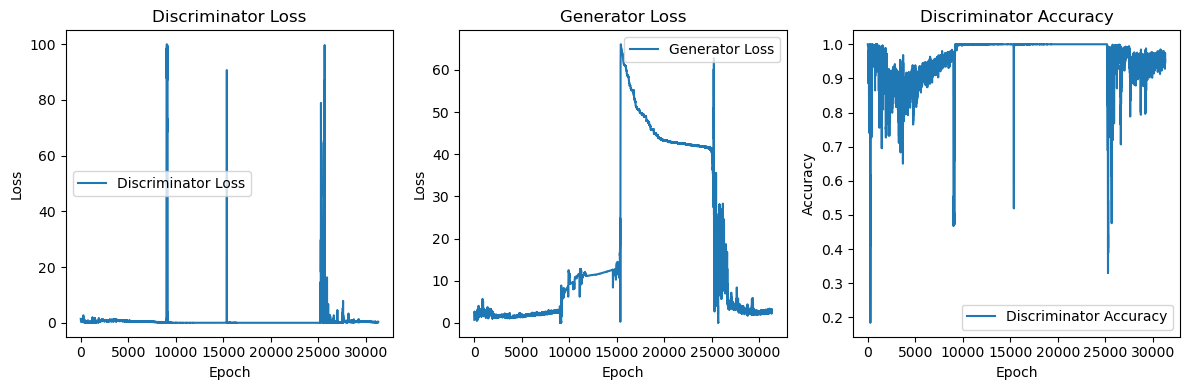

In [67]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(g_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
# Platting the values again

In [69]:
# Now we can calculate the averages and plot the values as previously done
# Calculate average values per epoch
avg_real_accuracies = []
avg_fake_accuracies = []
avg_d_losses = []
avg_g_losses = []

In [70]:
# Helper function for averaging
def calculate_average(values):
    return np.mean(values) if values else 0

current_epoch = 0
temp_real_acc = []
temp_fake_acc = []
temp_d_loss = []
temp_g_loss = []

In [71]:
for i in range(len(epochs)):
    if epochs[i] != current_epoch:
        # Calculate averages for the current epoch and reset lists
        avg_real_accuracies.append(calculate_average(temp_real_acc))
        avg_fake_accuracies.append(calculate_average(temp_fake_acc))
        avg_d_losses.append(calculate_average(temp_d_loss))
        avg_g_losses.append(calculate_average(temp_g_loss))

        temp_real_acc = []
        temp_fake_acc = []
        temp_d_loss = []
        temp_g_loss = []
        current_epoch = epochs[i]

    # Append current values
    temp_real_acc.append(real_accuracy_list[i])
    temp_fake_acc.append(fake_accuracy_list[i])
    temp_d_loss.append(d_losses[i])
    temp_g_loss.append(g_losses[i])

In [72]:
# Add averages for the last epoch
avg_real_accuracies.append(calculate_average(temp_real_acc))
avg_fake_accuracies.append(calculate_average(temp_fake_acc))
avg_d_losses.append(calculate_average(temp_d_loss))
avg_g_losses.append(calculate_average(temp_g_loss))

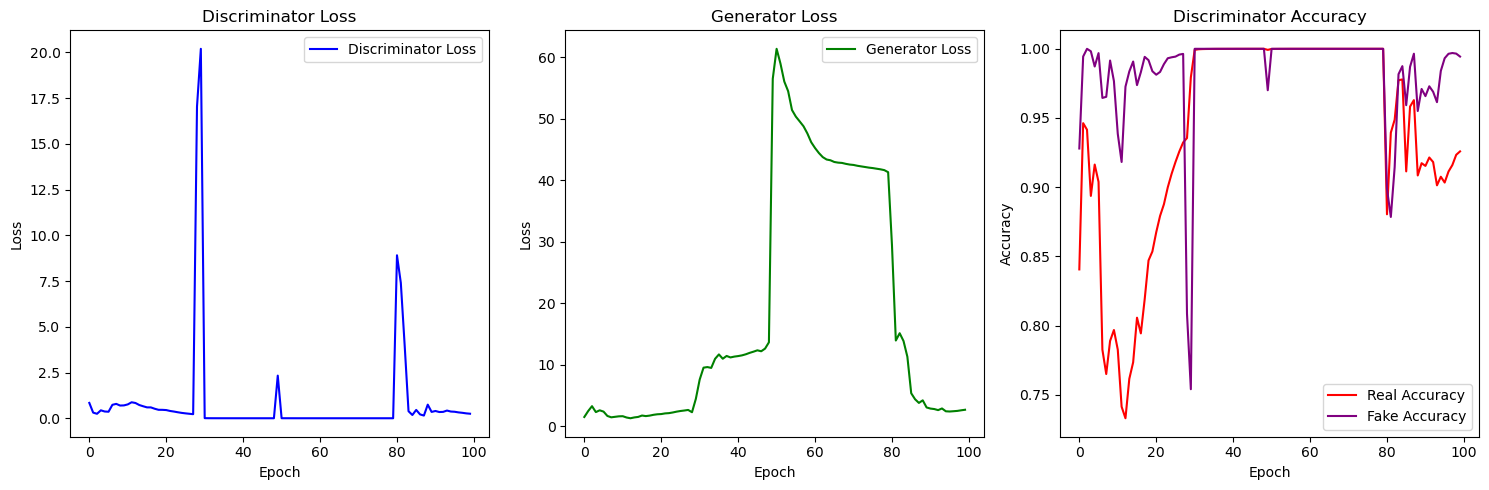

In [73]:
# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Plotting the graphs
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, avg_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, avg_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, avg_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, avg_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
